# Стратегия взаимодействия с клиентами на основе аналитических данных для сети фитнес-центров "Культурист-датасаентист"

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

## Шаг. Загрузка Данных.

### Импорт библиотек и данных

Импортируем нужные библиотеки:

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
warnings.simplefilter(action="ignore", category=FutureWarning)

Загрузим данные:

In [25]:
df = pd.read_csv('/datasets/gym_churn.csv')

### Ознакомление с таблицей

In [26]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [27]:
df.sample(random_state=42)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
555,1,1,0,0,1,6,1,37,205.631751,5.0,2,1.40069,1.614663,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Проверим дубликаты в таблице:

In [29]:
df.duplicated().sum()

0

### Вывод по шагу:

- В таблице отсутствуют дубликаты и пропуски 
- Данные приведены к нужному типу. Категориальные признаки переведны в количественные методом one-hot-encoding
- Количественные данные приведены к нужному типу

## Шаг. Исследовательский анализ данных

Изучим числовые показатели в датасете более детально:

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**В среднем посетители**: 
- Покупают абонемент на один месяц
- Имеют возраст 29 лет
- Тратят около 136 валюты за все время посещения
- Ходят в зал 2,5 раза в неделю по статистике за все время и по статистике за месяц

### Сравнение групп клиентов по признаку оттока

Группа, продолжающая заниматься:

In [31]:
df.query('Churn == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
Promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
Group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
Age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
Avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
Month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


**В среднем посетители, которые продолжают заниматься:**
- Сотрудники компании-партнера клуба
- Покупают абонемент на 6 месяцев
- Имеют возраст 30 лет
- Тратят на дополнительные услуги 150 валюты
- Имеют 6 месяцев до окончания контракта
- Имеют 4 месяца с первого обращения в клуб
- Занимают около 2-3 раз в неделю (т.е. 2,7 - ближе к 3)

Группа, в которой зафиксирован отток:

In [32]:
df.query('Churn == 1').describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
Phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
Group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
Age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
Avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
Month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


**В среднем посетители, которые бросили заниматься:**
- Сотрудники компании-партнера клуба
- Имеют возраст около 27 лет
- Тратят 103 валюты на дополнительные услуги
- Покупают абонемент на 1 месяц
- Имеют 1 месяц до конца абонемента
- Имеют 1 месяц с момента первого посещения клуба
-  Посещают зал за все время и месяц 1 раз в неделю.

Таблица по обоим группам:

In [33]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


### Исследование признаков на выбросы для двух групп

Группа, которая продолжает заниматься:

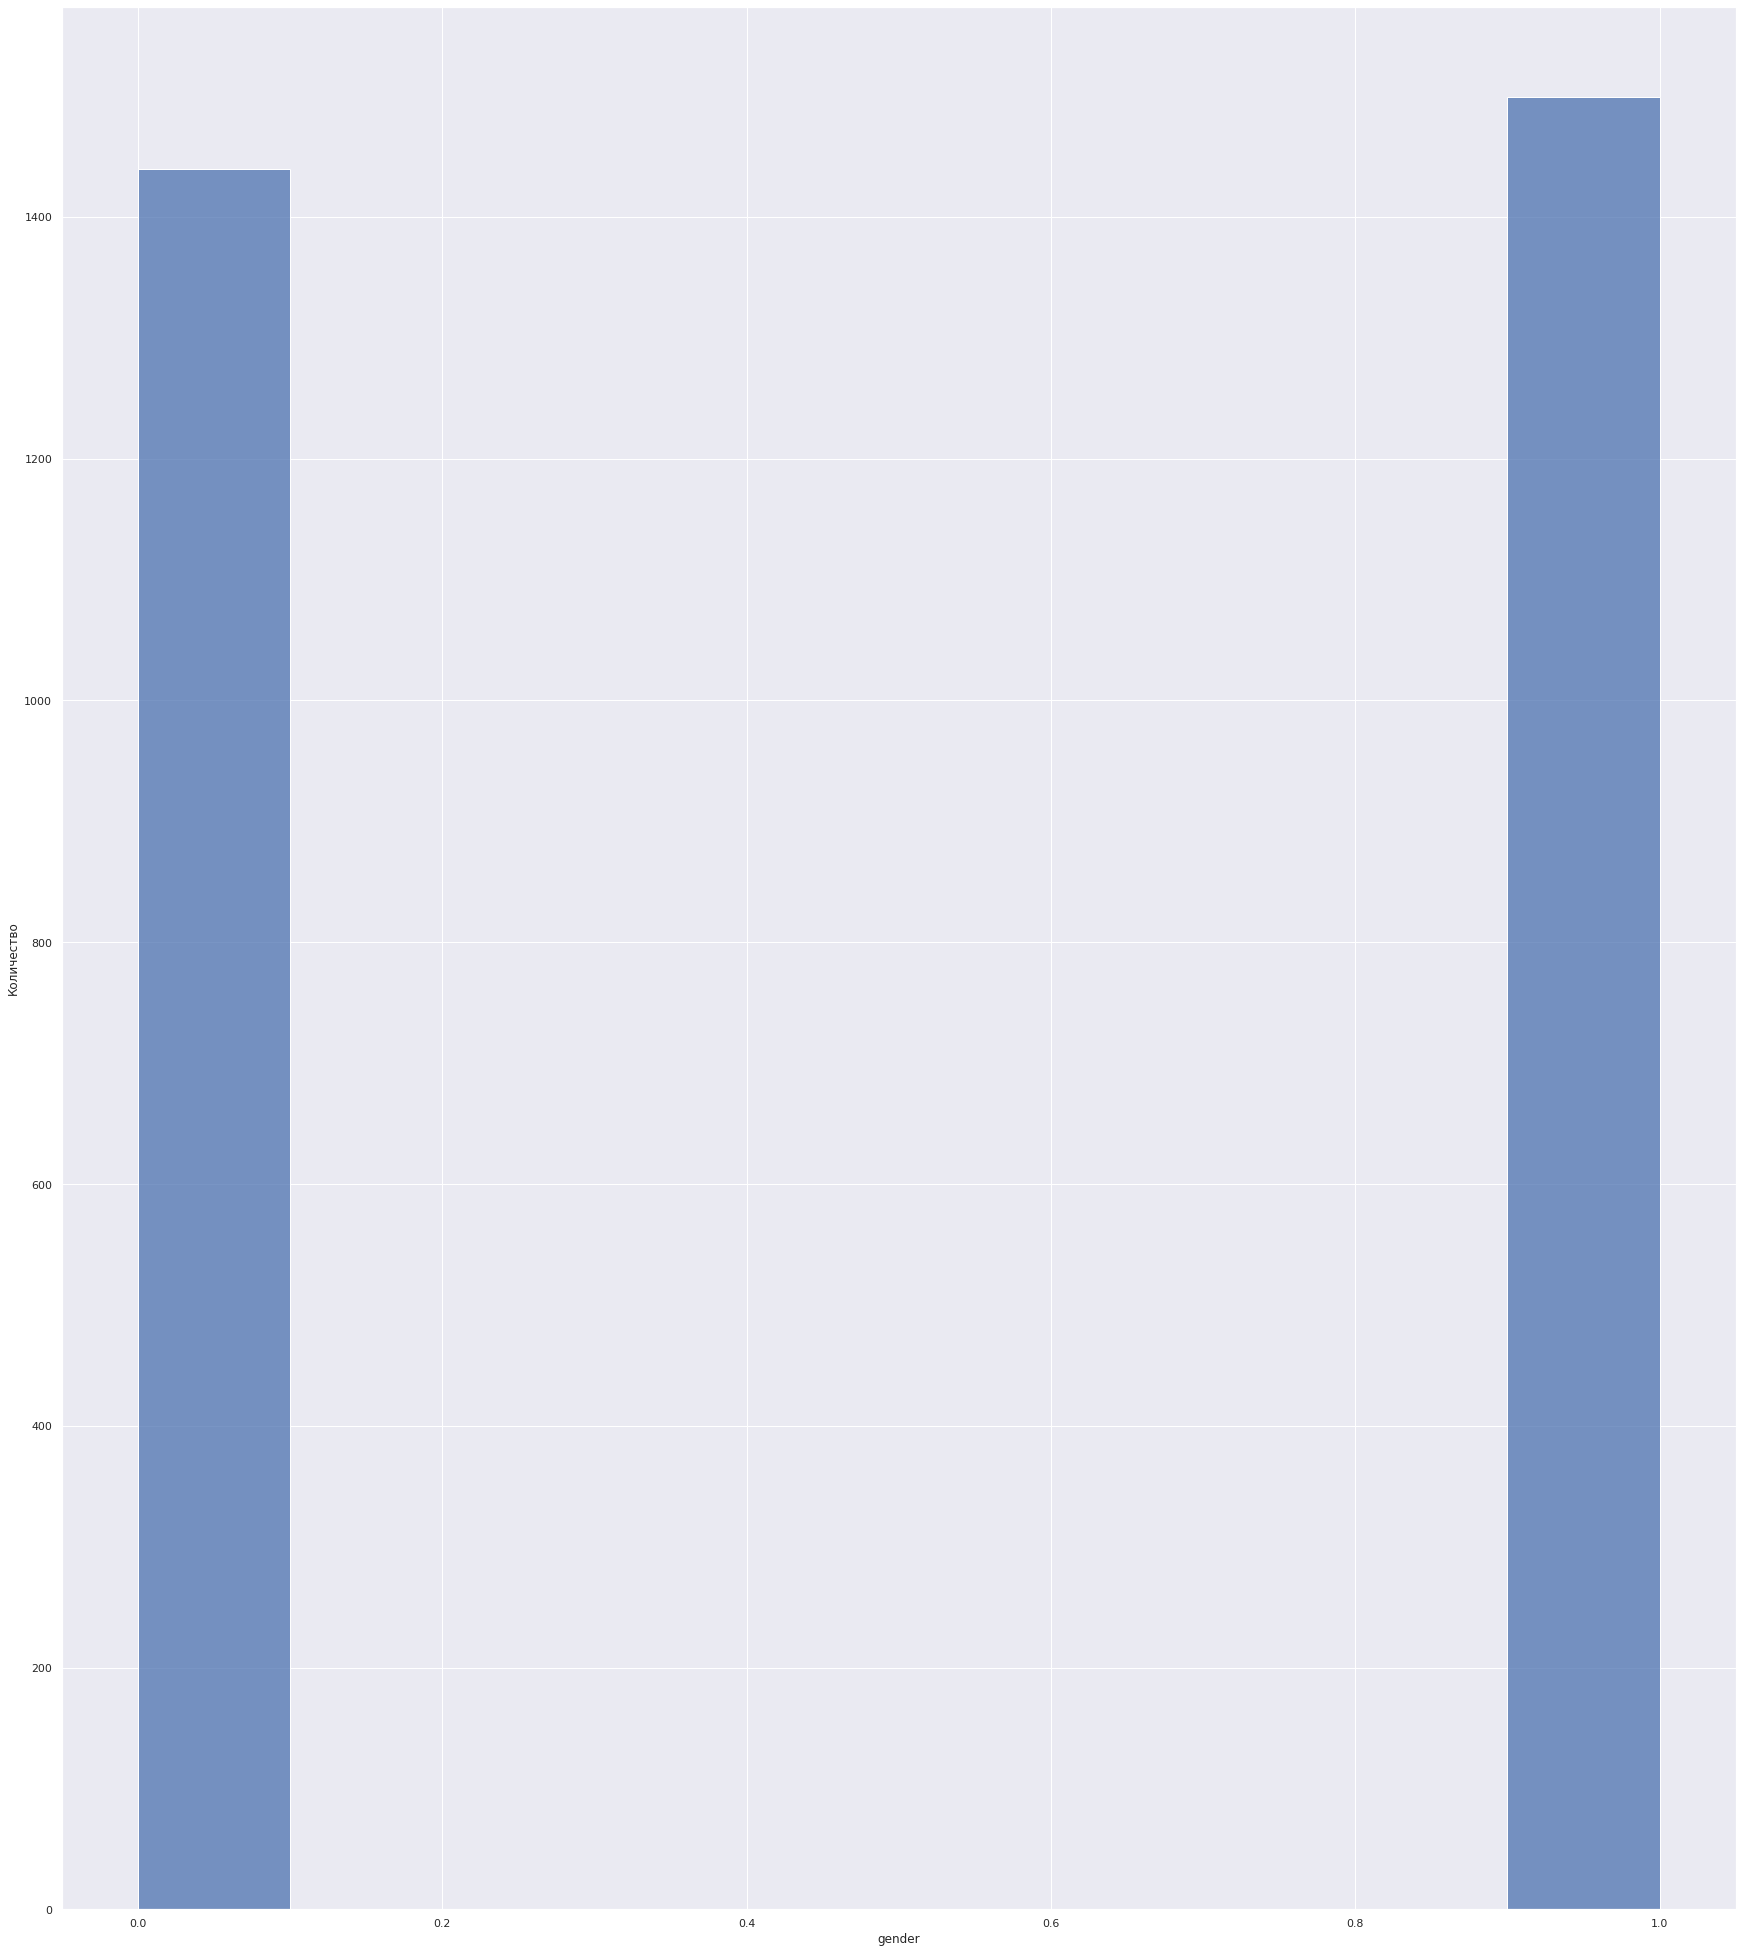

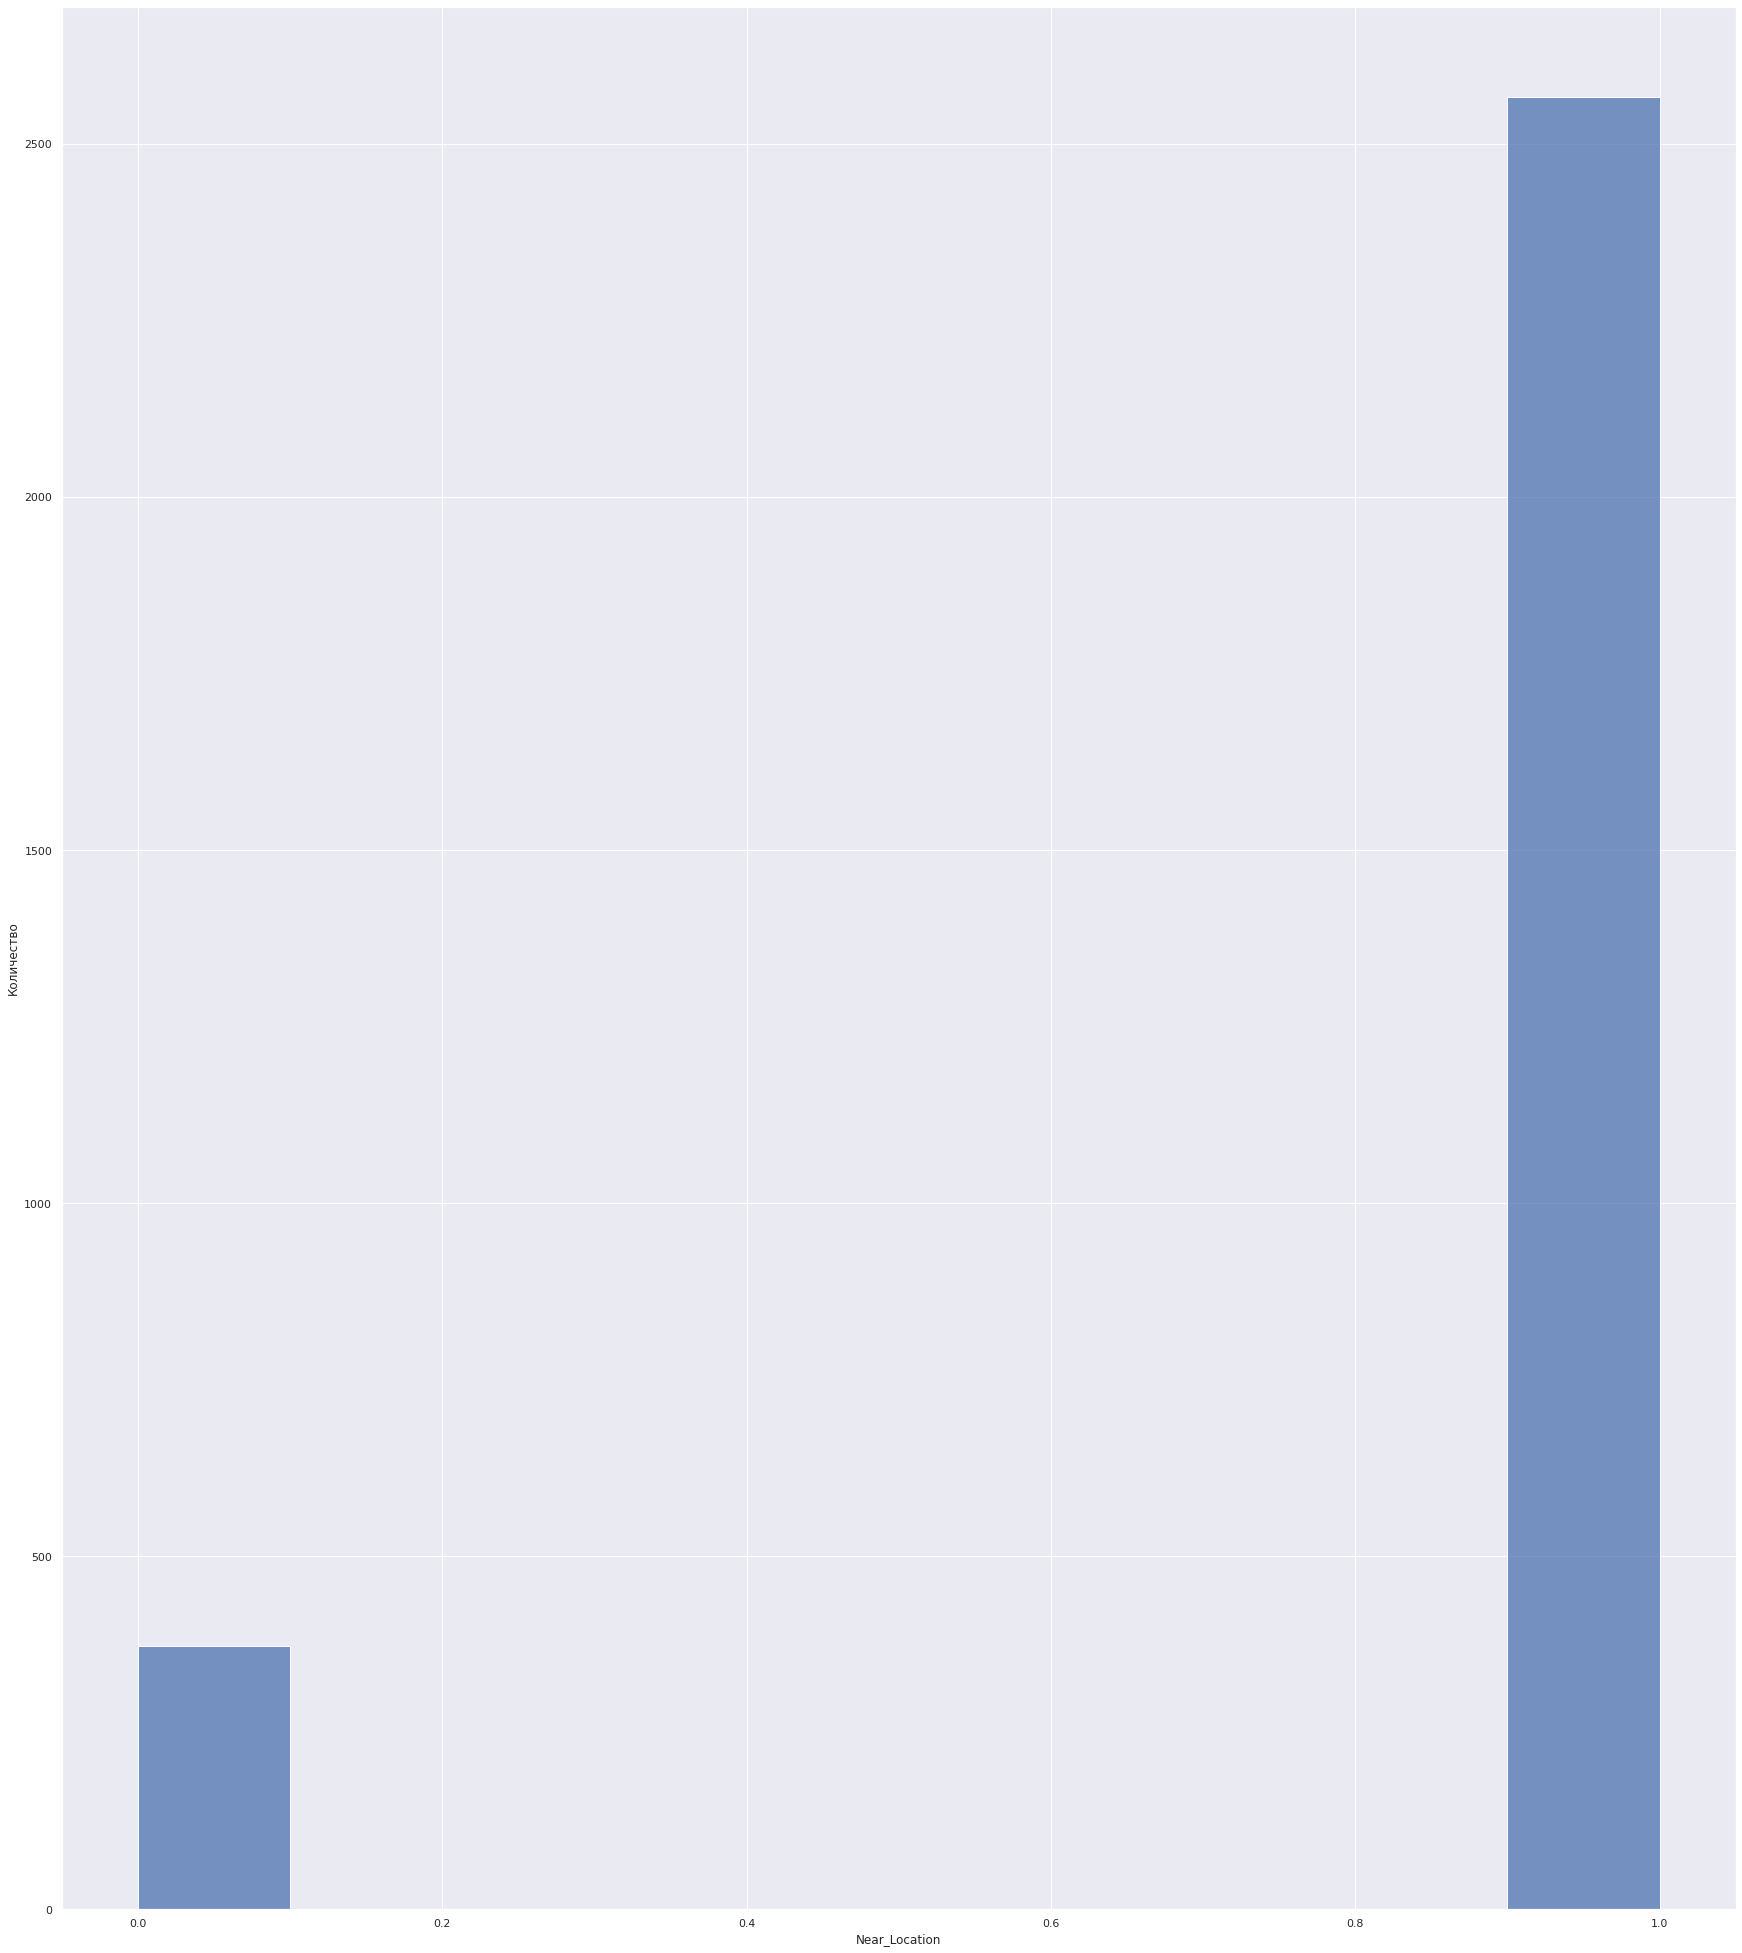

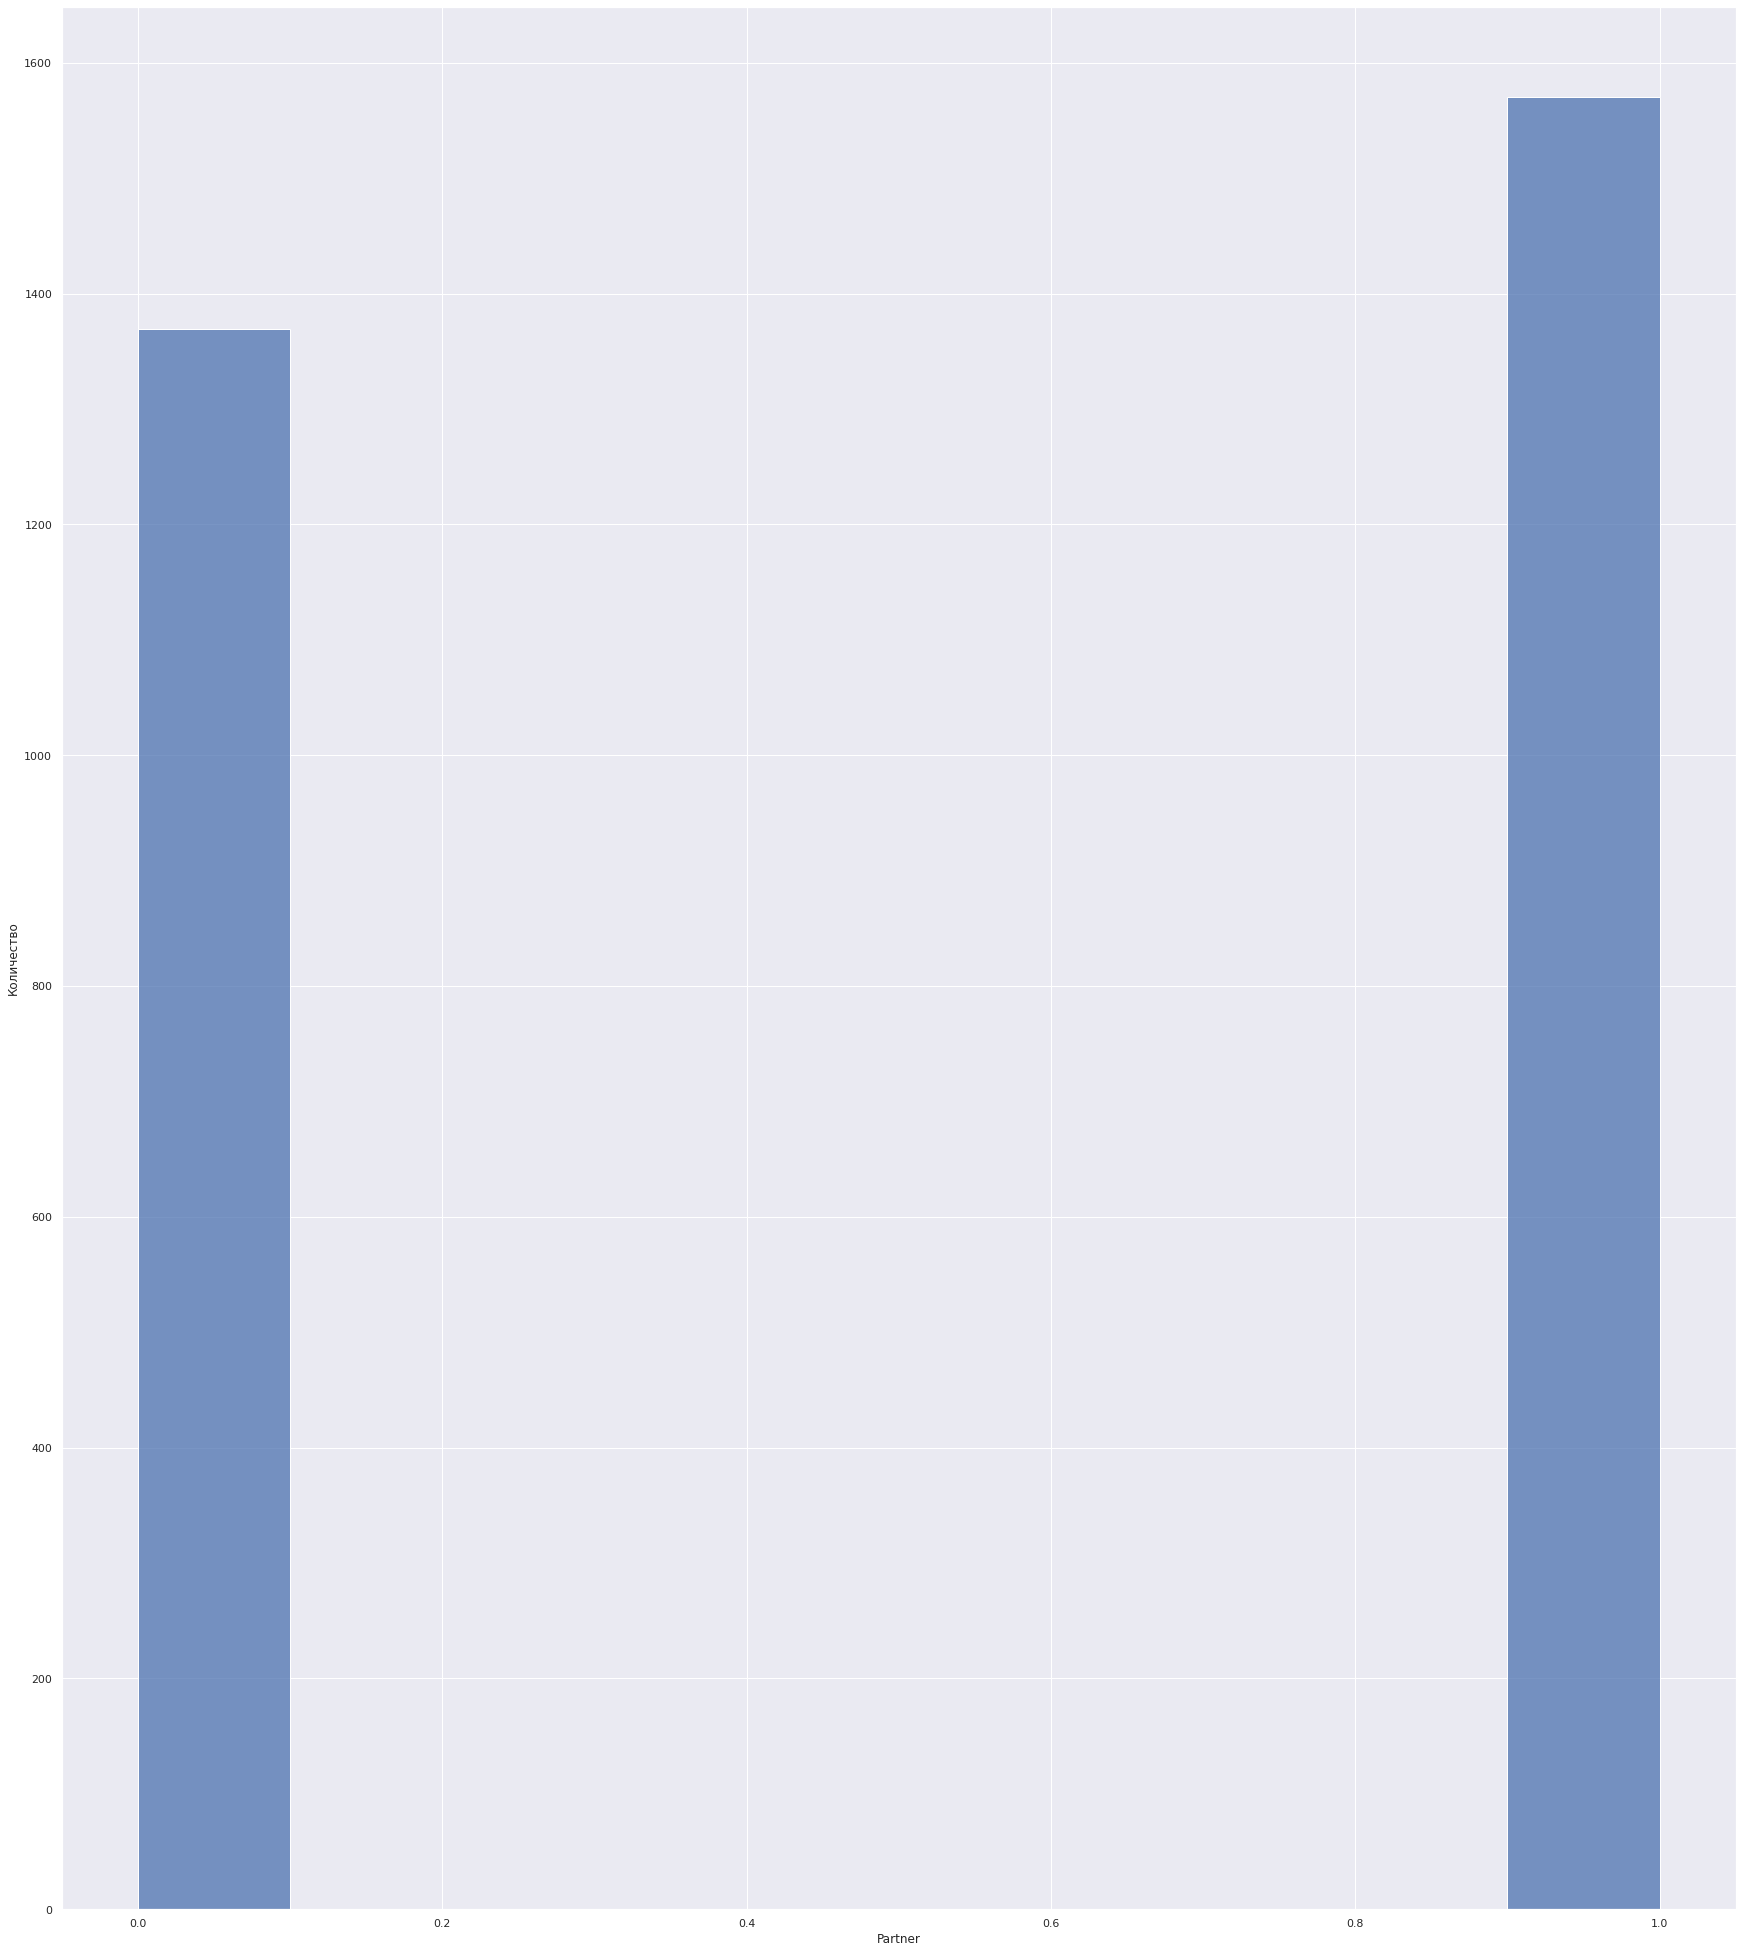

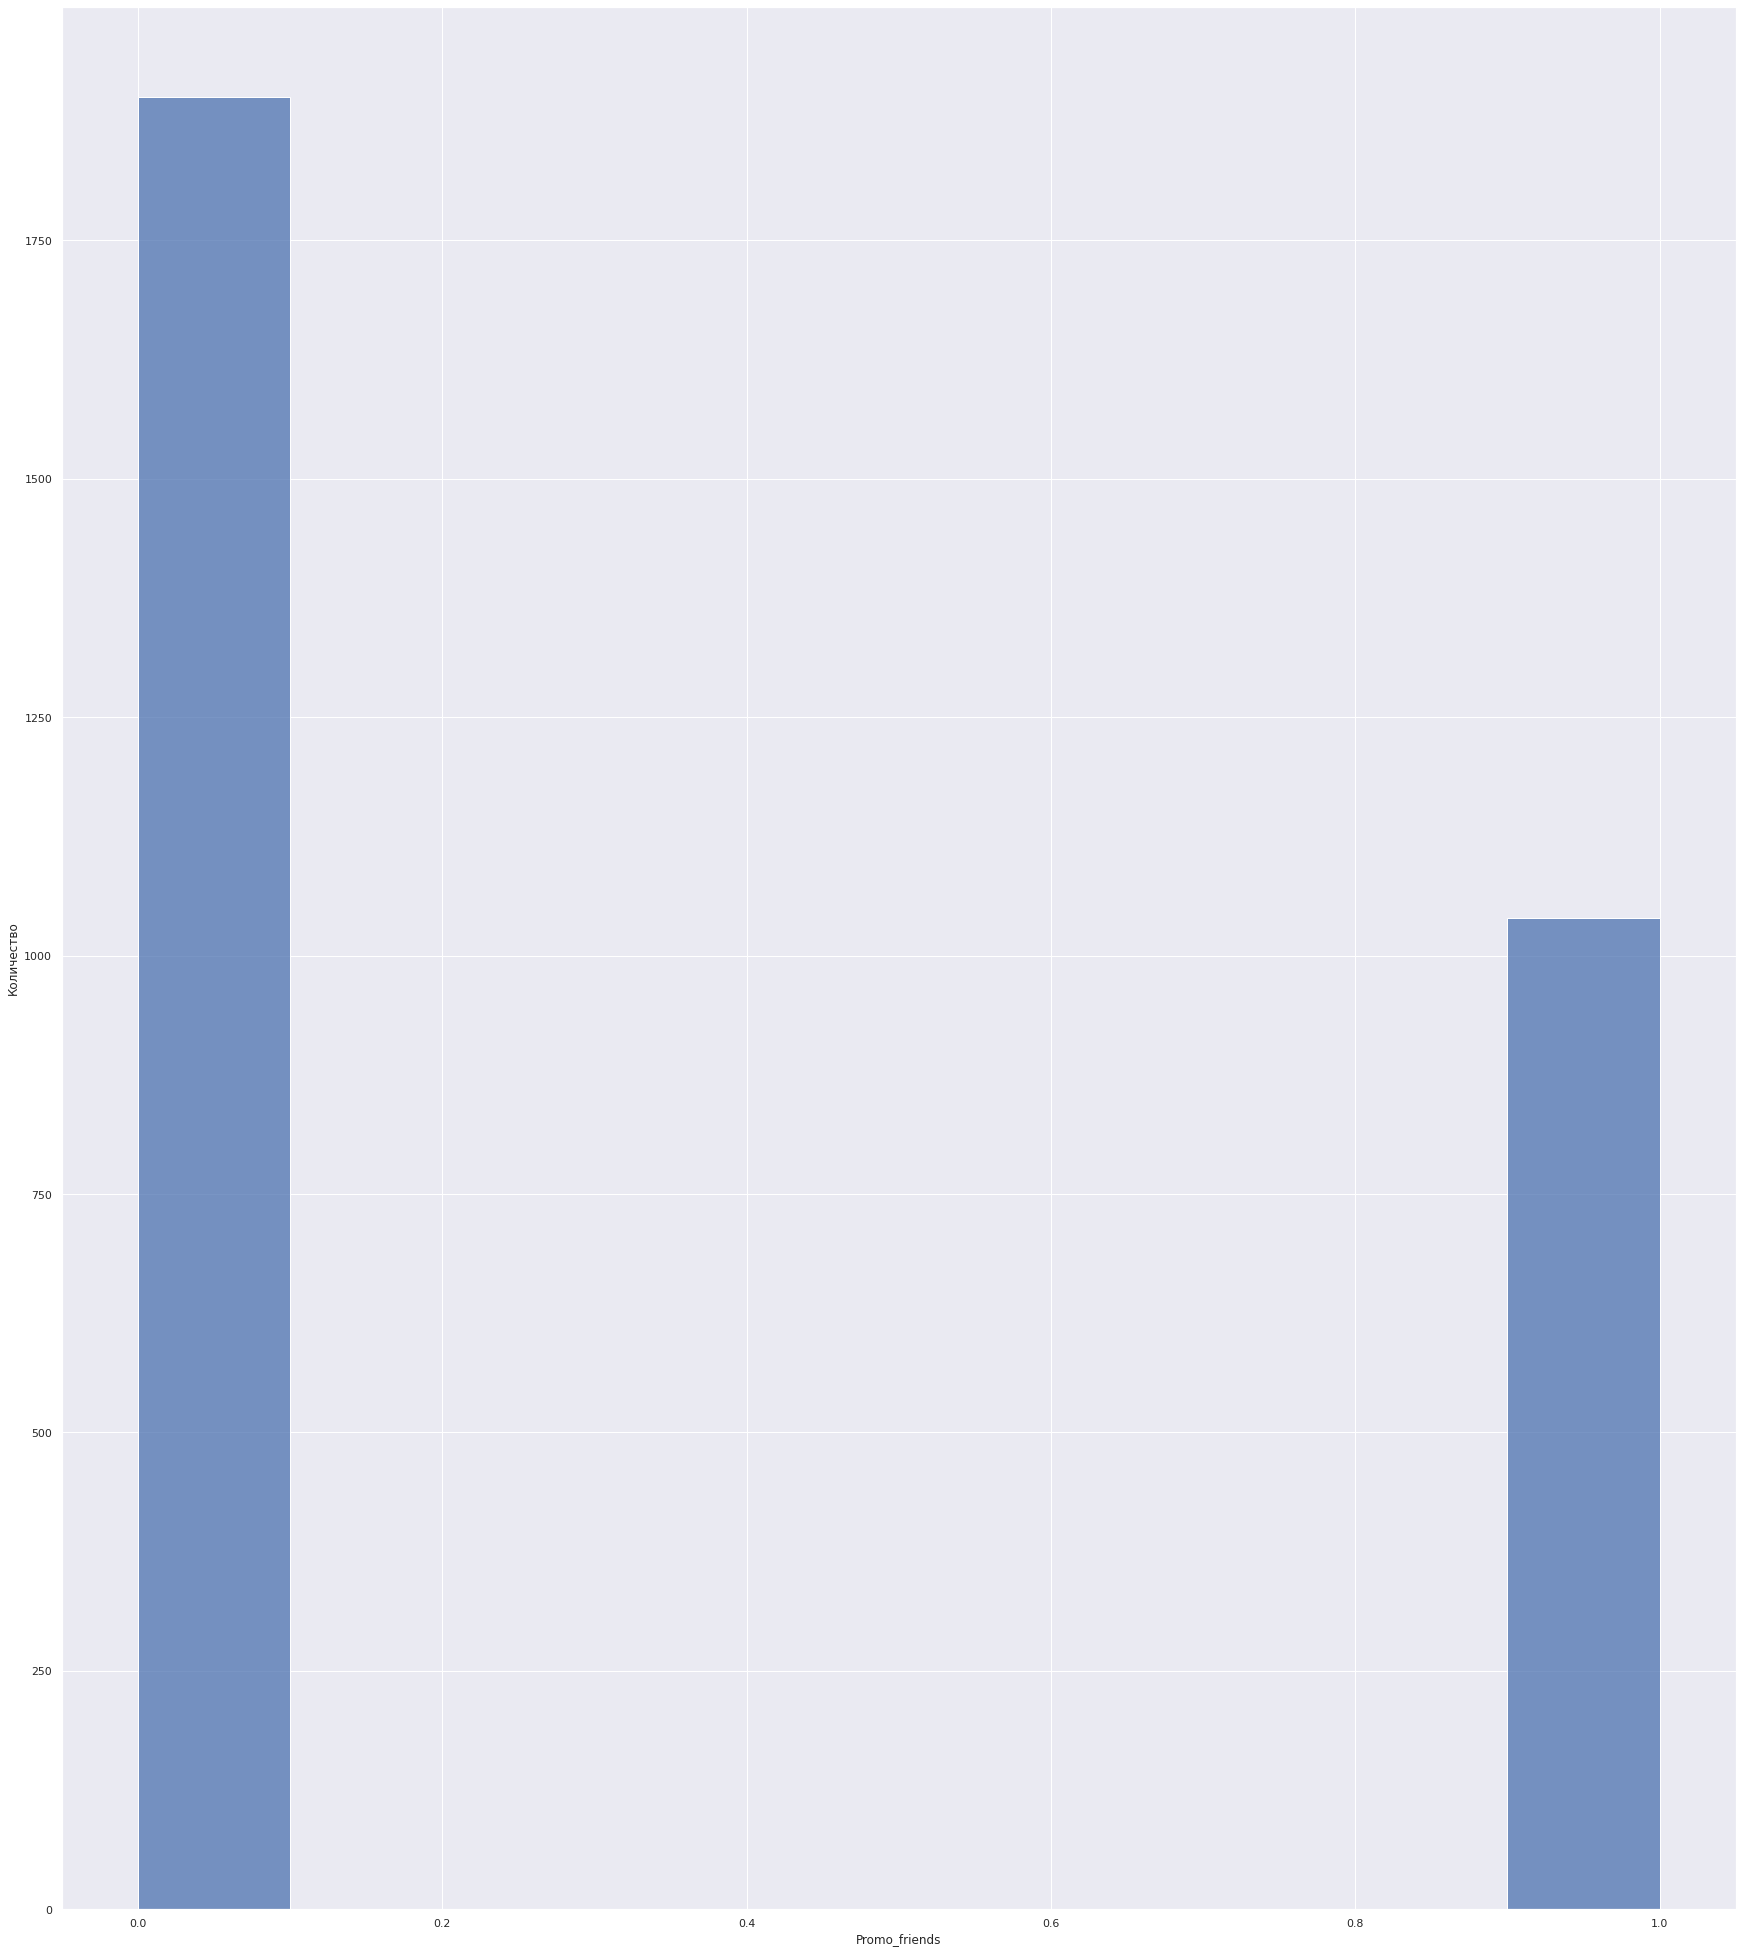

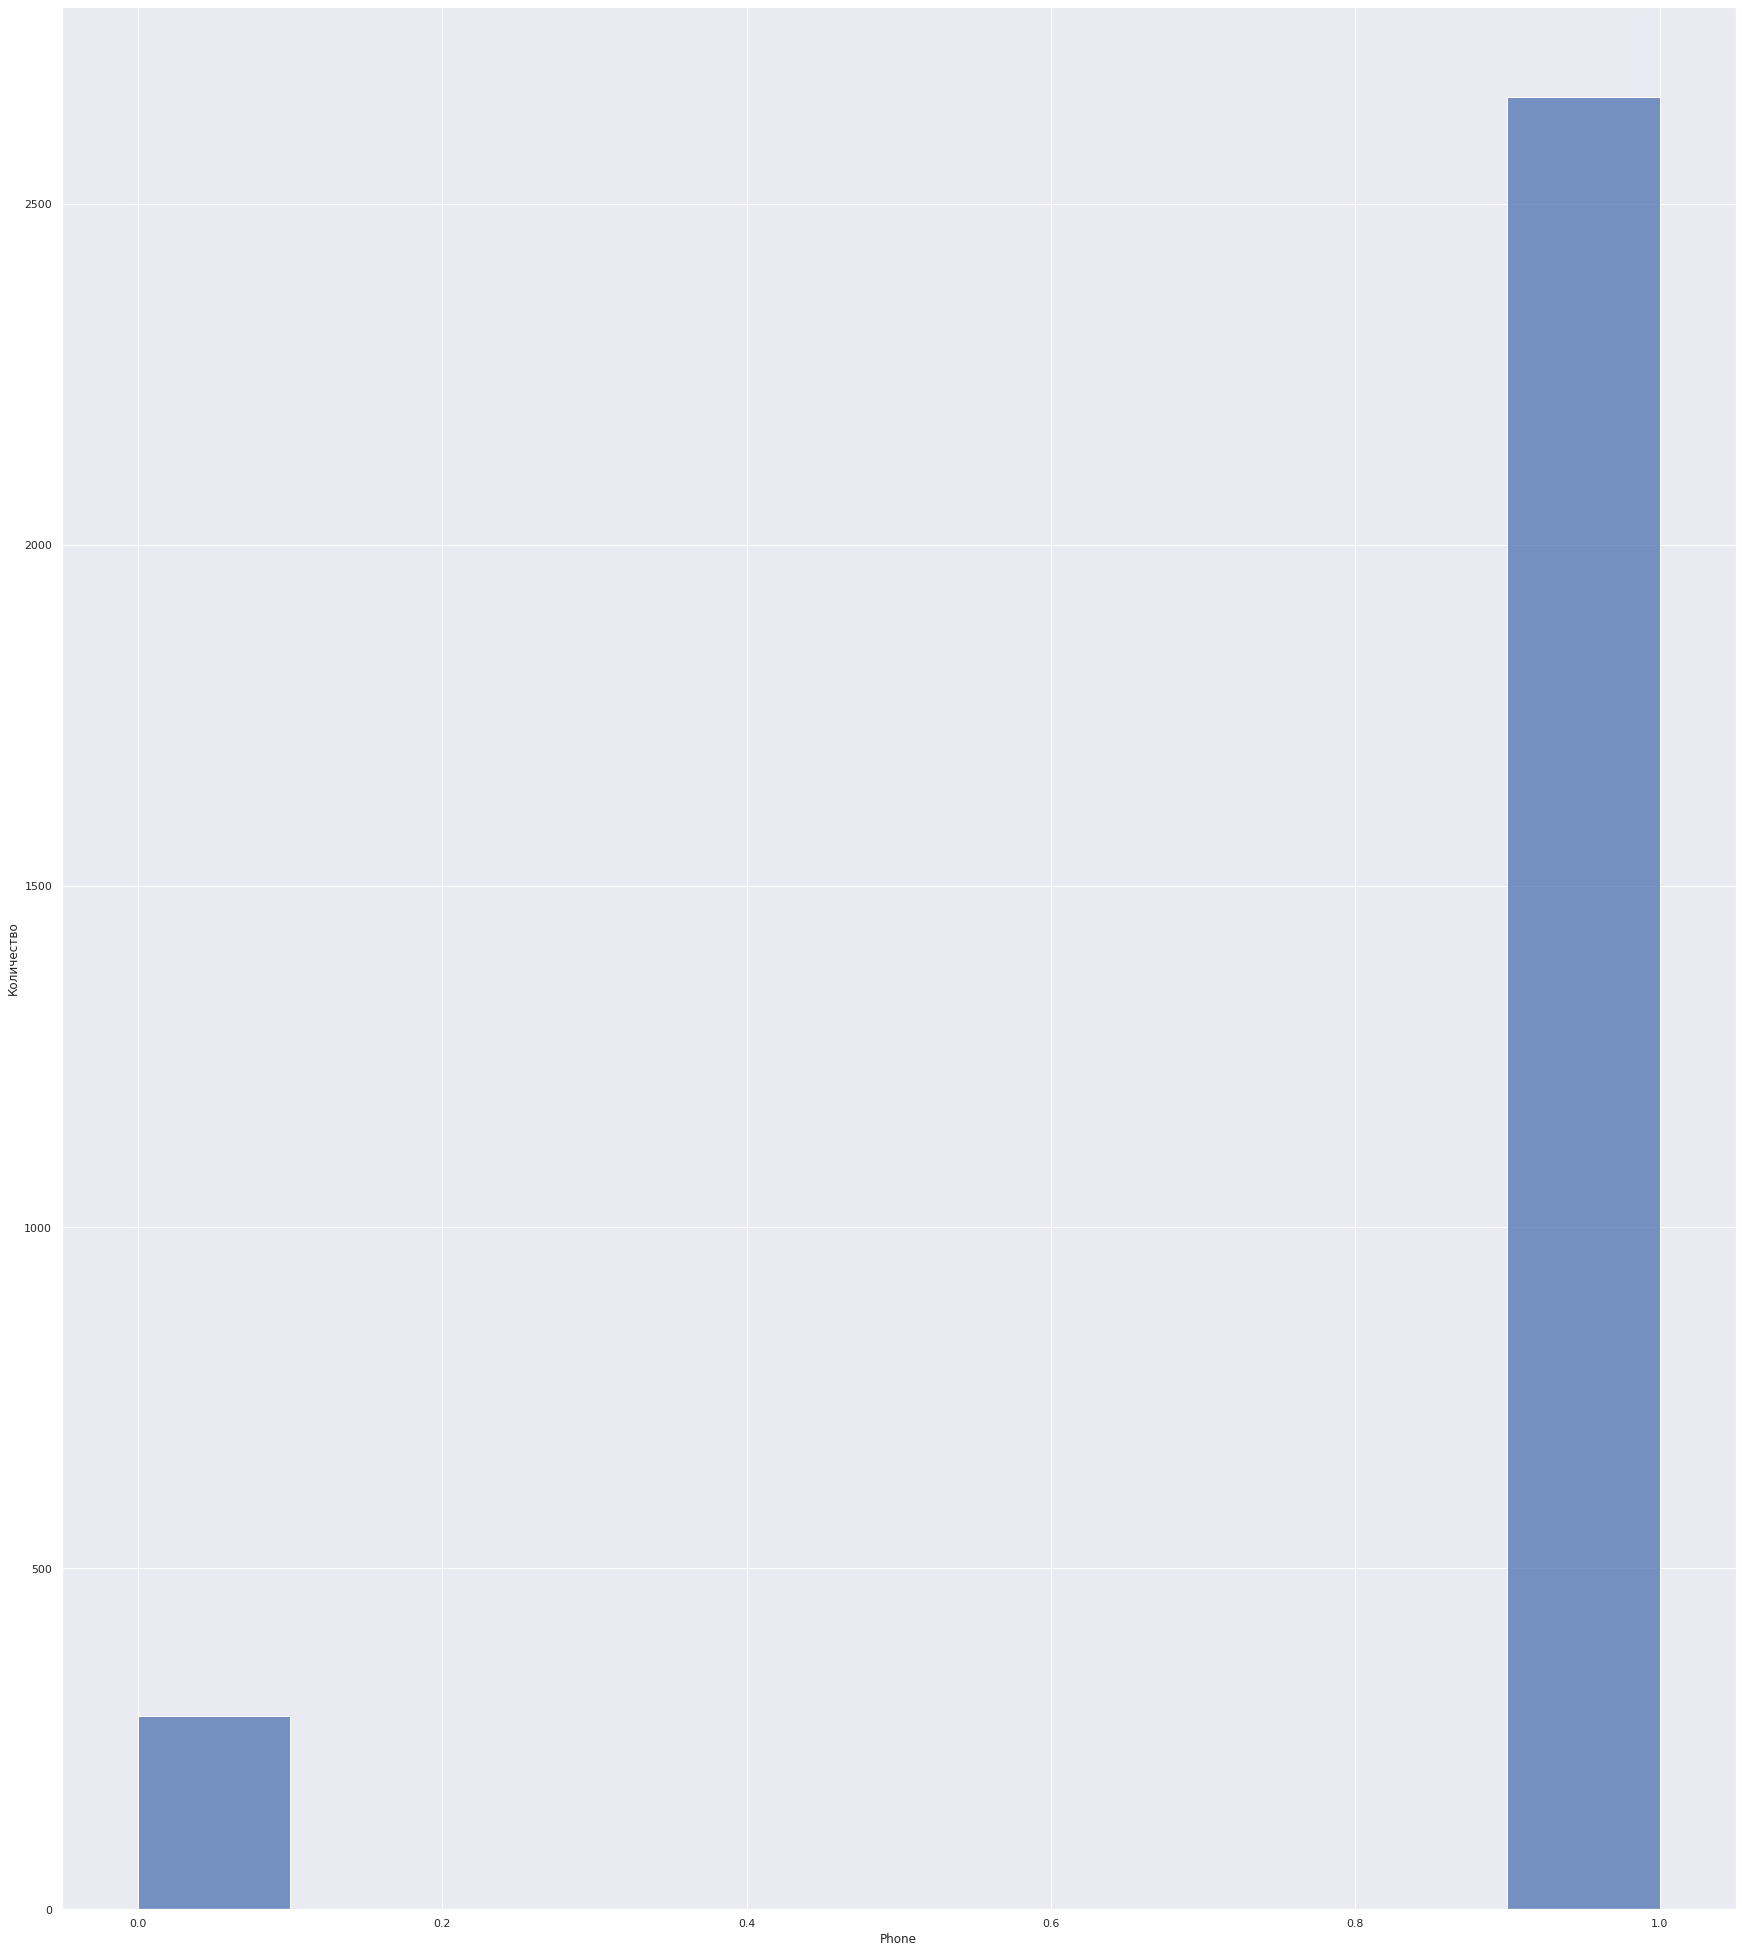

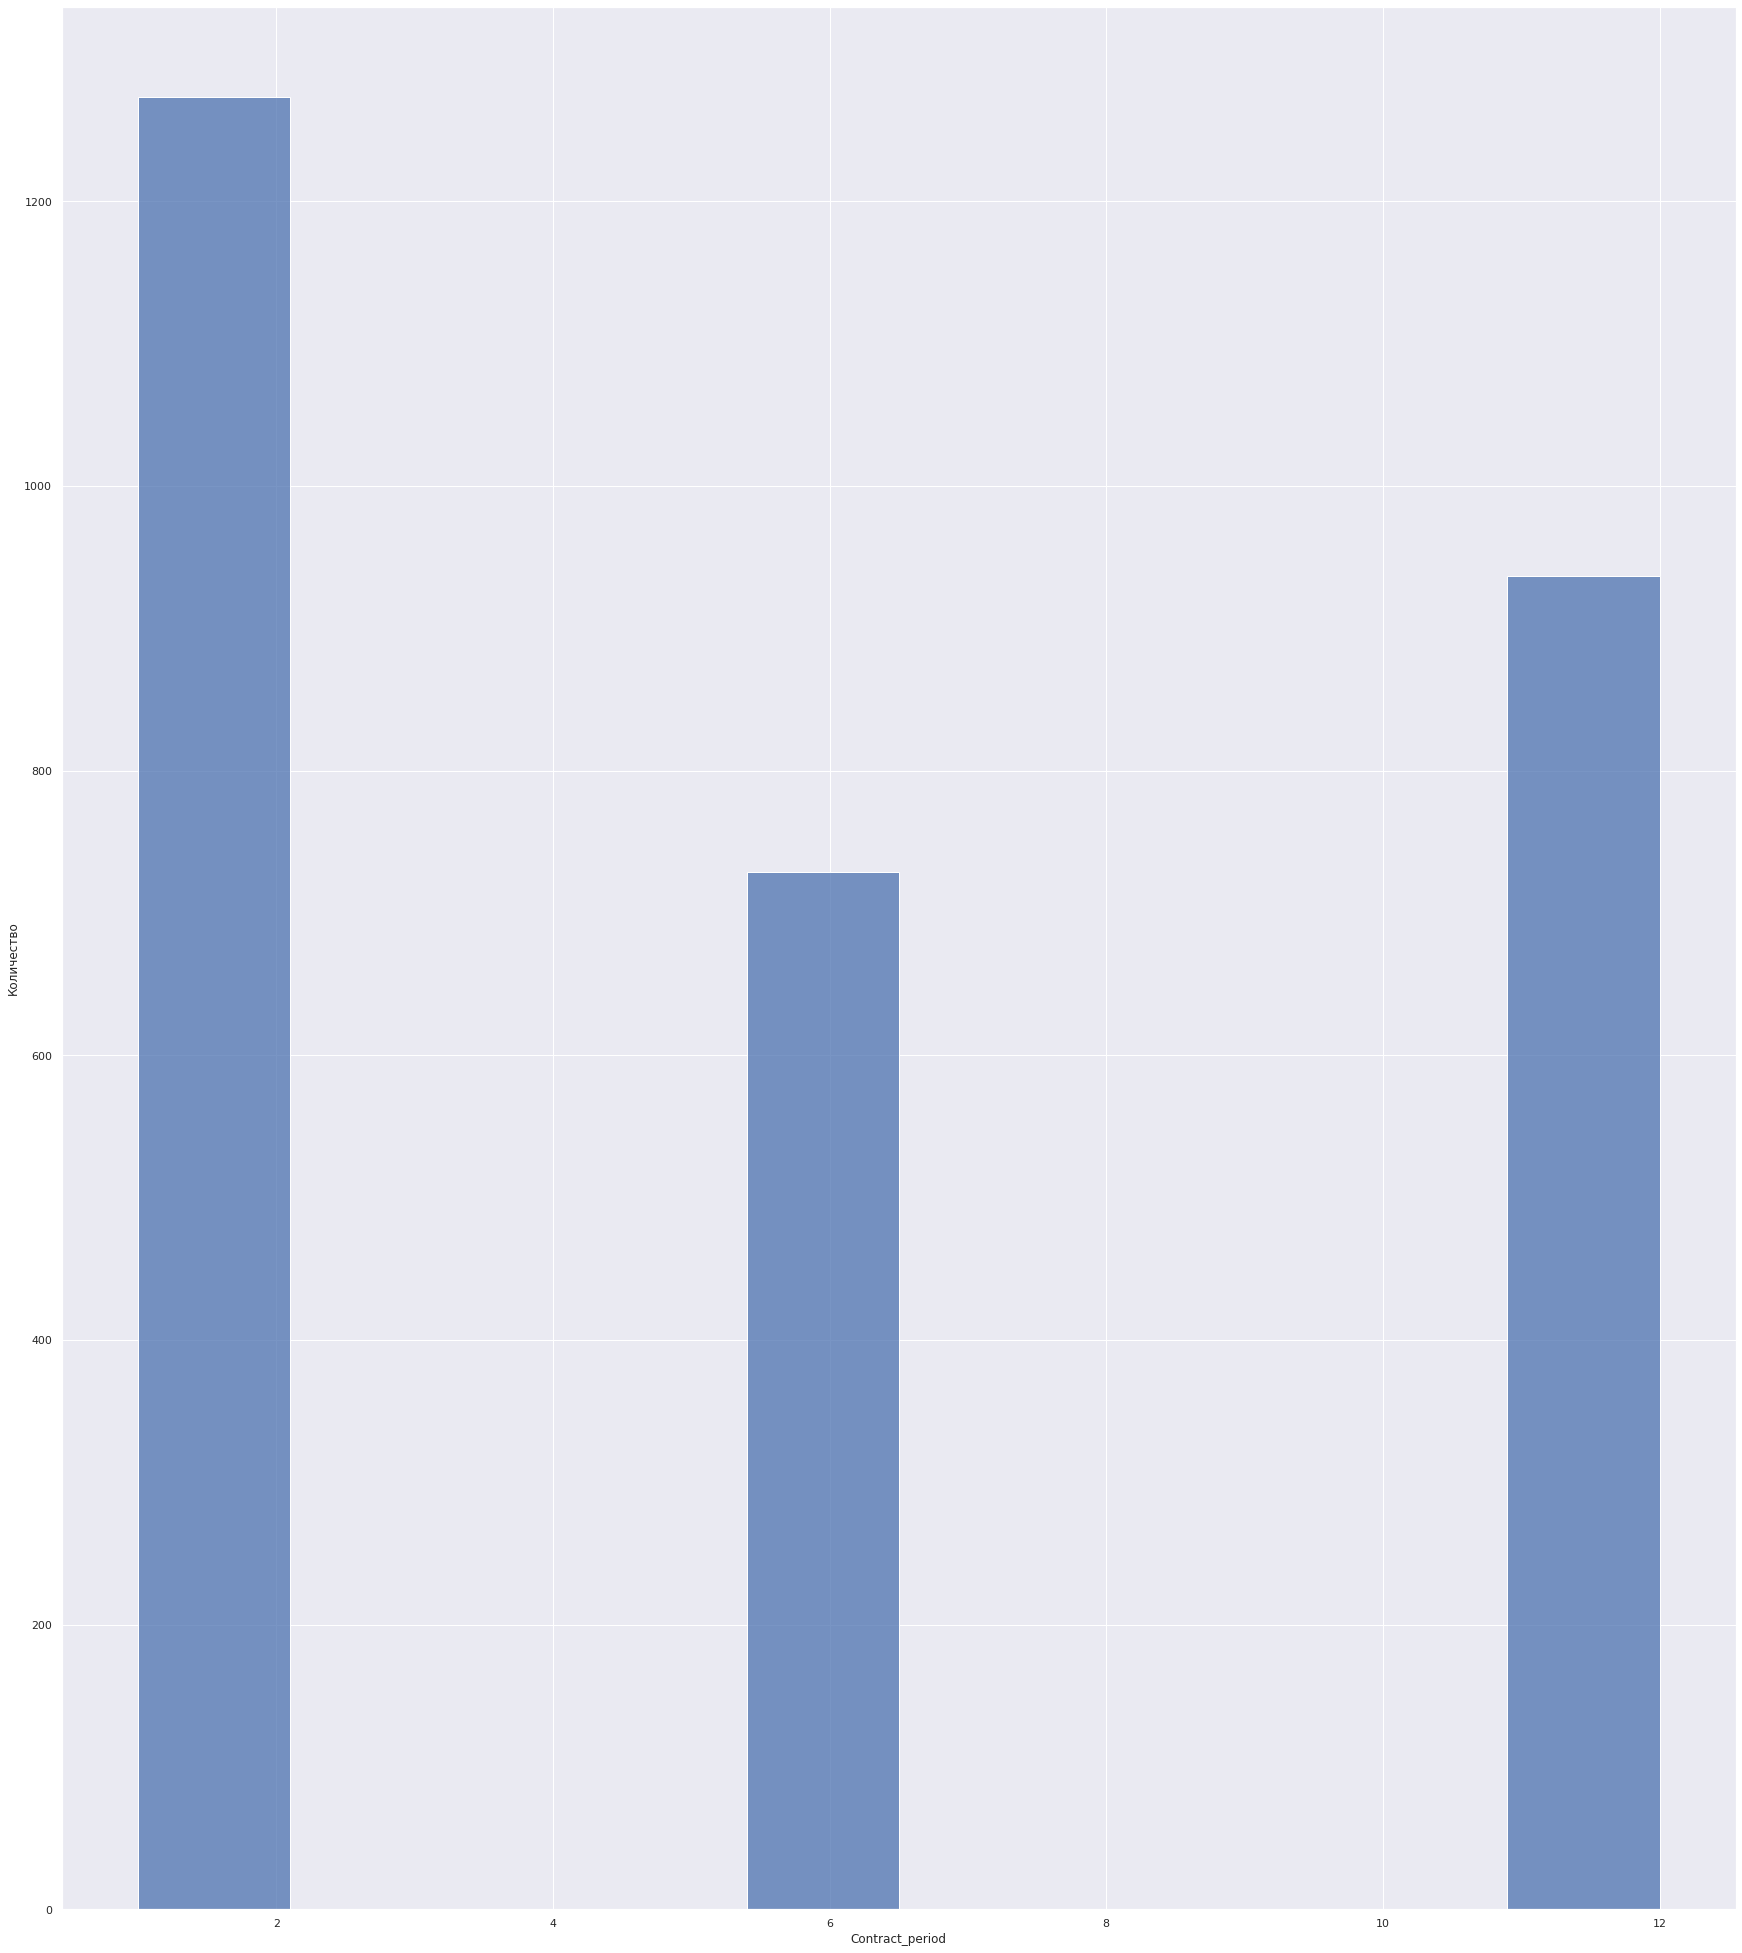

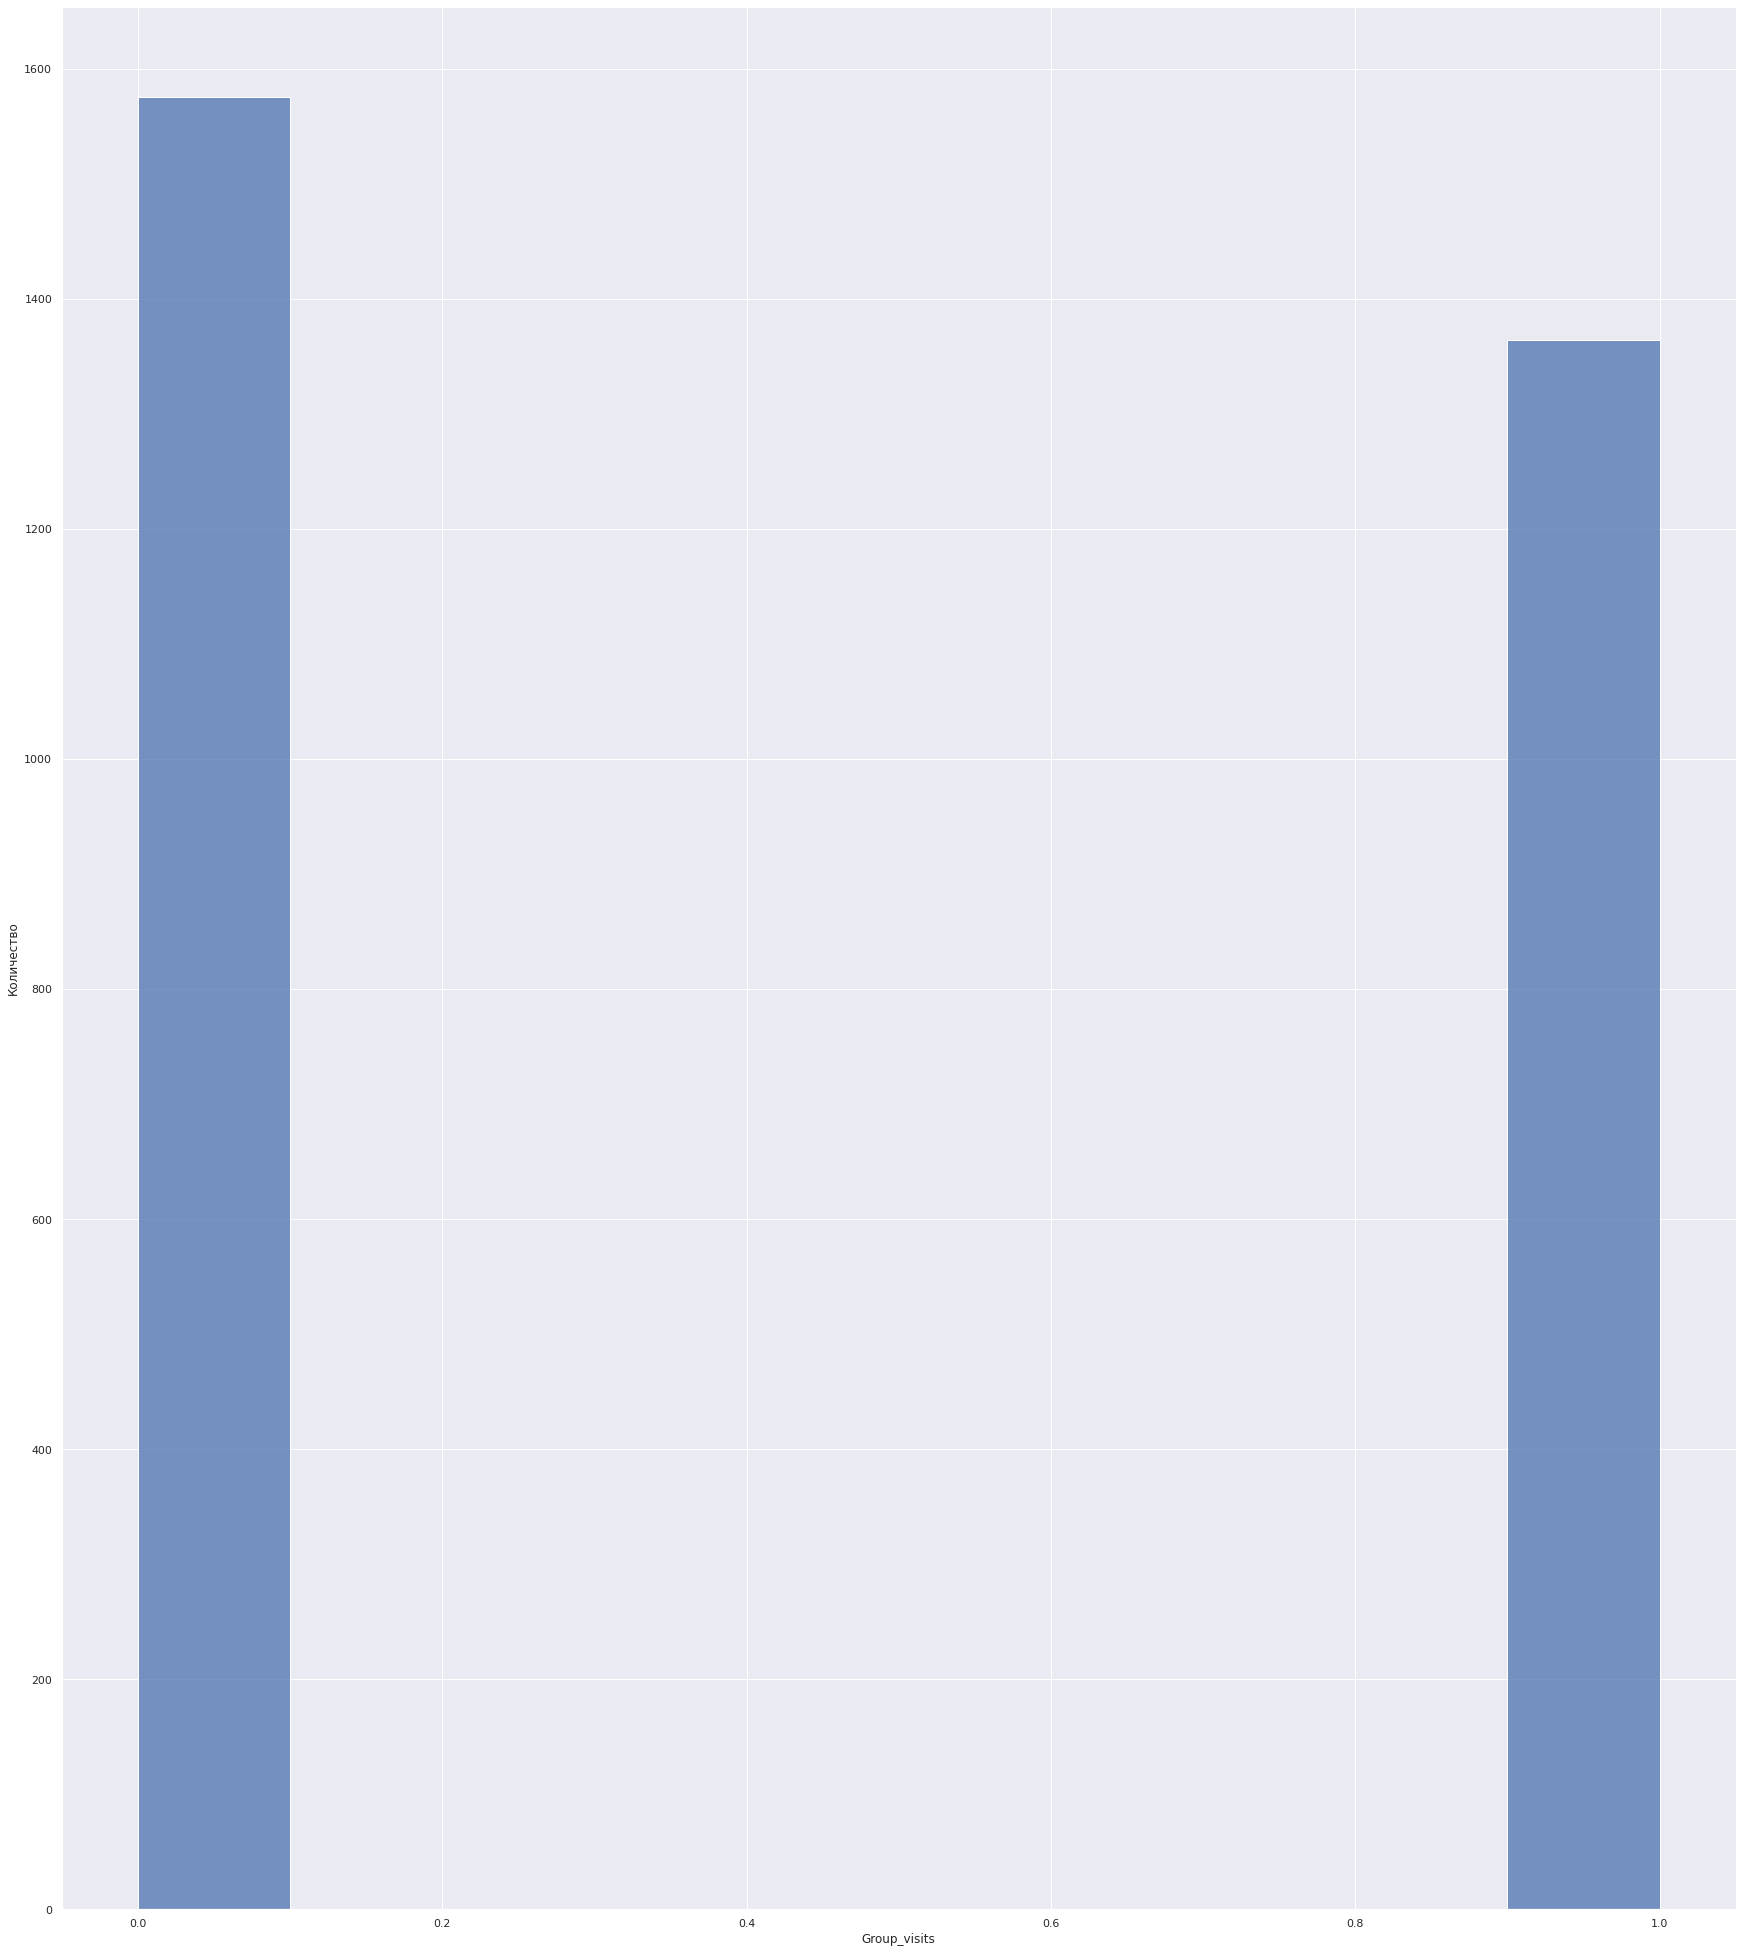

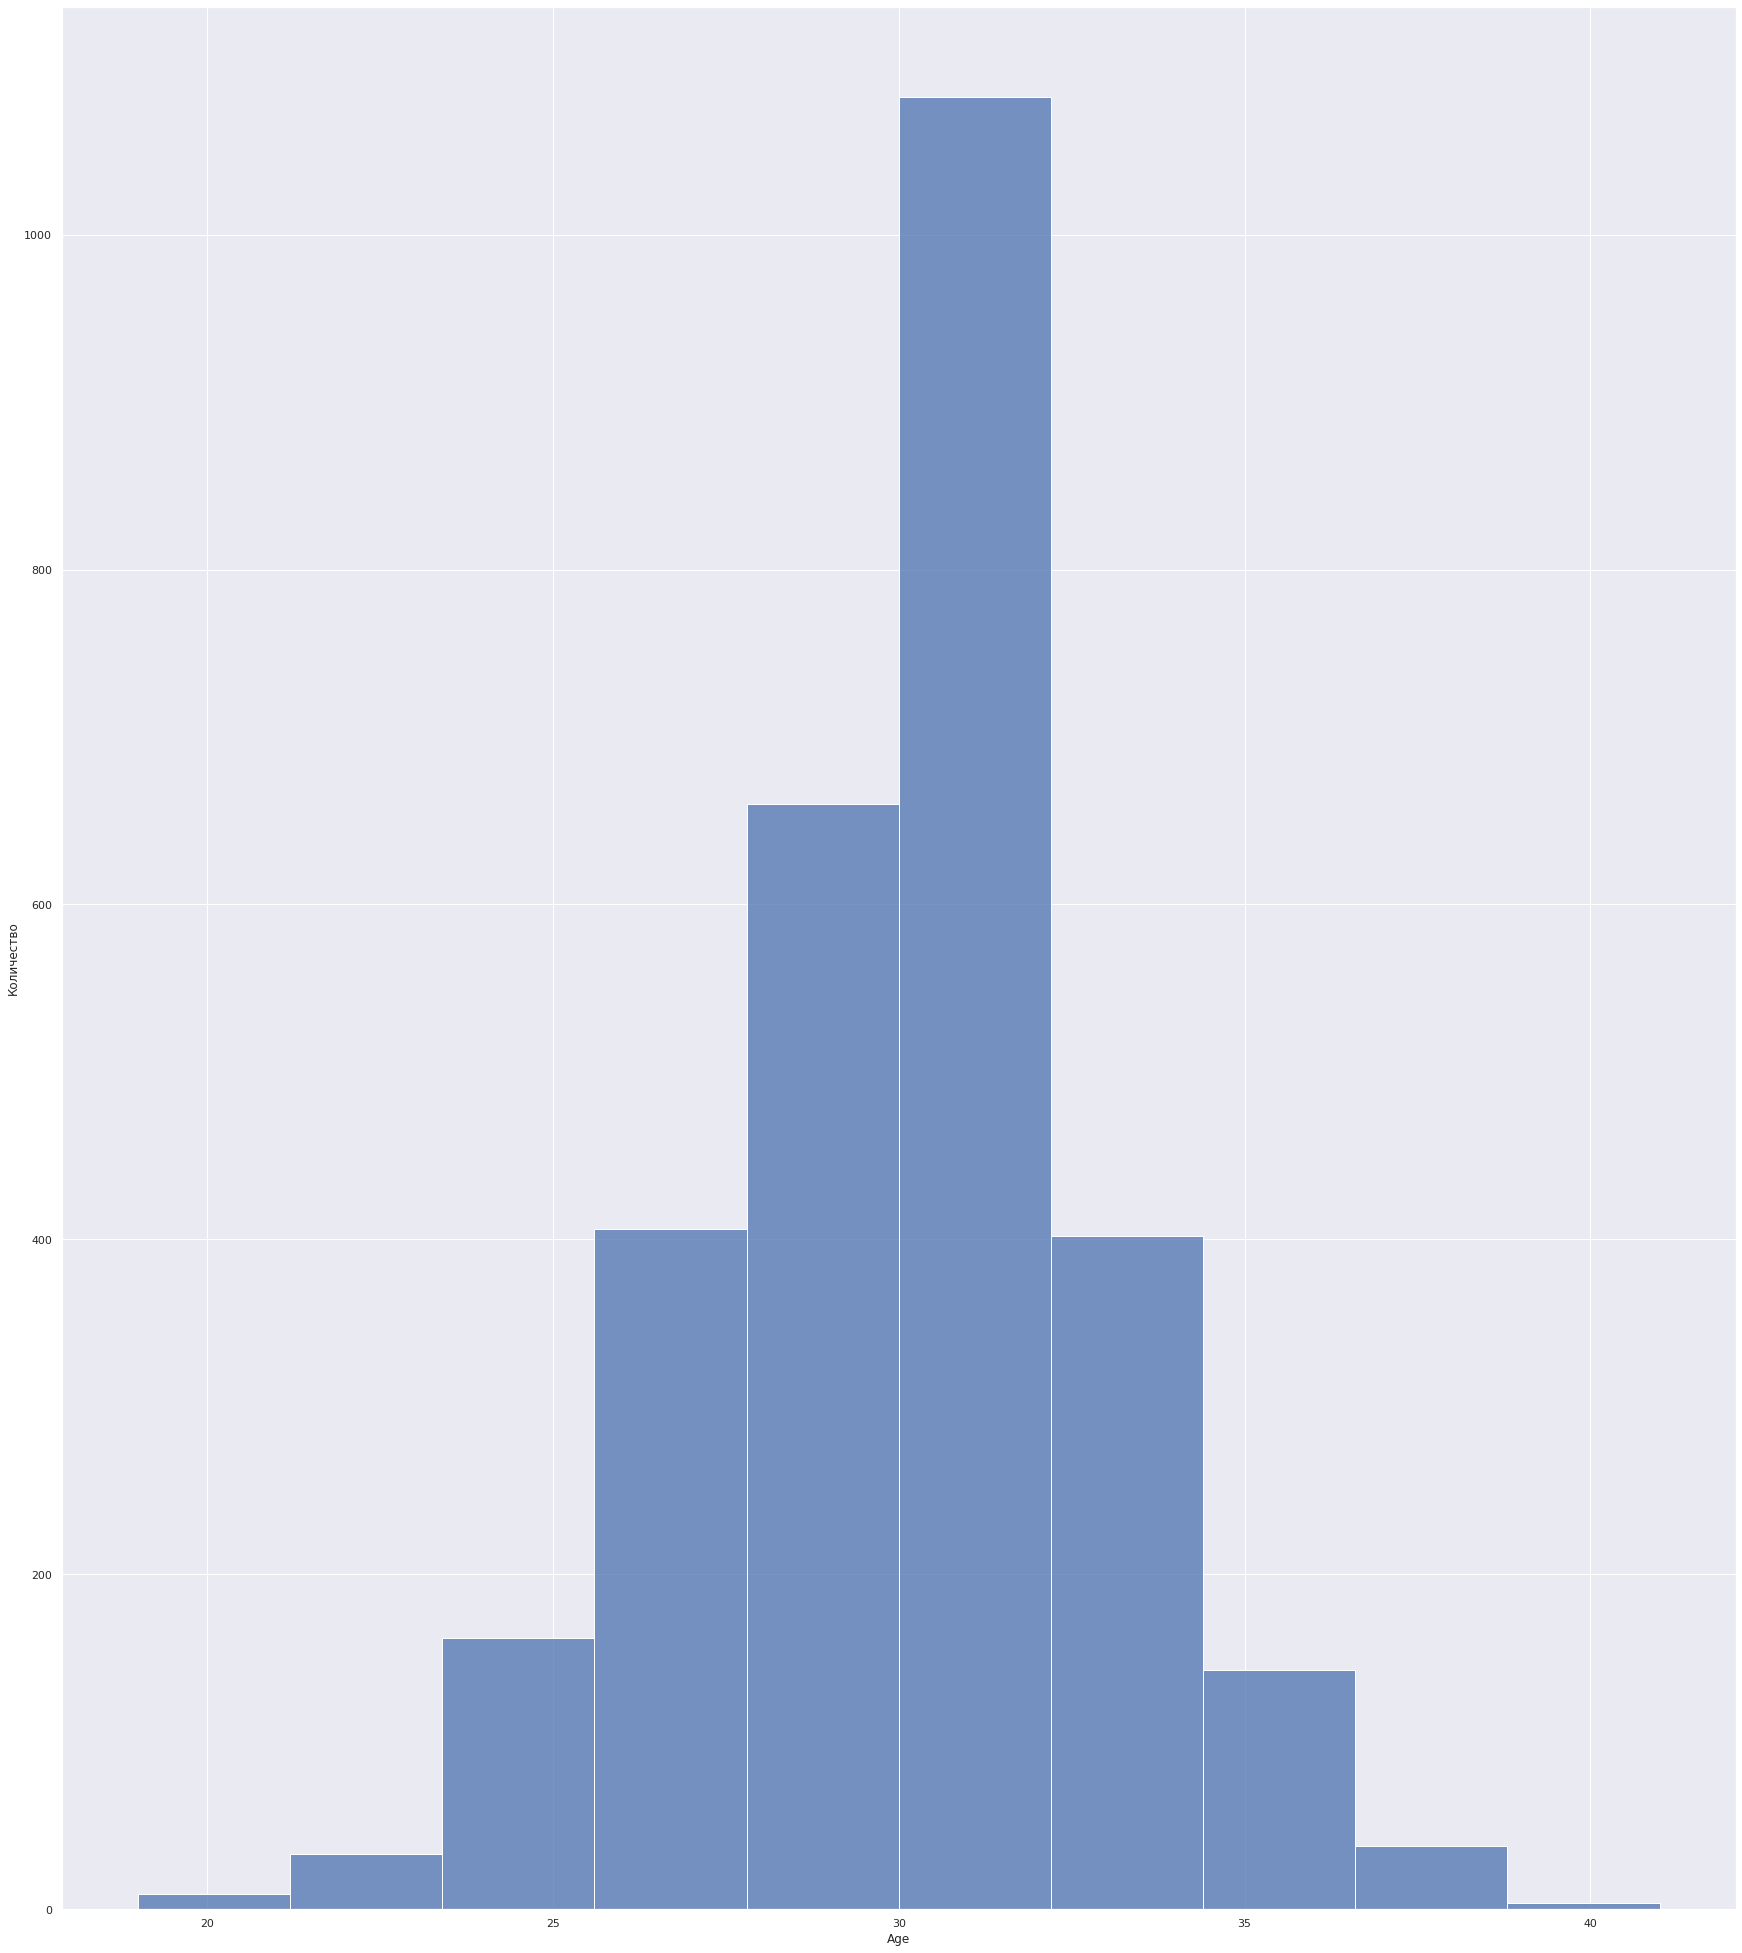

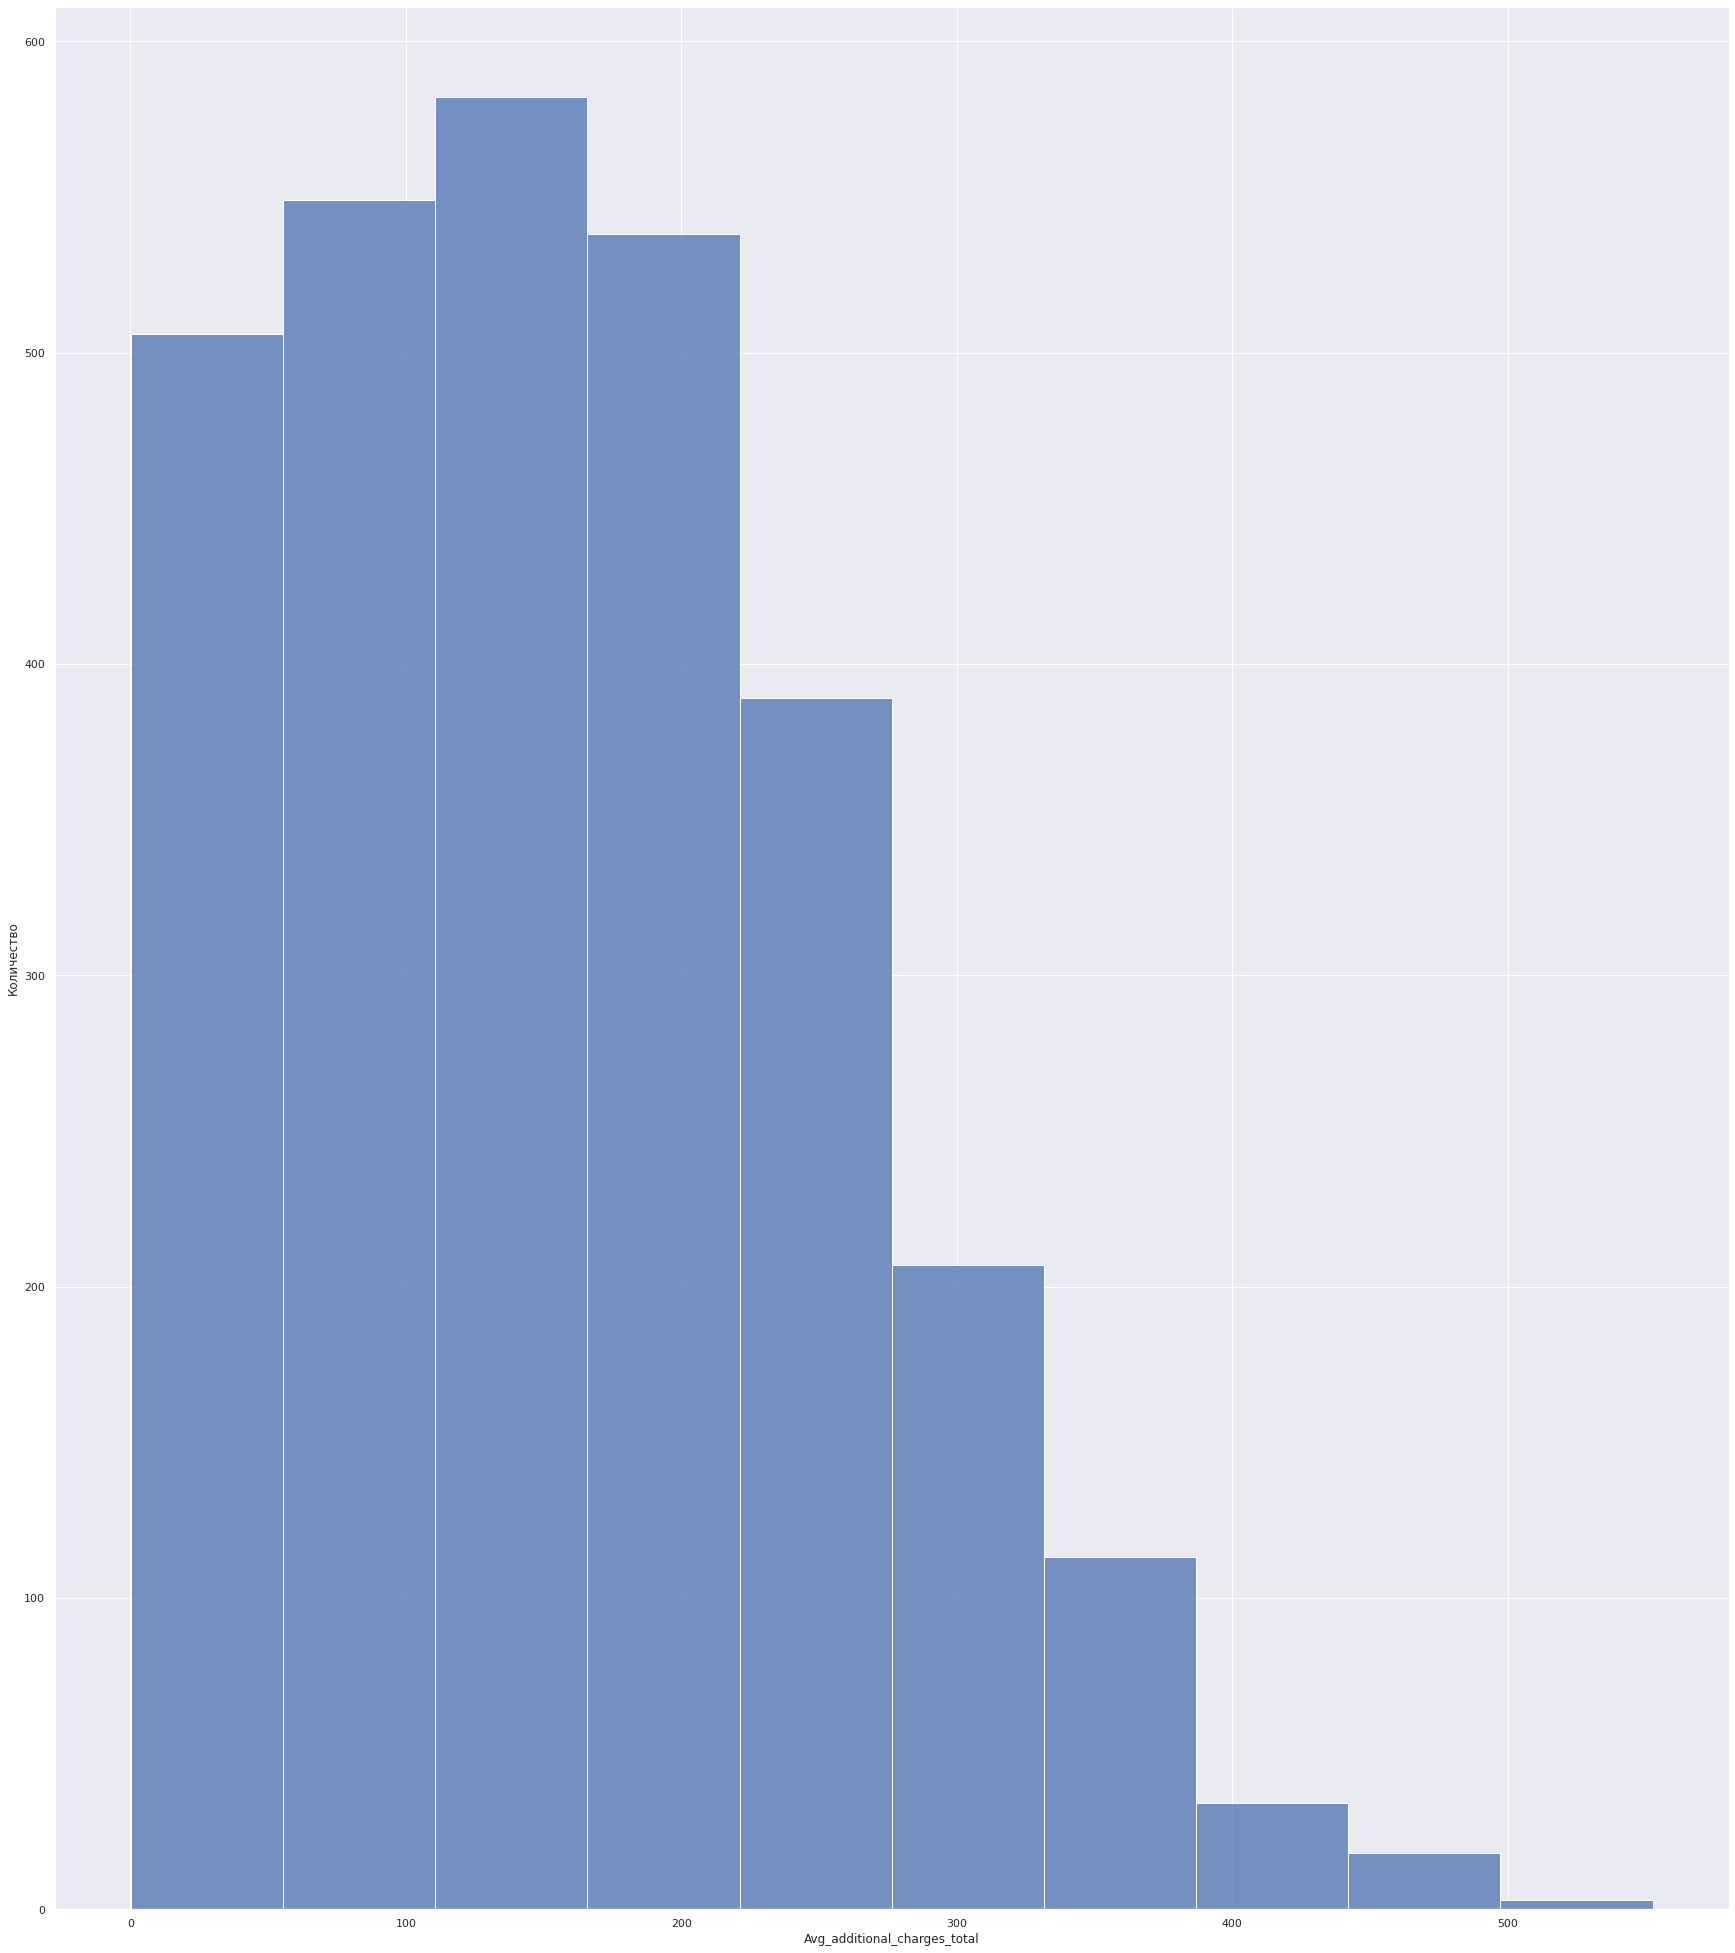

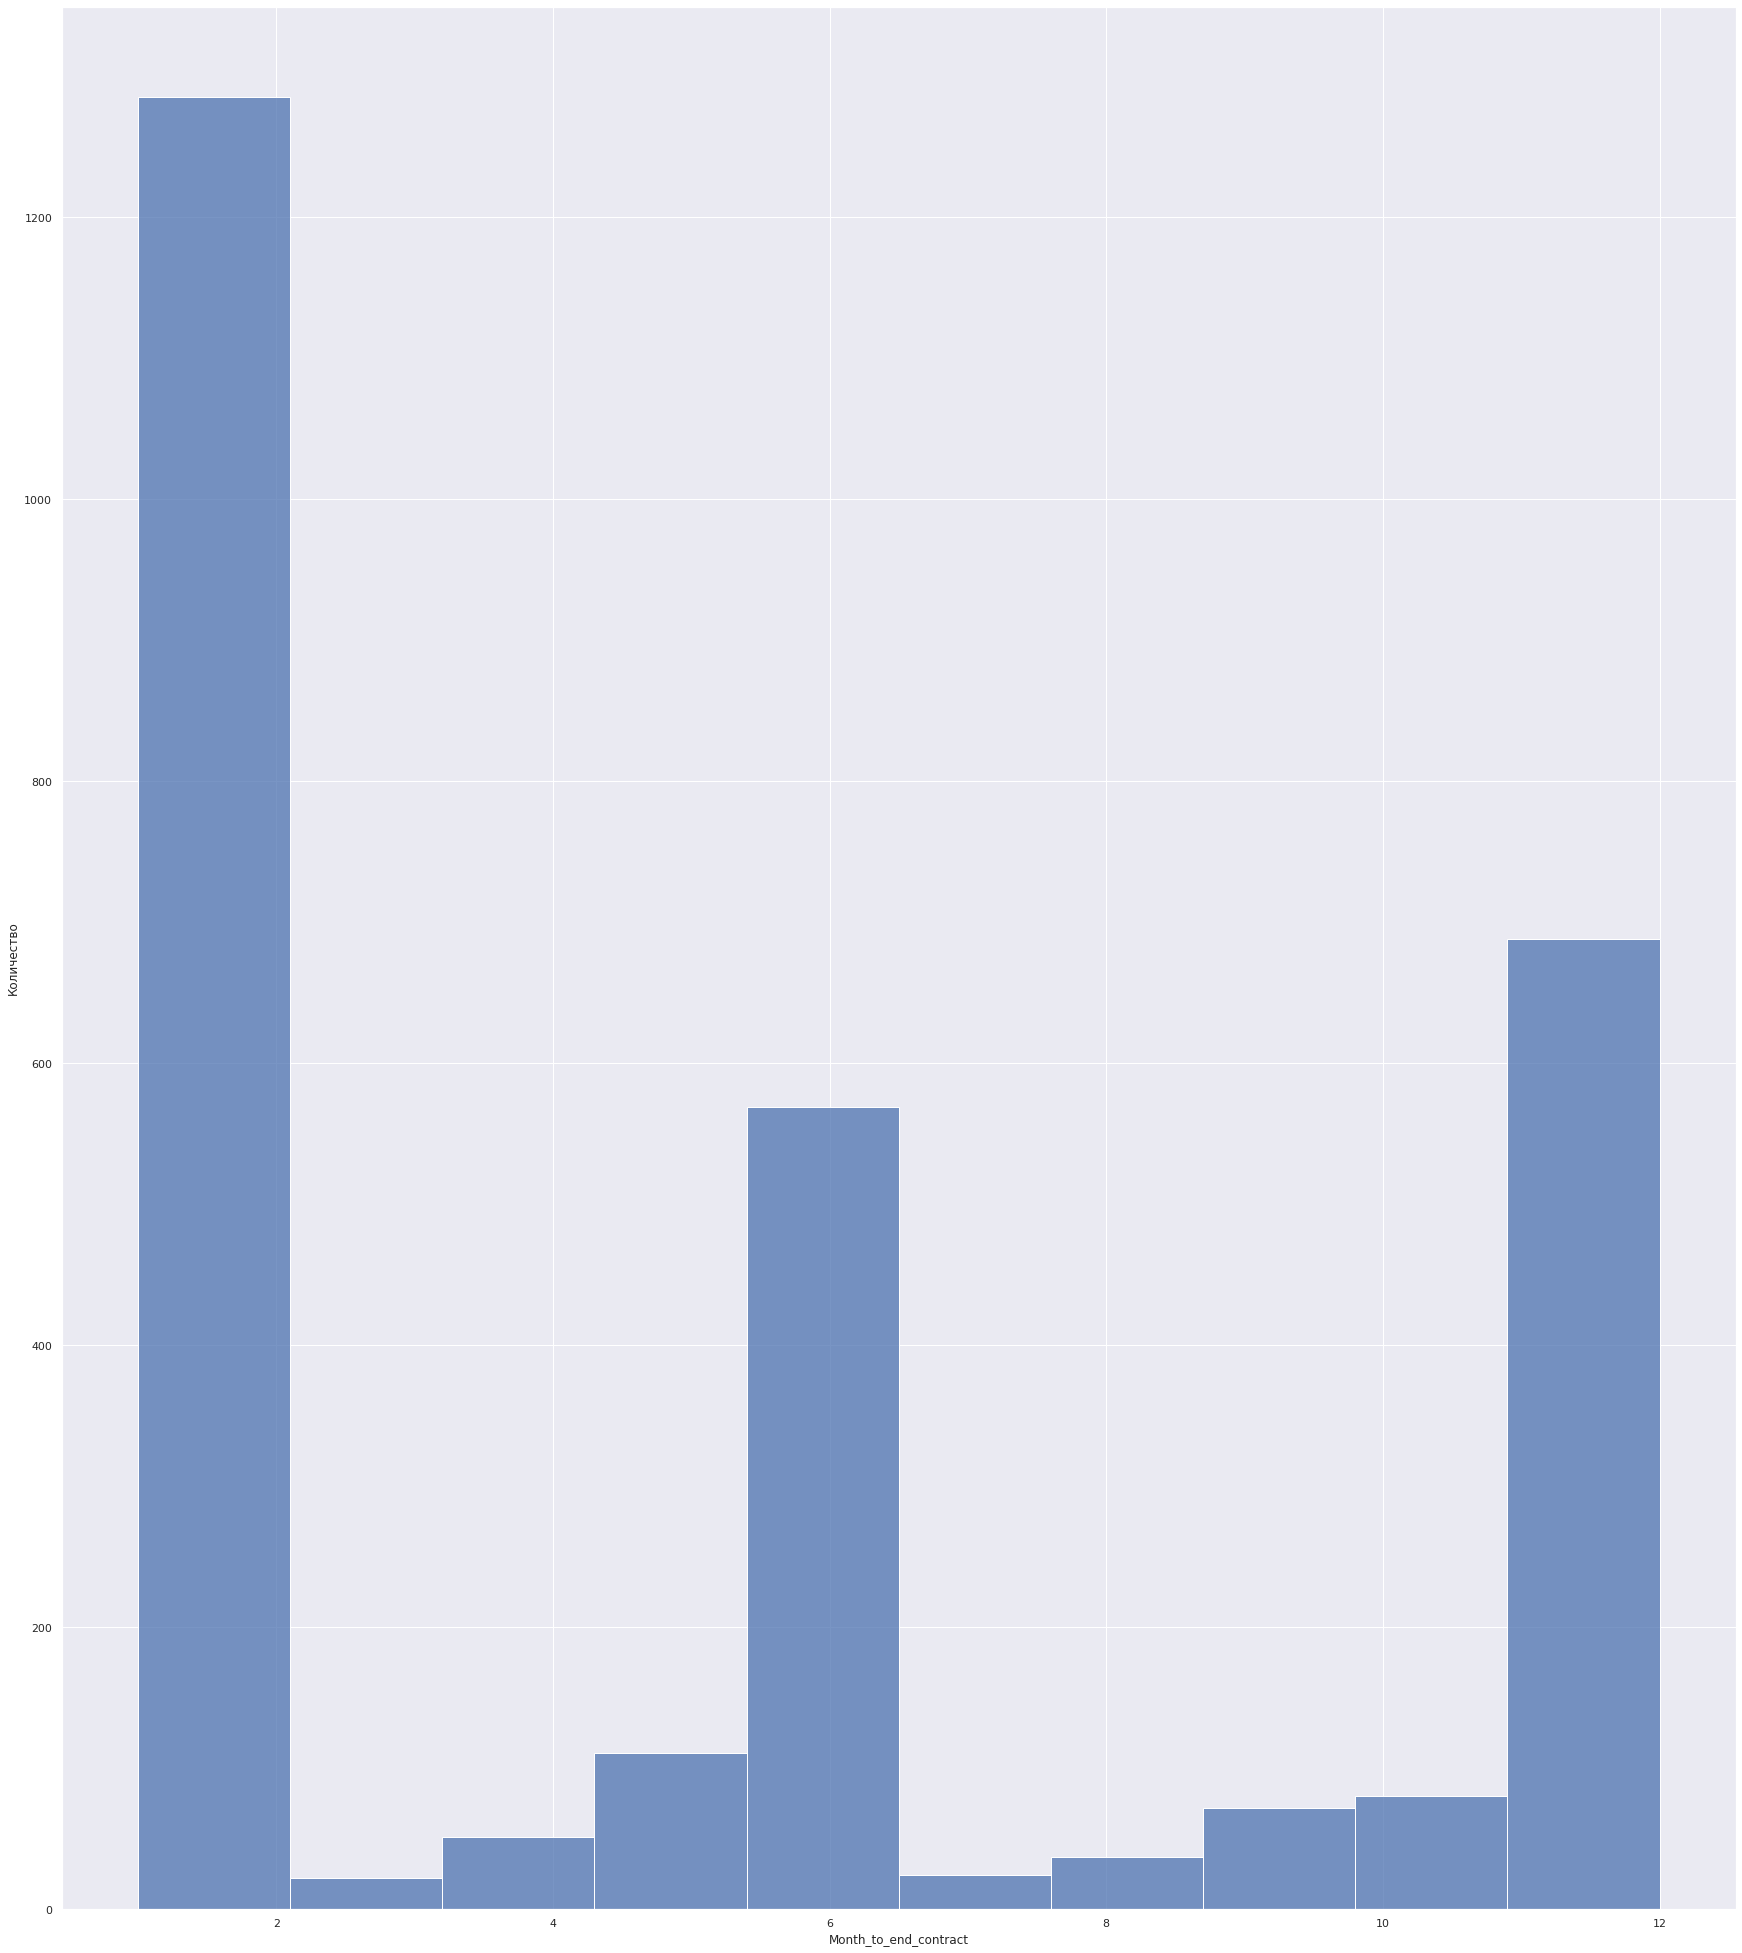

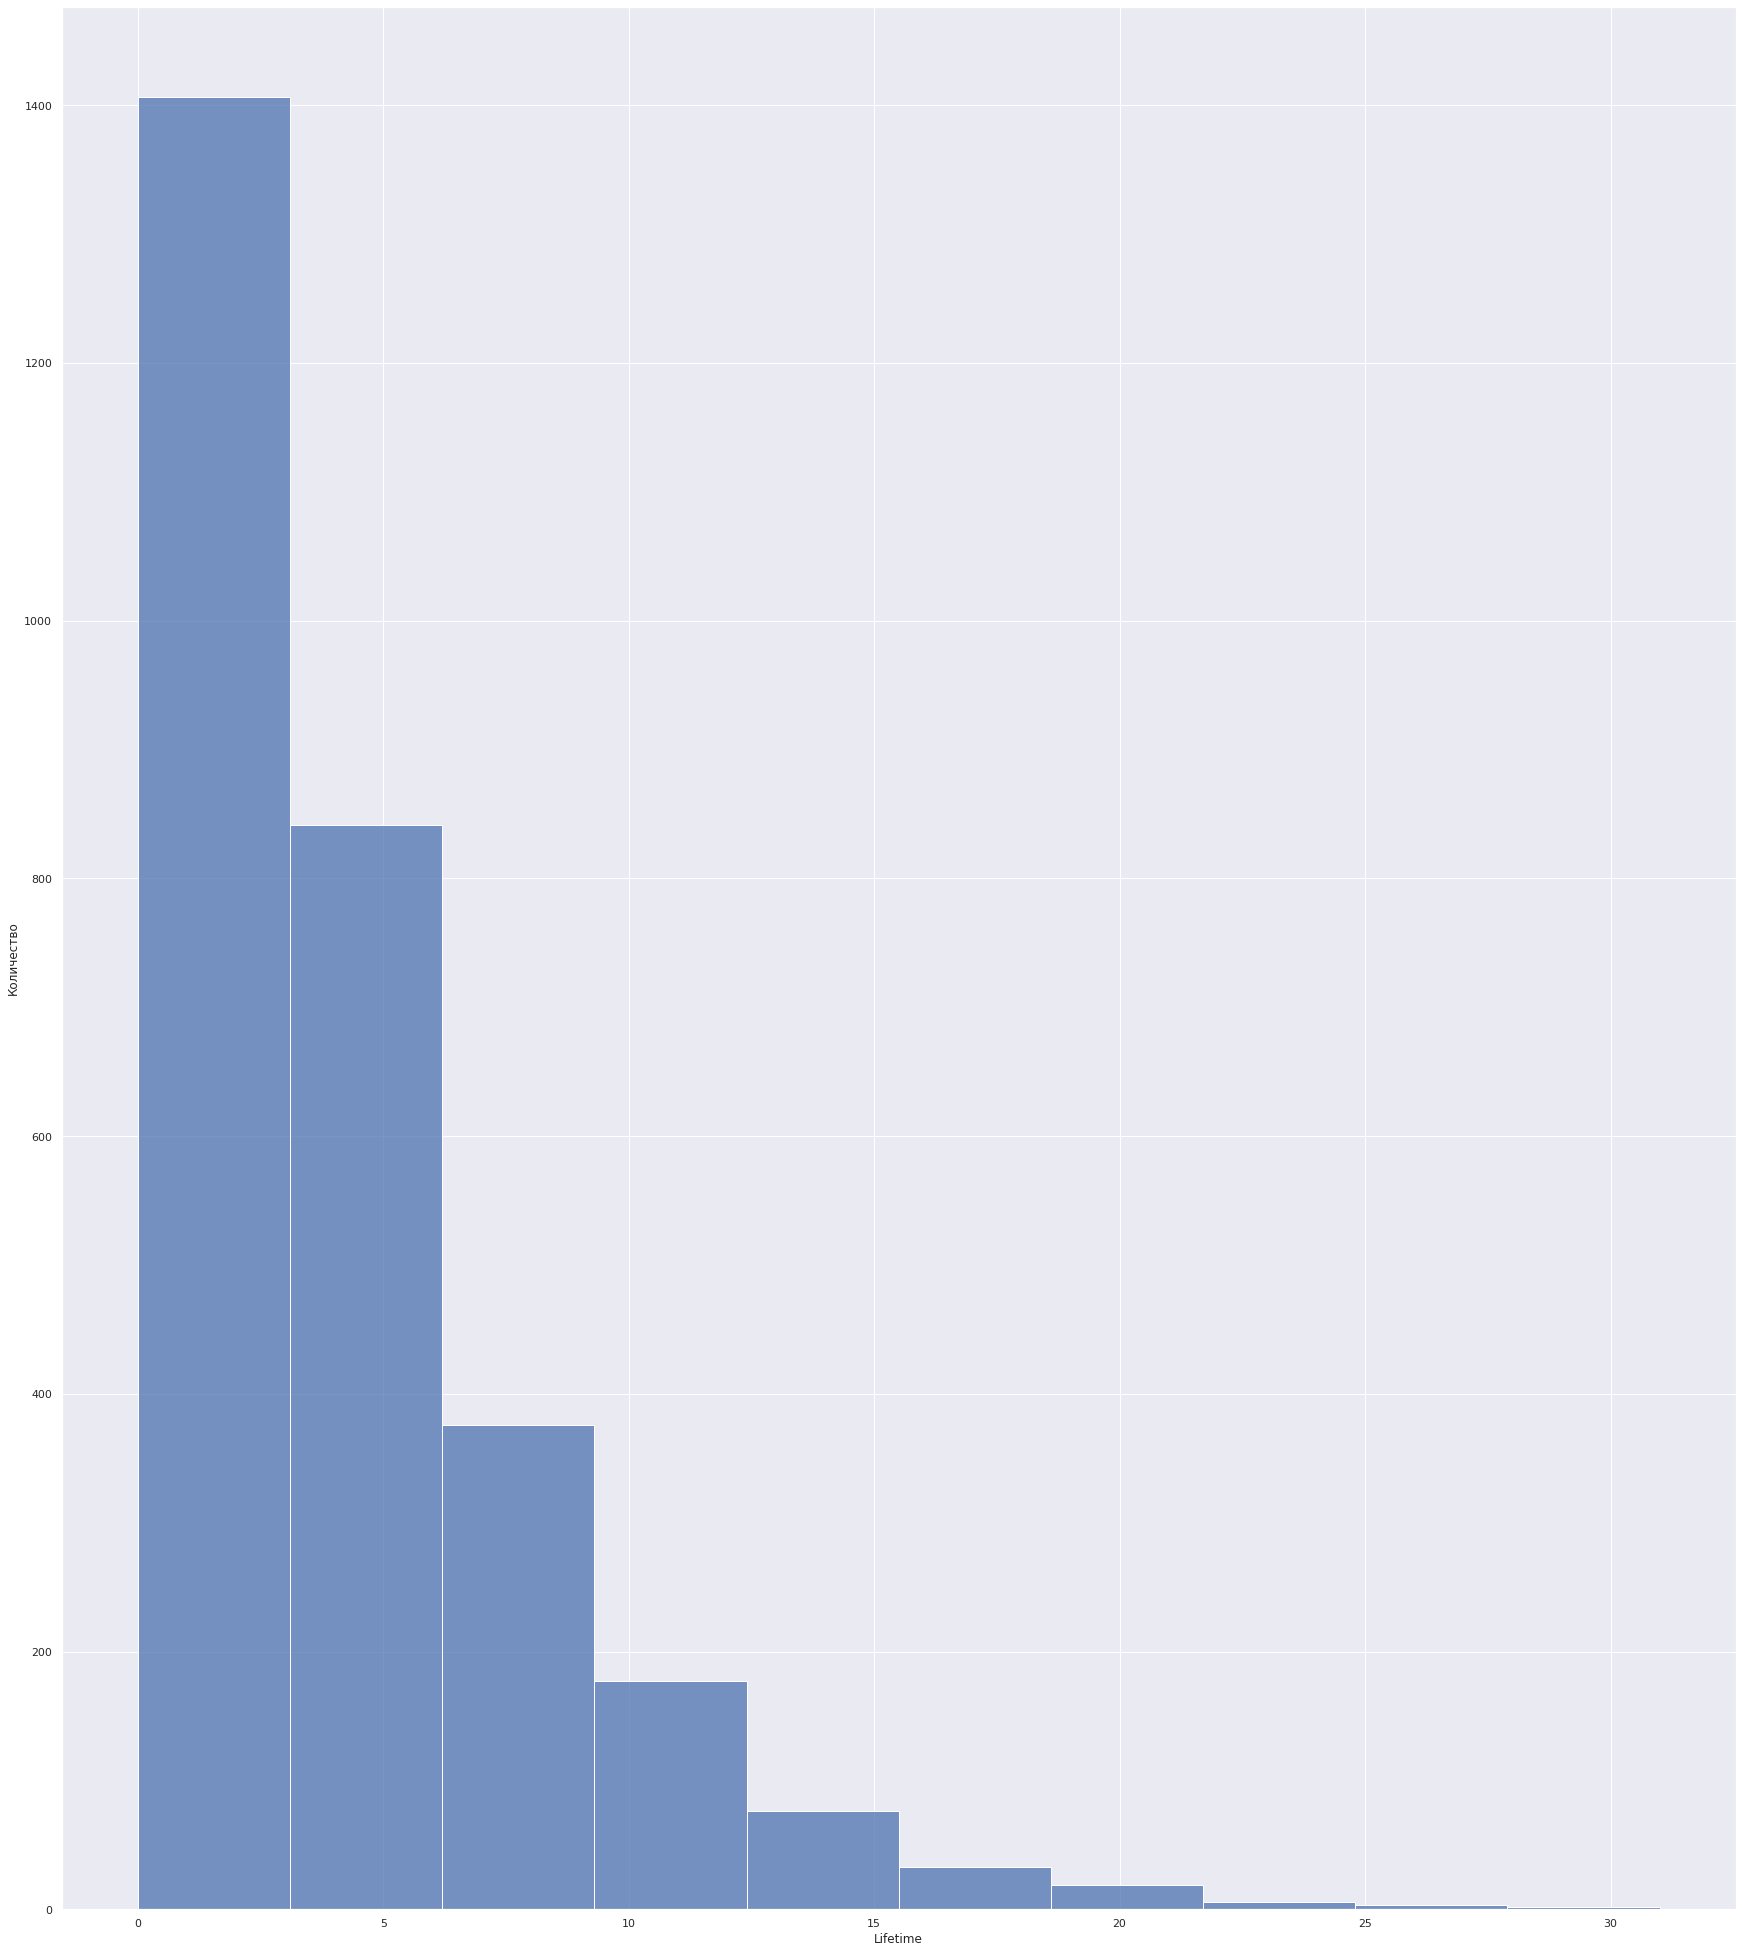

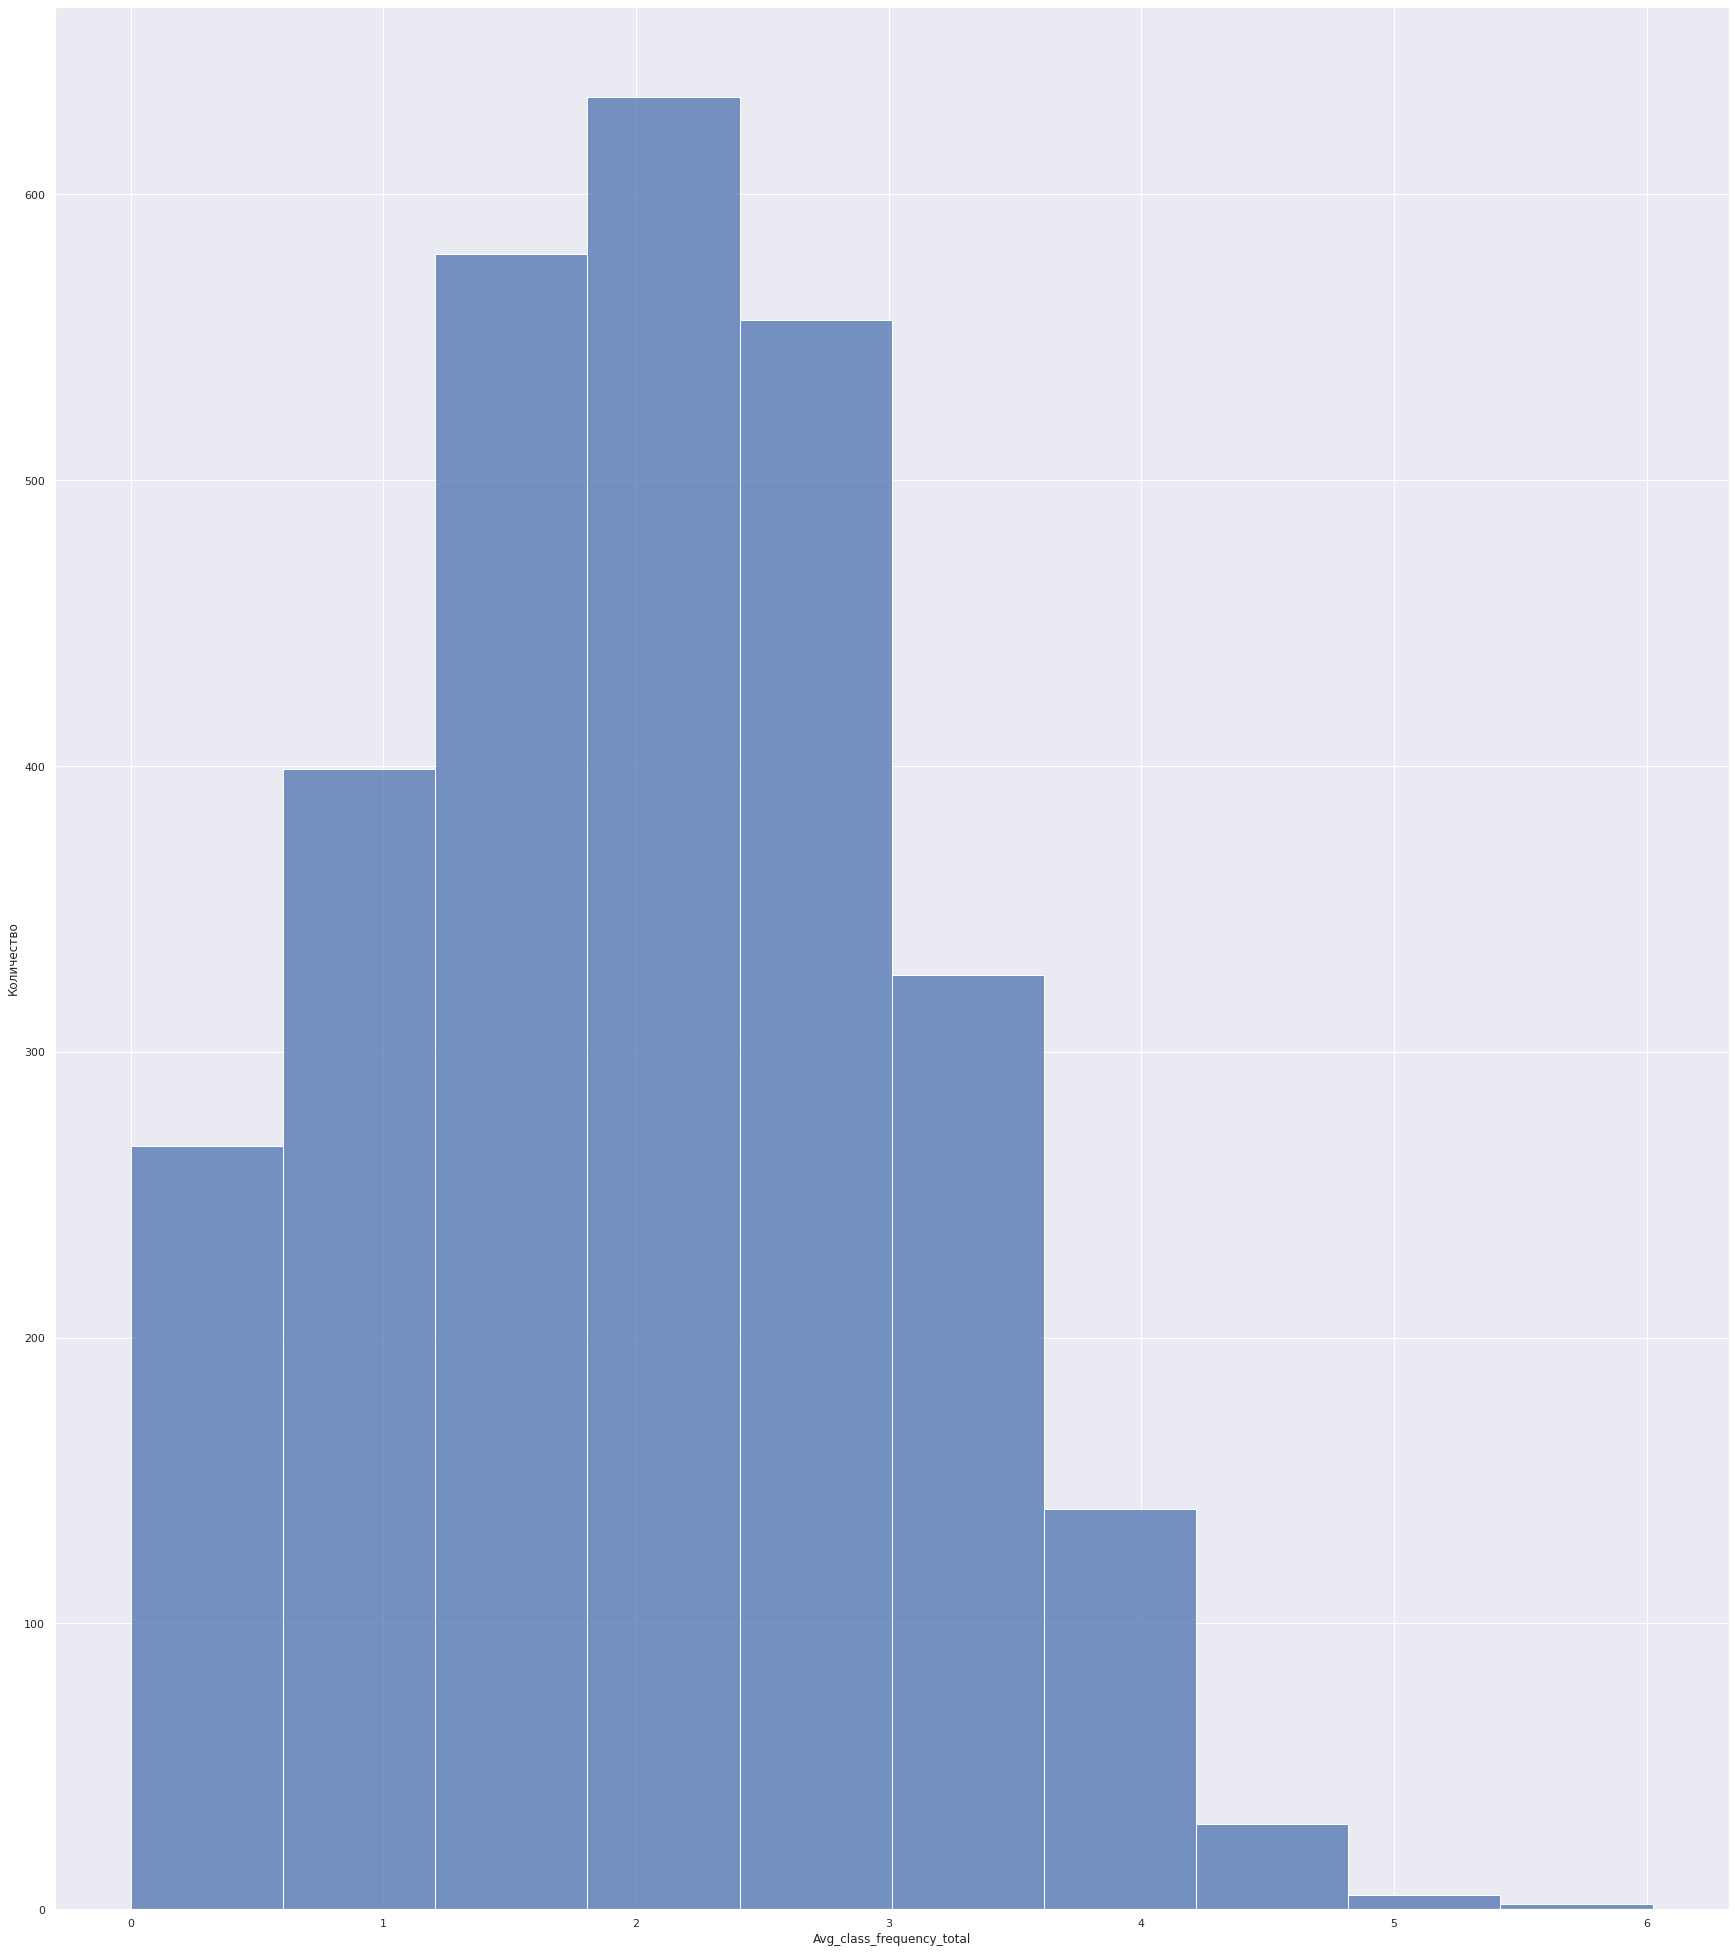

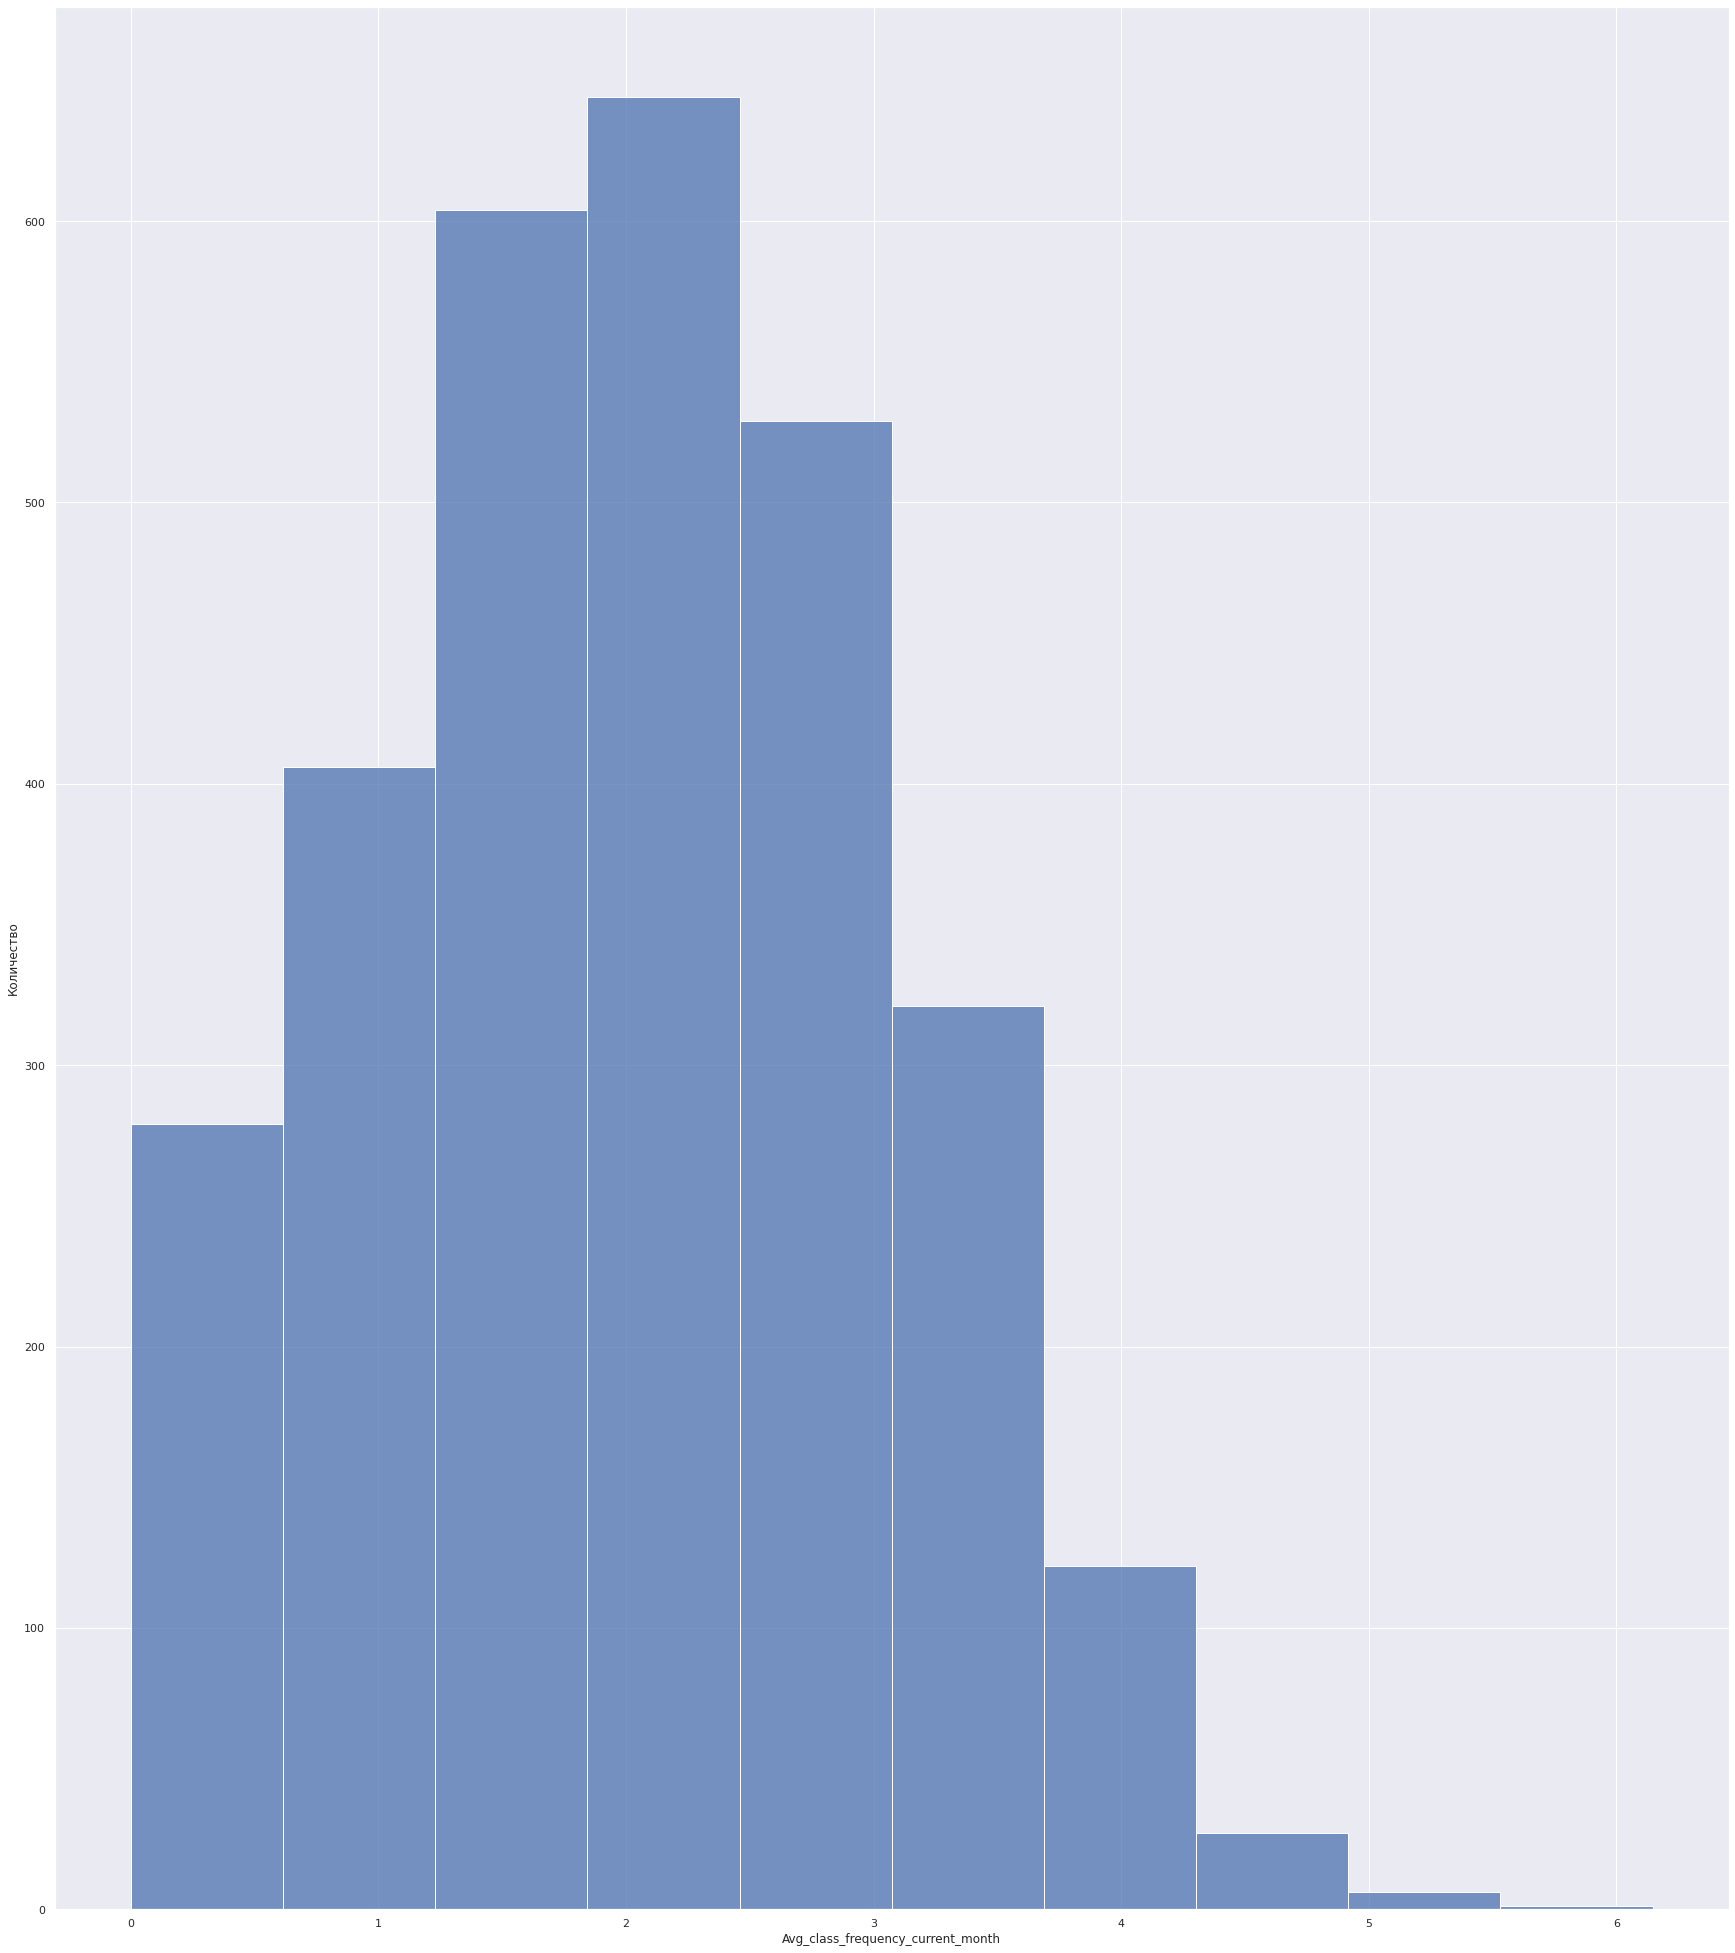

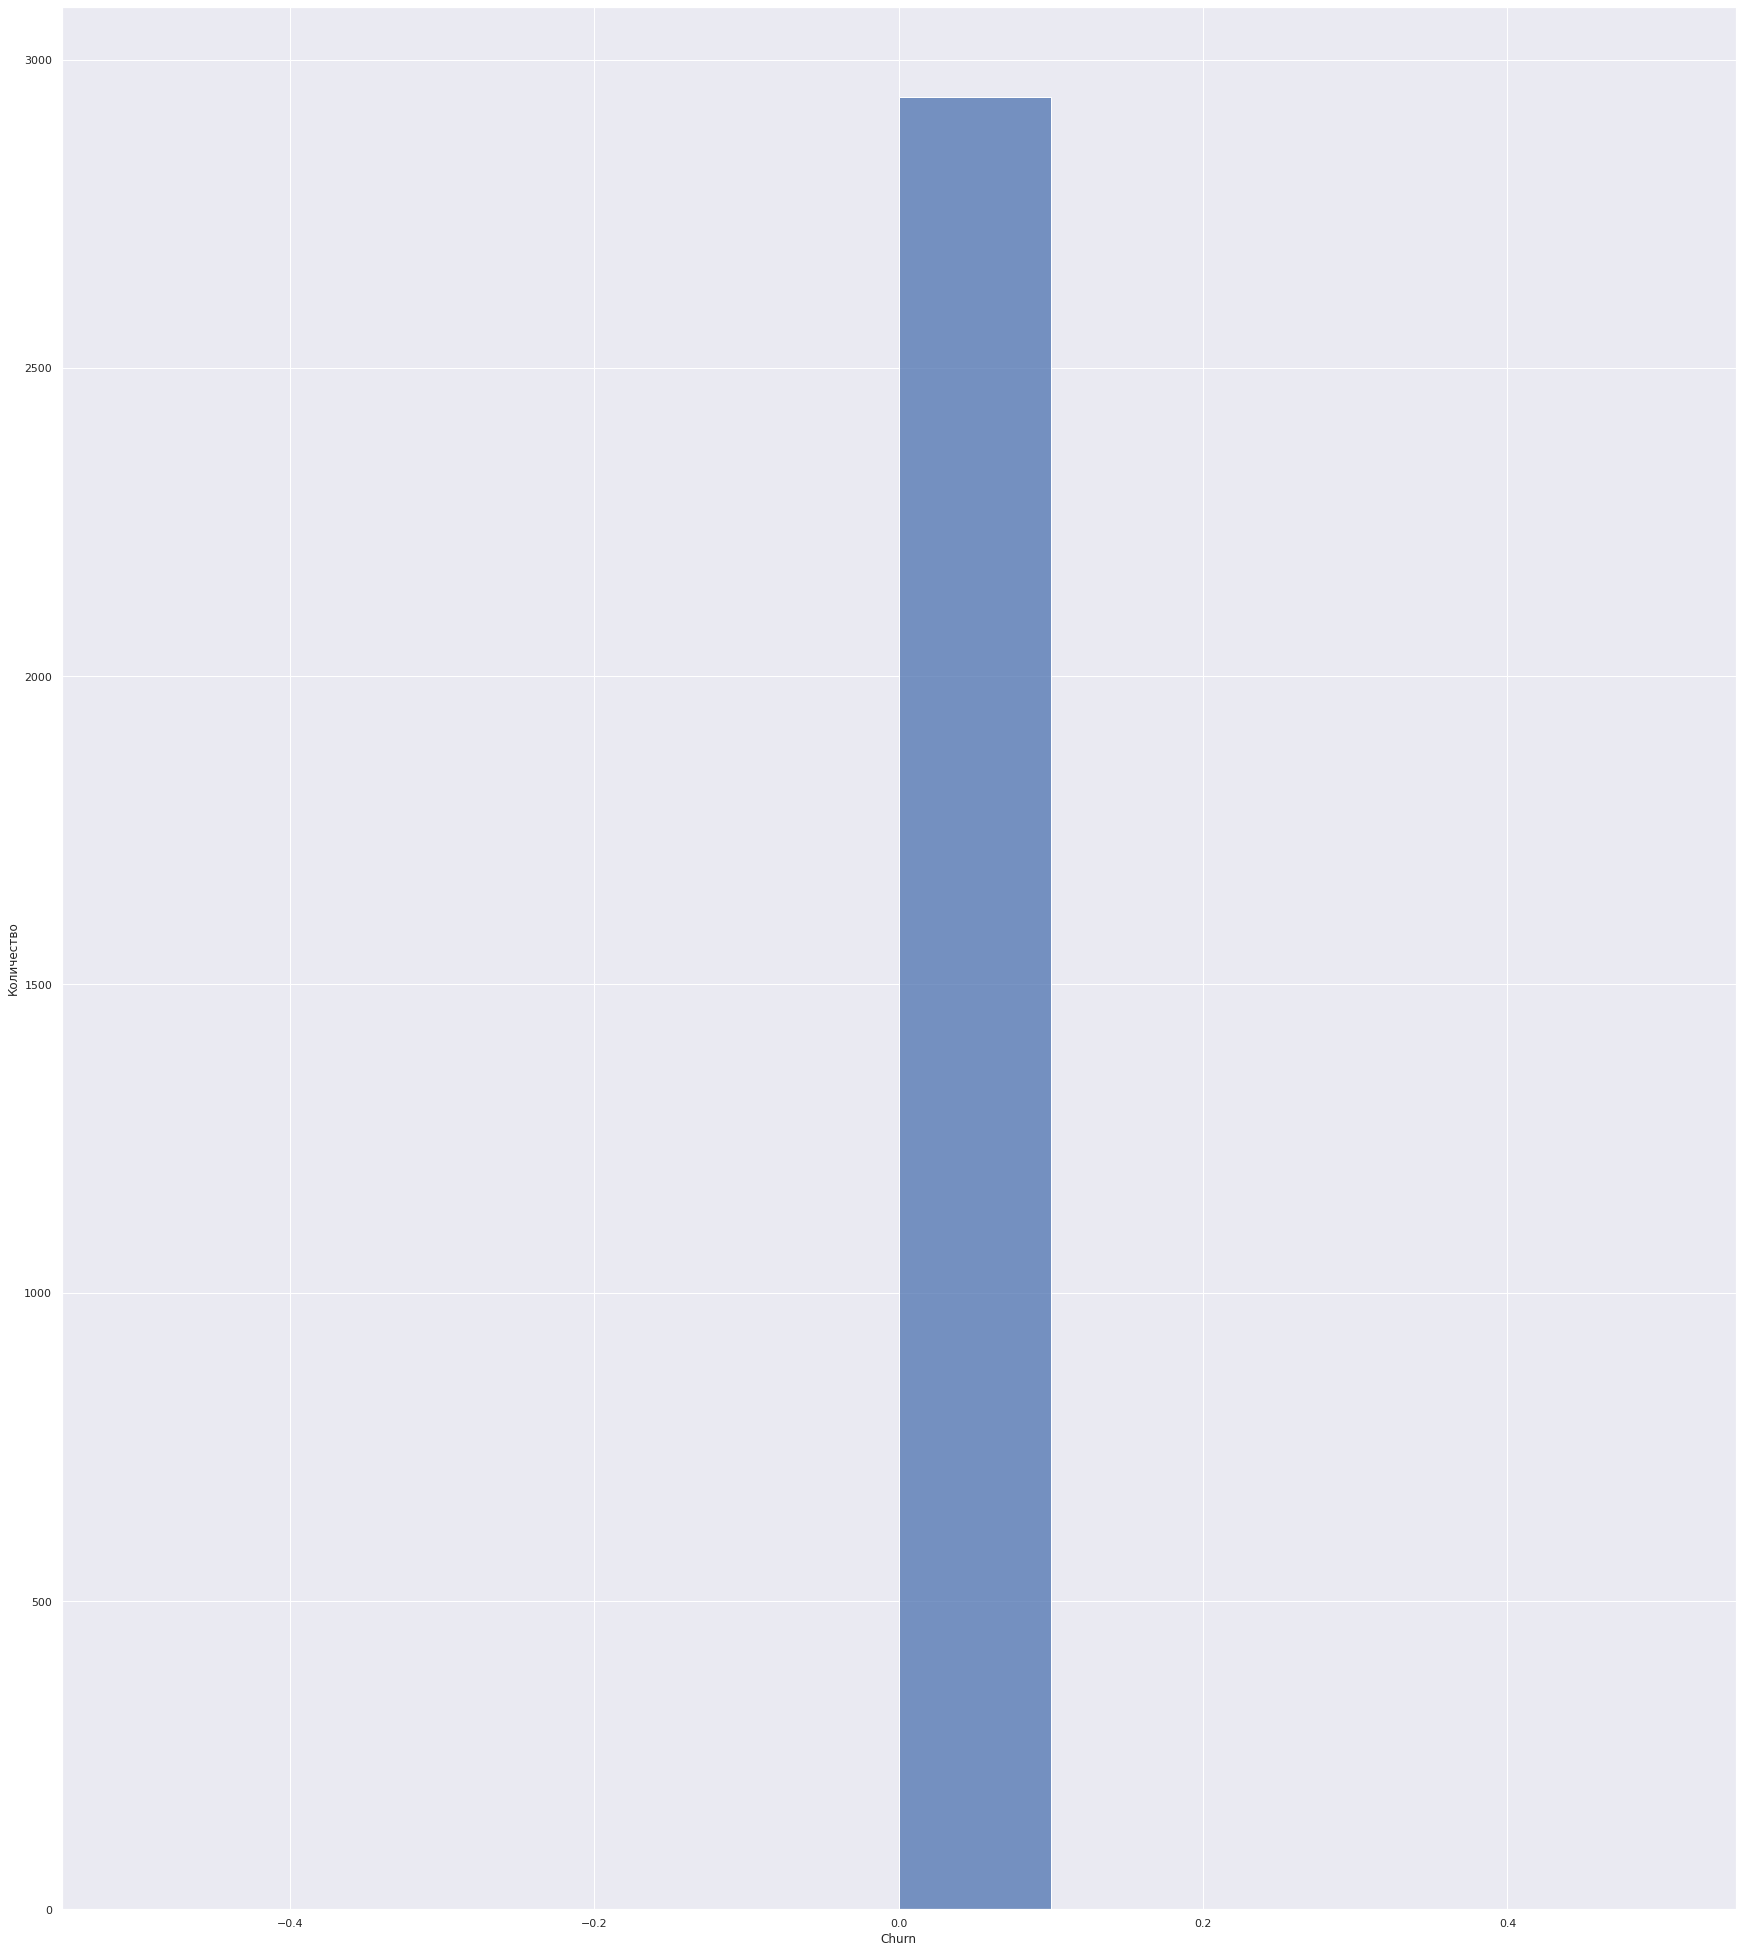

In [34]:
for feature in df.query('Churn == 0').columns:
    p = sns.histplot(df.query('Churn == 0')[feature], bins=10)
    p.set_ylabel('Количество', fontsize = 12)
    plt.show() 

**Выводы по посетителям, которые продолжили заниматься:**
- Преобладает гендер 1
- Преолбадает количество тех, кто живет рядом с клубом

Группа, которая закончила заниматься:

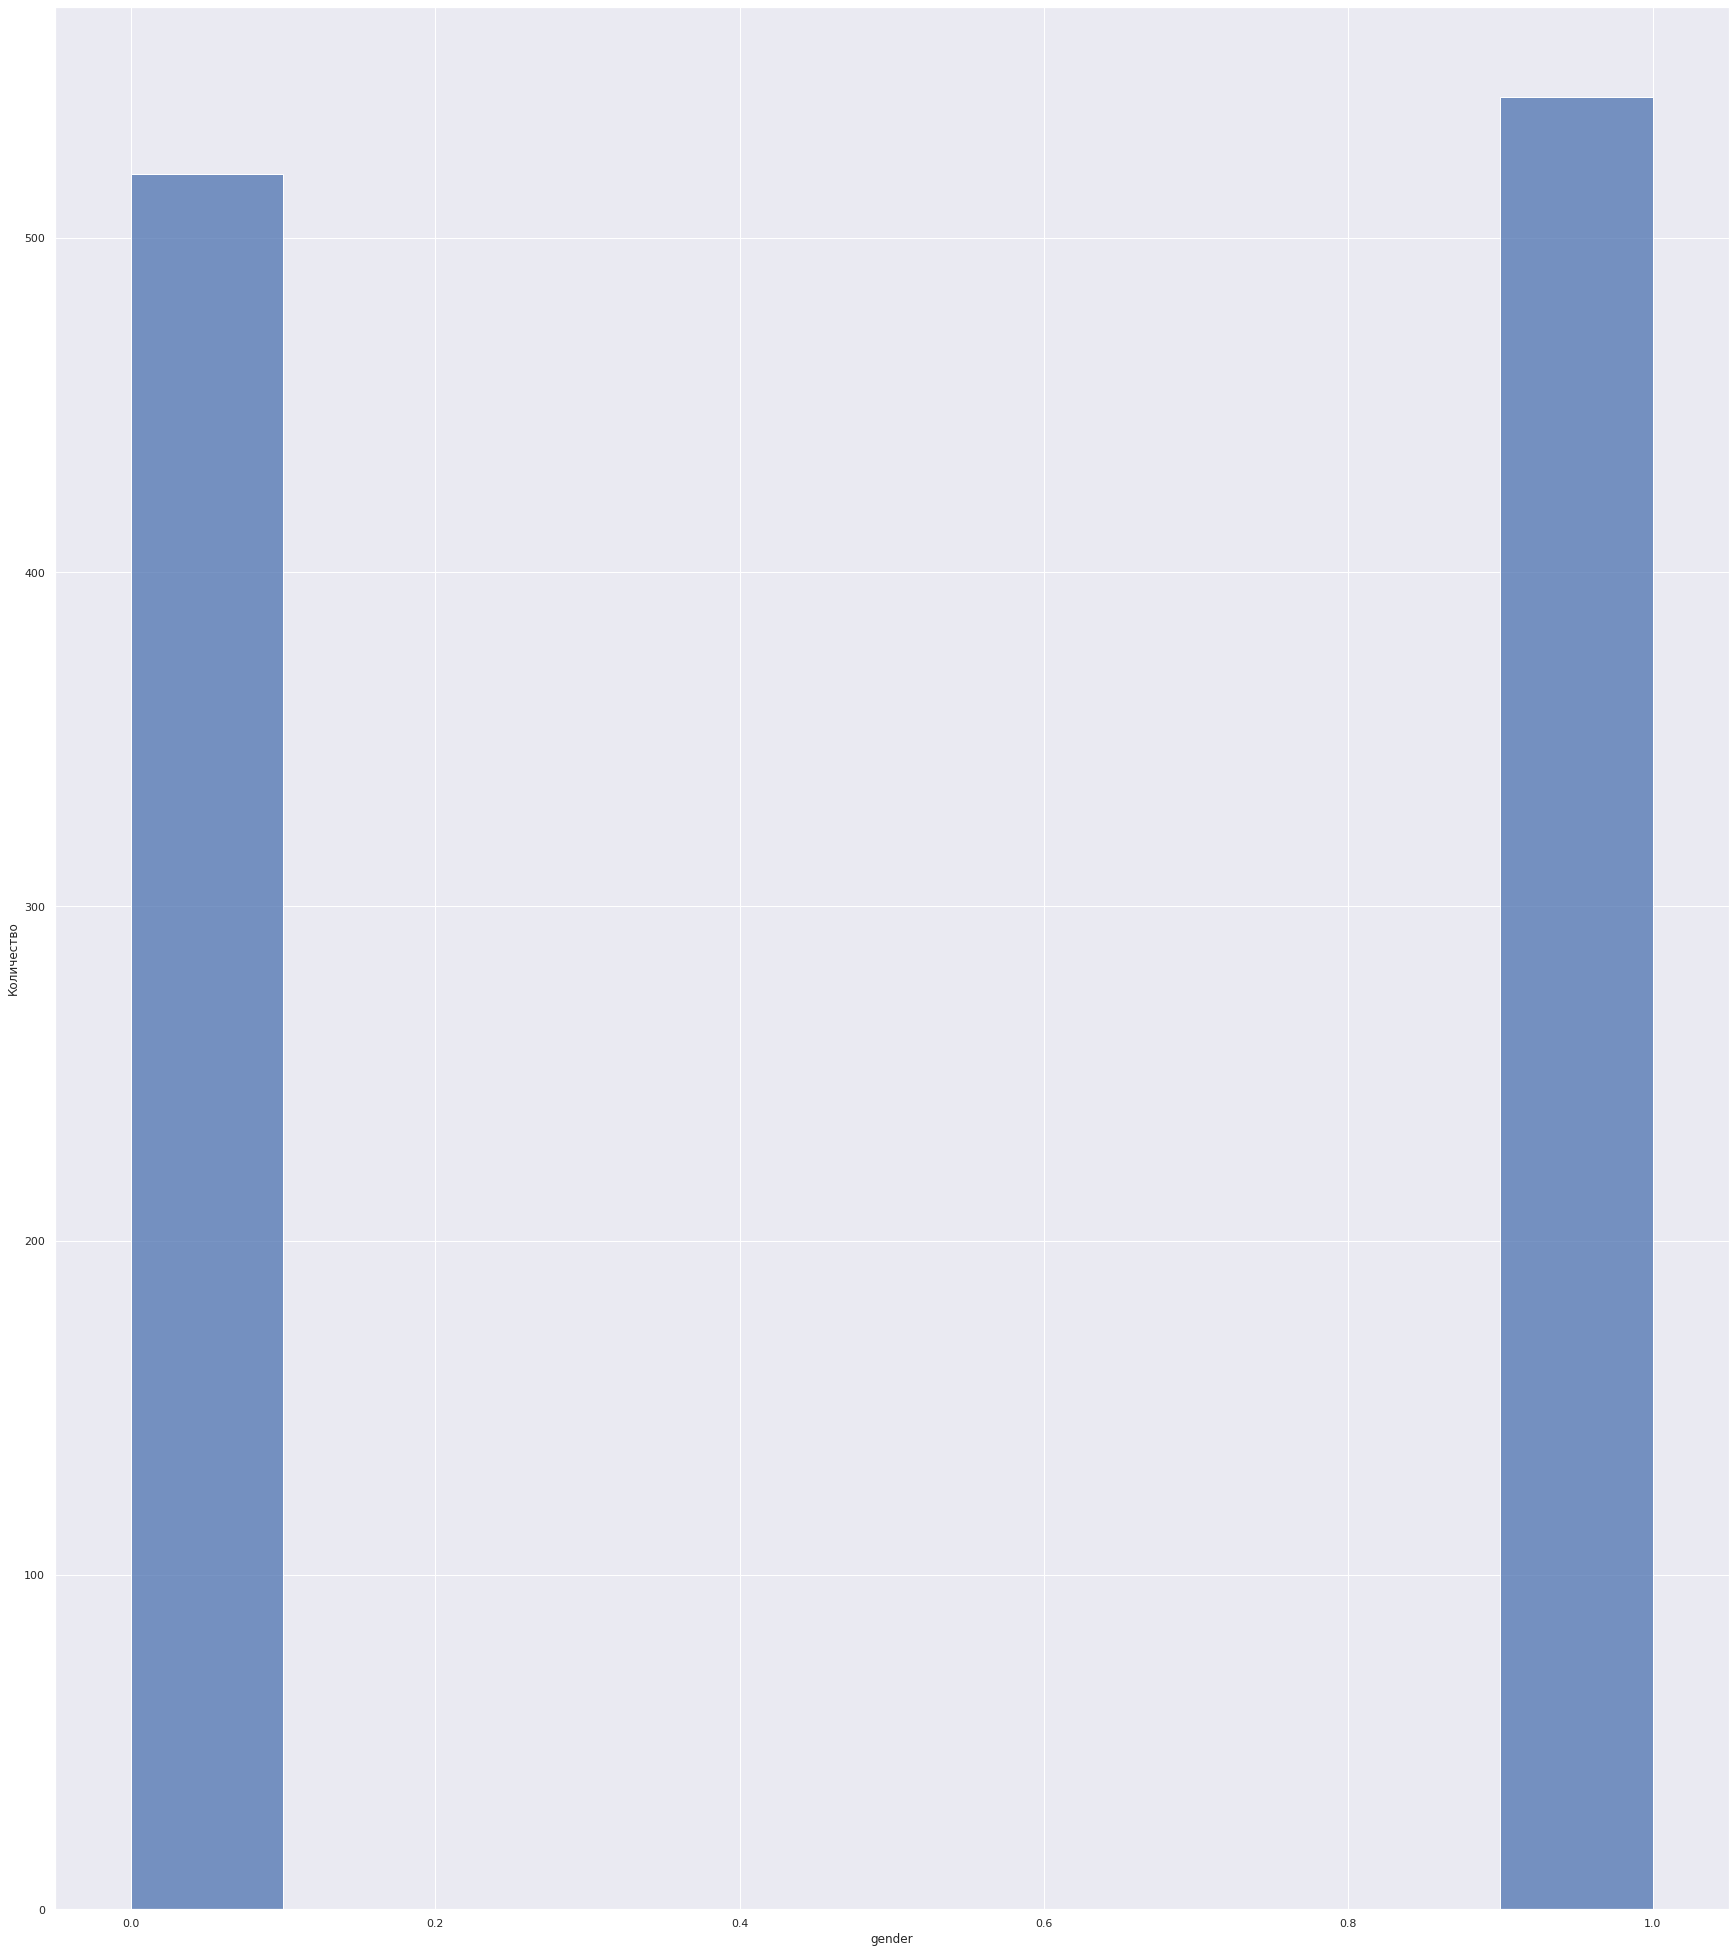

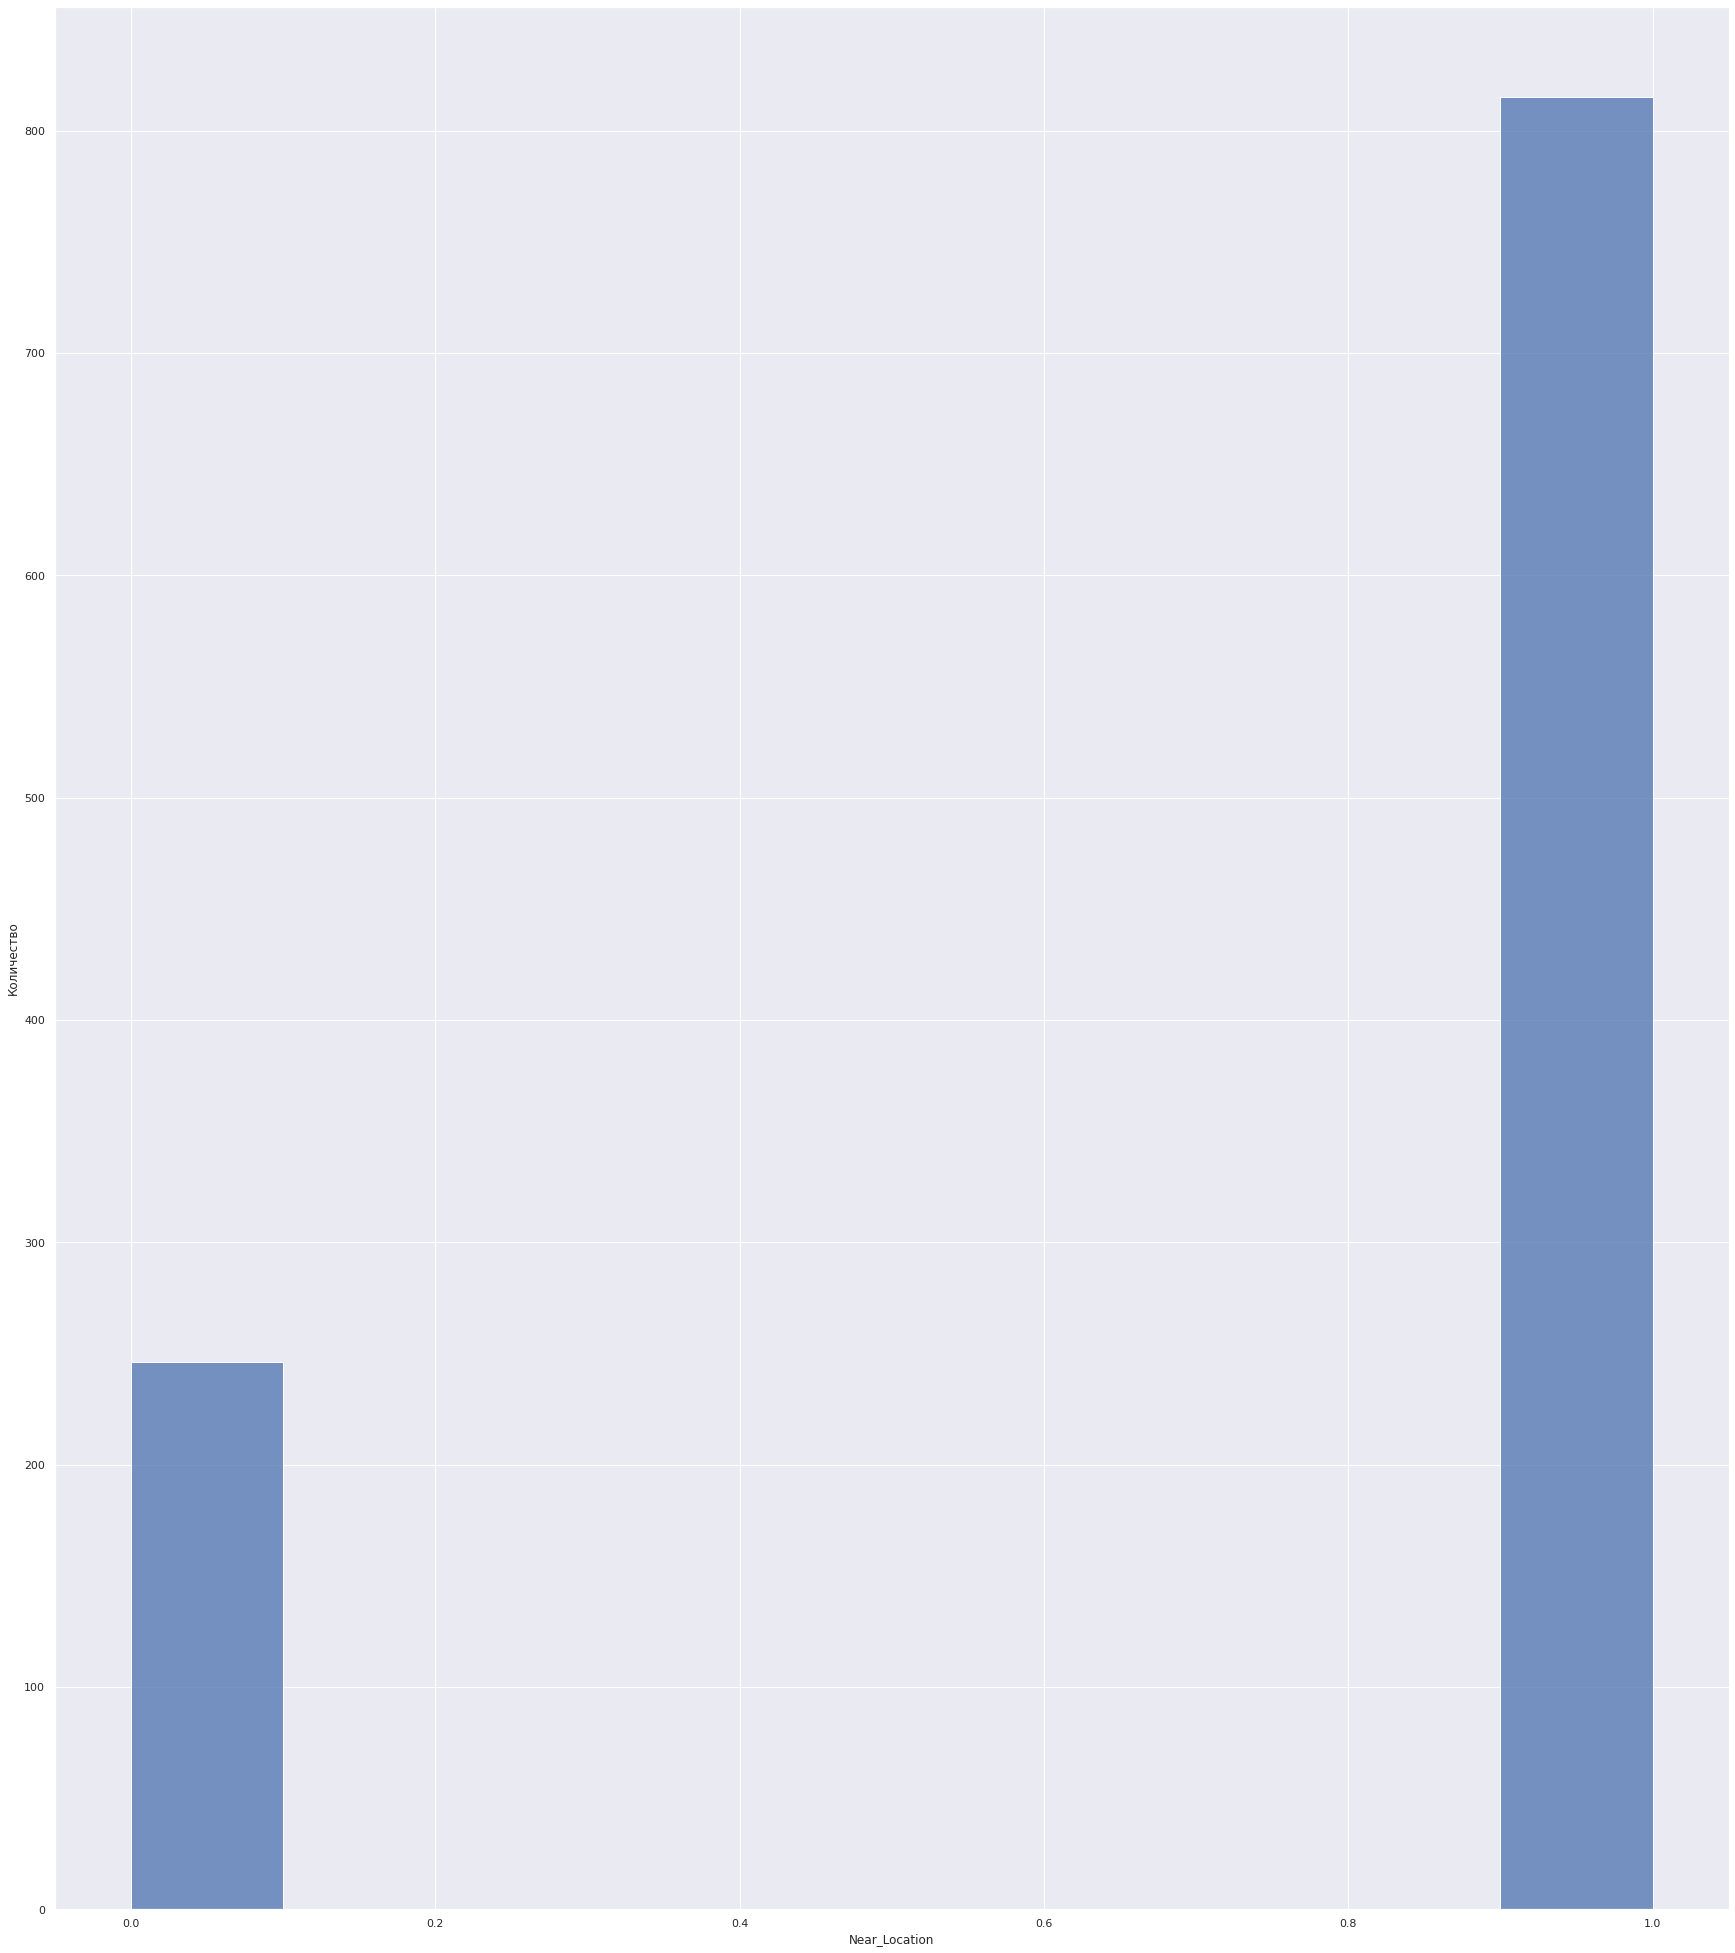

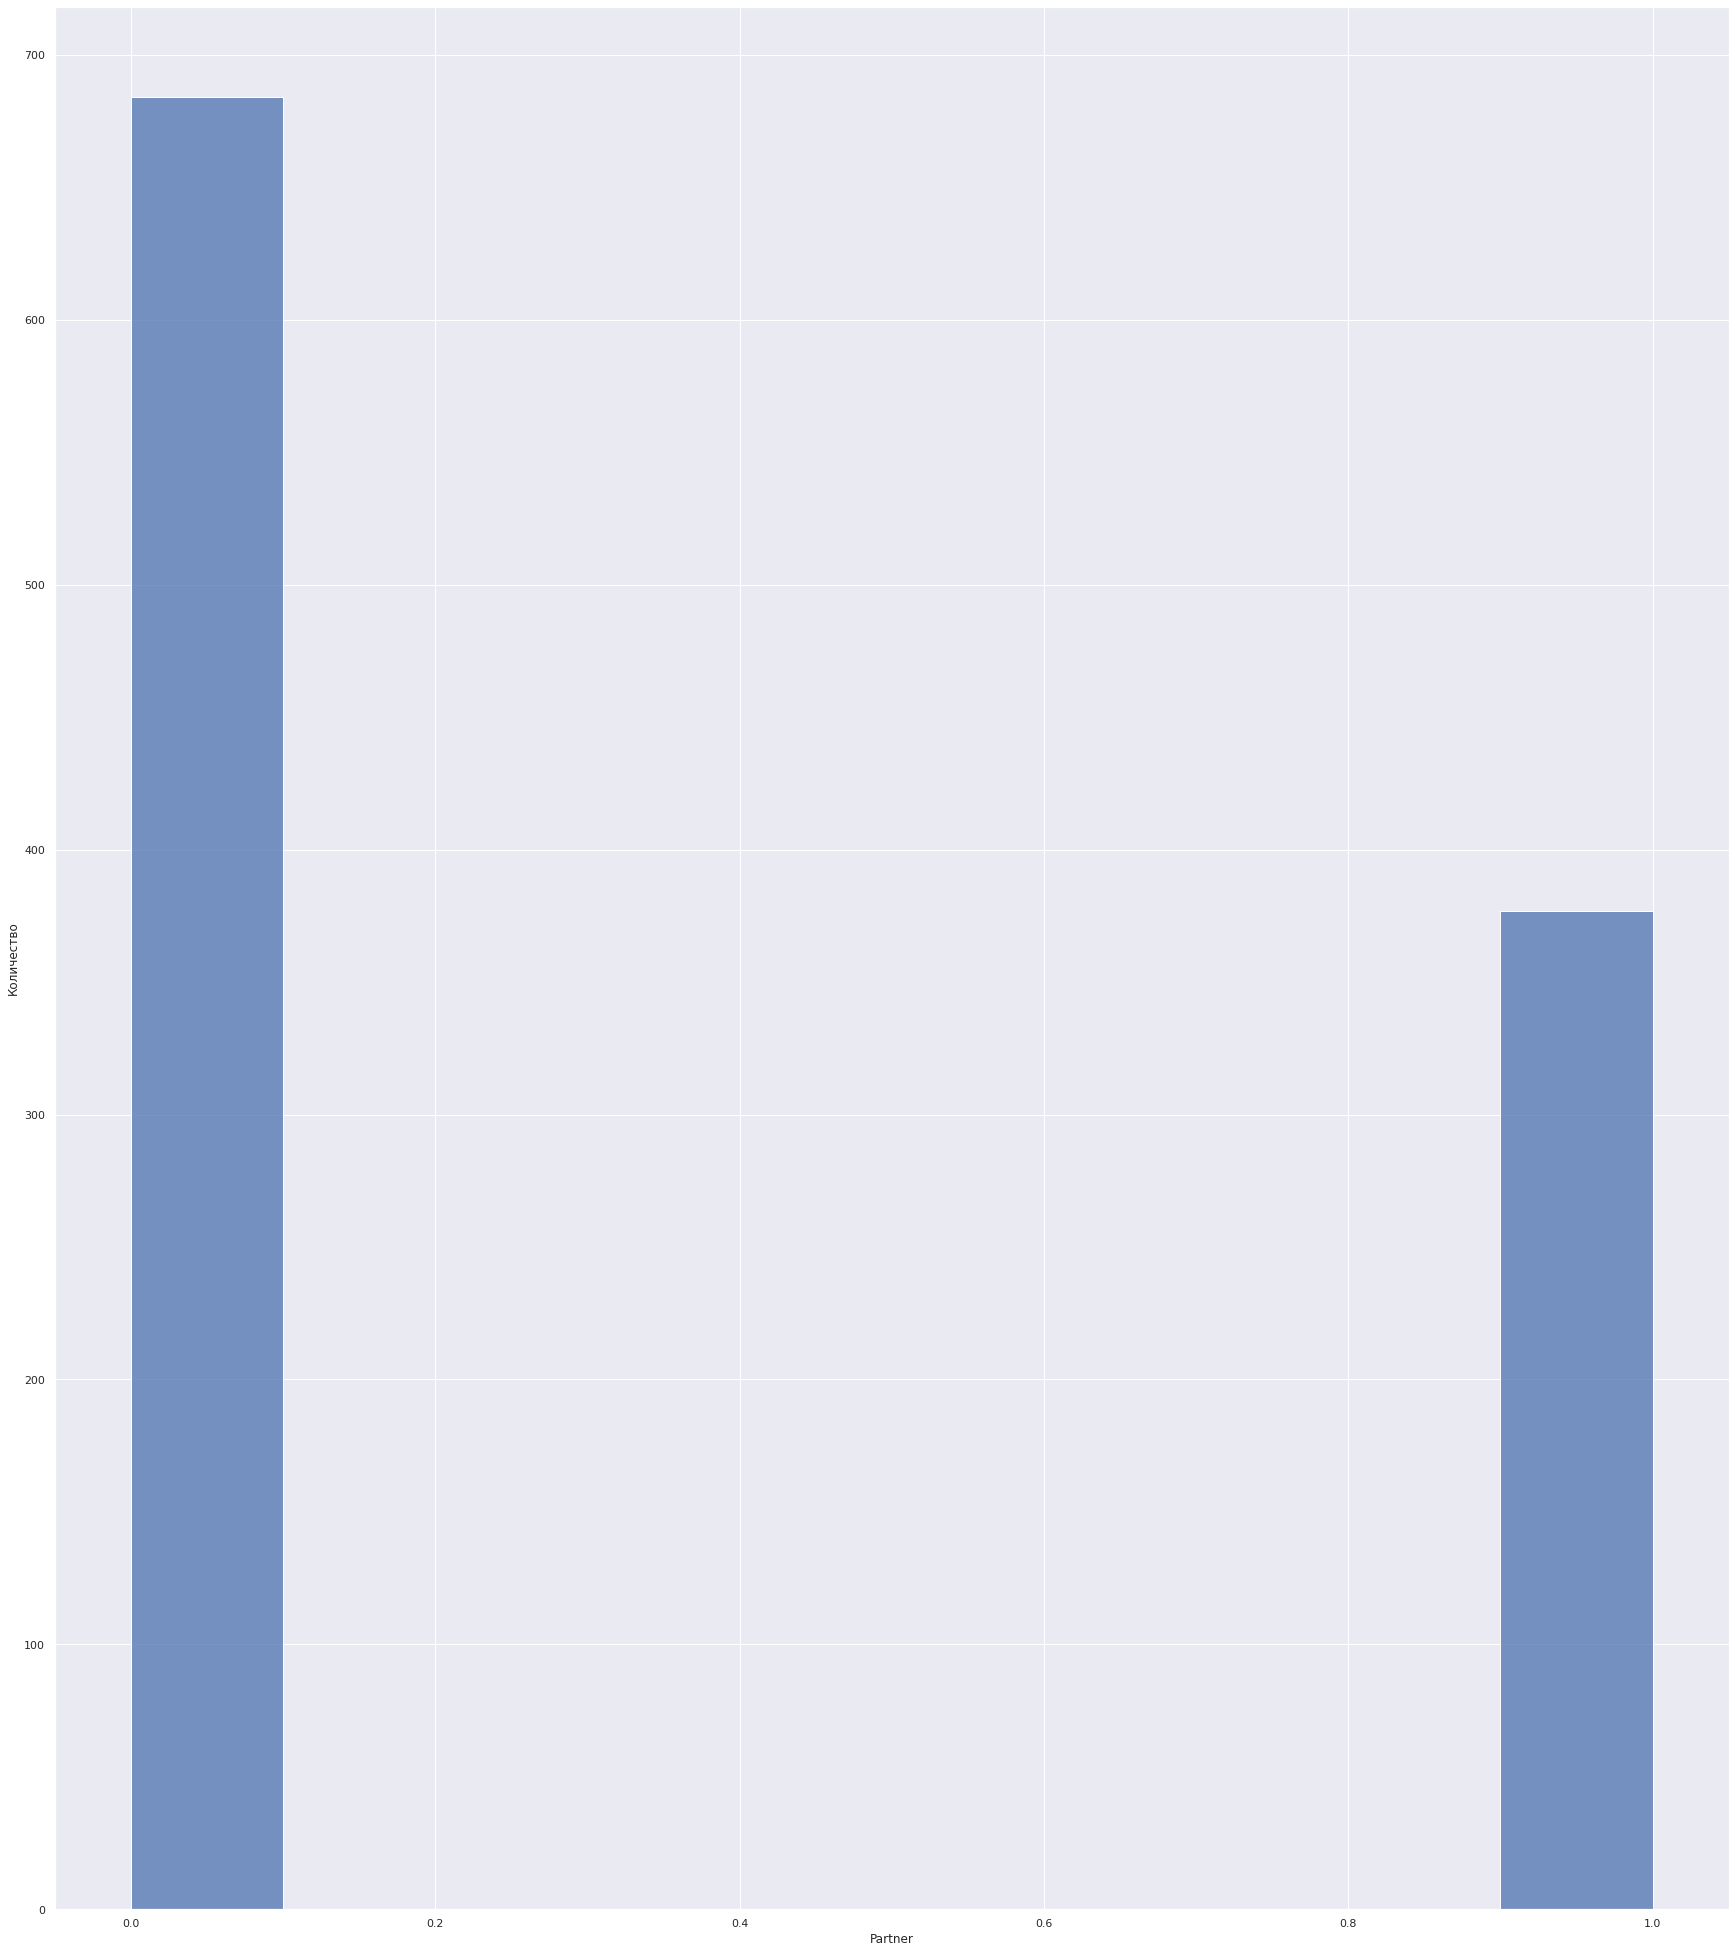

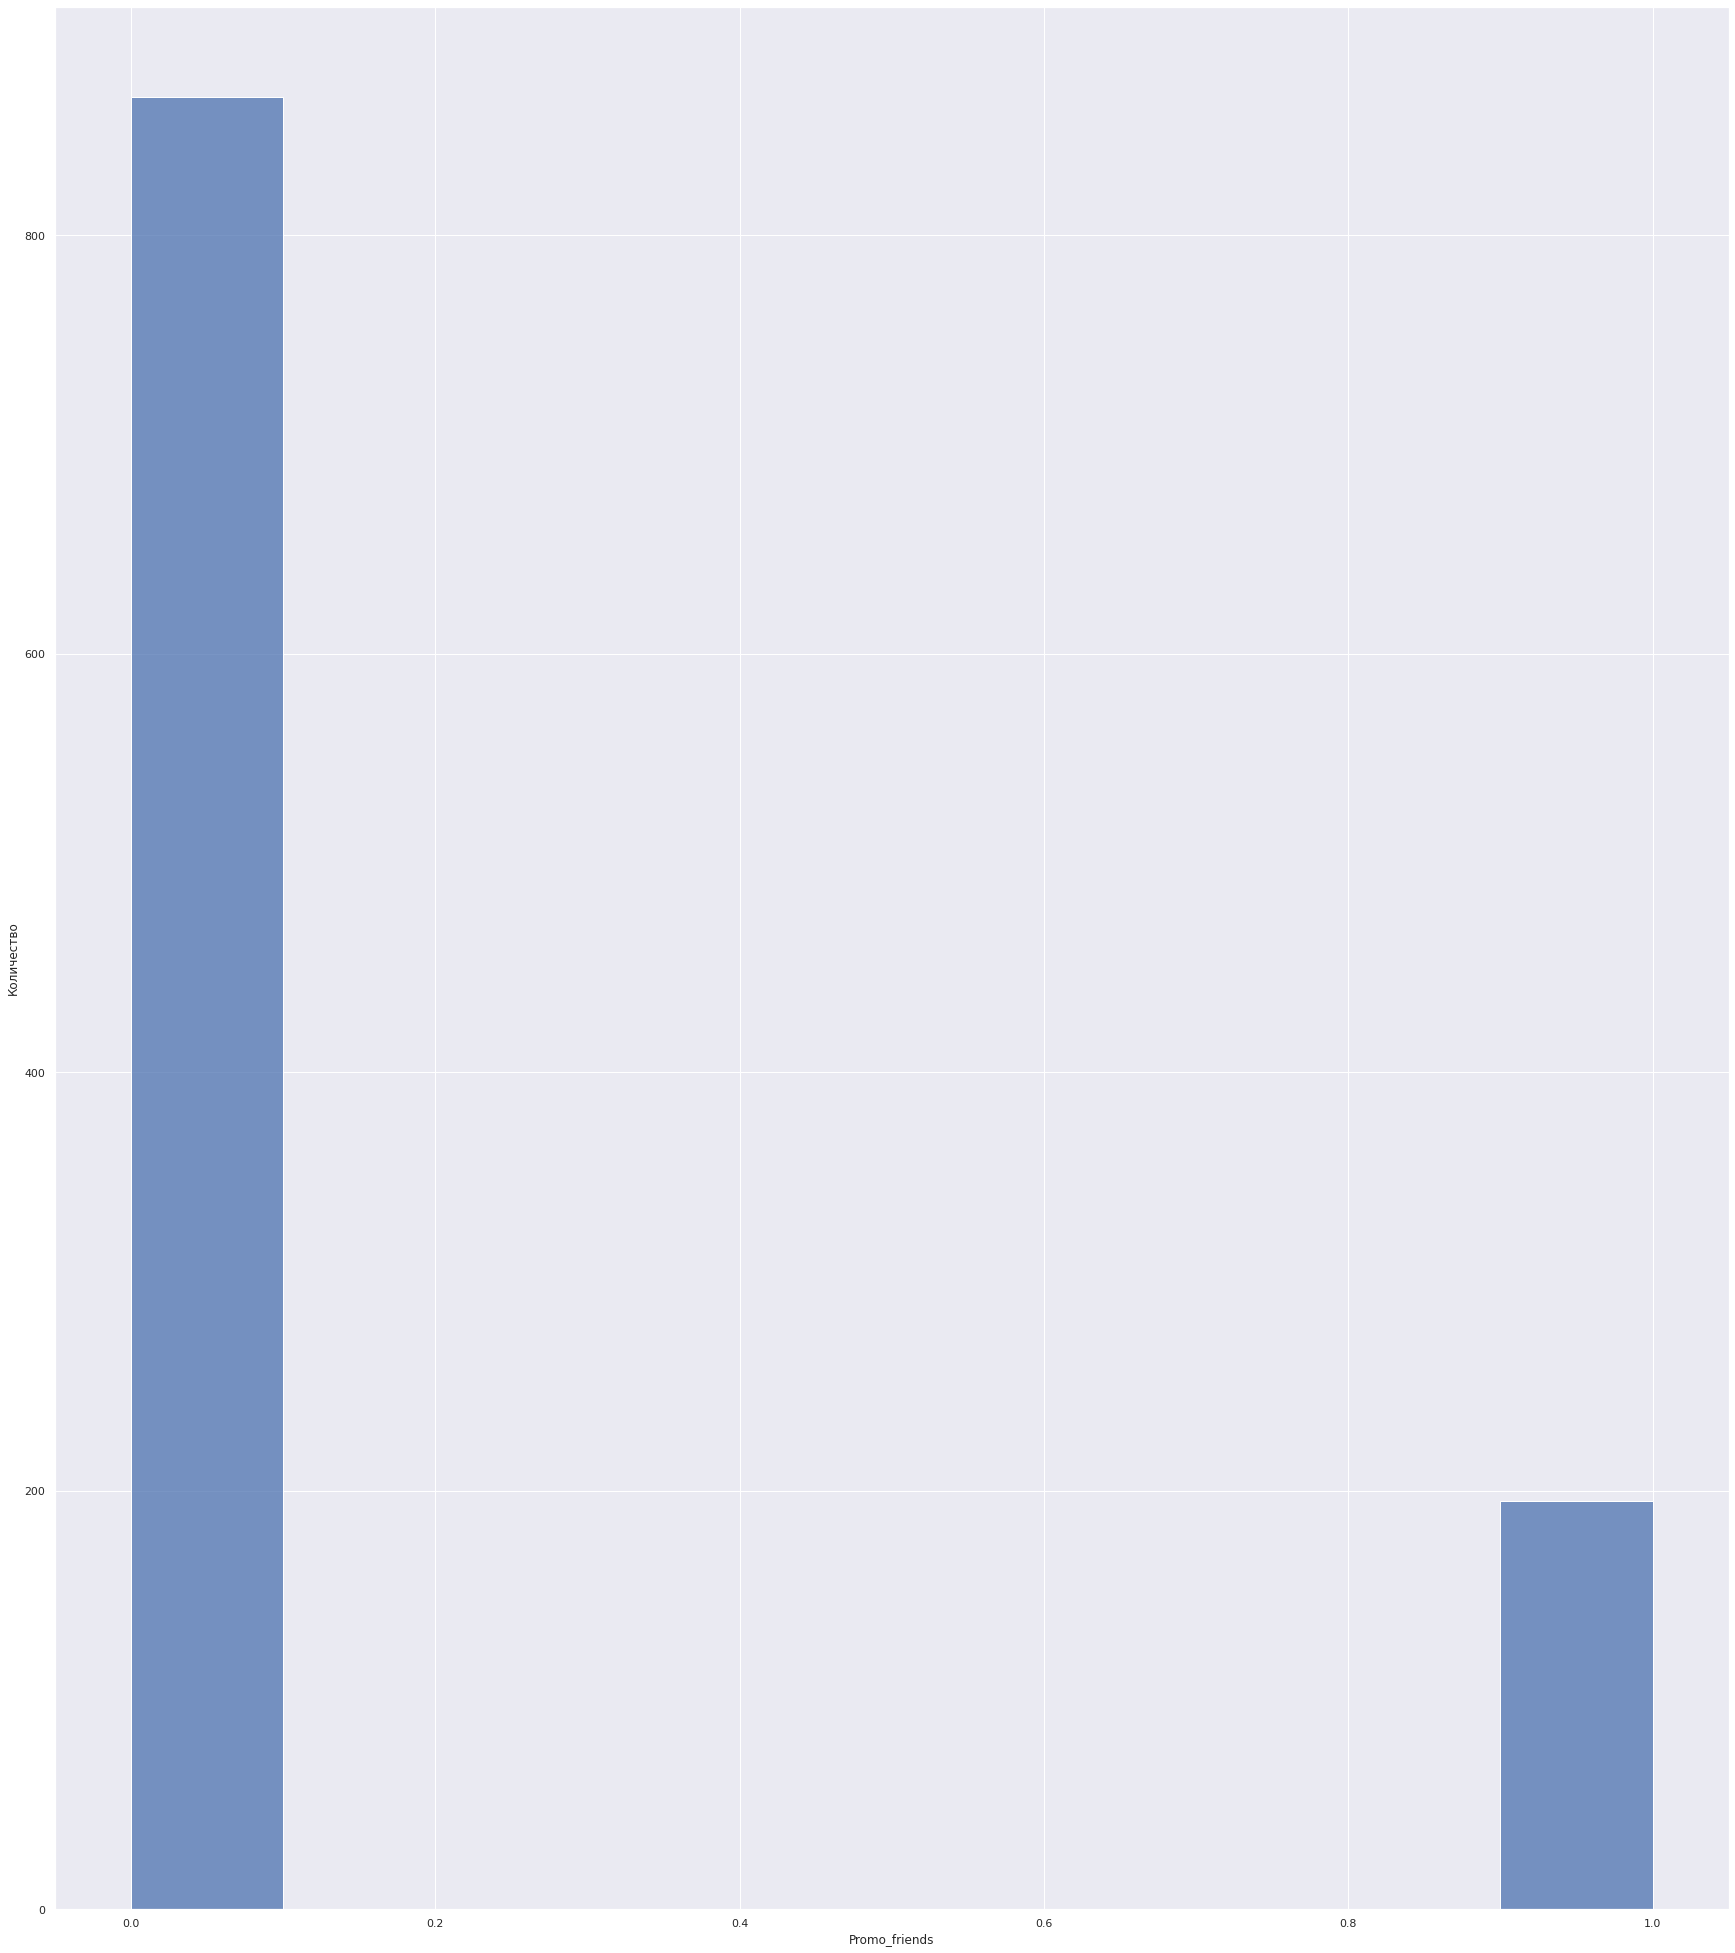

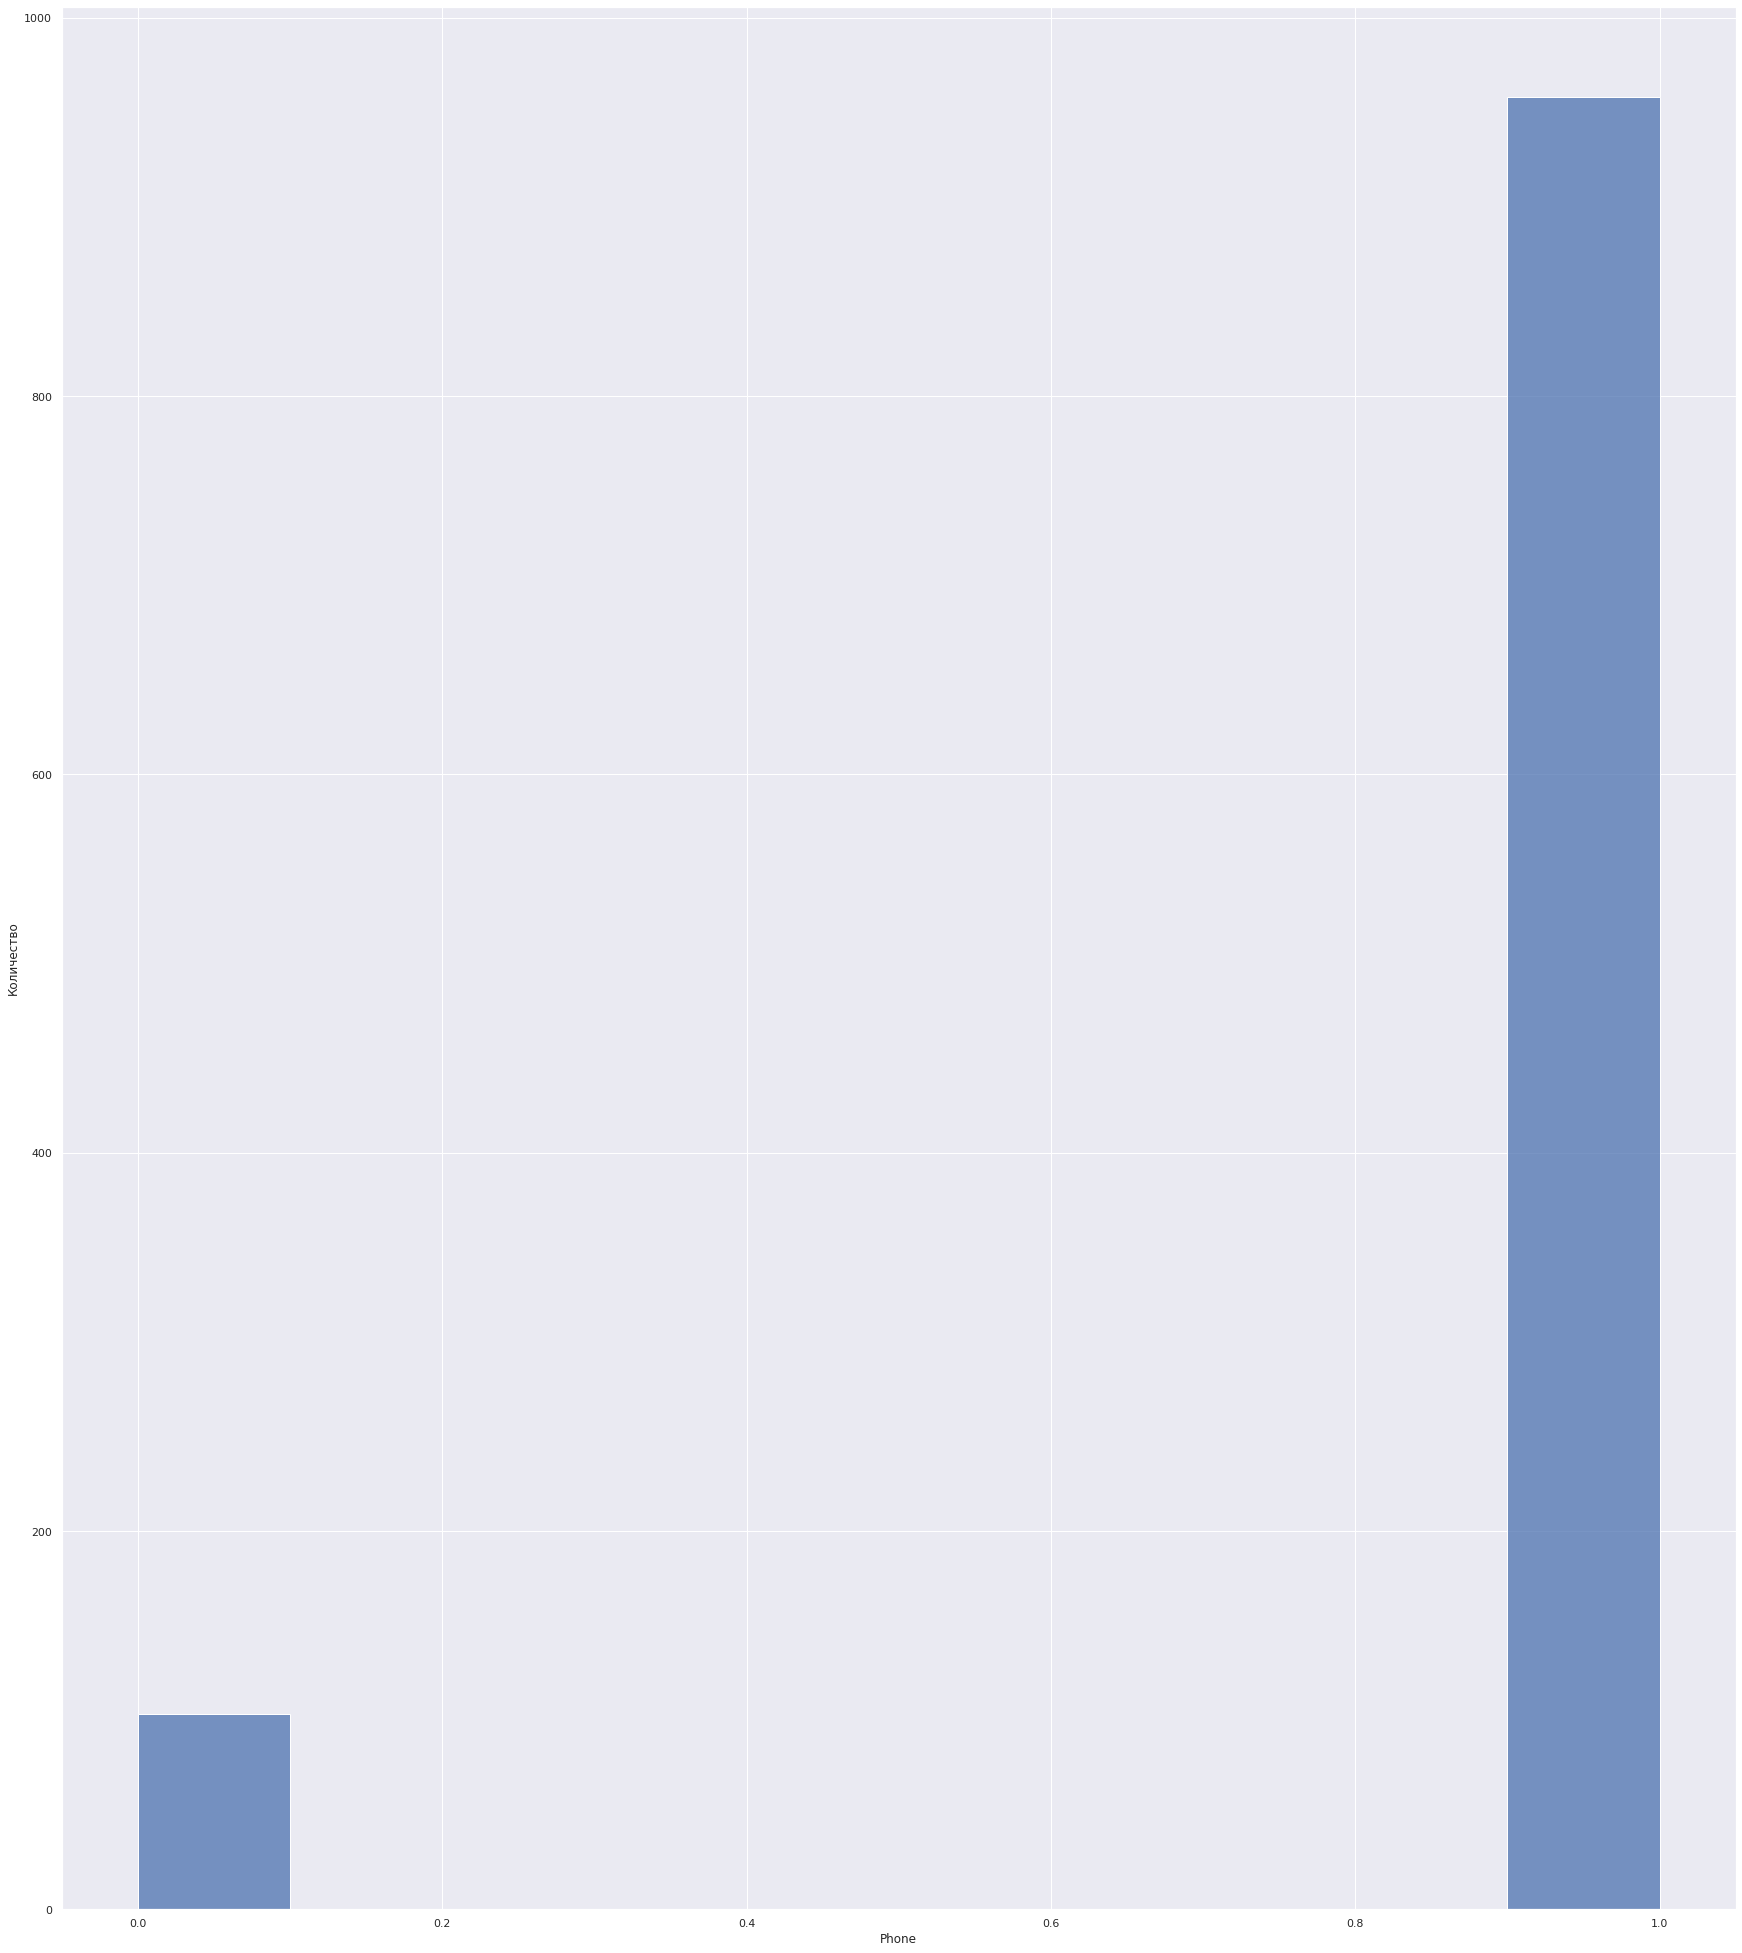

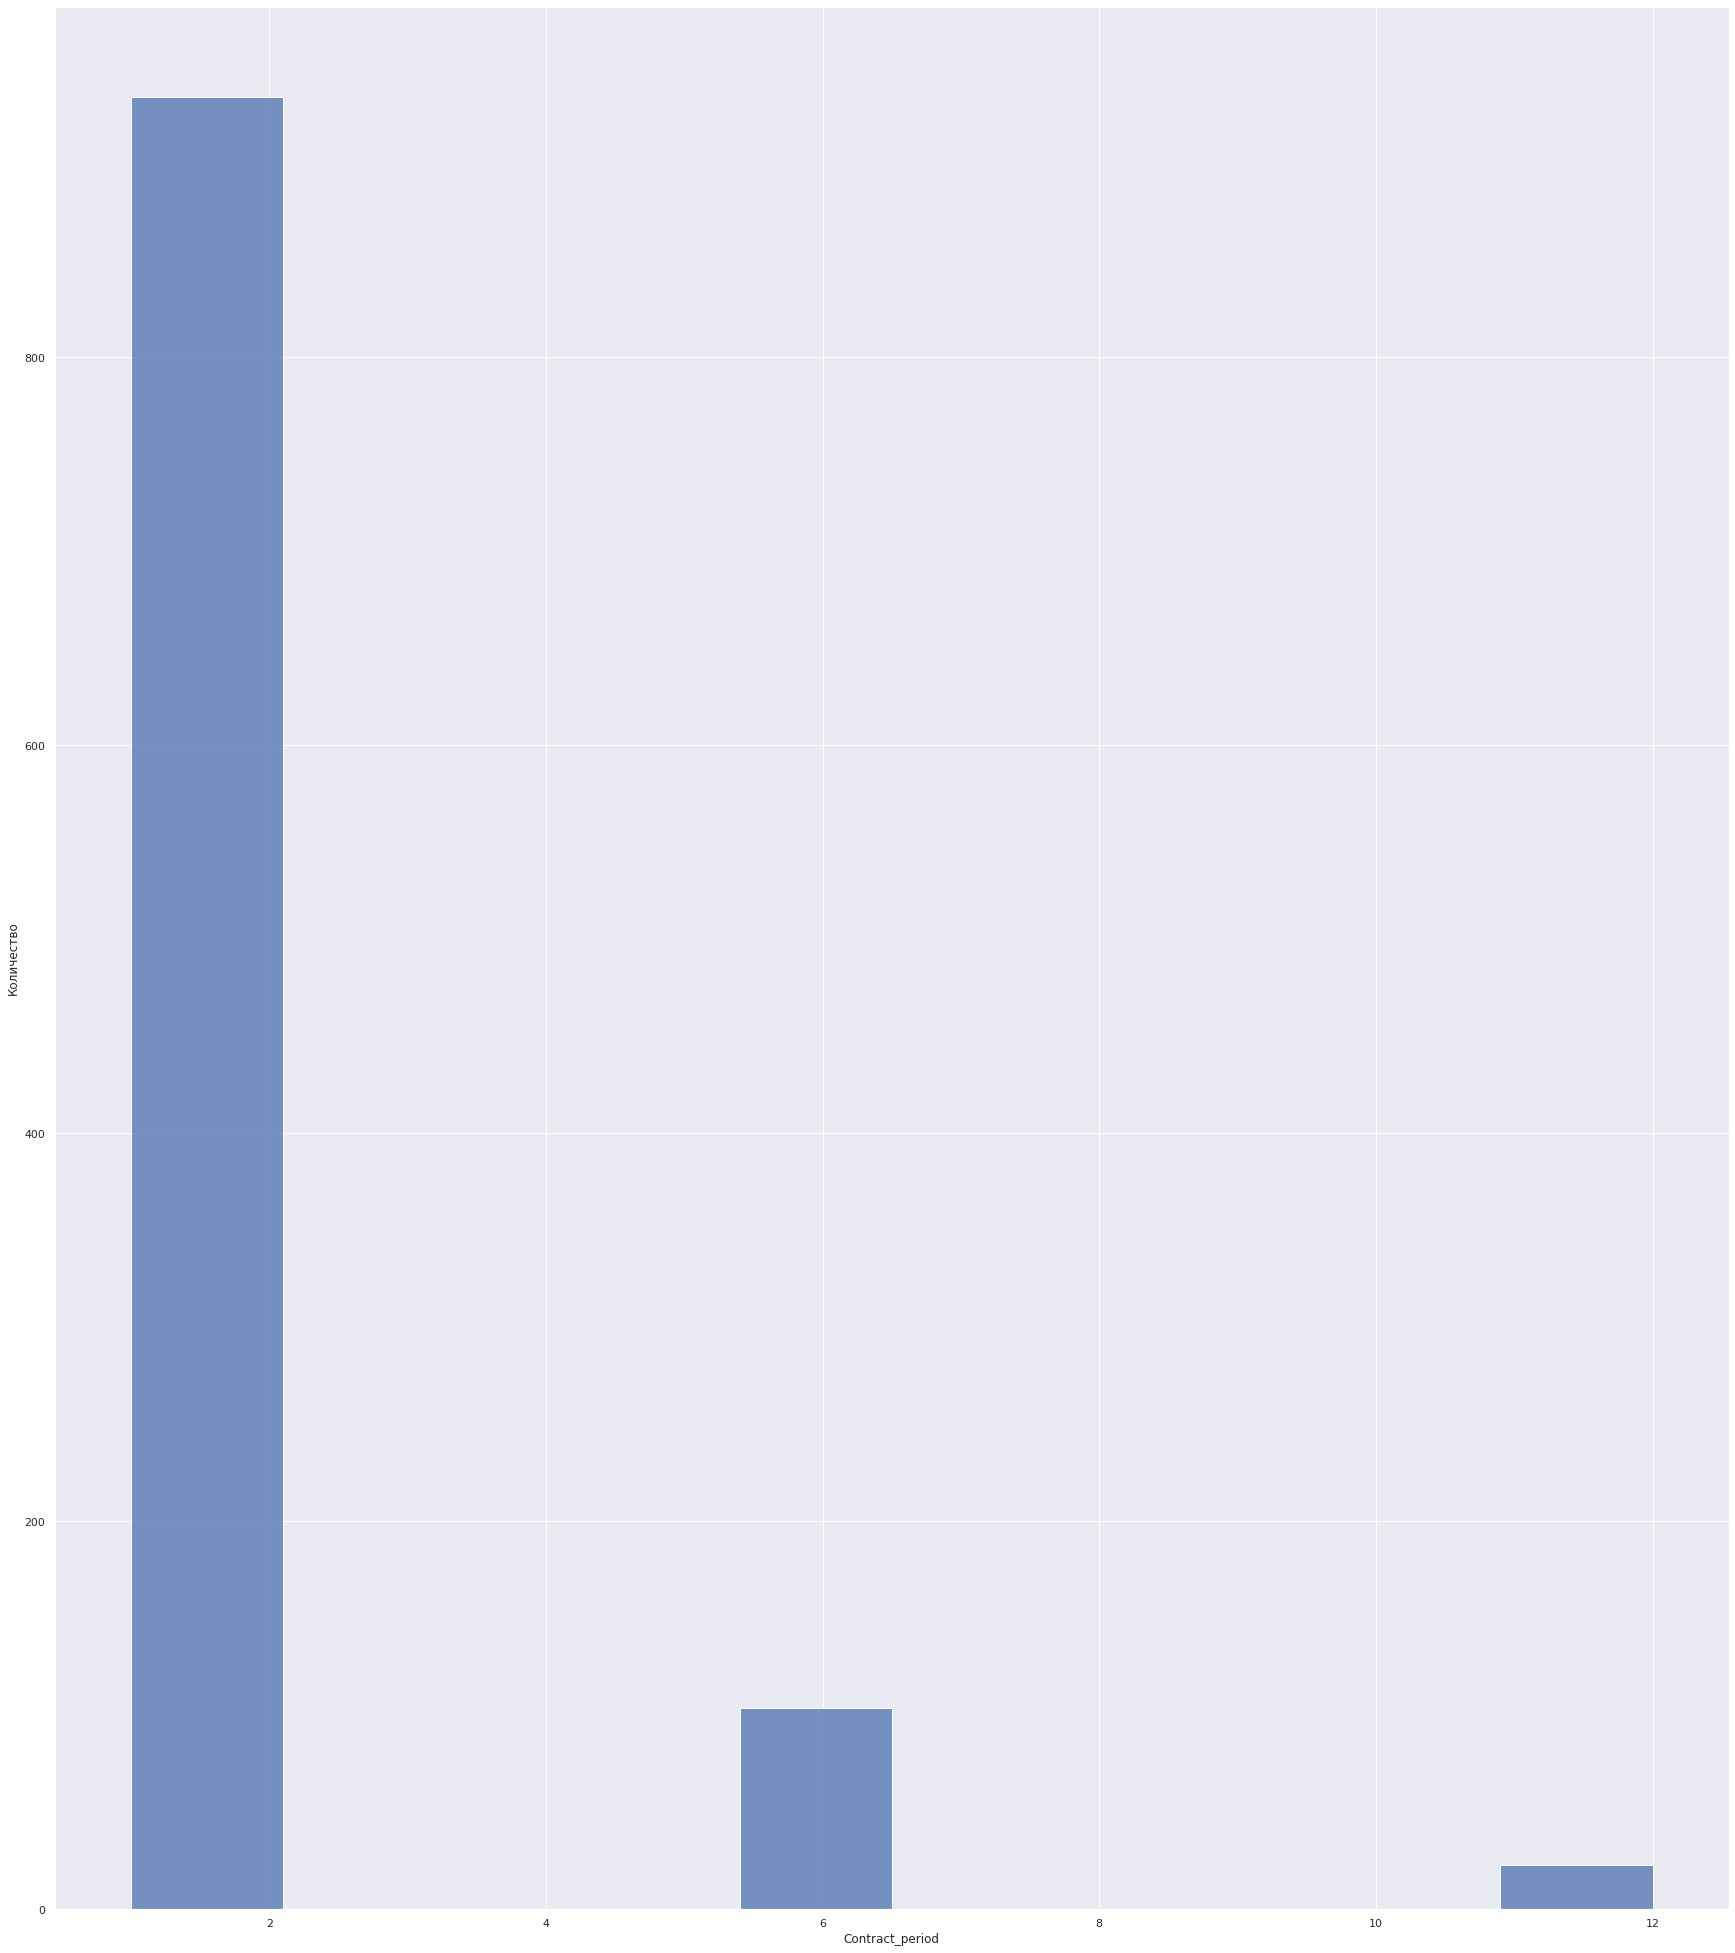

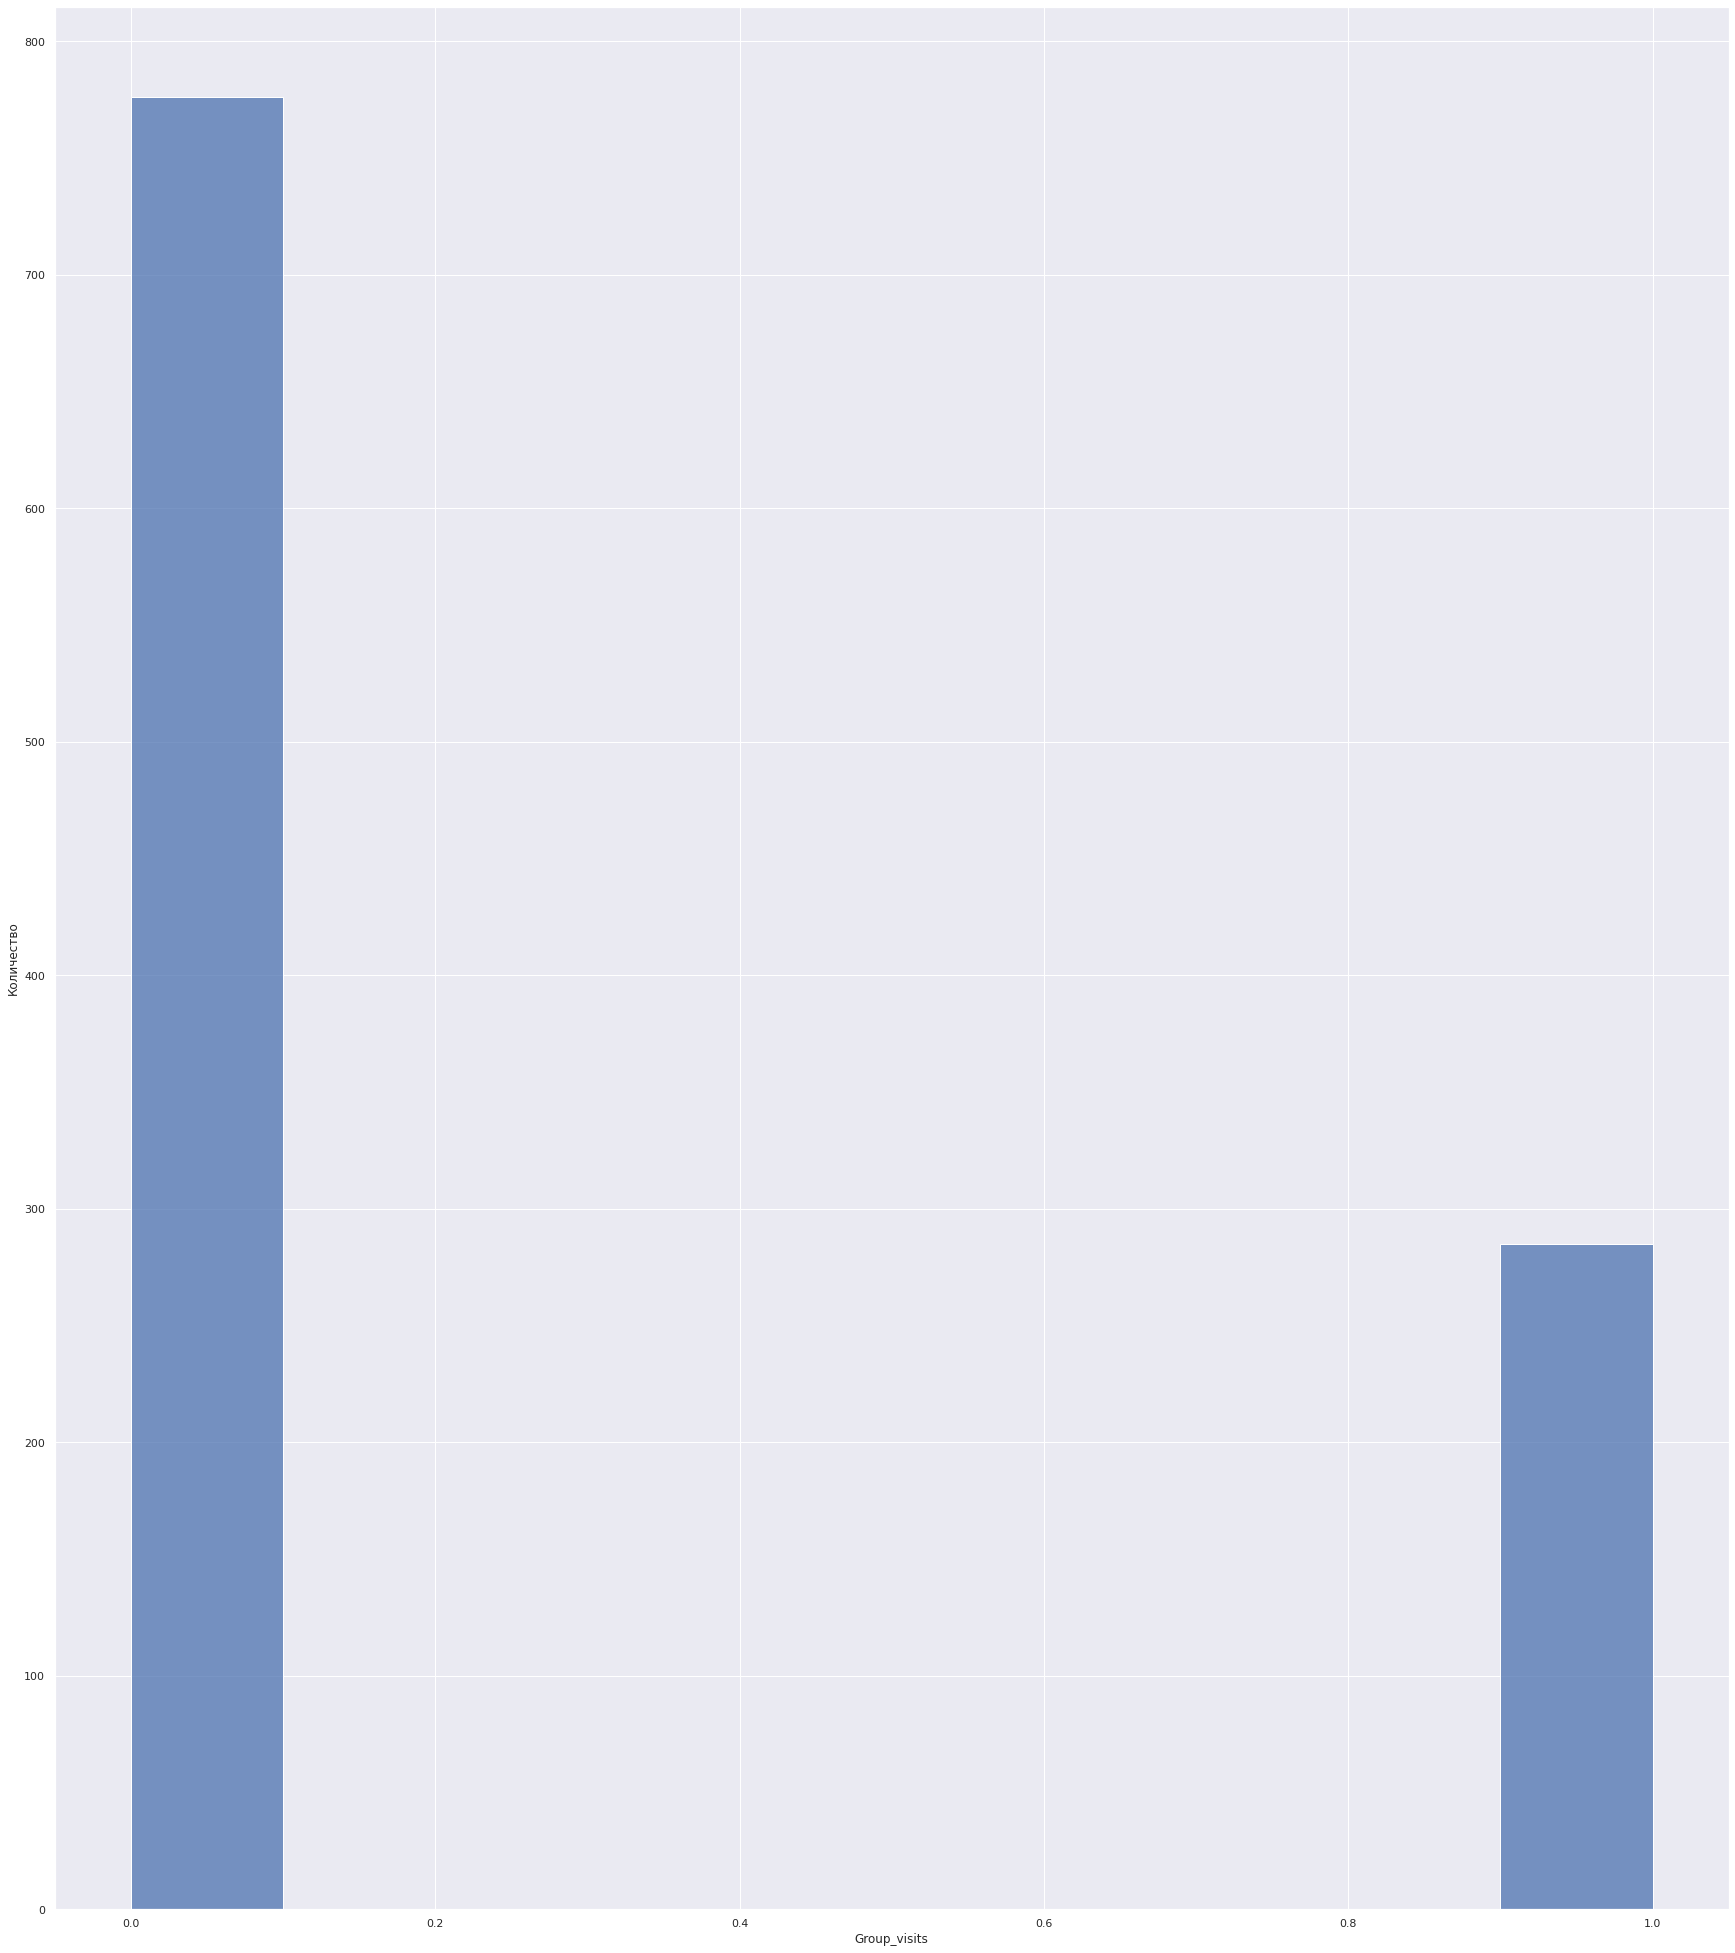

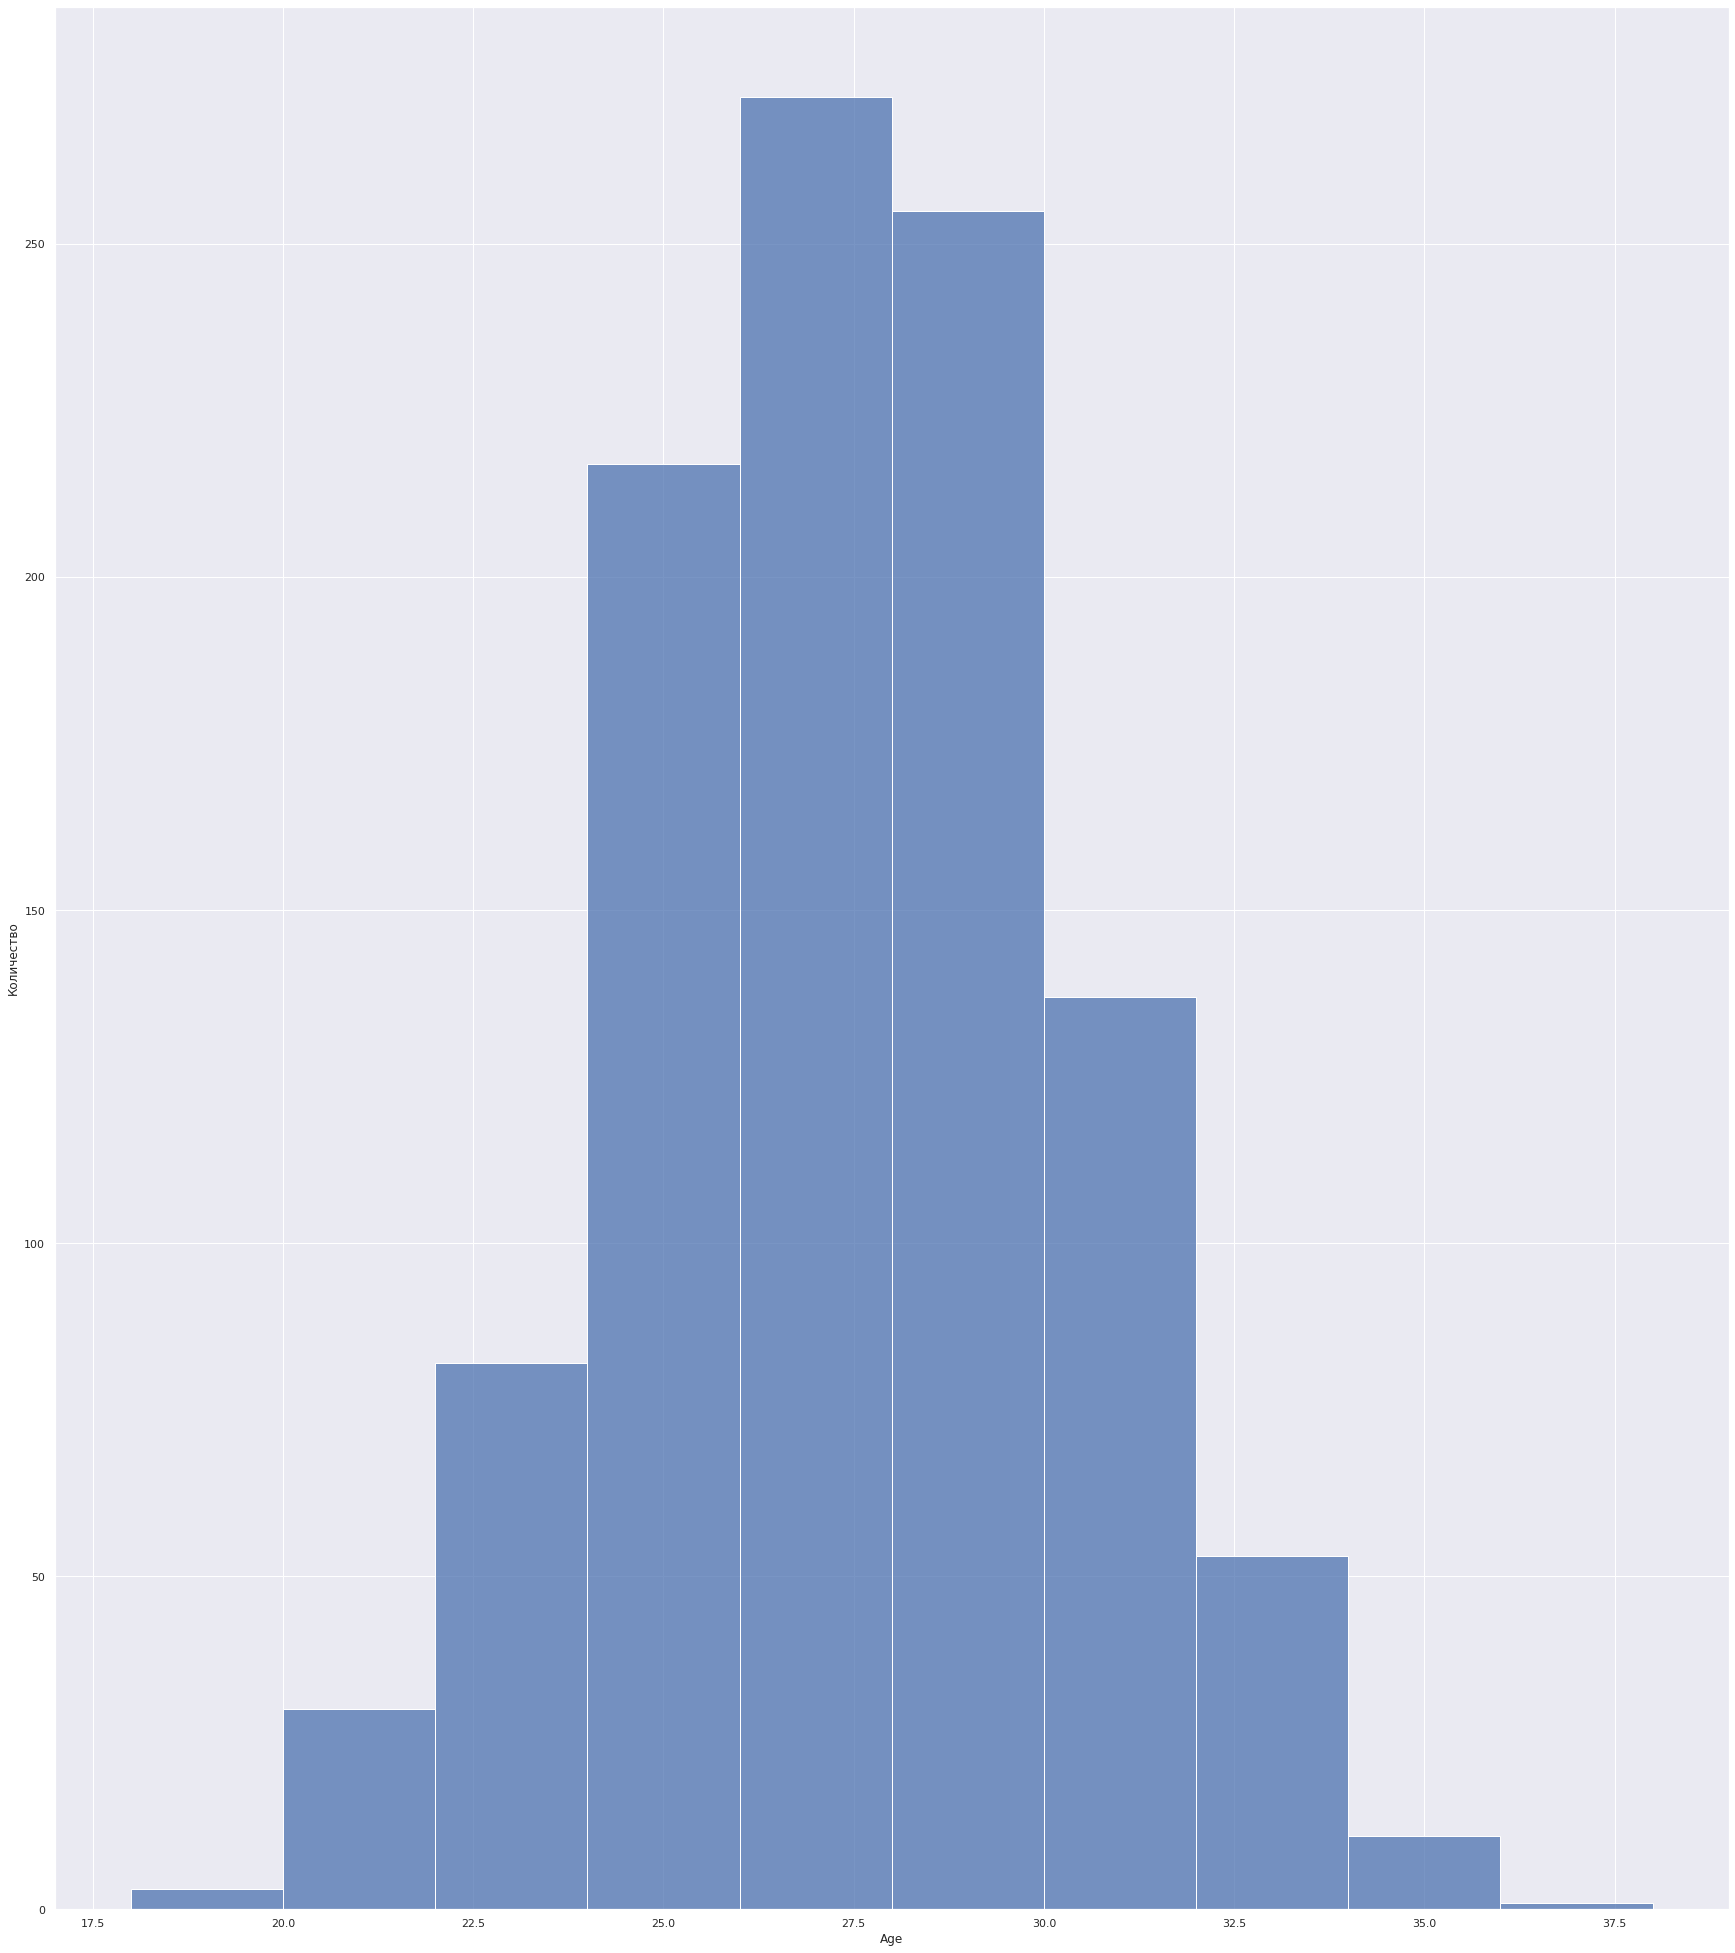

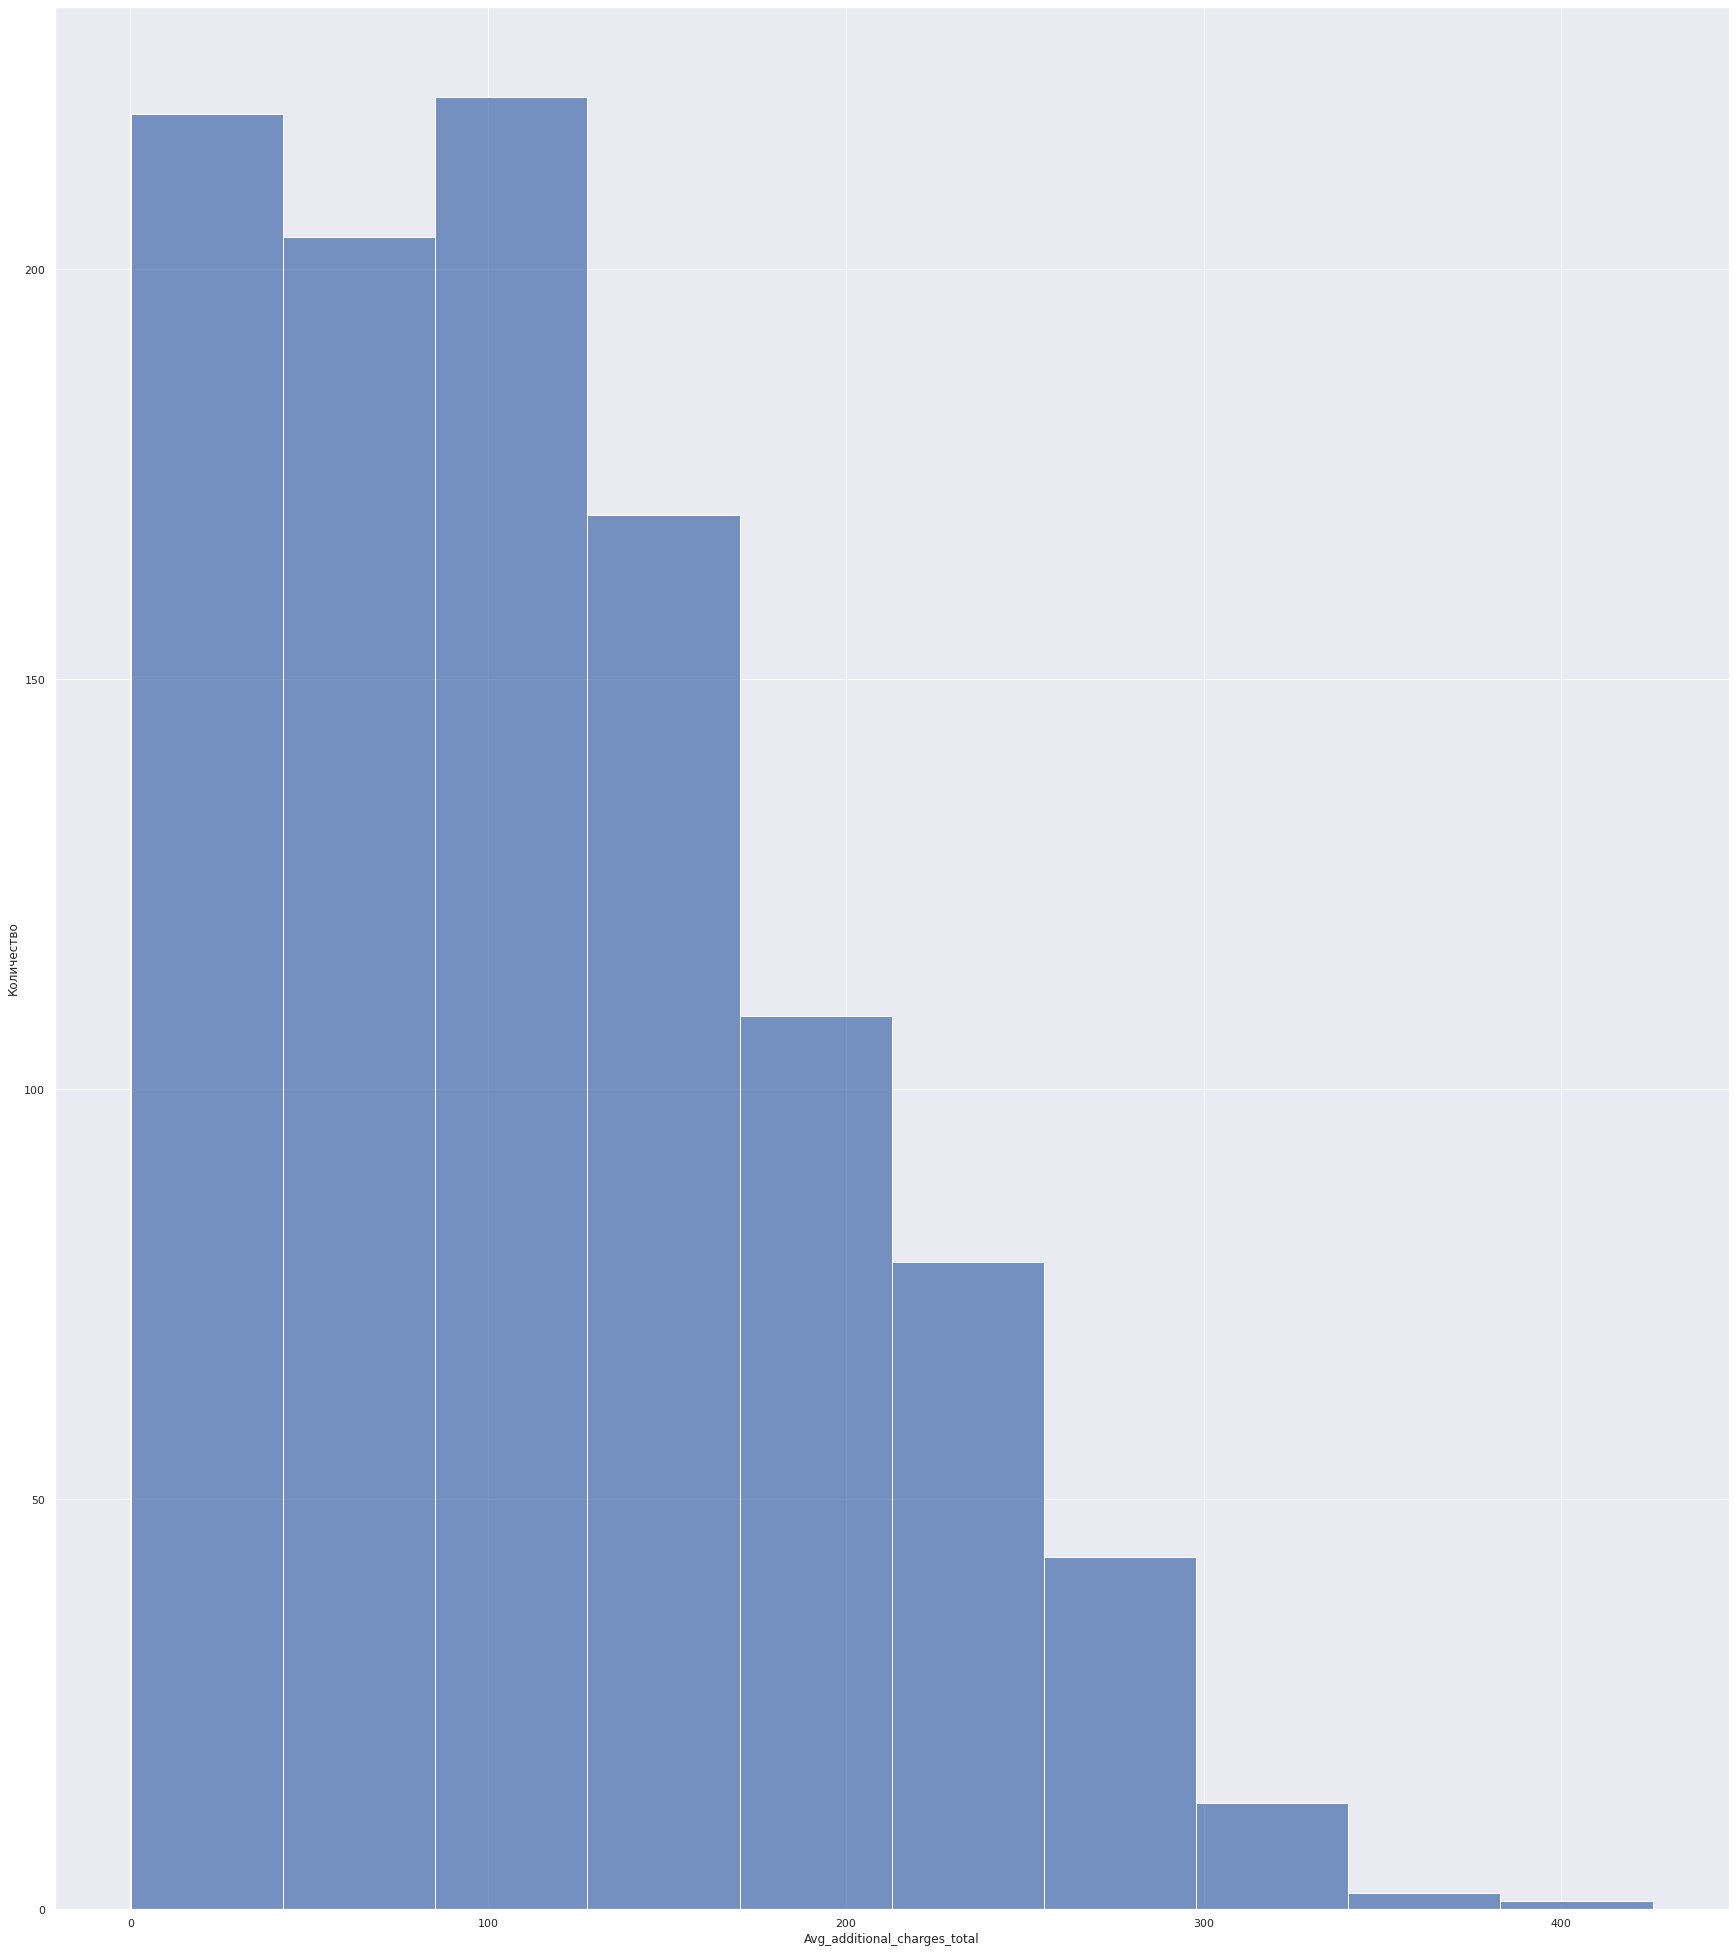

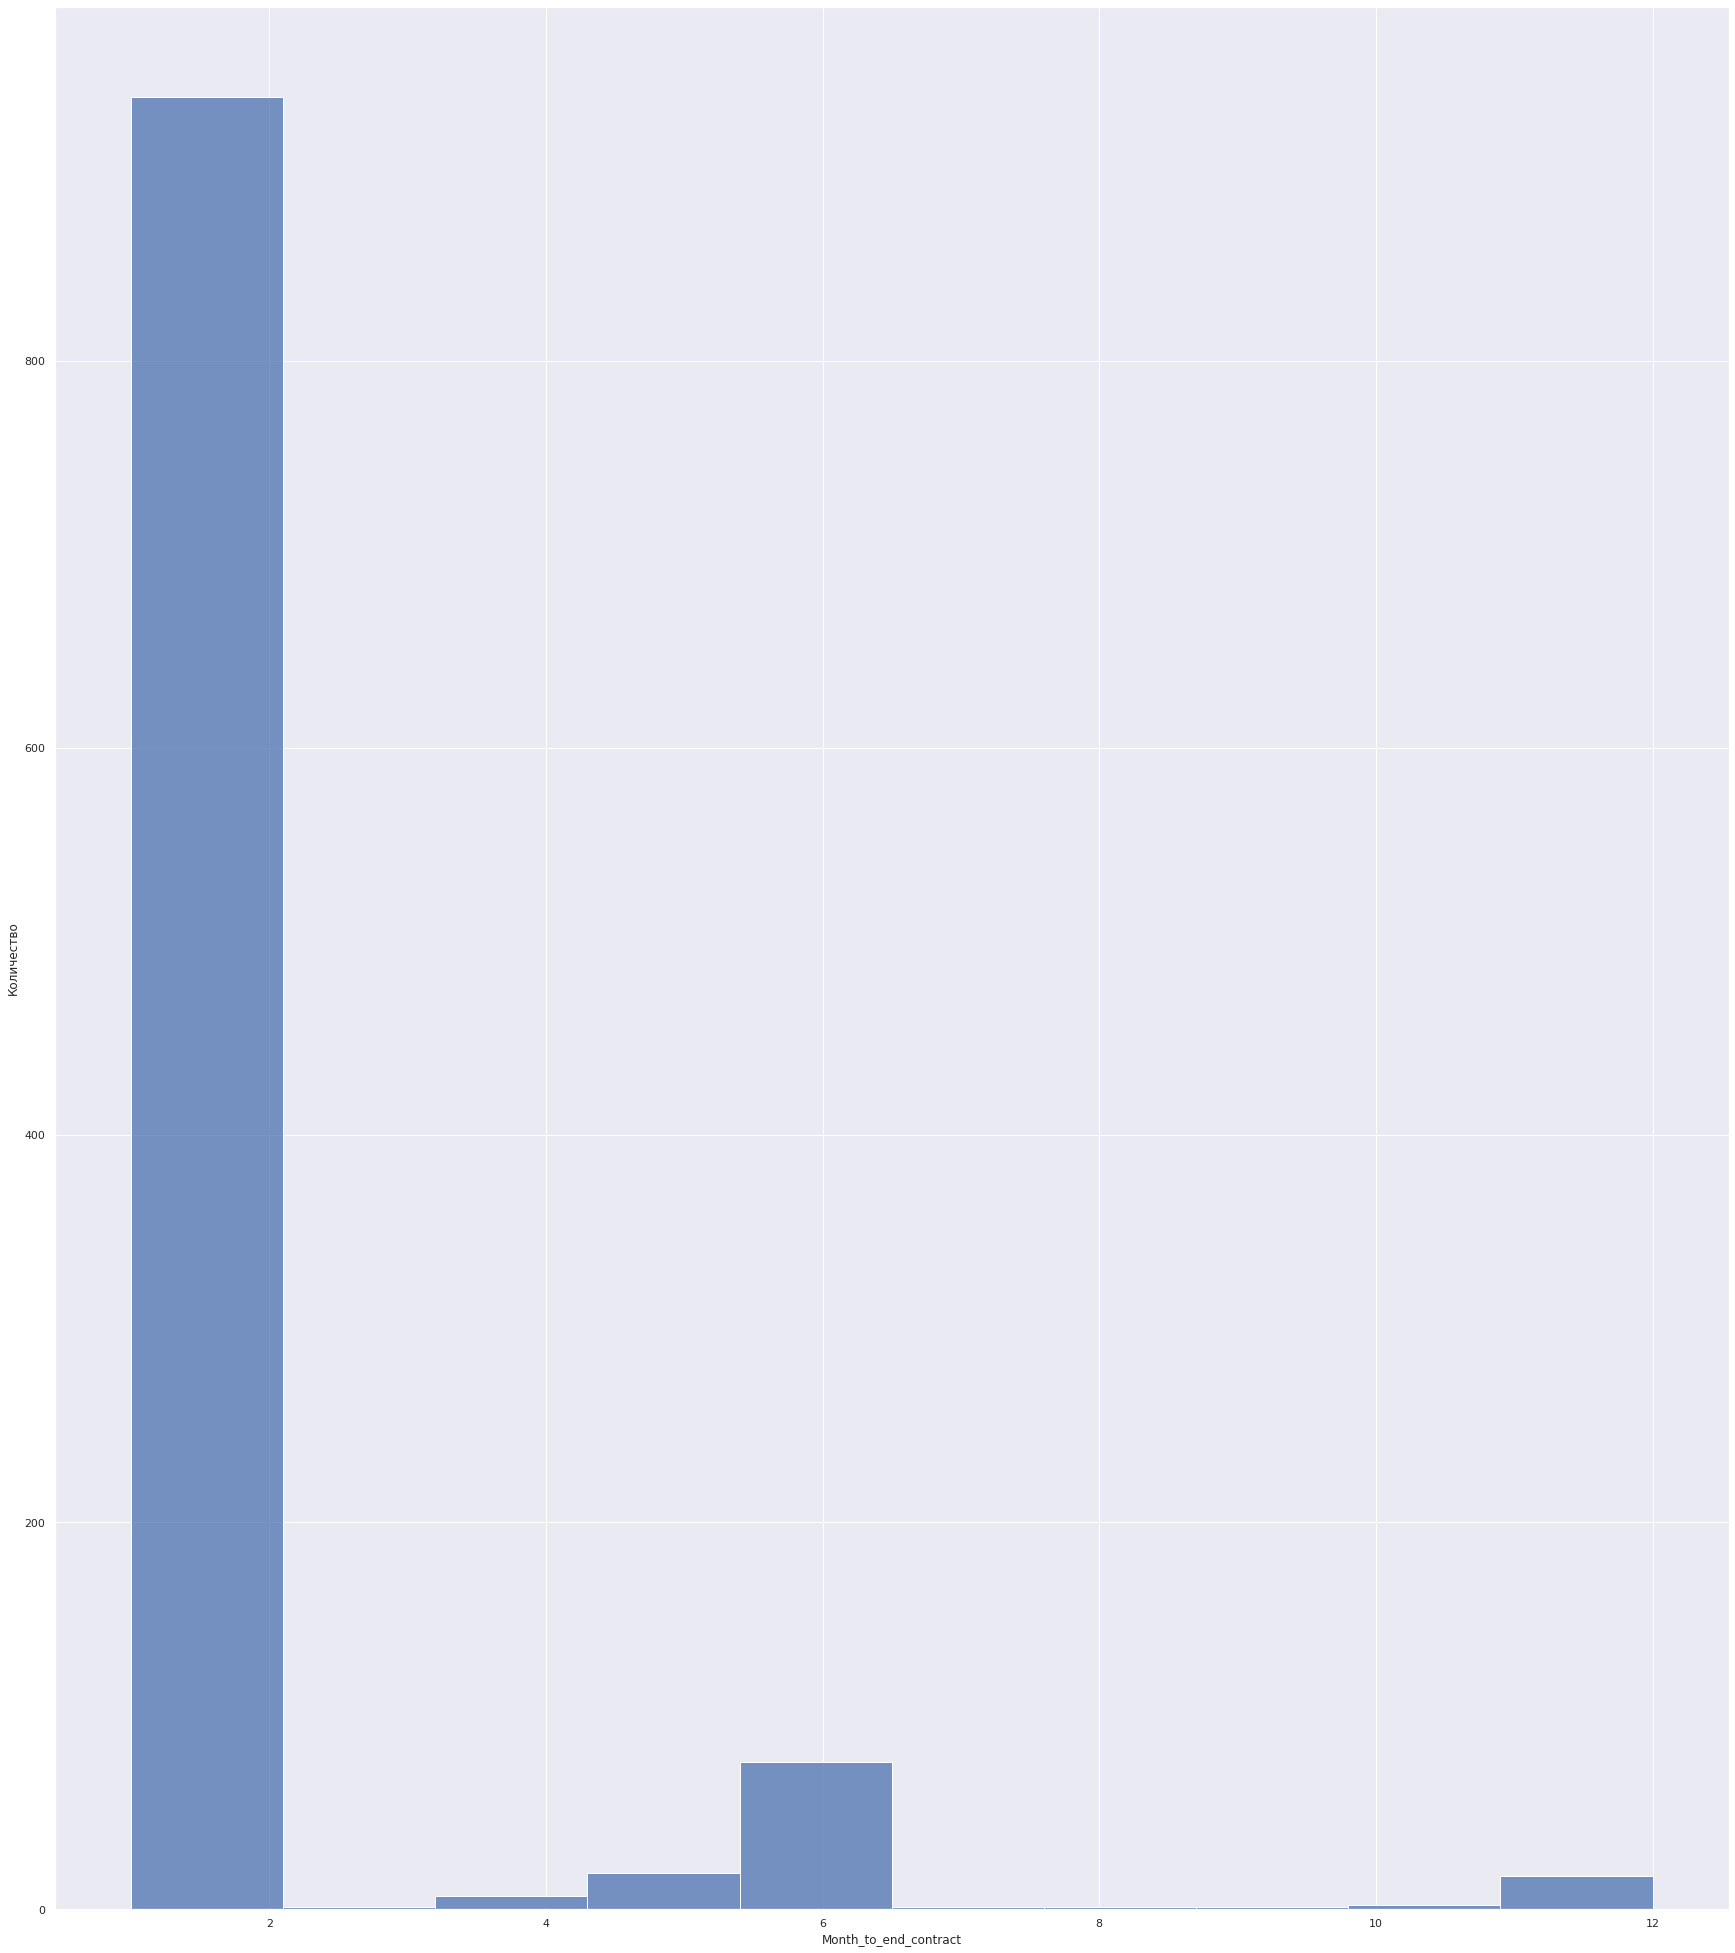

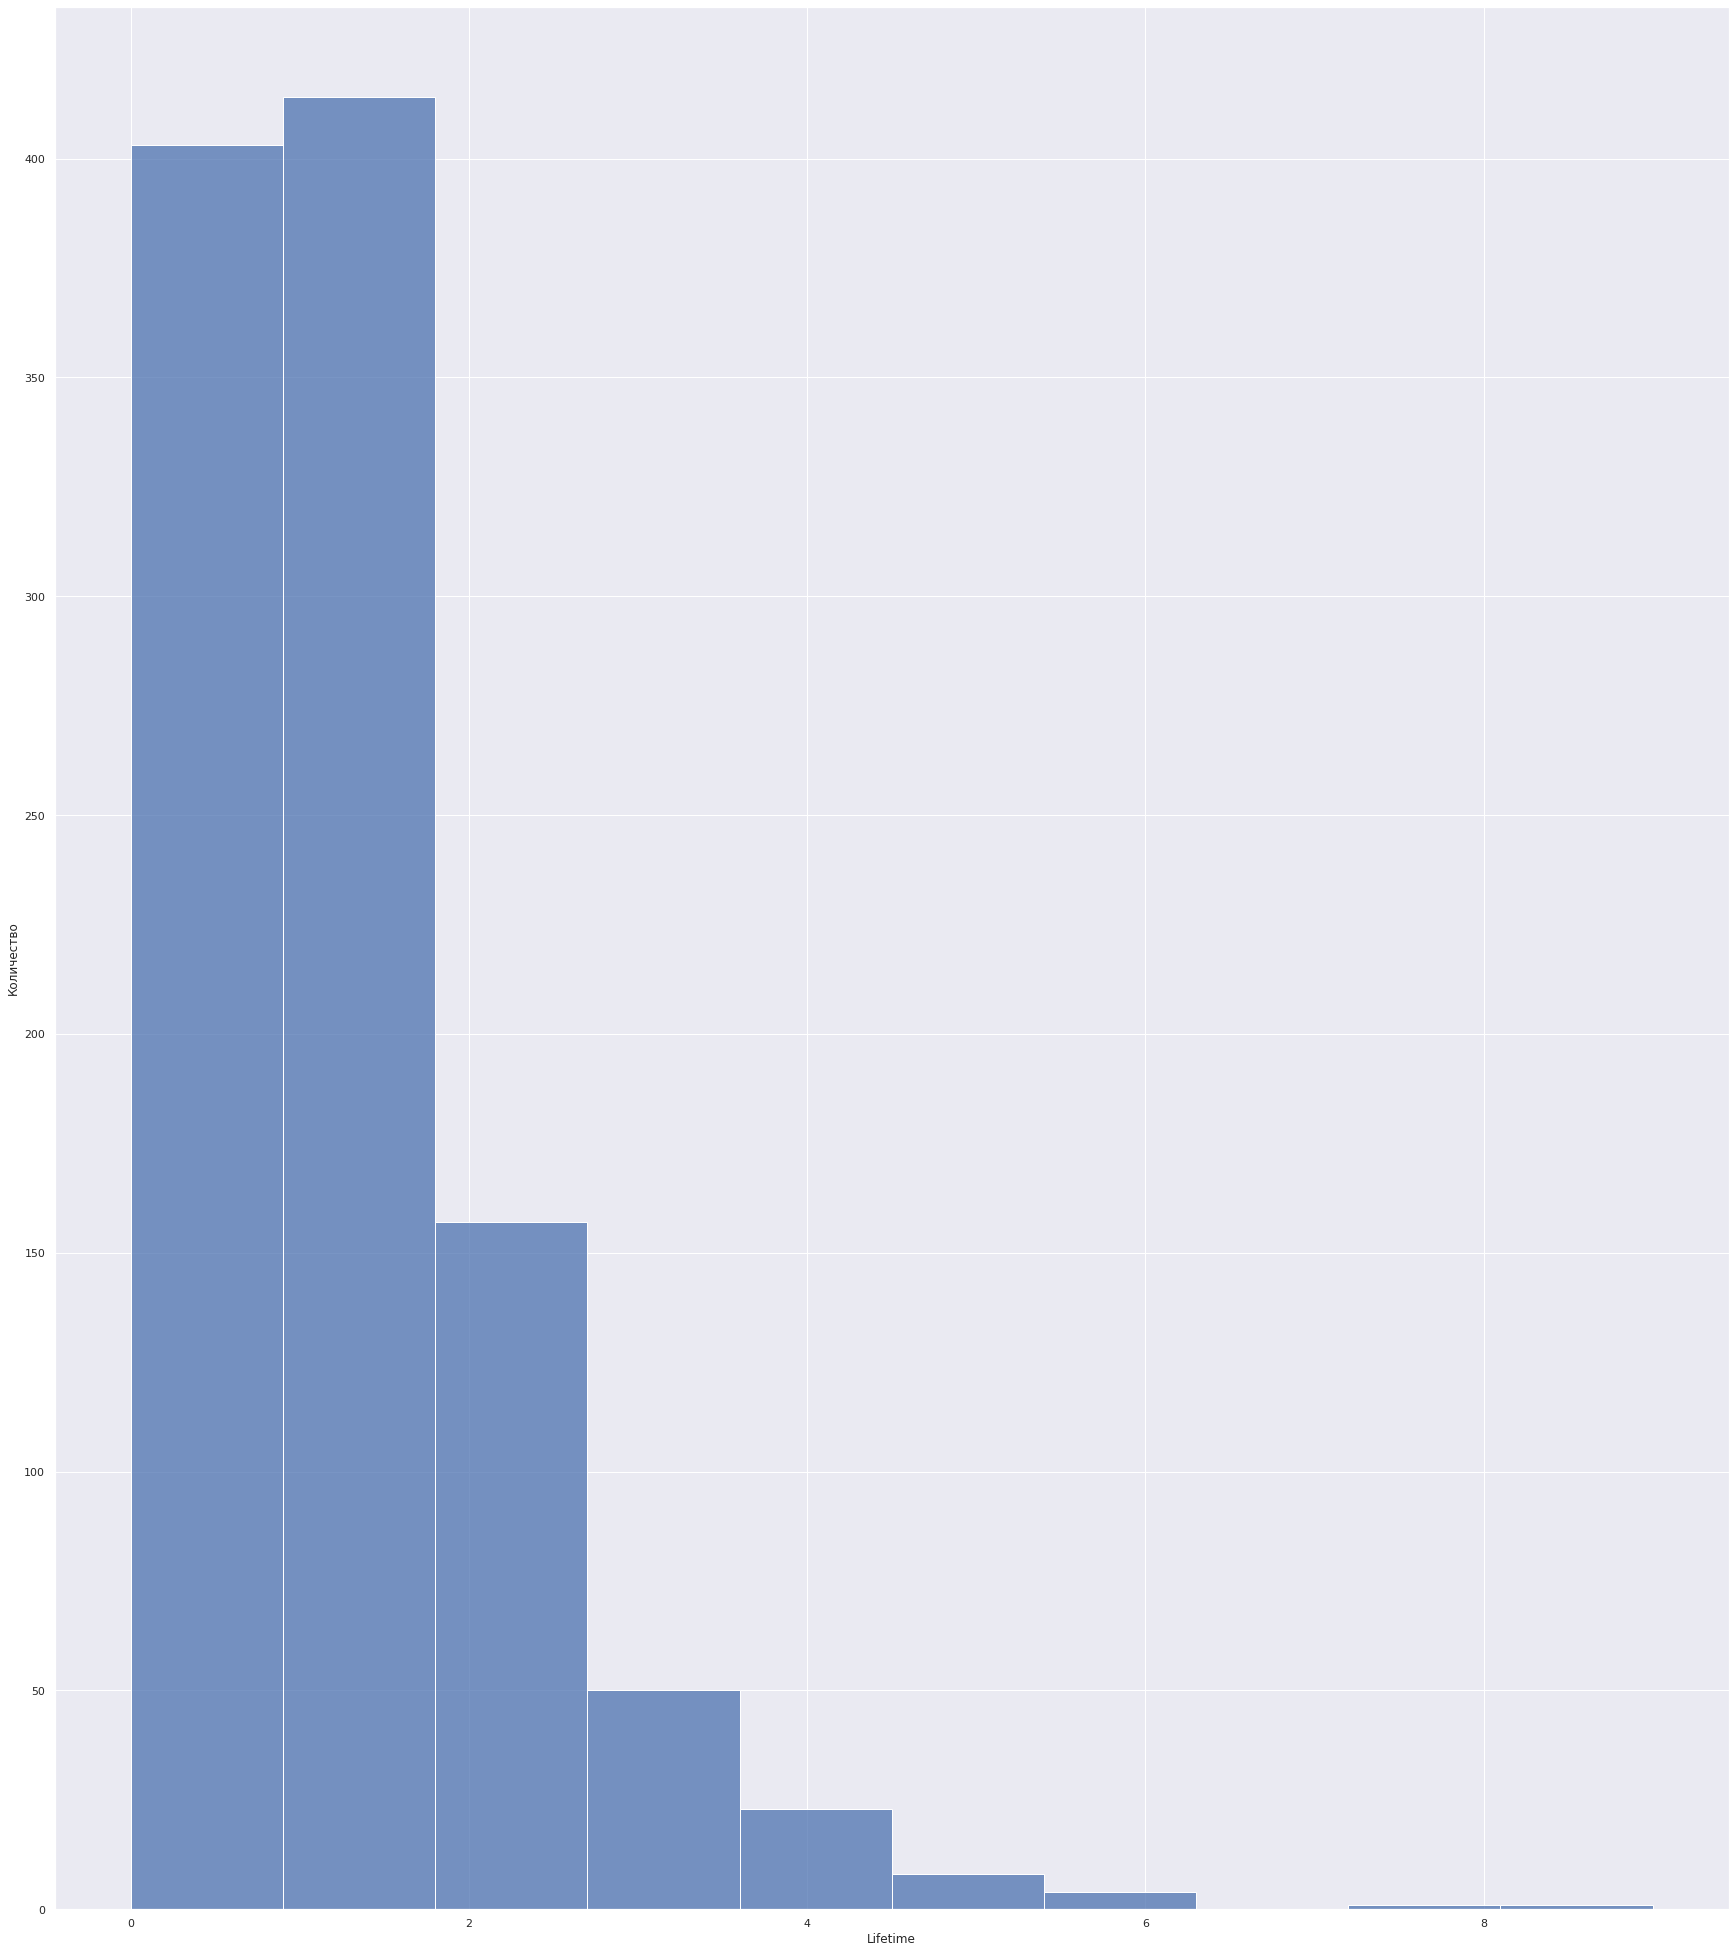

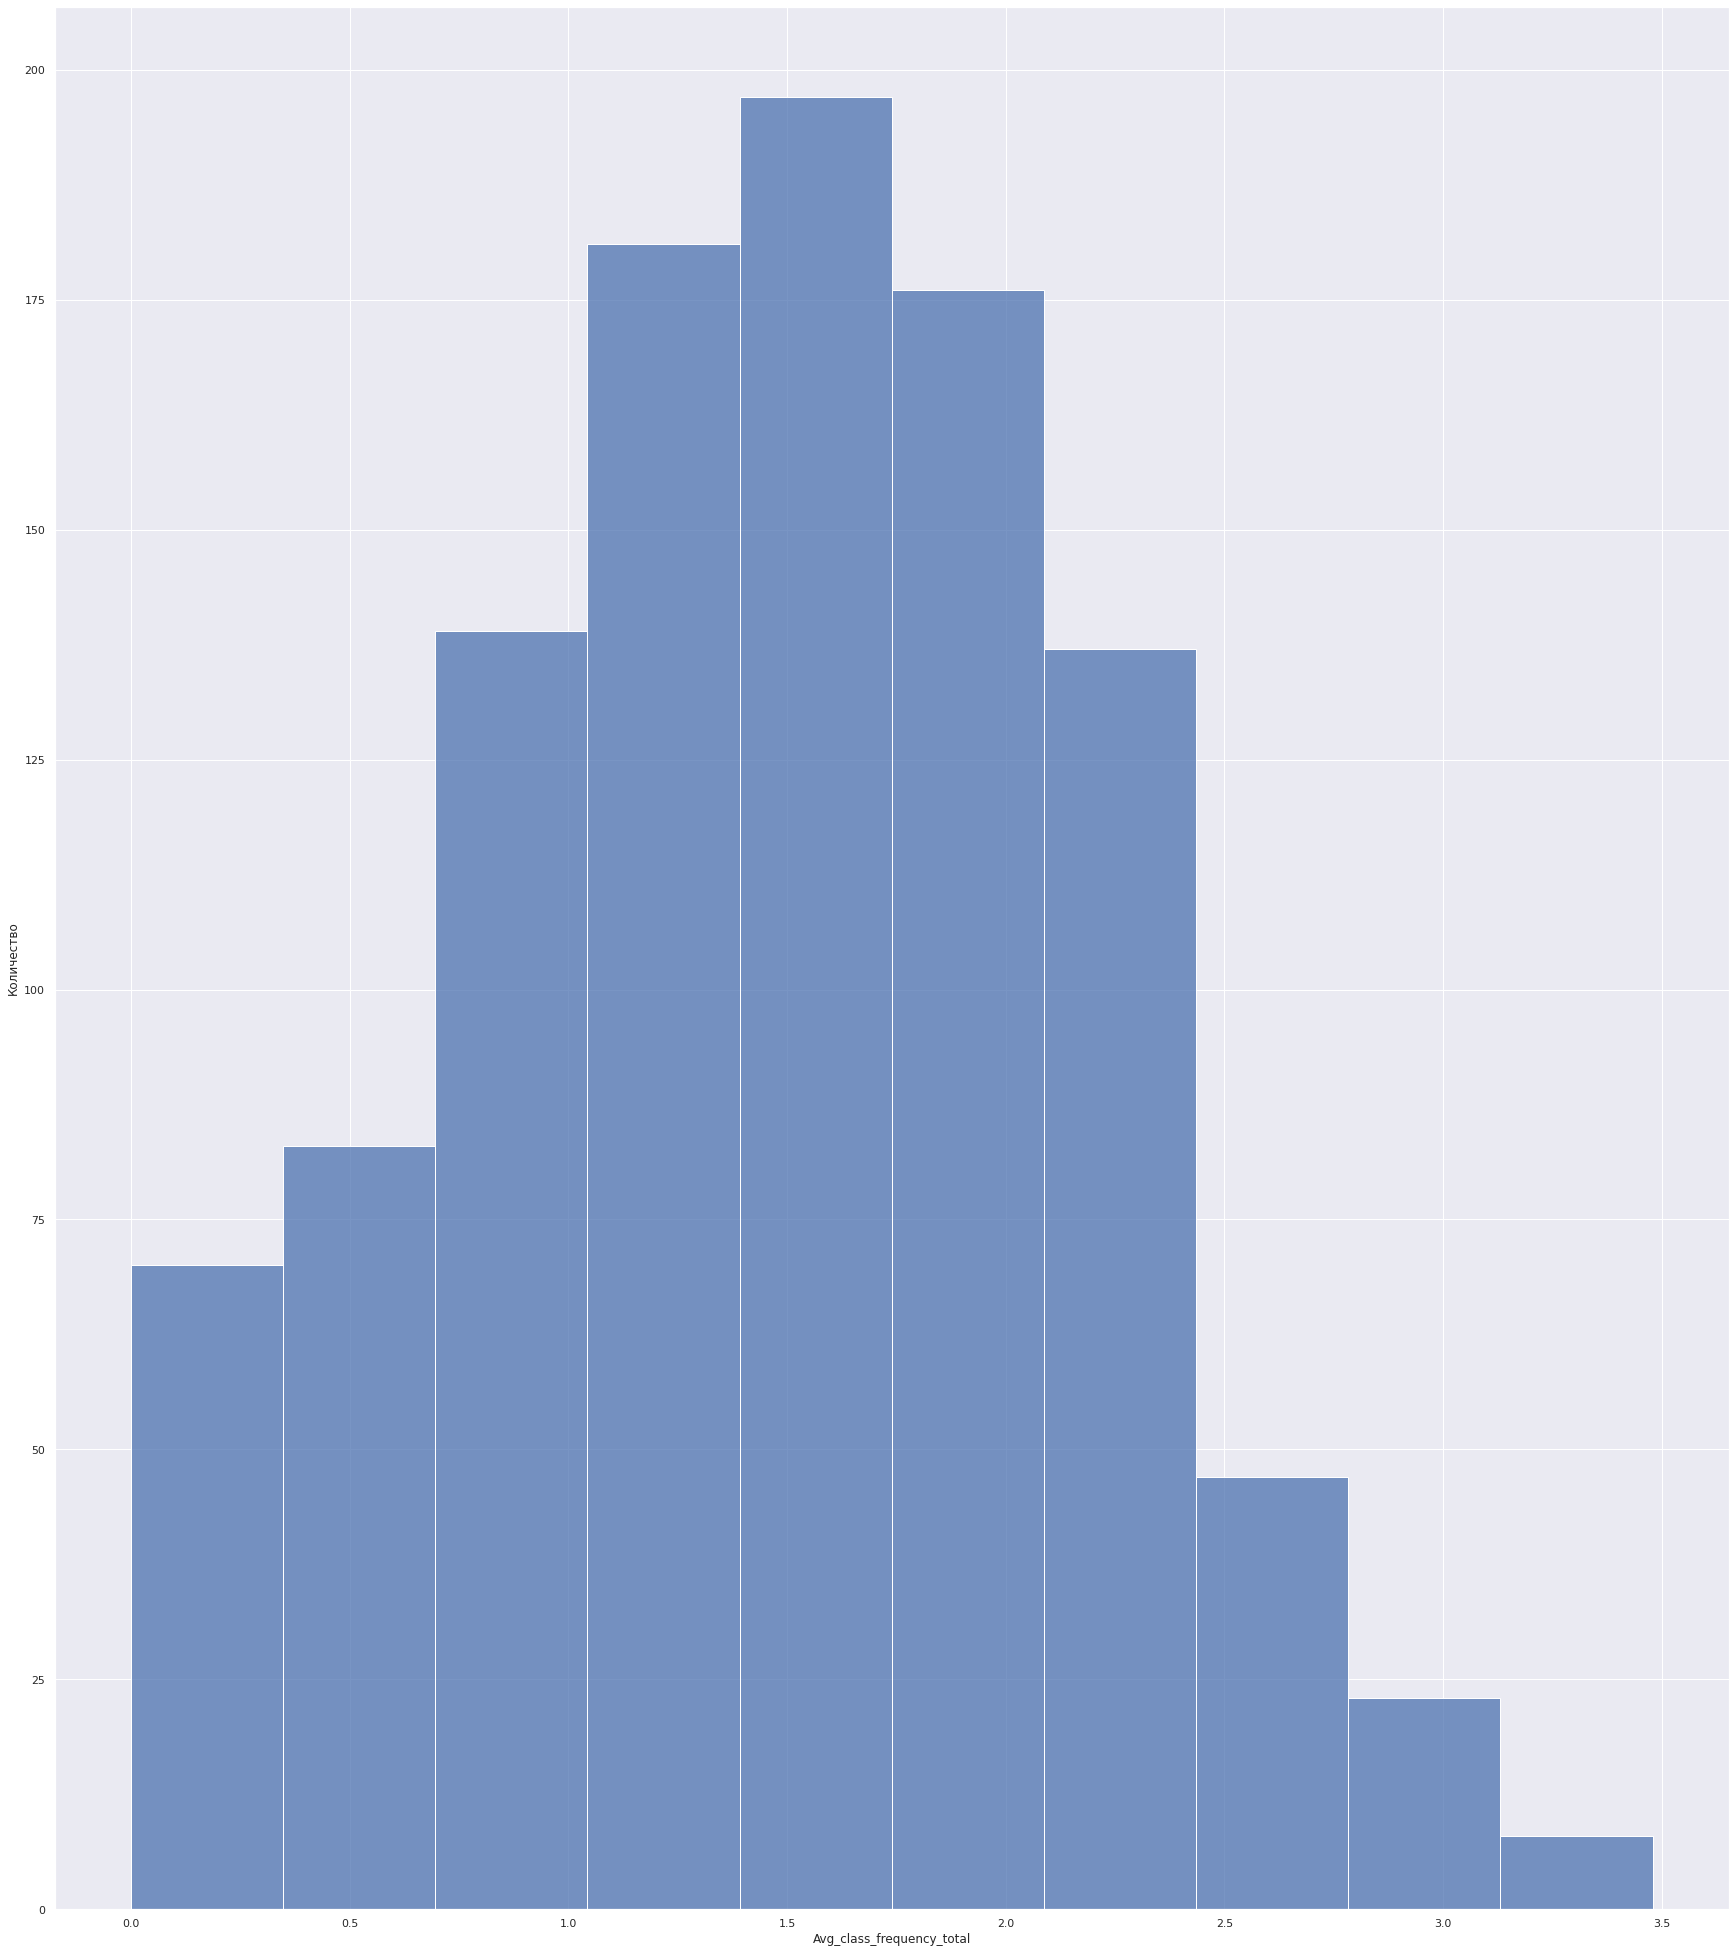

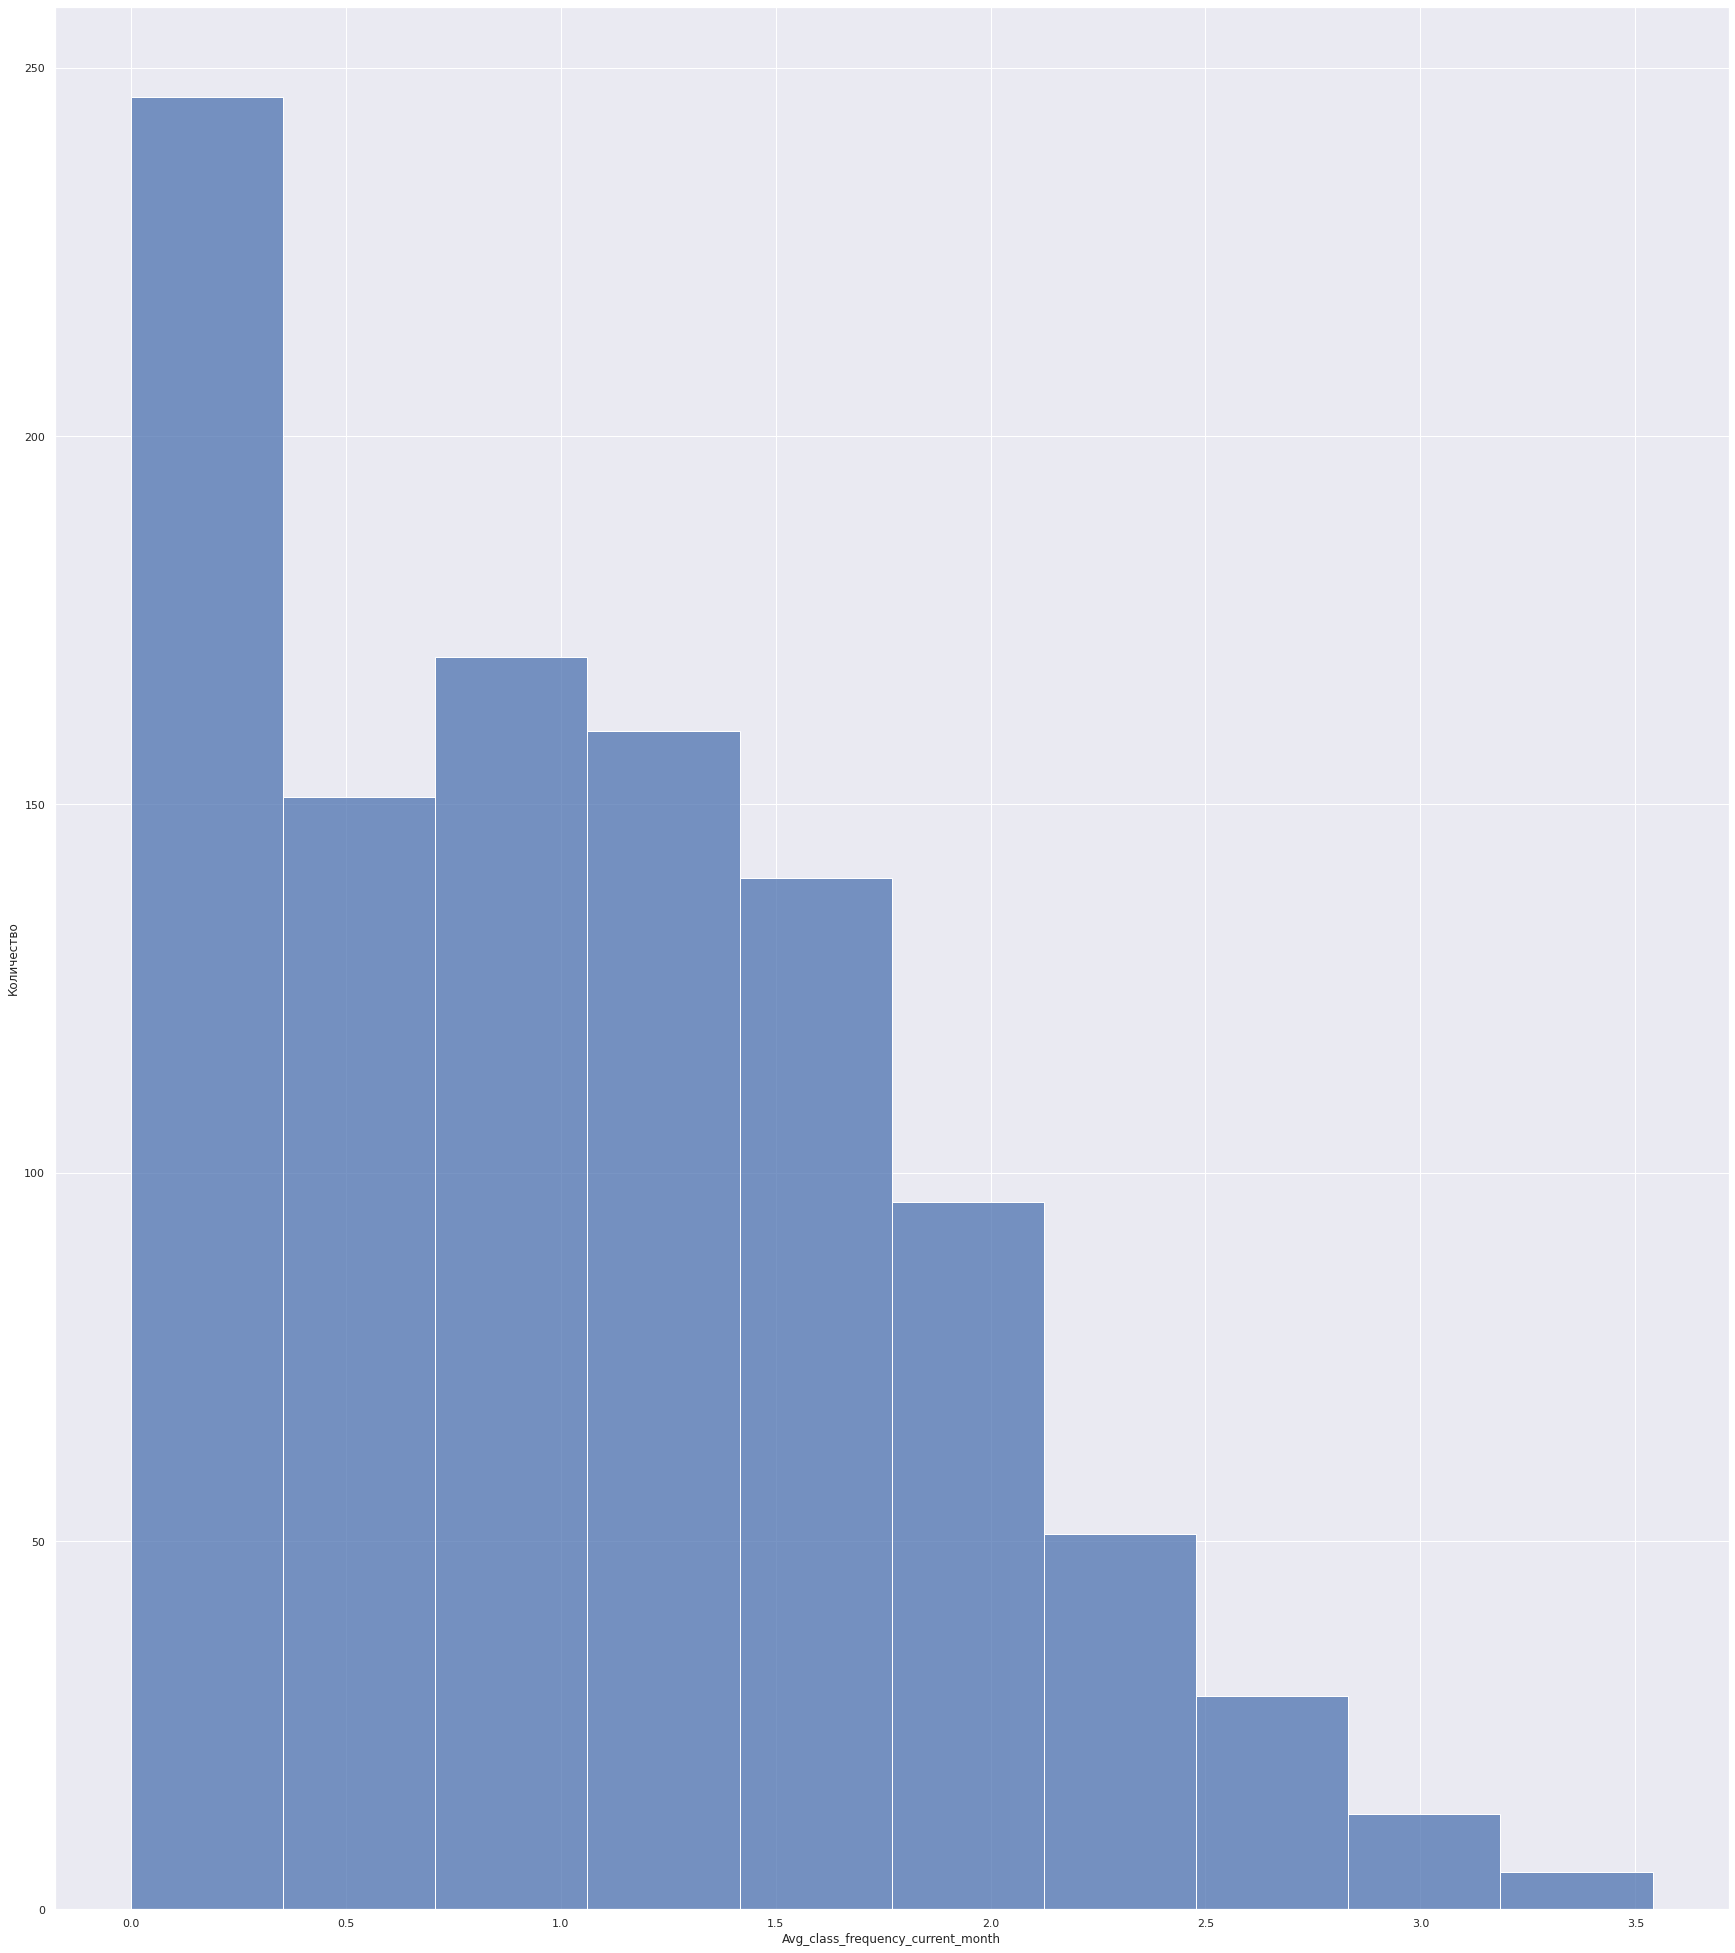

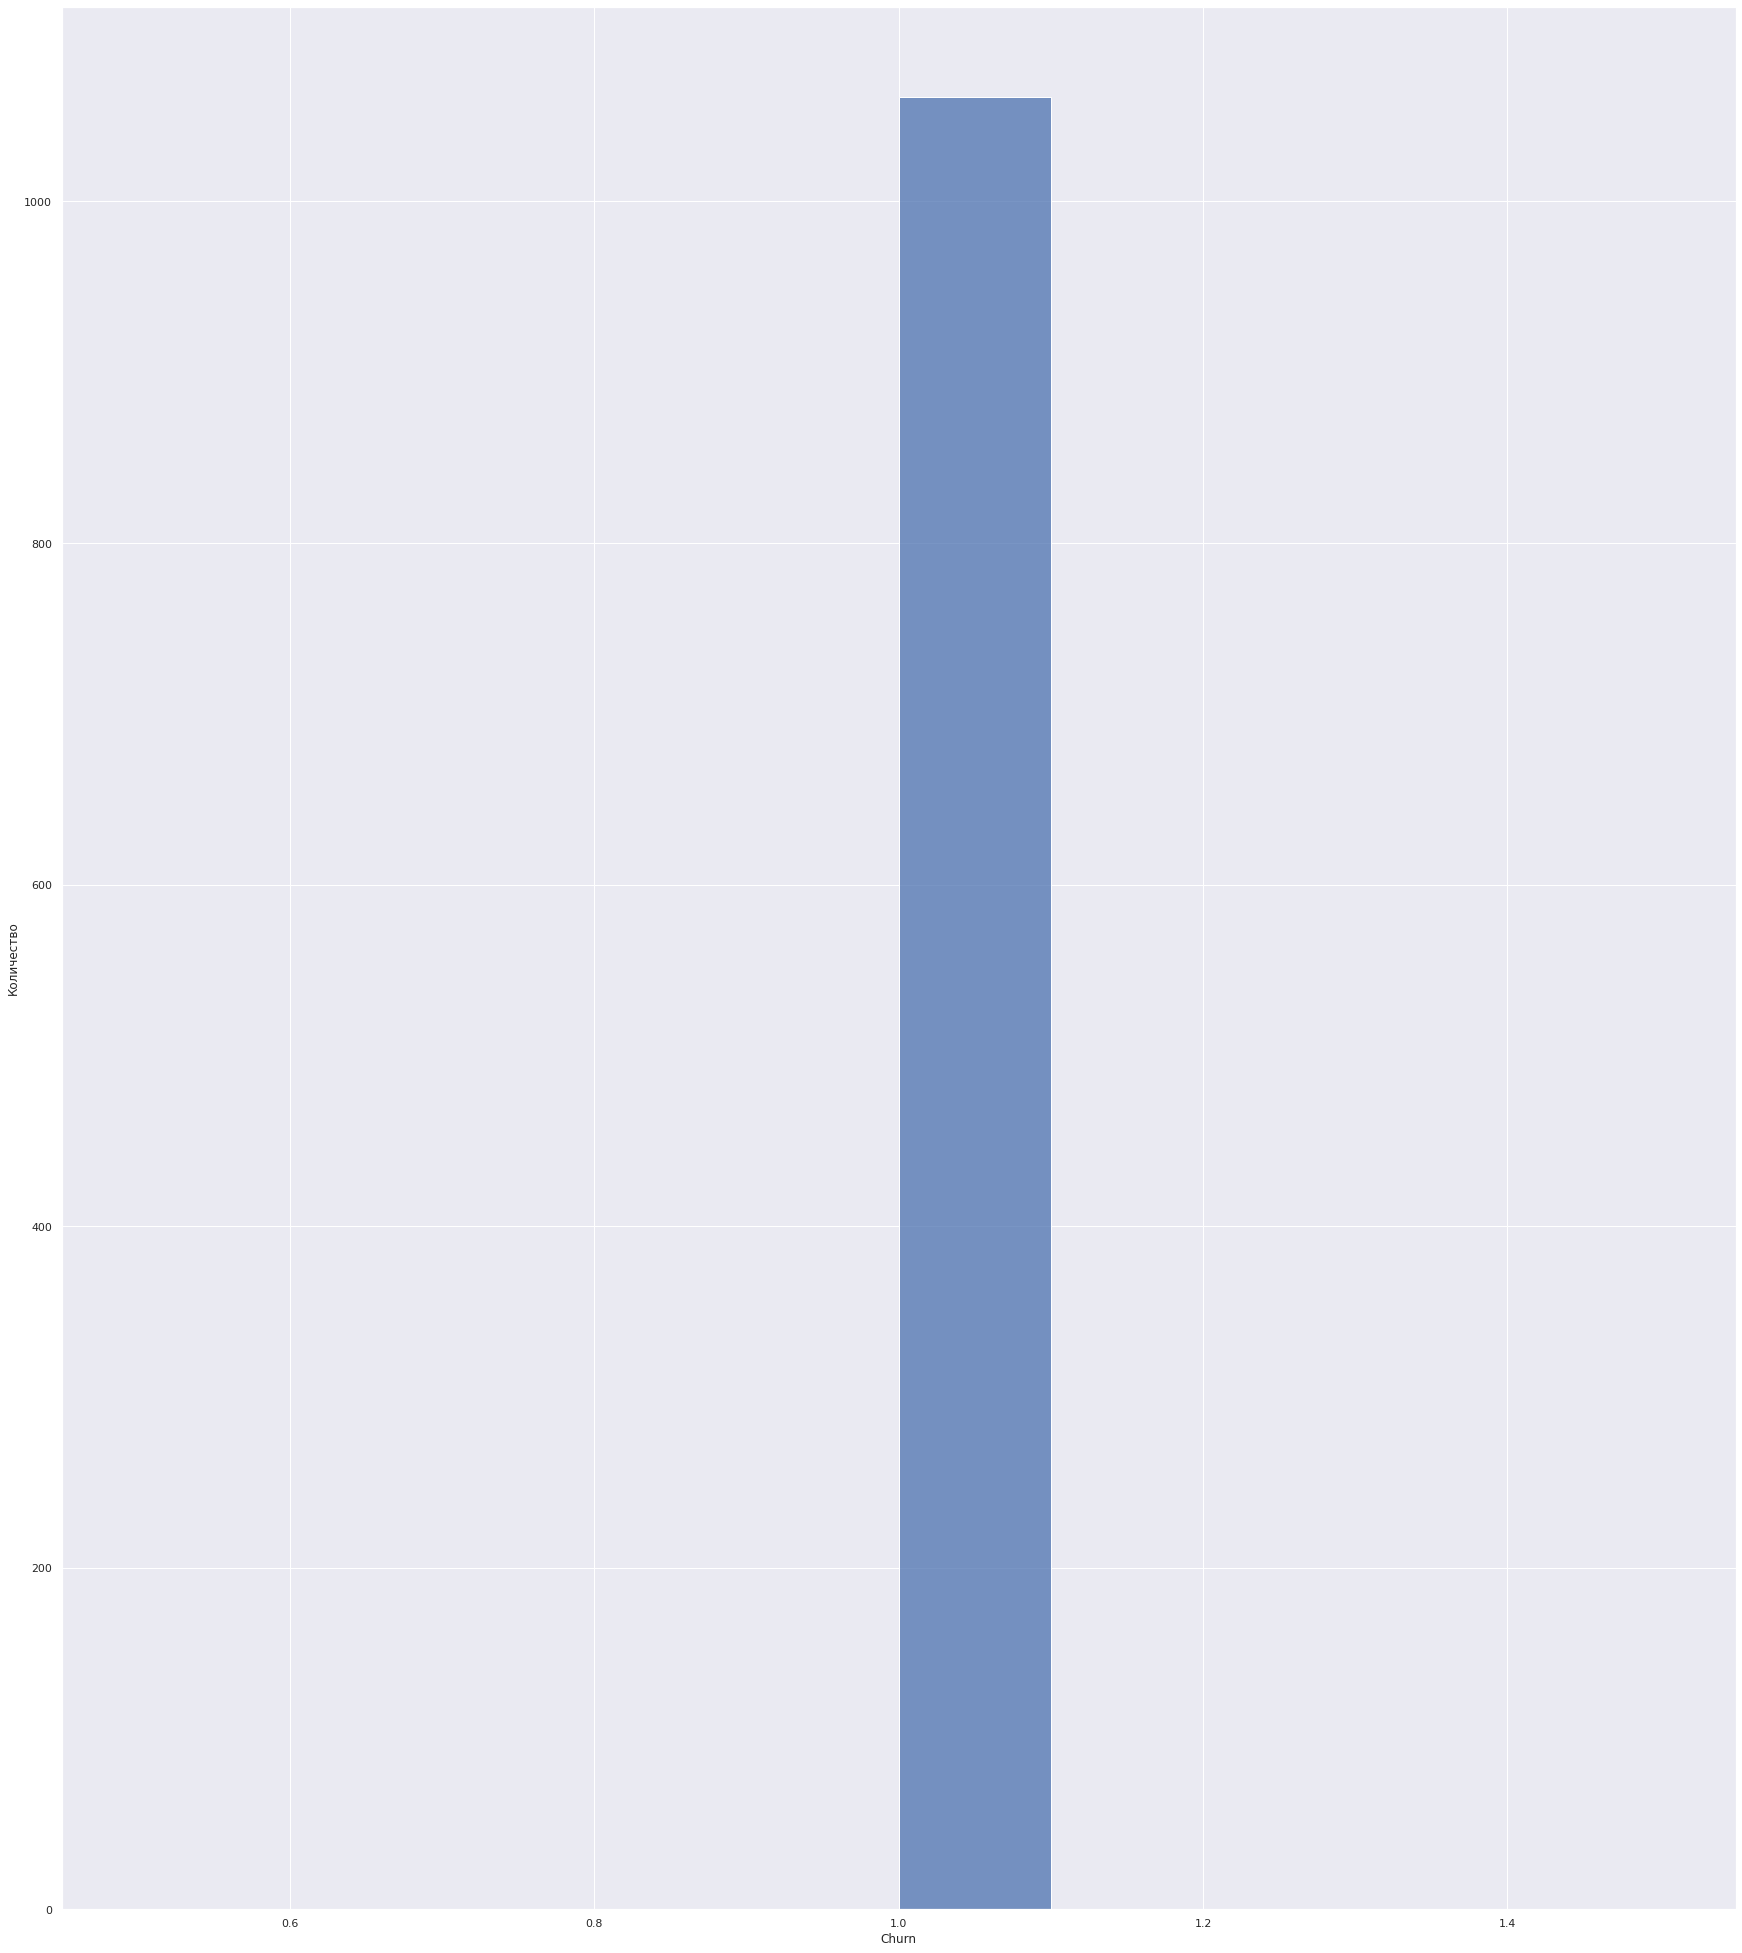

In [35]:
for feature in df.query('Churn == 1').columns:
    p = sns.histplot(df.query('Churn == 1')[feature], bins=10)
    p.set_ylabel('Количество')
    plt.show() 

**Выводы по посетителям, которые закончили заниматься:**
- Преобладает также гендер 1
- Пробладает доля тех, кто живет рядом, но тех, кто живет рядом доля больше по сравнению с группой, продолжившей заниматься
- Тратили на дополнительные услуги меньше примерно на 100
- Аболюстная доля тех, кто покупал абонемент меньше чем на месяц

### Матрица корреляции признаков

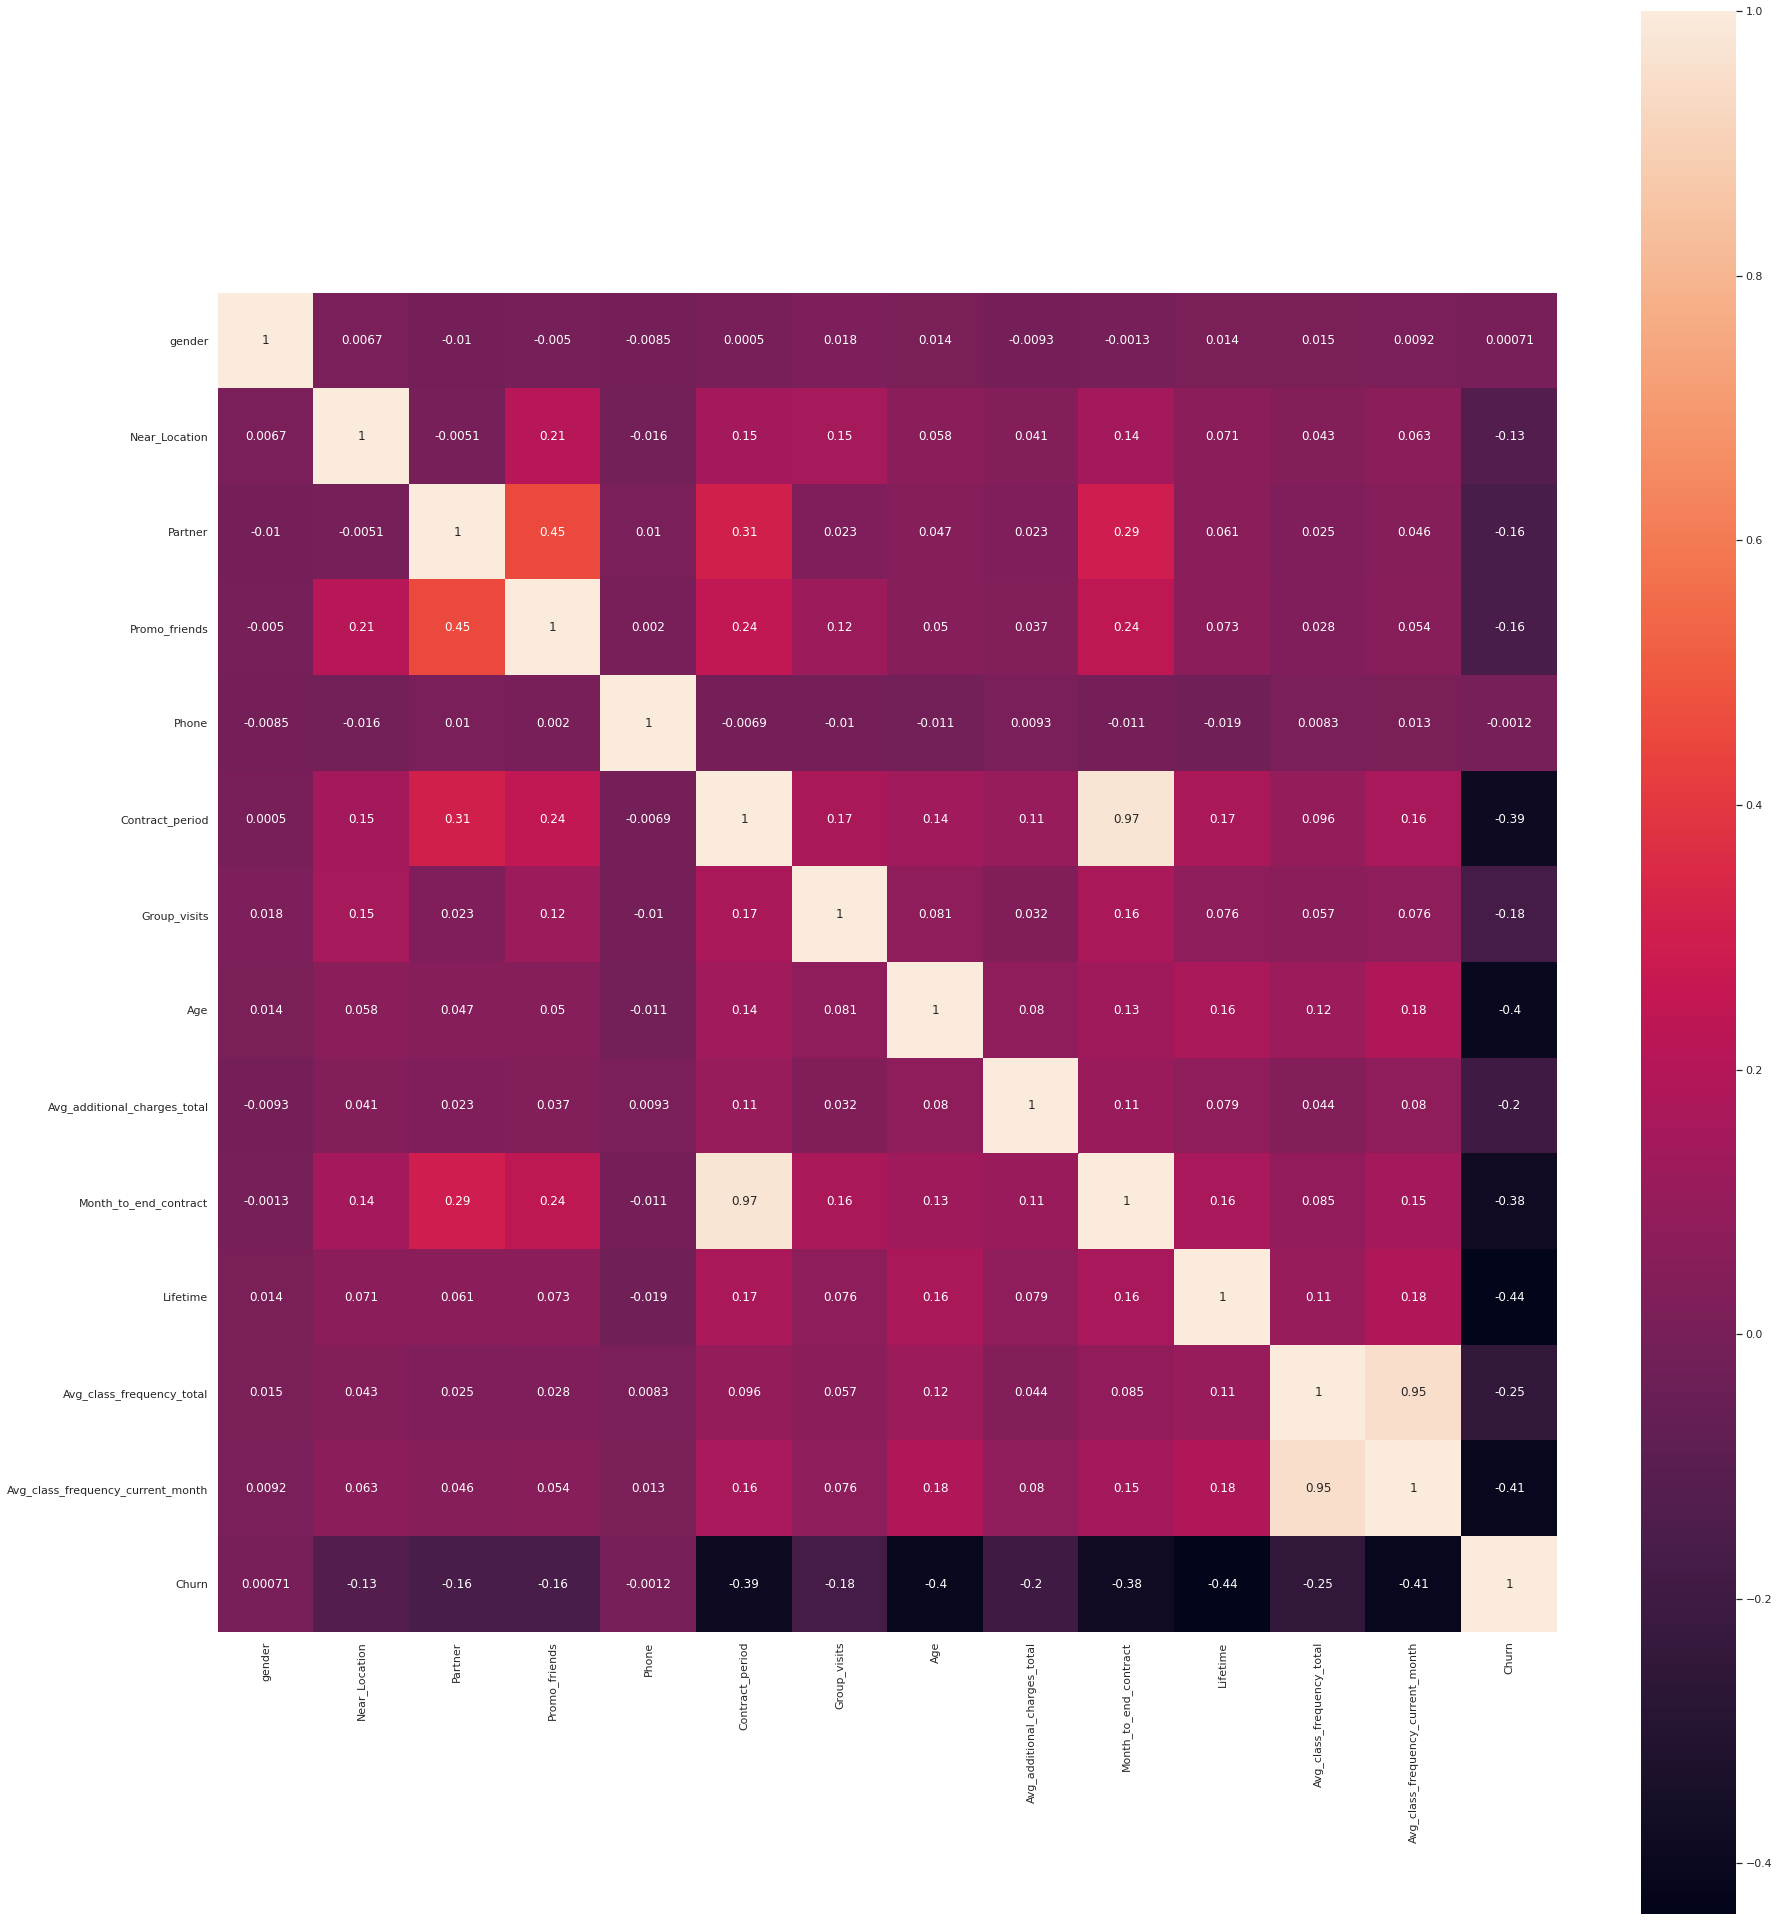

In [36]:
#построим и отрисуем матрицу корреляций
cm = df.corr() #вычисляем матрицу корреляций
#fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.set(rc = {'figure.figsize':(30,35)})
sns.heatmap(cm, annot=True, square=True) #ваш код здесь
#ax.set_ylim(
   # 14, 0
#)  # корректировка "рваных" полей heatmap в последней версии библиотеки
#sns.set(font_scale=)
plt.show()

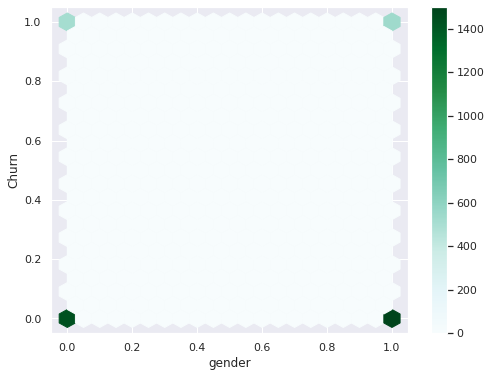

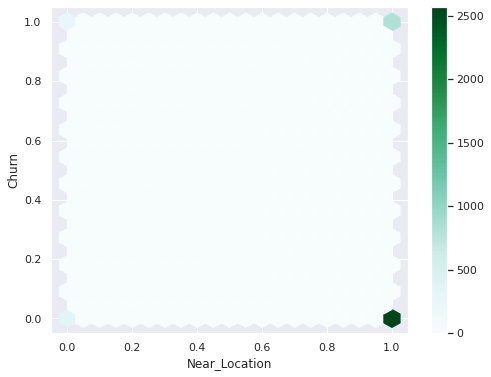

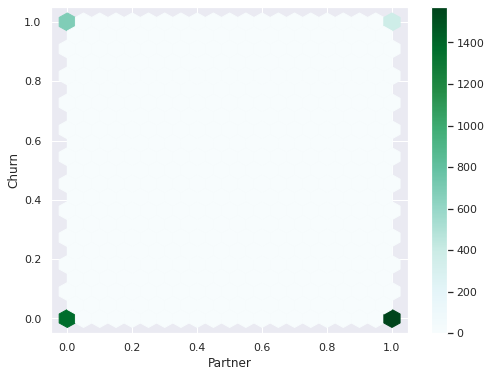

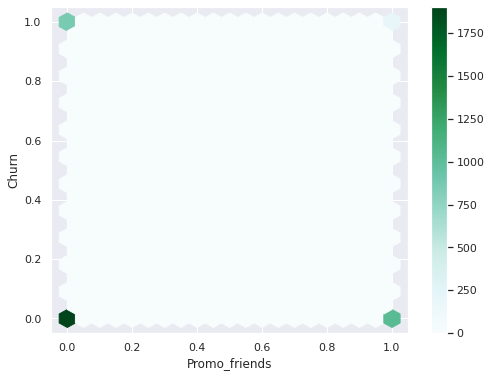

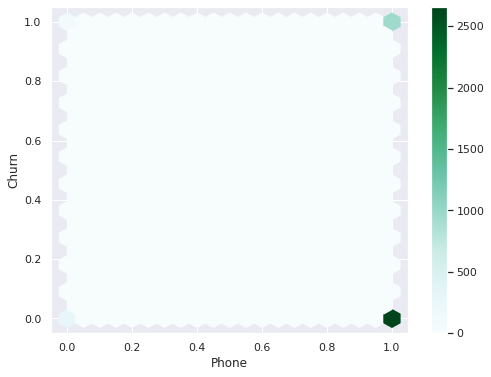

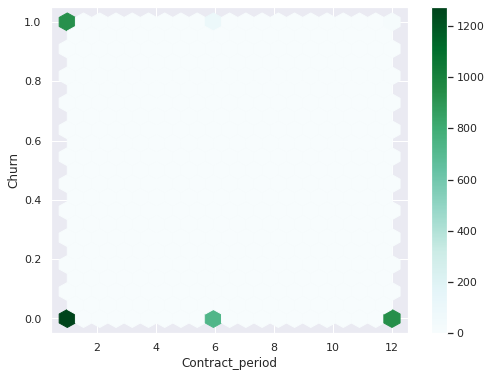

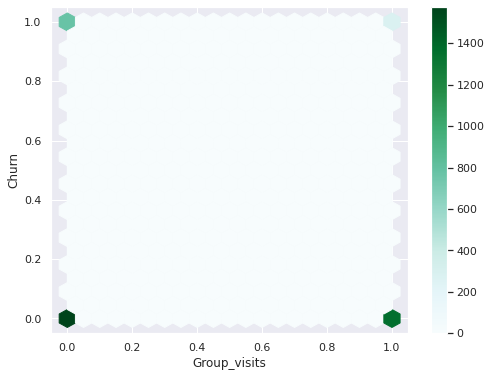

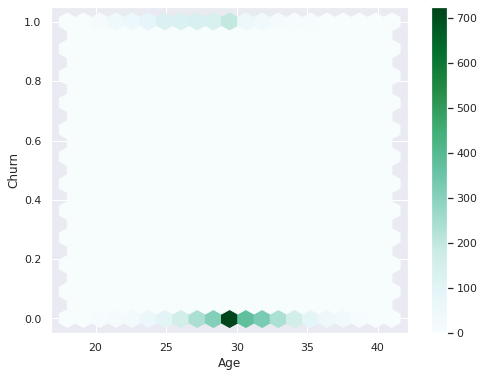

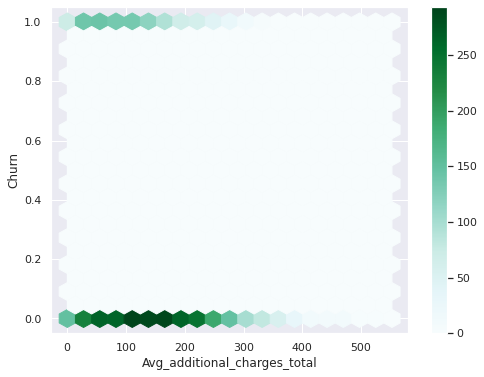

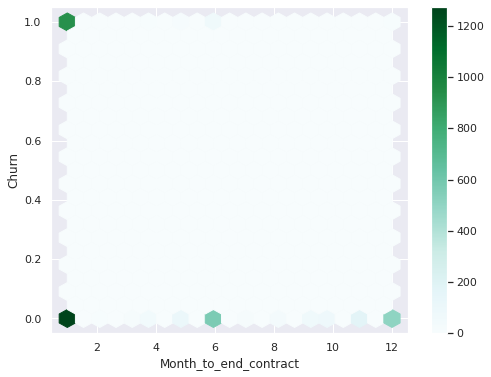

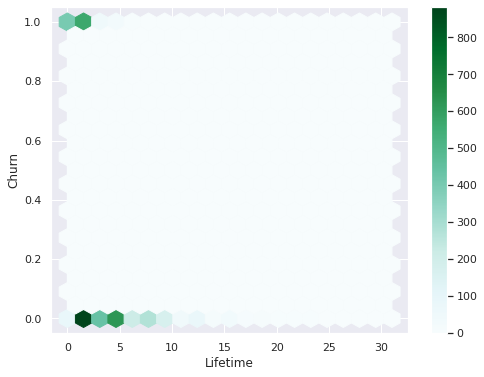

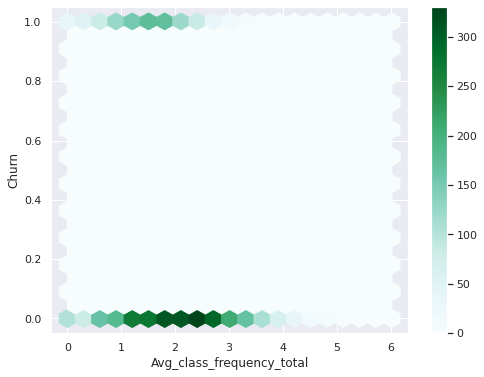

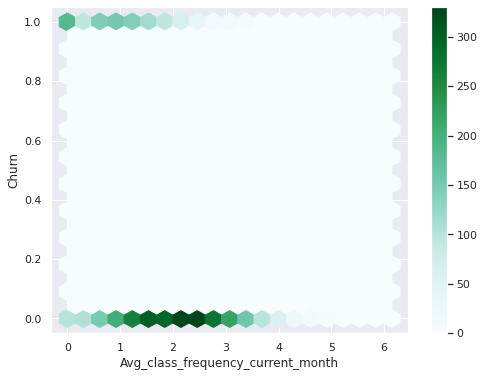

In [37]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in df.drop('Churn', axis = 1).columns:
    #sns.set(rc = {'figure.figsize':(10,10)})
    #sns.scatterplot(x=df[col], y=df['Churn']) #ваш код здесь
    df.plot(x=col, y='Churn', kind='hexbin', gridsize=20,
            figsize=(8, 6), sharex=False, grid=True)
    plt.show()

**Выводы по корреляции:**
- Признак Month_to_end_contract и contract period корреляруют с 97 значением
- Признаки AVG_class_frequency_total и AVG_class_frequency_curren_month корреляируют с 95 значением
- Признаки: AVG_class_frequency_curren_month, Lifetime, Month_to_end_contract, Age, Contract_period имеют бОльшую корреляцию с целевых признаком

### Удаление коррелирующих признаков

Данные признаки имеют меньшую корреляцию с целевых признаком:

In [38]:
df = df.drop(['Month_to_end_contract', 'Avg_class_frequency_total'] , axis=1)

## Шаг. Построение модели прогрозирования оттока клиентов.

### Разделение выборки

Разделим выборку на признаки и таргет:

In [39]:
X = df.drop('Churn', axis=1)
y = df['Churn']

### Стандартизация признаков

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)

### Обучение моделей

In [42]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(),
    CatBoostClassifier(verbose=0, depth=6, iterations=100, learning_rate=0.04),
    DummyClassifier(strategy="prior")
]

In [43]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print(
        'Accuracy:{:.2f} || Precision:{:.2f} || Recall:{:.2f} || F1:{:.2f} || ROC-AUC Score:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, probabilities),
            f1_score(y_test, y_pred),
        )
    )
    print()

In [44]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression()
Accuracy:0.92 || Precision:0.86 || Recall:0.83 || F1:0.97 || ROC-AUC Score:0.84

DecisionTreeClassifier(random_state=42)
Accuracy:0.86 || Precision:0.74 || Recall:0.75 || F1:0.83 || ROC-AUC Score:0.75

RandomForestClassifier(random_state=42)
Accuracy:0.90 || Precision:0.83 || Recall:0.79 || F1:0.96 || ROC-AUC Score:0.81

GradientBoostingClassifier()
Accuracy:0.91 || Precision:0.86 || Recall:0.81 || F1:0.96 || ROC-AUC Score:0.83

Accuracy:0.92 || Precision:0.88 || Recall:0.82 || F1:0.96 || ROC-AUC Score:0.85

DummyClassifier()
Accuracy:0.73 || Precision:0.00 || Recall:0.00 || F1:0.50 || ROC-AUC Score:0.00



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Все предложенные модели оказались лучше, чем DummyClassifier, а значит польза от такой модели выше, чем от обычного угадывания. 

Наиболее важным параметром является метрика Recall. Лучше направить средства на поддержание клиента, чтобы не ушел. В даном случае это окупится. 

На основании данной метрики с базовыми параметрами лучше показа себя модель линейной регресии. Для лучшего сравнения предлагаю взять модель CatBoostClassifier (т.к. это достаточно мощный алгоритм и без дополнительных параметров он показал достаточно хороший recall) и найти лучшеи для нее параметры. 

### Создание лучше модели

In [45]:
CatBoost = CatBoostClassifier(verbose=0)

In [46]:
param_grid_cat_boost = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [47]:
#Grid_CBC = GridSearchCV(estimator=CatBoost, param_grid = param_grid_cat_boost, cv = 2, n_jobs=-1, scoring='recall')
#Grid_CBC.fit(X_train, y_train)

In [48]:
#print(" Results from Grid Search ")
#print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
#print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
#print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Лучшими параметрами для CatBoostClassifier оказались:

The best score across ALL searched params:
 0.9074966605768718

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.04}

In [49]:
CatBoost = CatBoostClassifier(verbose=0, depth=6, iterations=100, learning_rate=0.04)

In [50]:
make_prediction(CatBoost, X_train_st, y_train, X_test_st, y_test)

Accuracy:0.92 || Precision:0.88 || Recall:0.82 || F1:0.96 || ROC-AUC Score:0.85



**Выводы по созднию модели для прогнозированния оттока клиентов:**
- Все предложенные модели оказались лучше, чем DummyClassifier, а значит польза от такой модели выше, чем от обычного угадывания.
- Наиболее важным параметром является метрика Recall. Лучше направить средства на поддержание клиента, чтобы не ушел. В даном случае это окупится.
- Лучше всех показала себя самая простая модель логистической регресии.

## Шаг. Кластеризация клиентов.

### Анализ данных для кластеризации

Построим матрицу расстояний:

In [51]:
scaler_for_clasters = StandardScaler()
X_scaled_clasters = scaler_for_clasters.fit_transform(X)

linked = linkage(X_scaled_clasters, method = 'ward') 

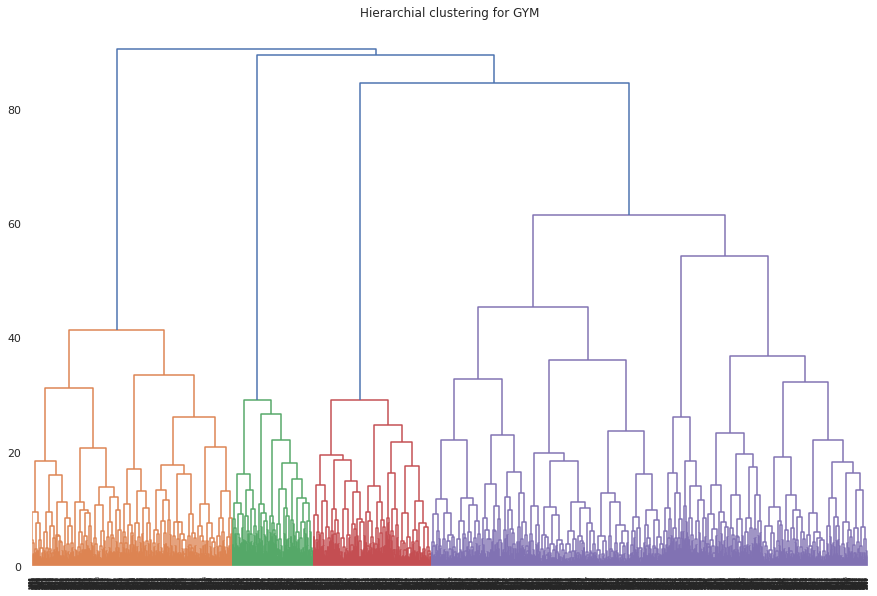

In [52]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.ylabel('')
plt.show() 

- По дендограмме видно, что оптимальное число кластеров будет в районе 5. Всего выделено 4 цвета, однако последний цвет разделен на две большие группы.

### Обучение модели кластеризации

In [54]:
km = KMeans(n_clusters=5, random_state=42)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_scaled_clasters)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean().sort_values(by='Churn', ascending=False)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.498214,0.000000,0.487500,0.078571,1.0,3.016071,0.233929,28.698214,137.520958,3.019643,1.601681,0.401786
4,0.484354,1.000000,0.934694,0.541497,1.0,2.715646,0.268027,28.278912,127.237836,2.674830,1.404365,0.372789
2,0.528288,1.000000,0.000000,0.055107,1.0,2.736958,0.405584,29.032329,142.722846,3.288024,1.705114,0.332109
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
1,0.506263,0.993737,0.840292,0.625261,1.0,9.886221,0.630480,30.332985,174.669326,5.475992,2.247335,0.007307


**Кластер №1 (с наименьшей долей оттока по кластеру) характеризуется:** 
- Повышеной средней длиной абонемента (9 месяцев)
- Повышенной вероятность быть сотрудником компании-партнера
- Приглашением друга в 60% случаев
- Посещением группового занятия в 60% случаев
- Повышенной (на 30 больше от ближайшего кластера) суммой покупок на доп. услуги
- Лайтаймом в 5 месяцев
- Посещением зала 2 раза в неделю

**Кластер №0 (с наибольшей долей оттока по кластеру) характеризуется:** 
- Длиной абонемента в среднем в 3 месяца
- Пониженной вероятность привода быть сотрудником компании-партнера
- Приглашением друга в всего в 7% случаев
- Посещением группового занятия в 23% случаев
- Пониженной суммой покупок на доп. услуги
- Лайтаймом в 3 месяца
- Посещением зала 1,6 раза в неделю в среднем

Построим графики распределения для признаков по кластерам:

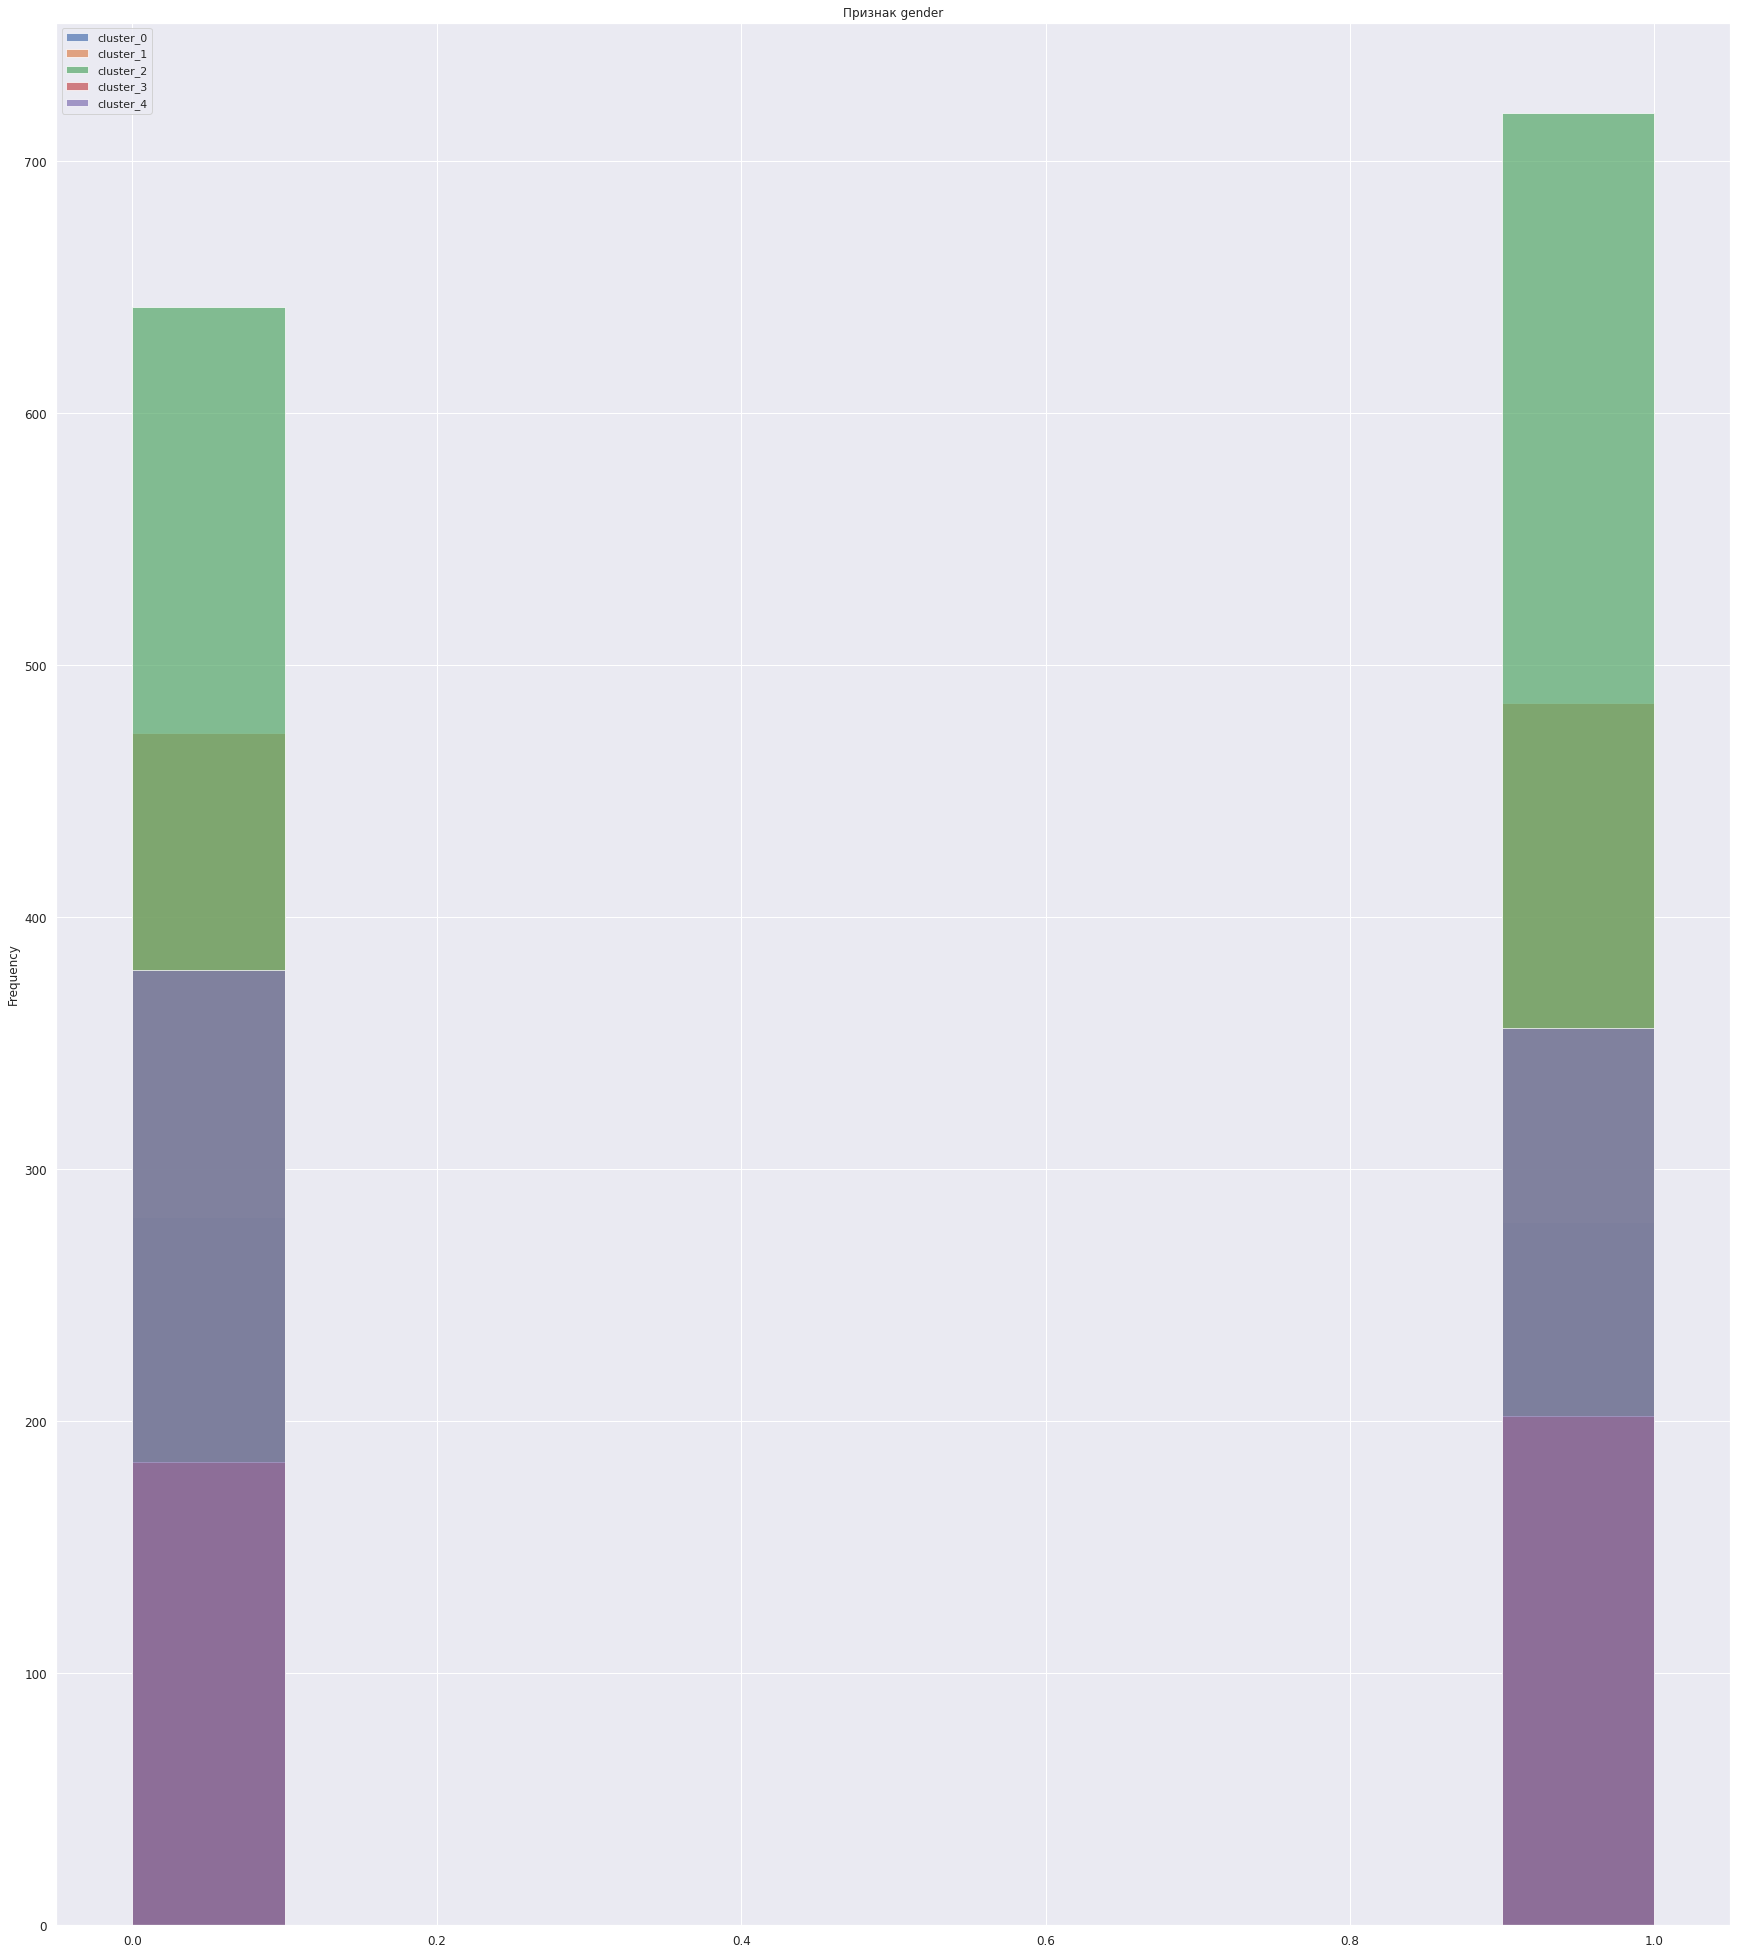

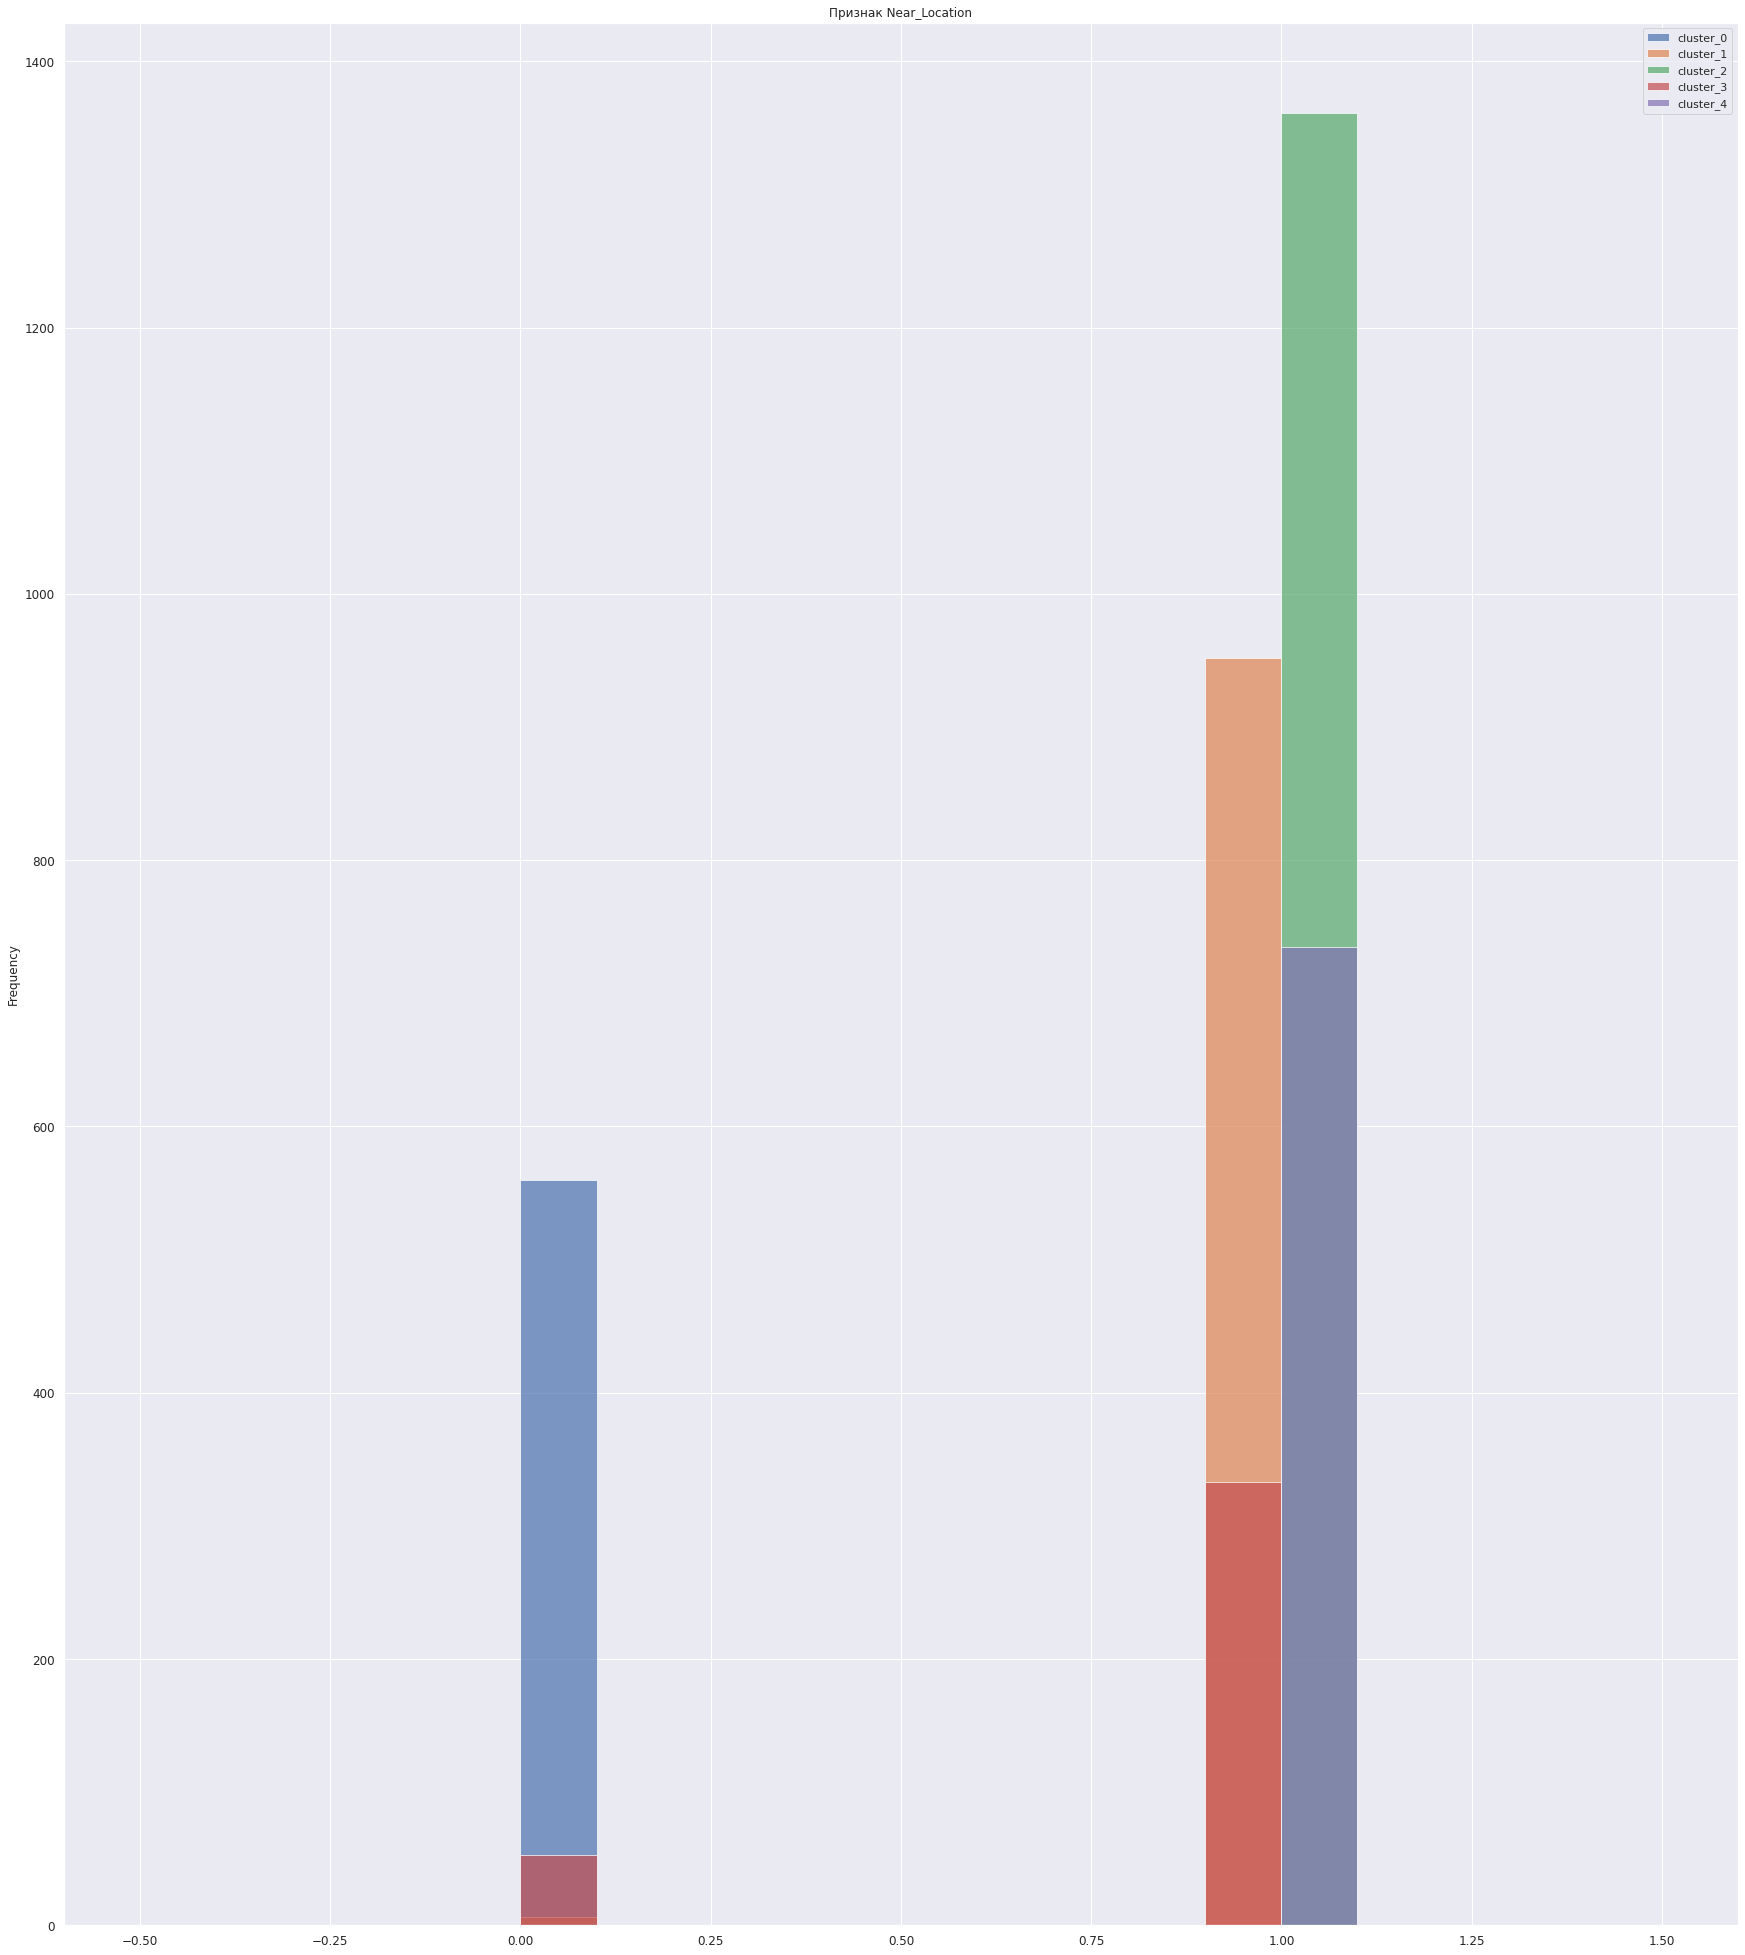

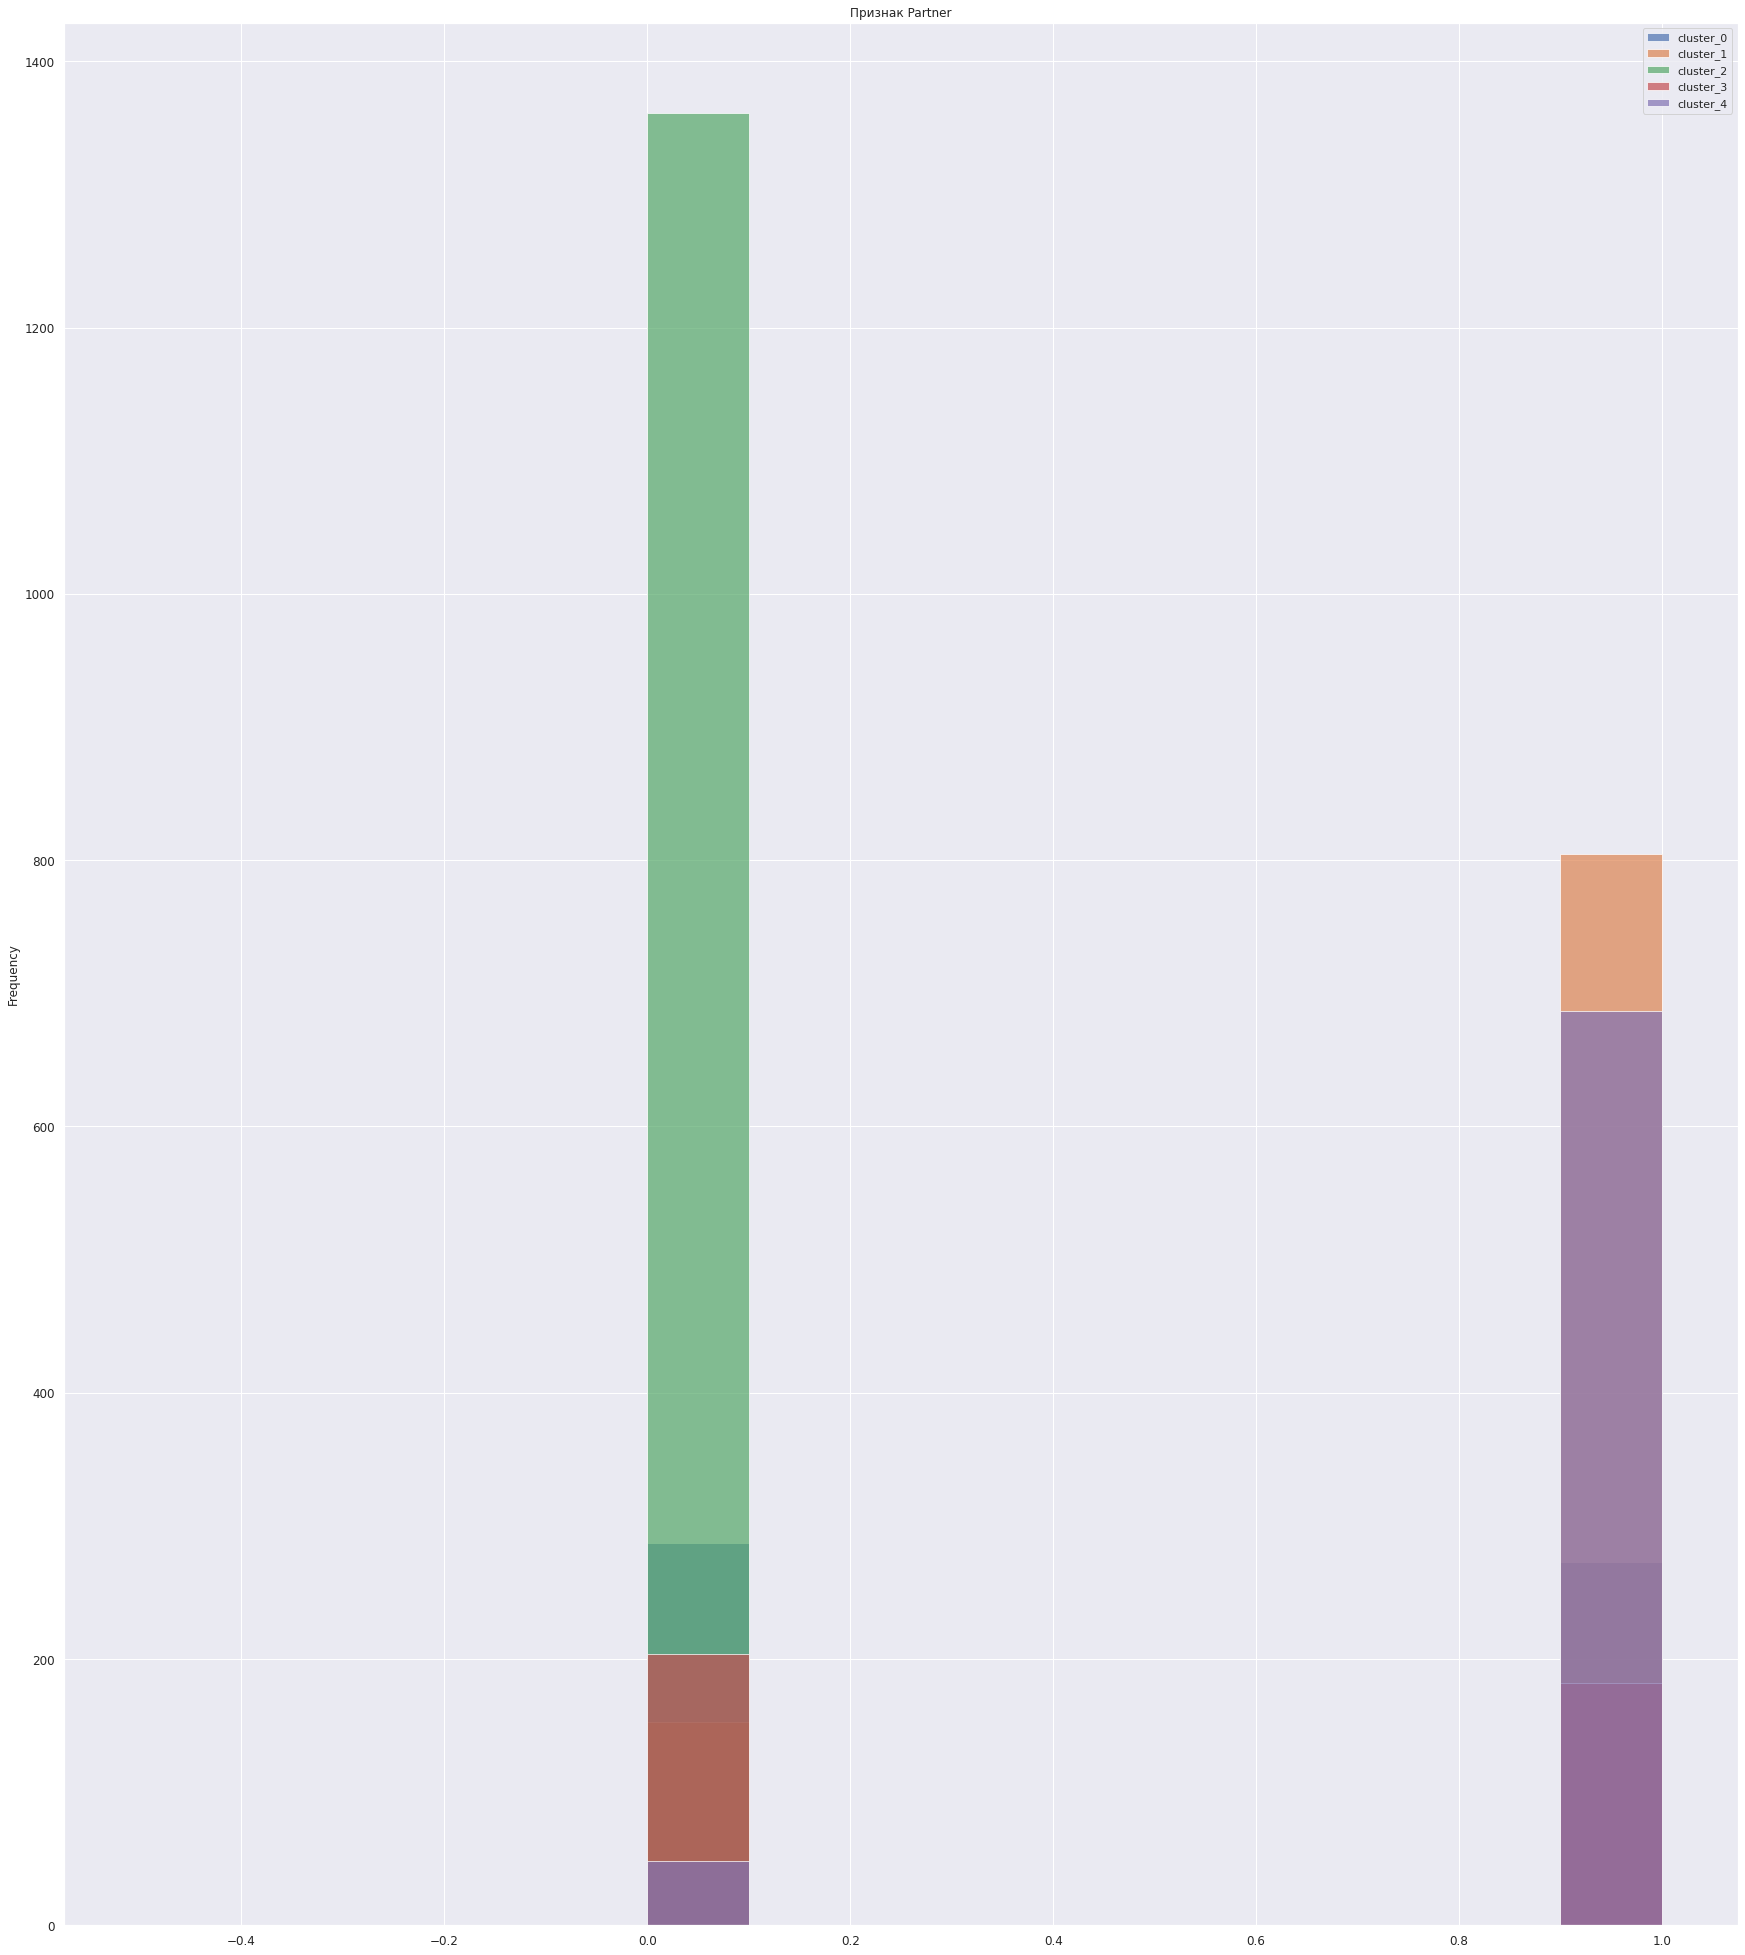

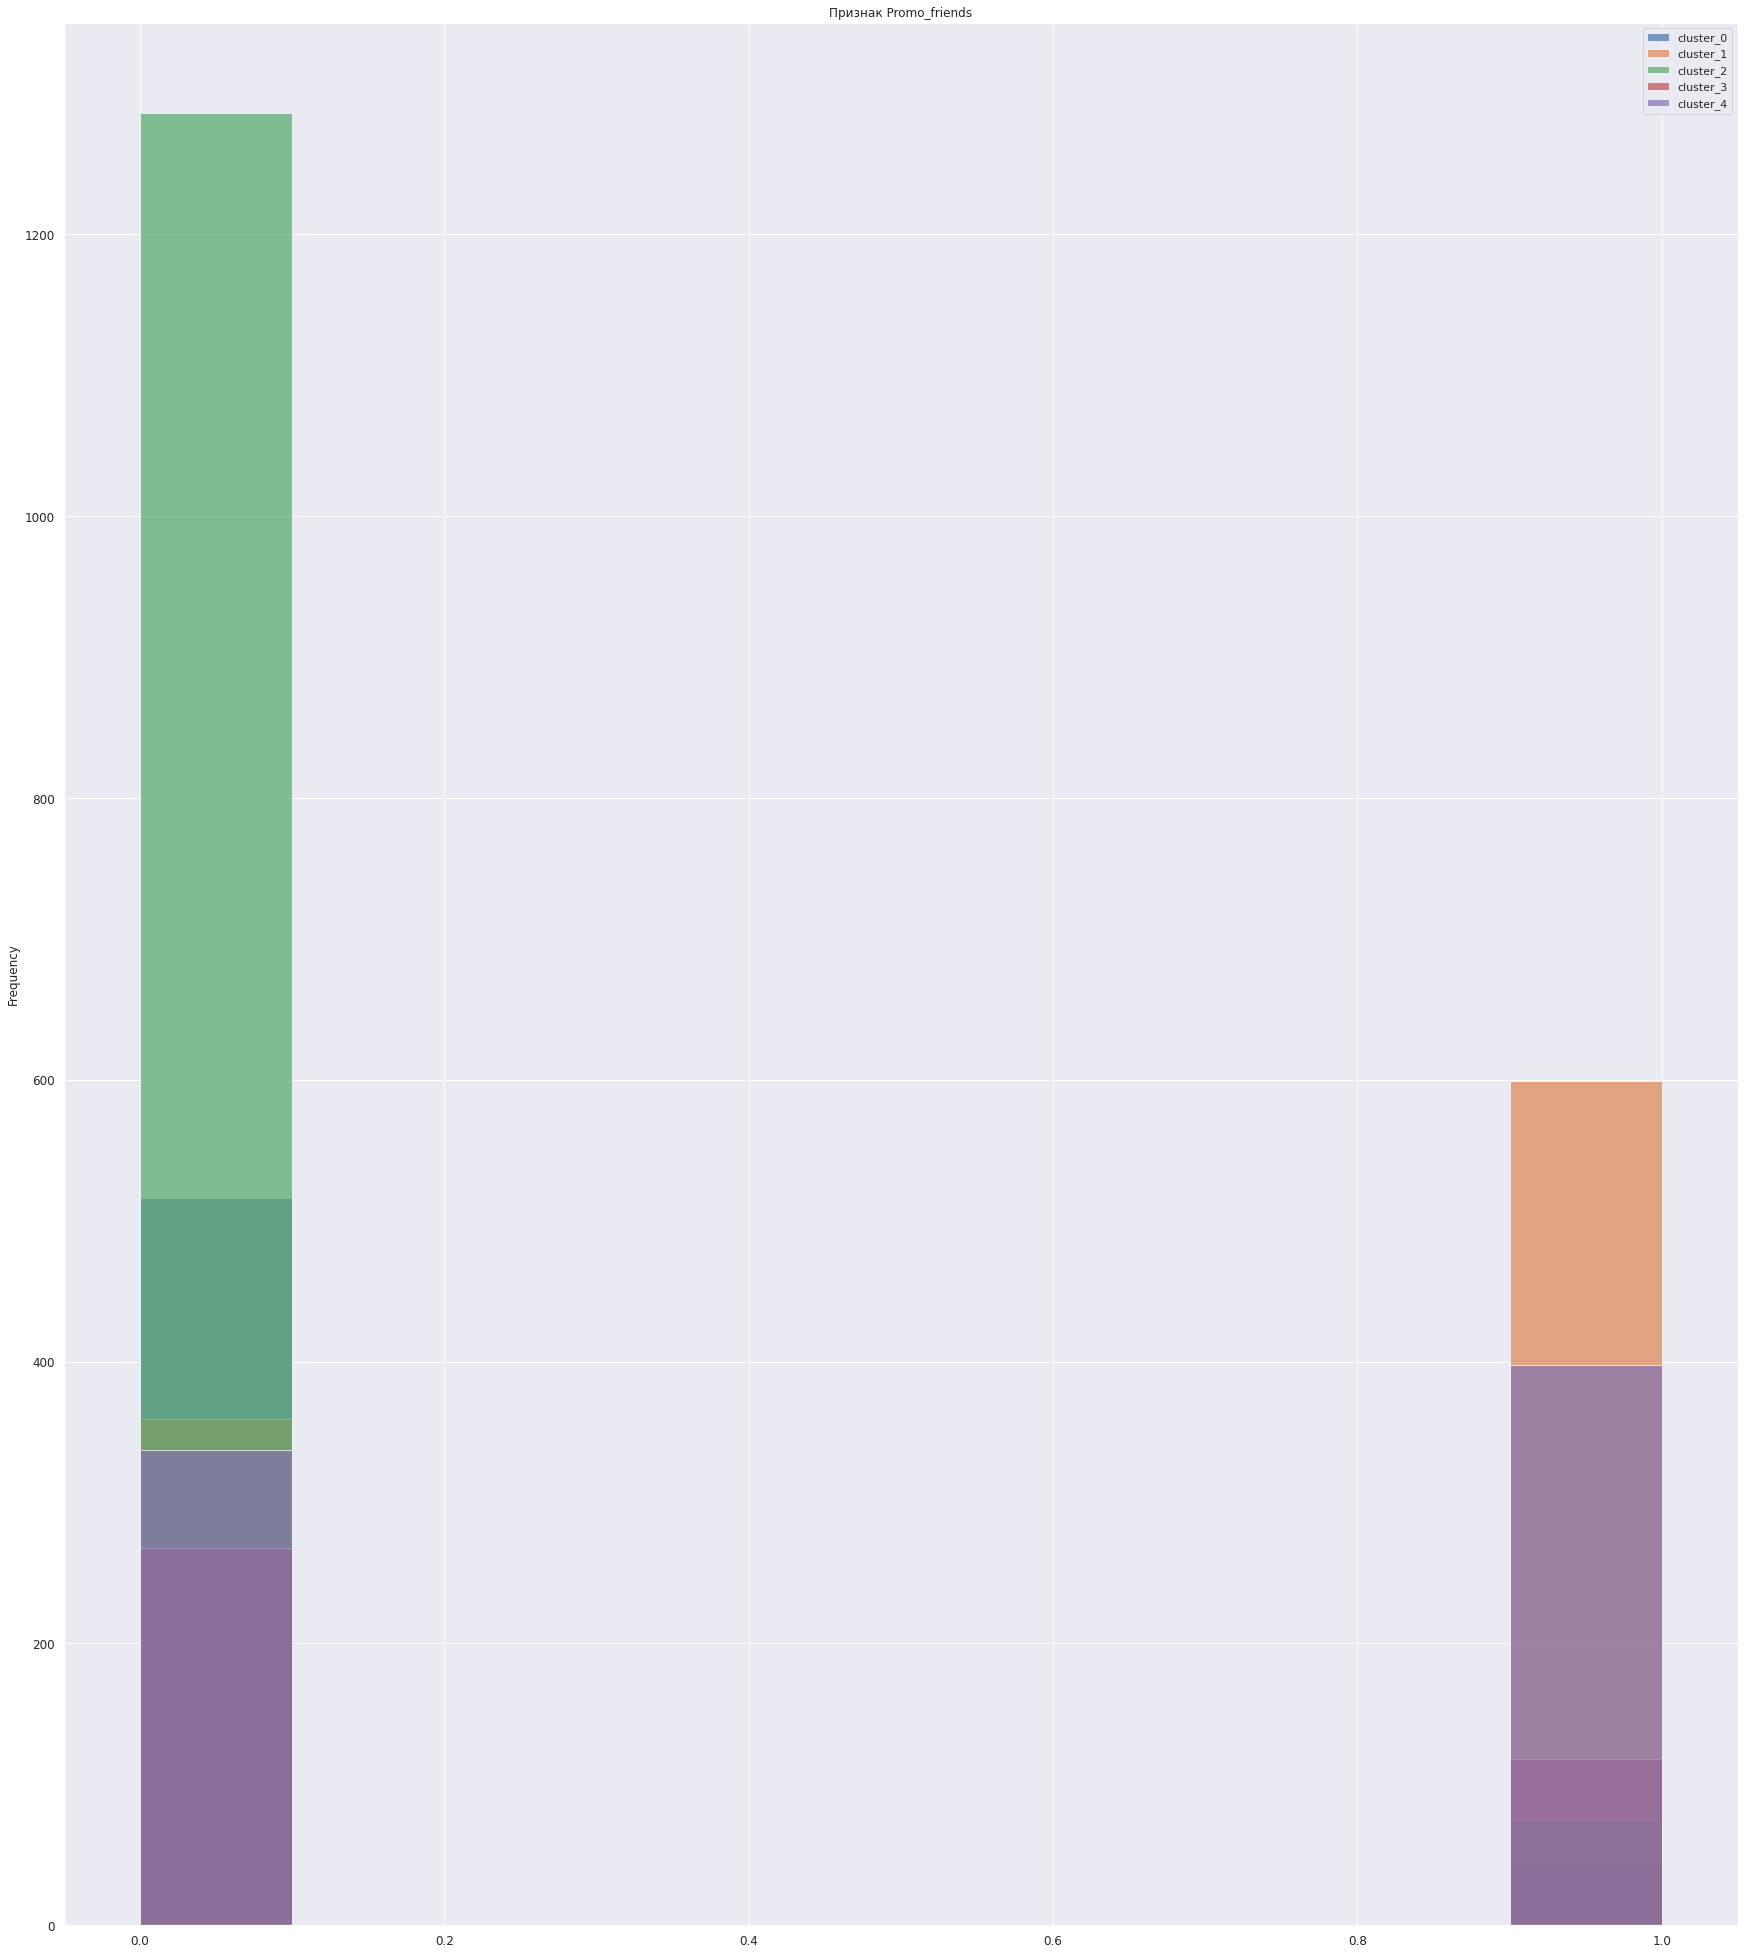

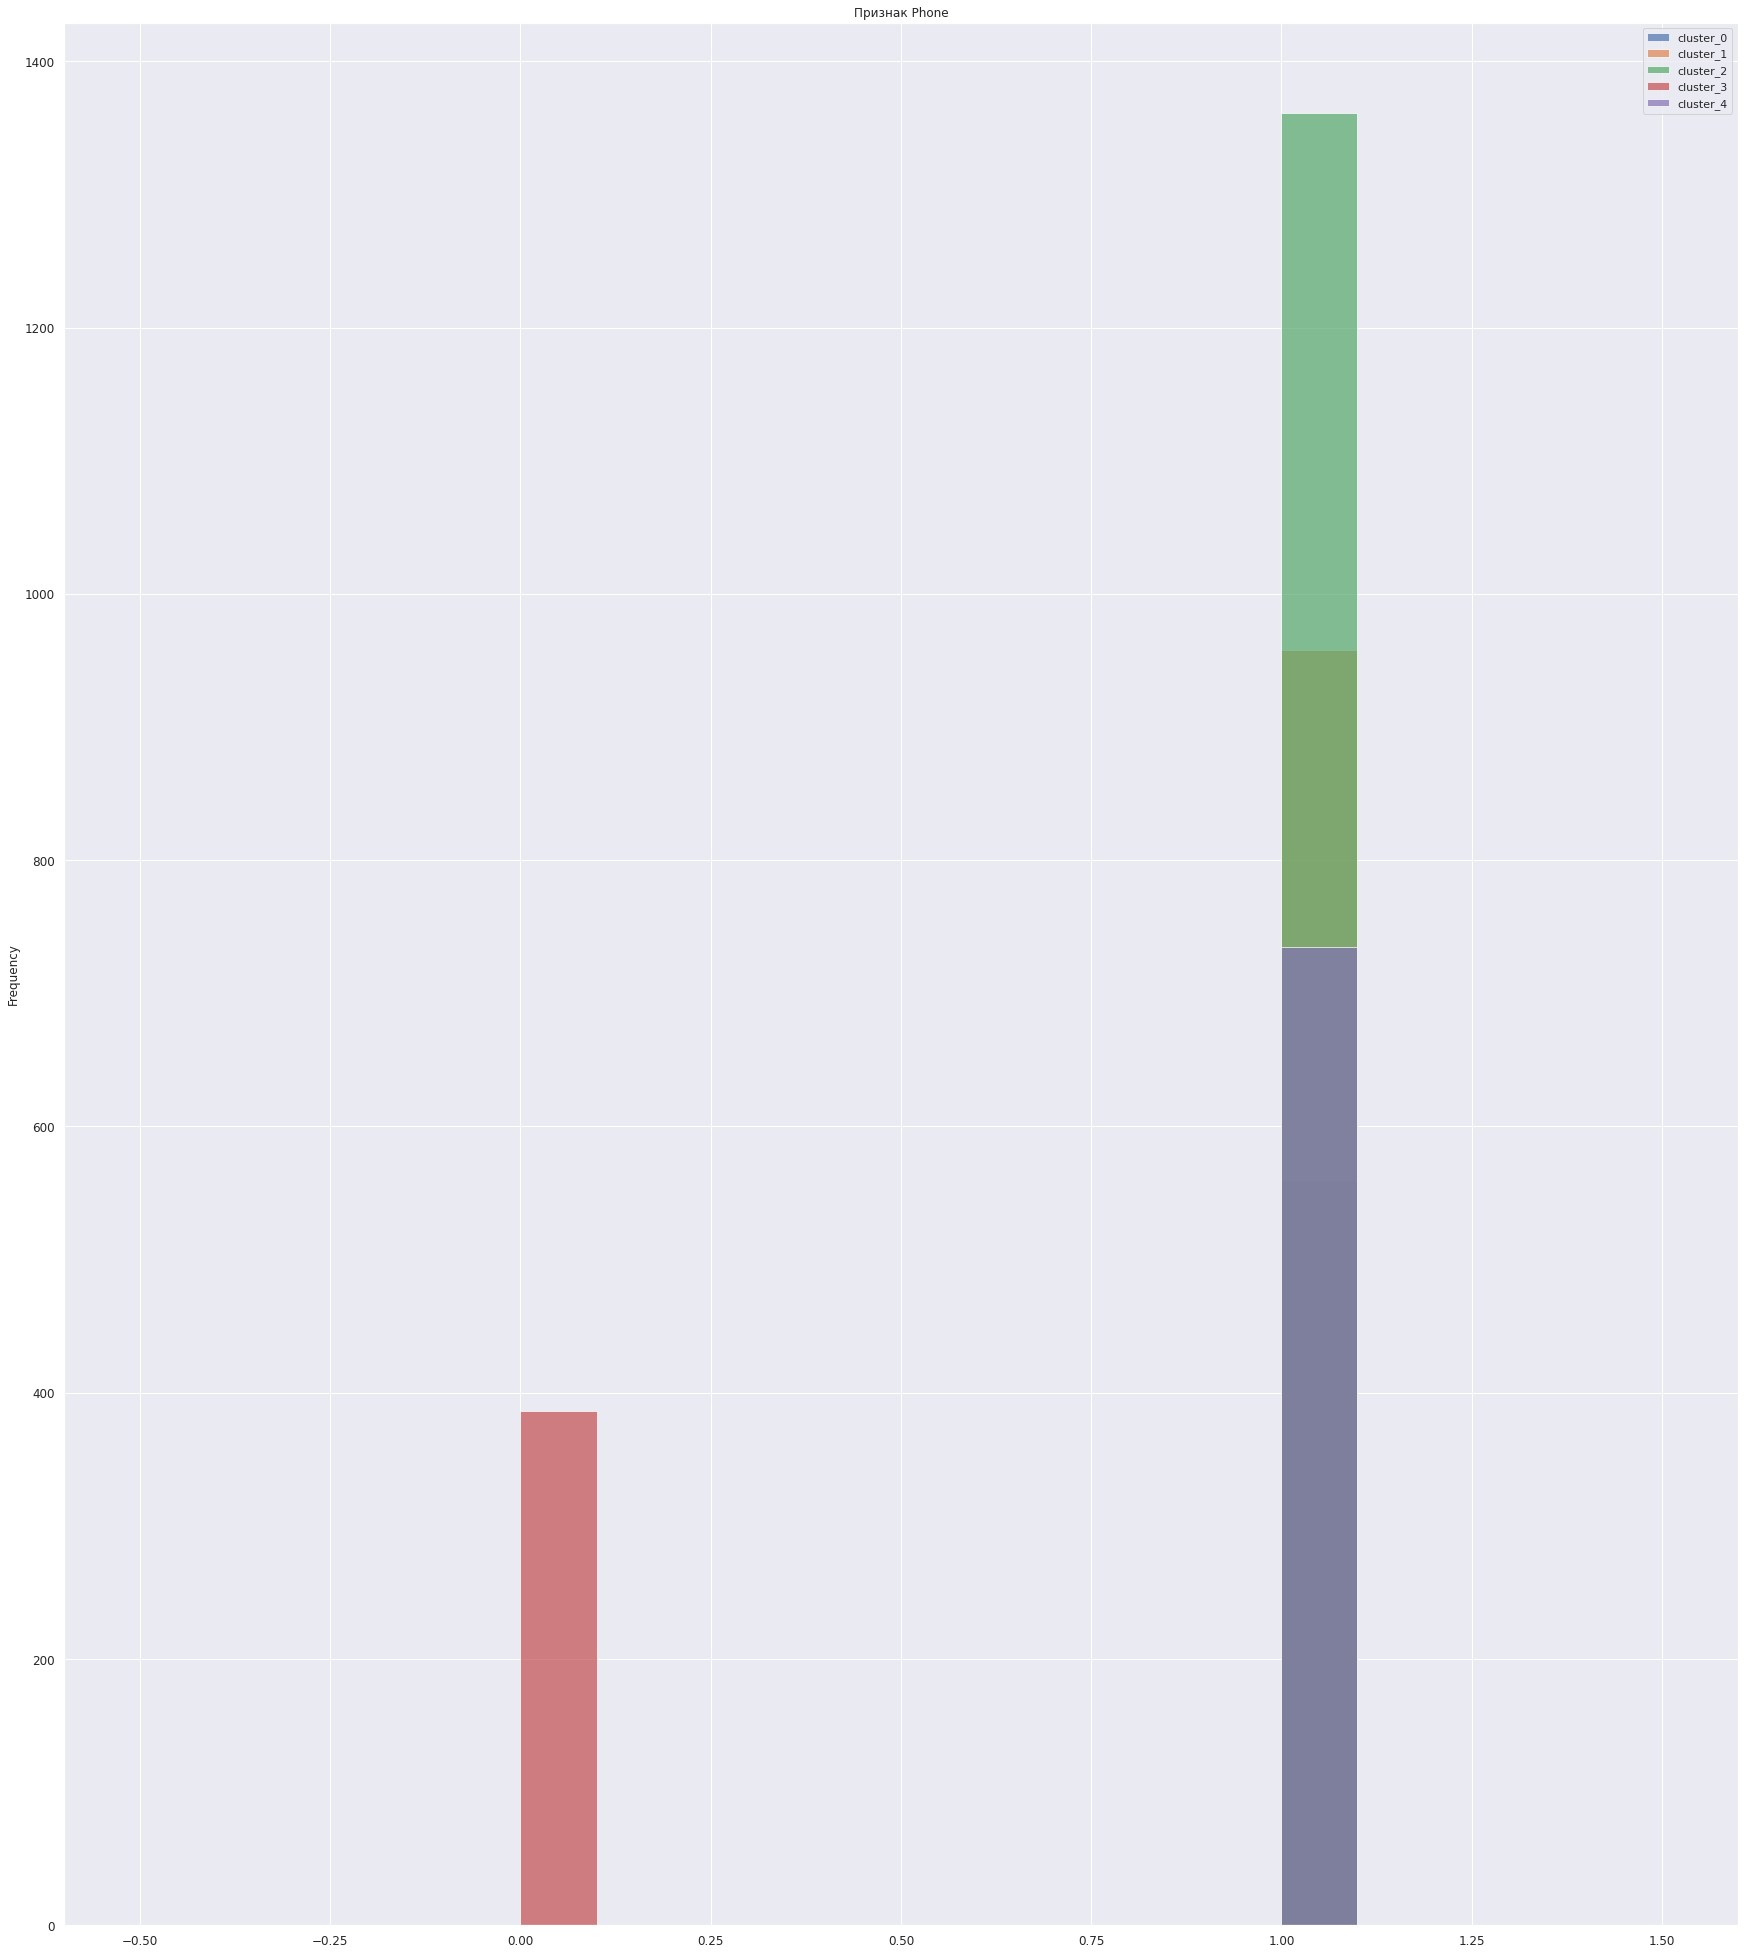

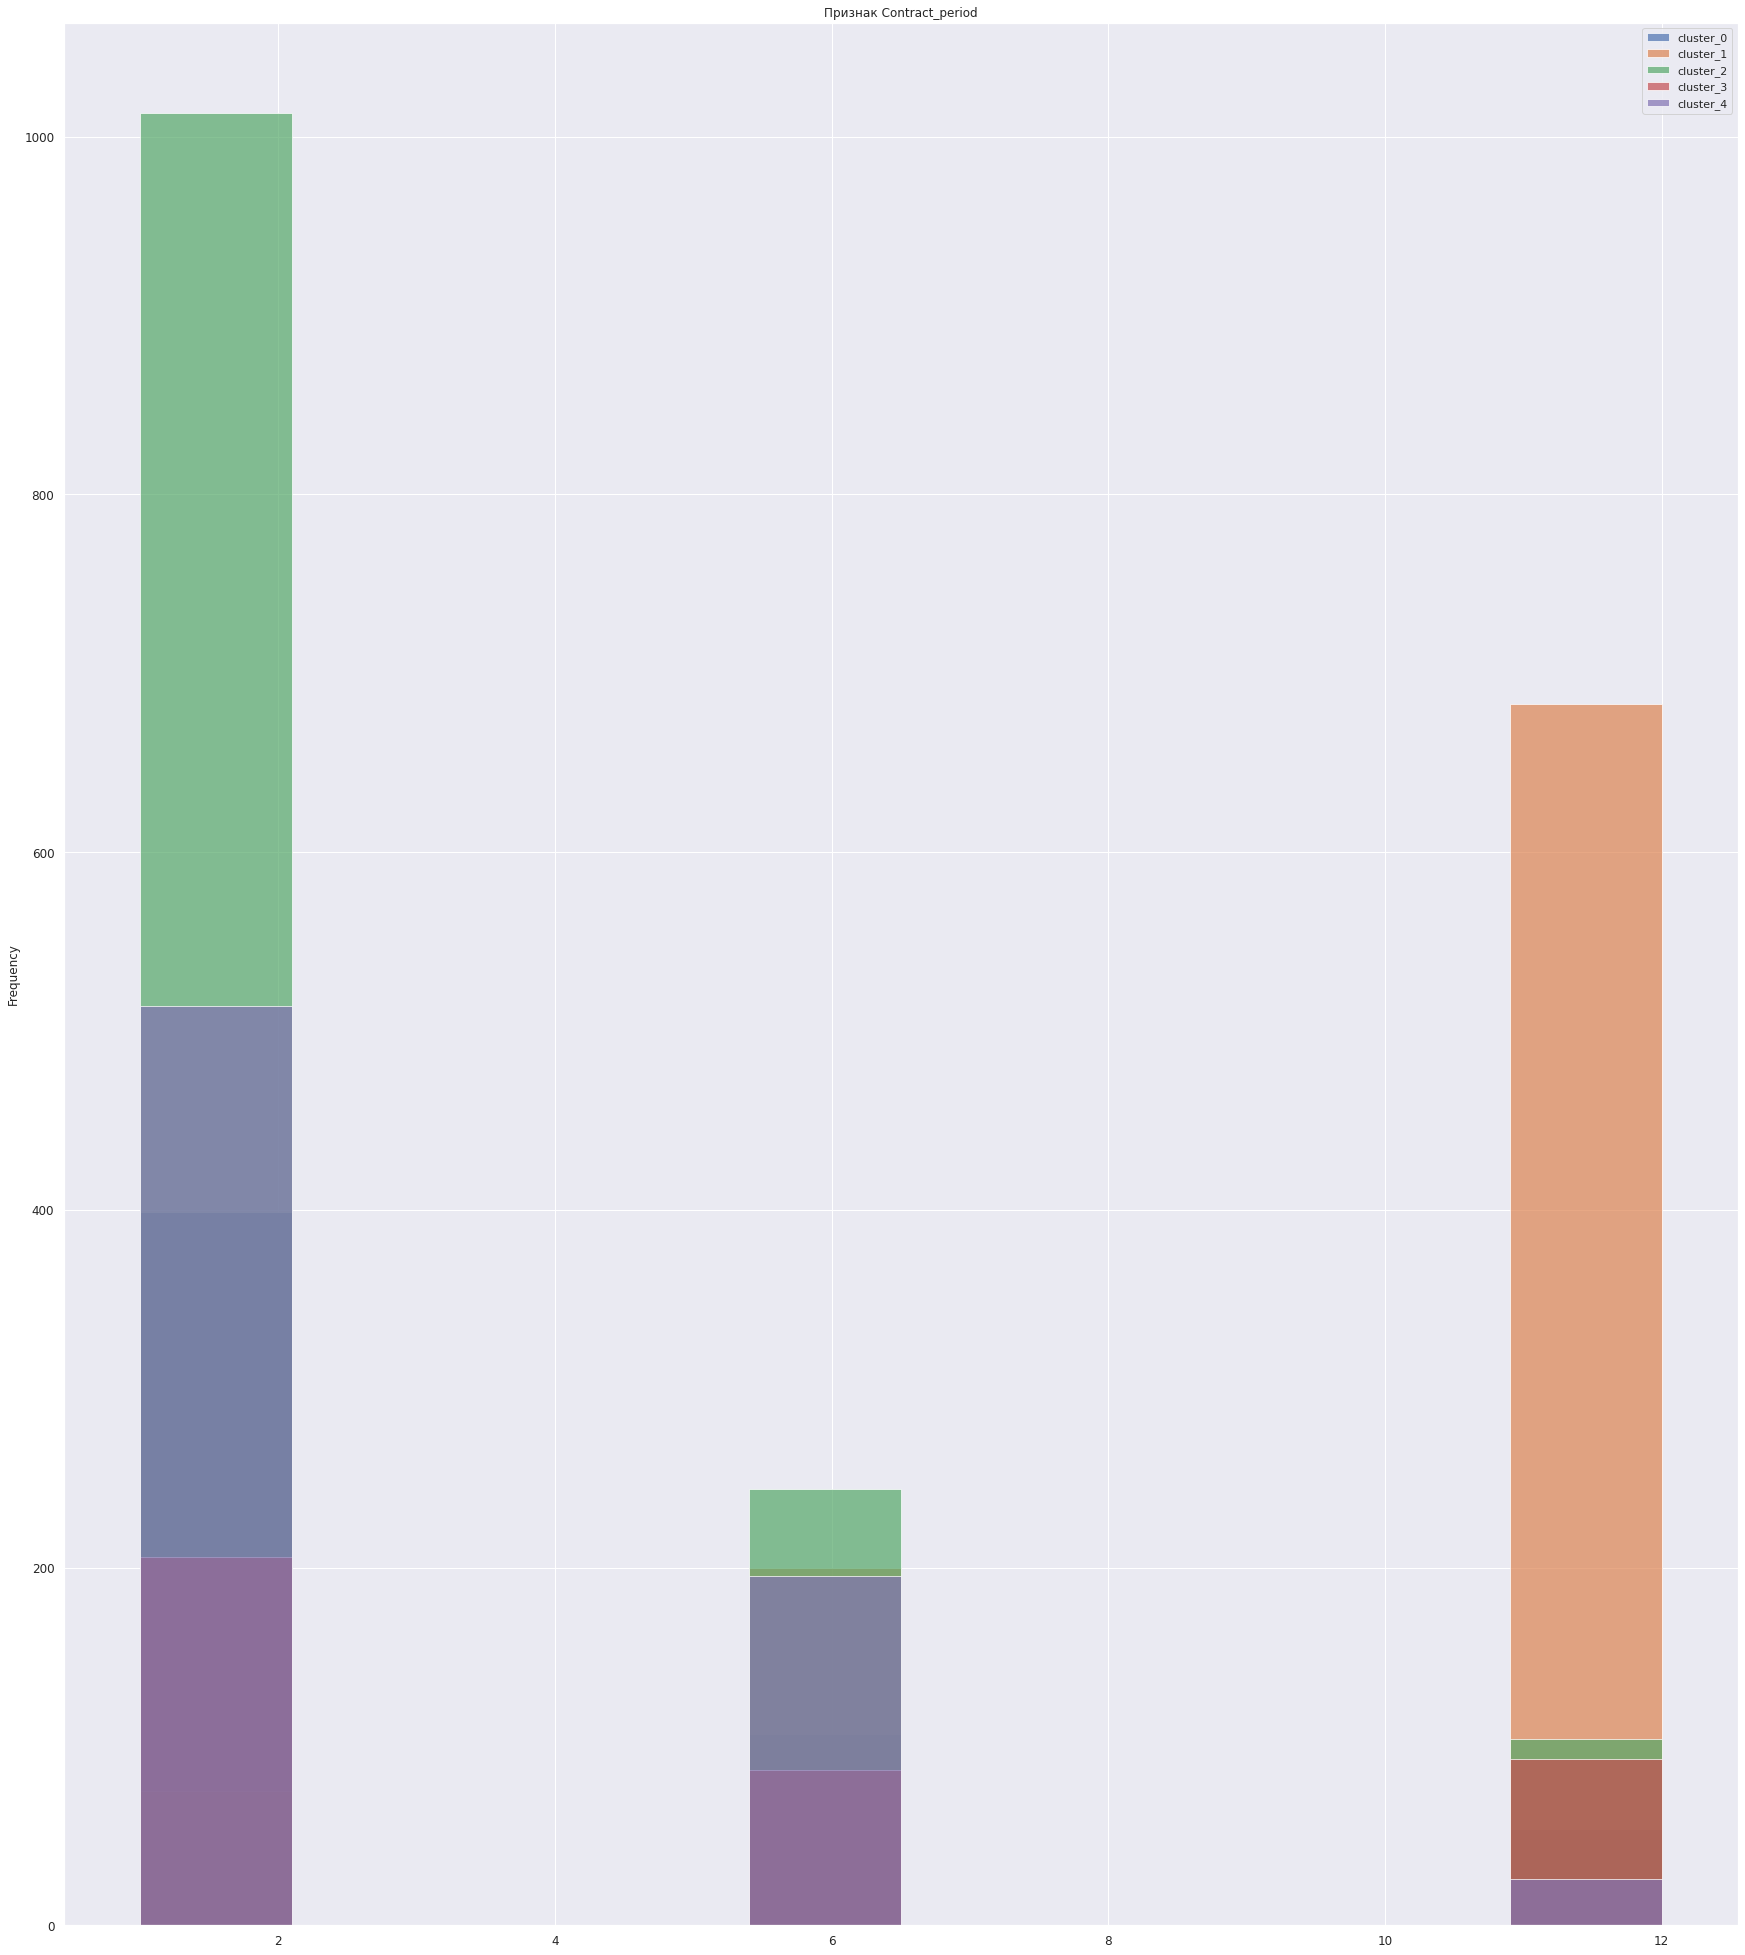

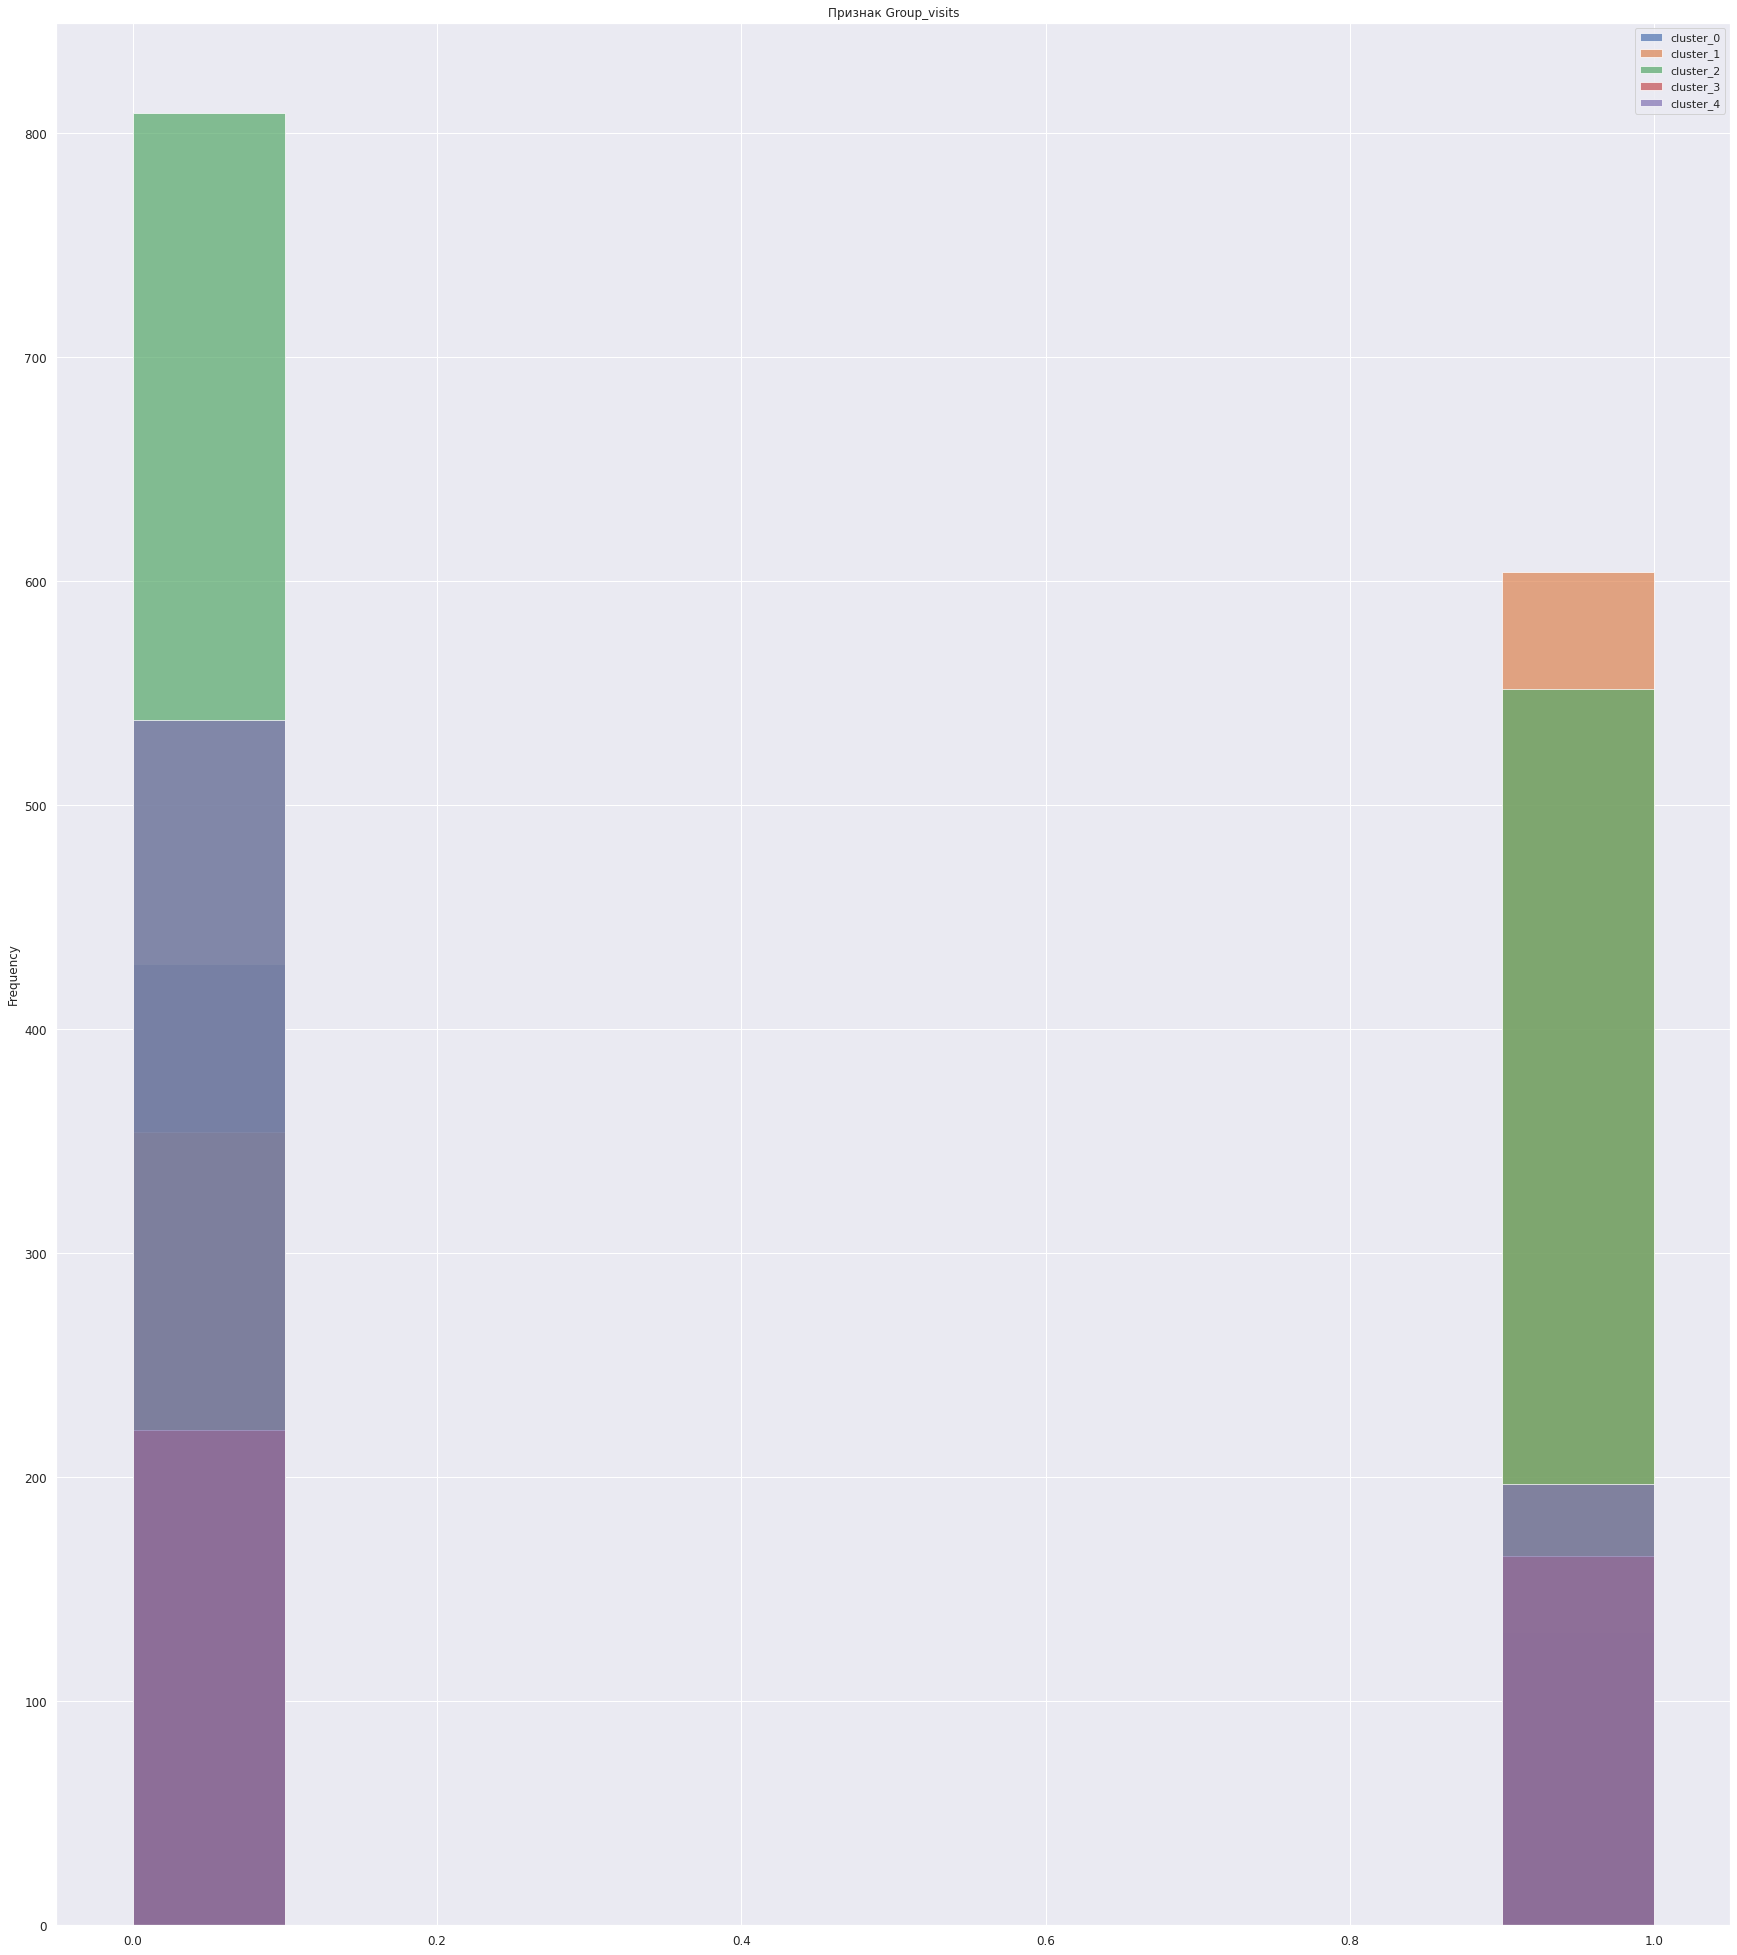

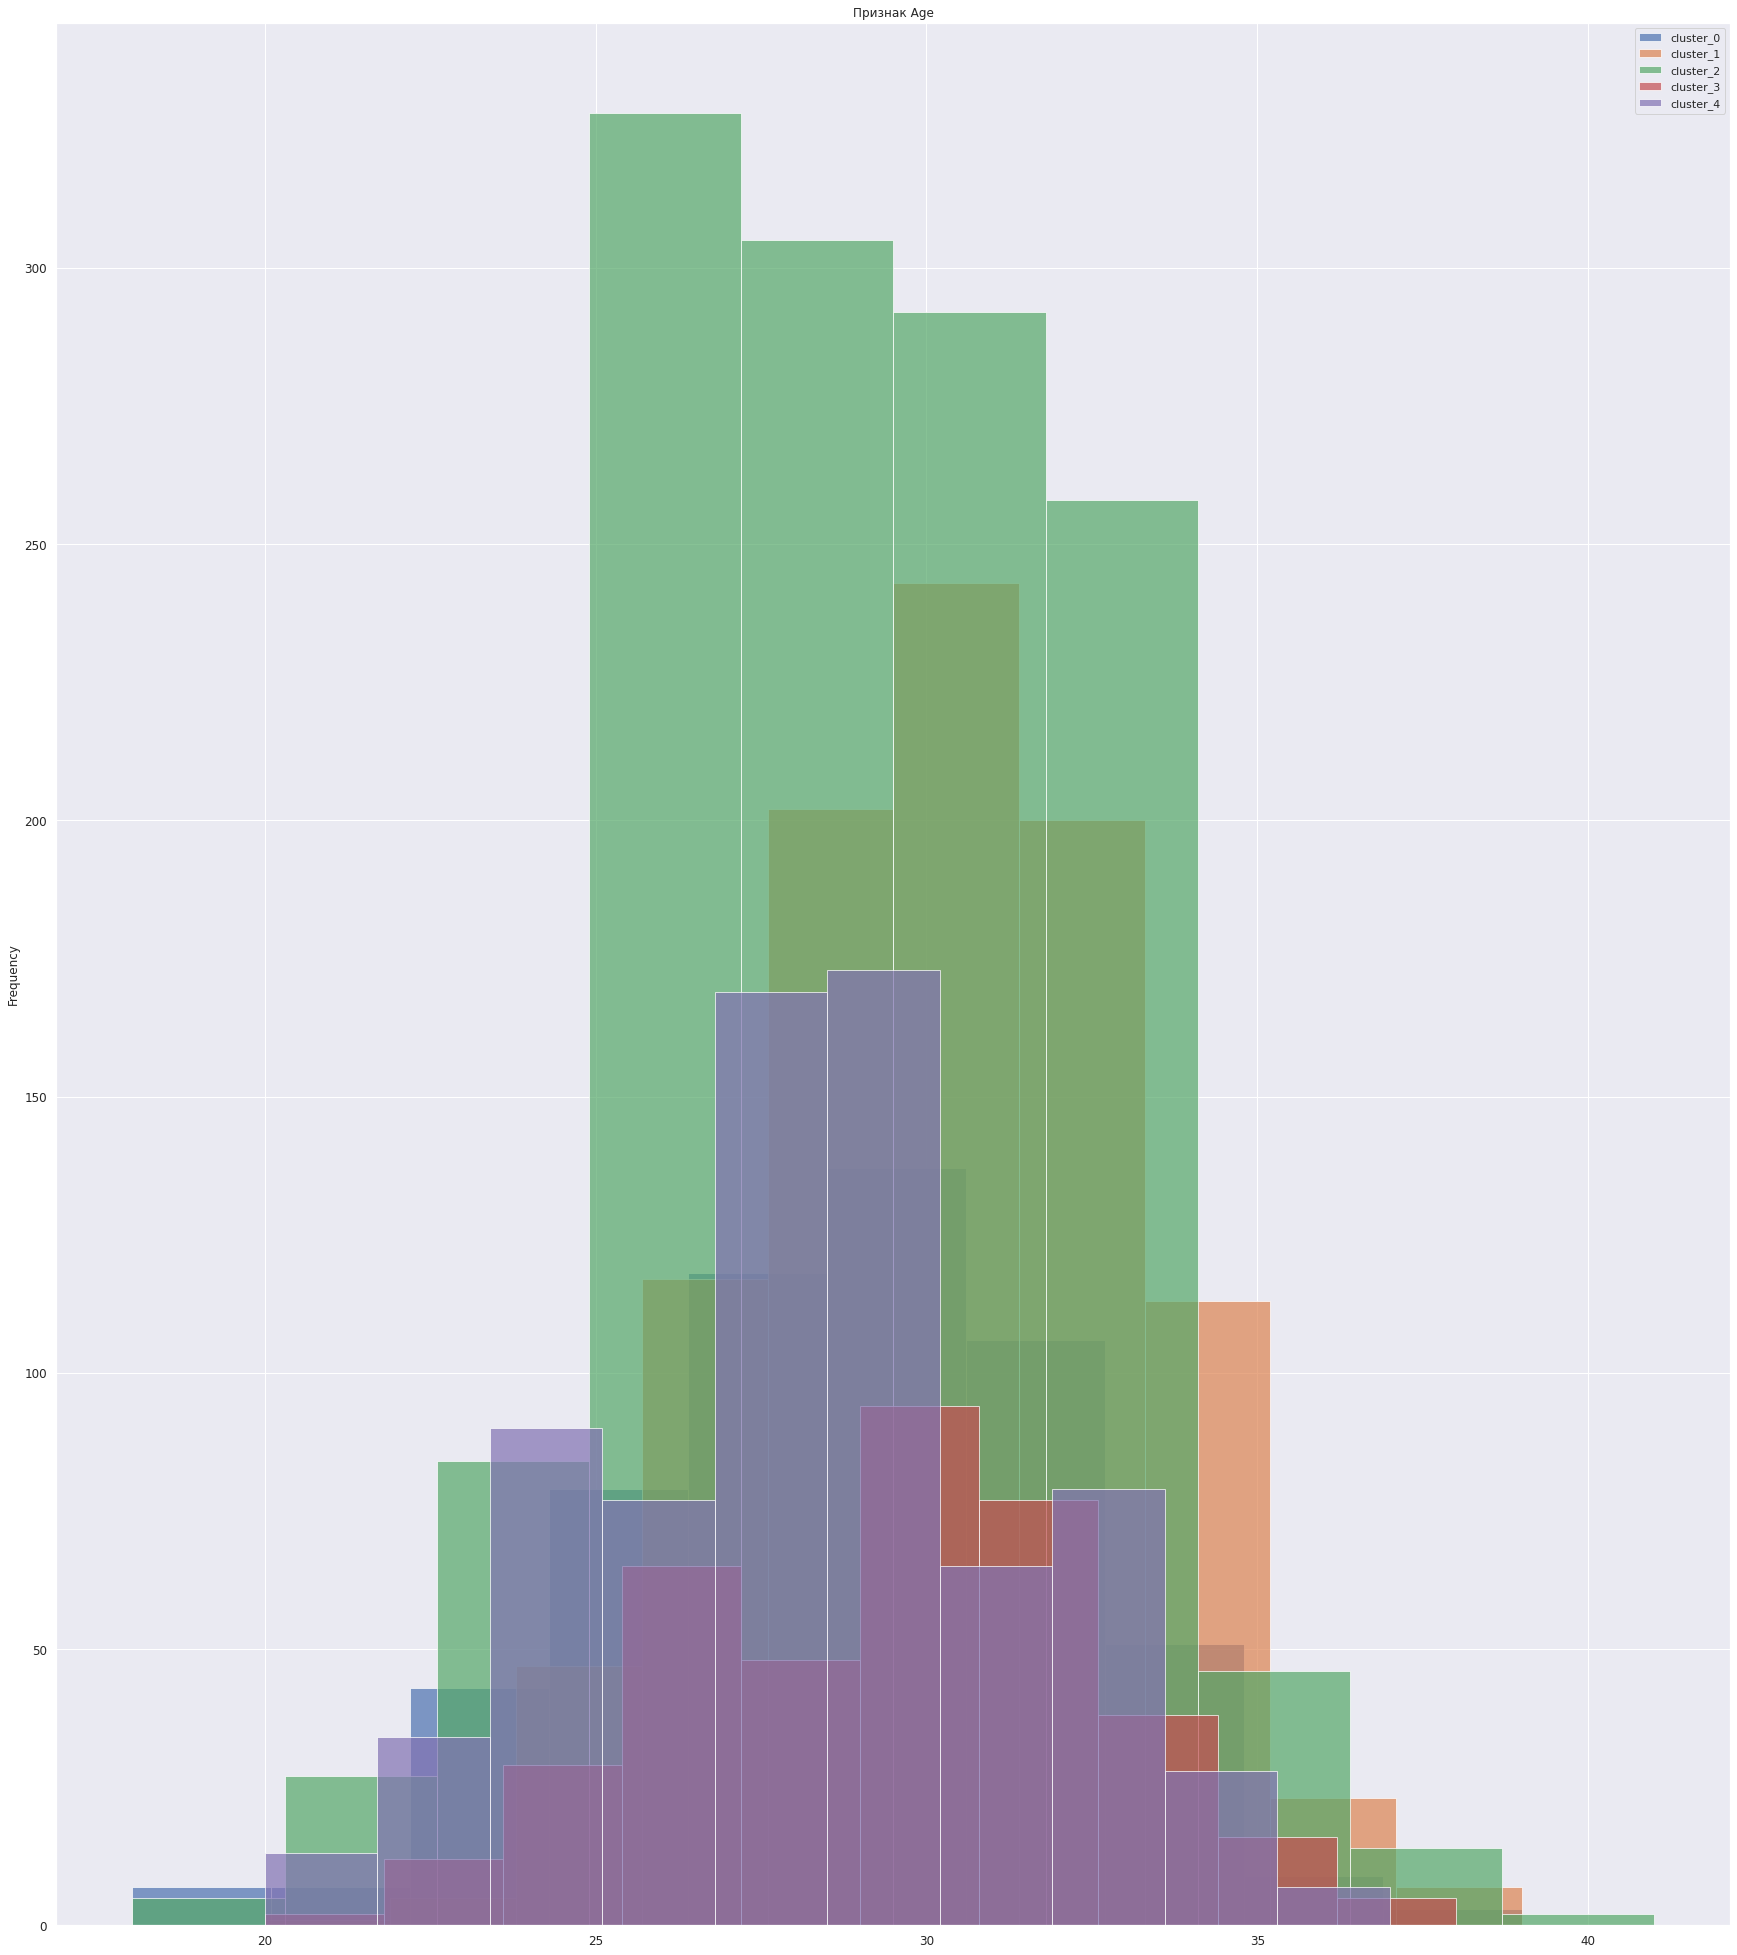

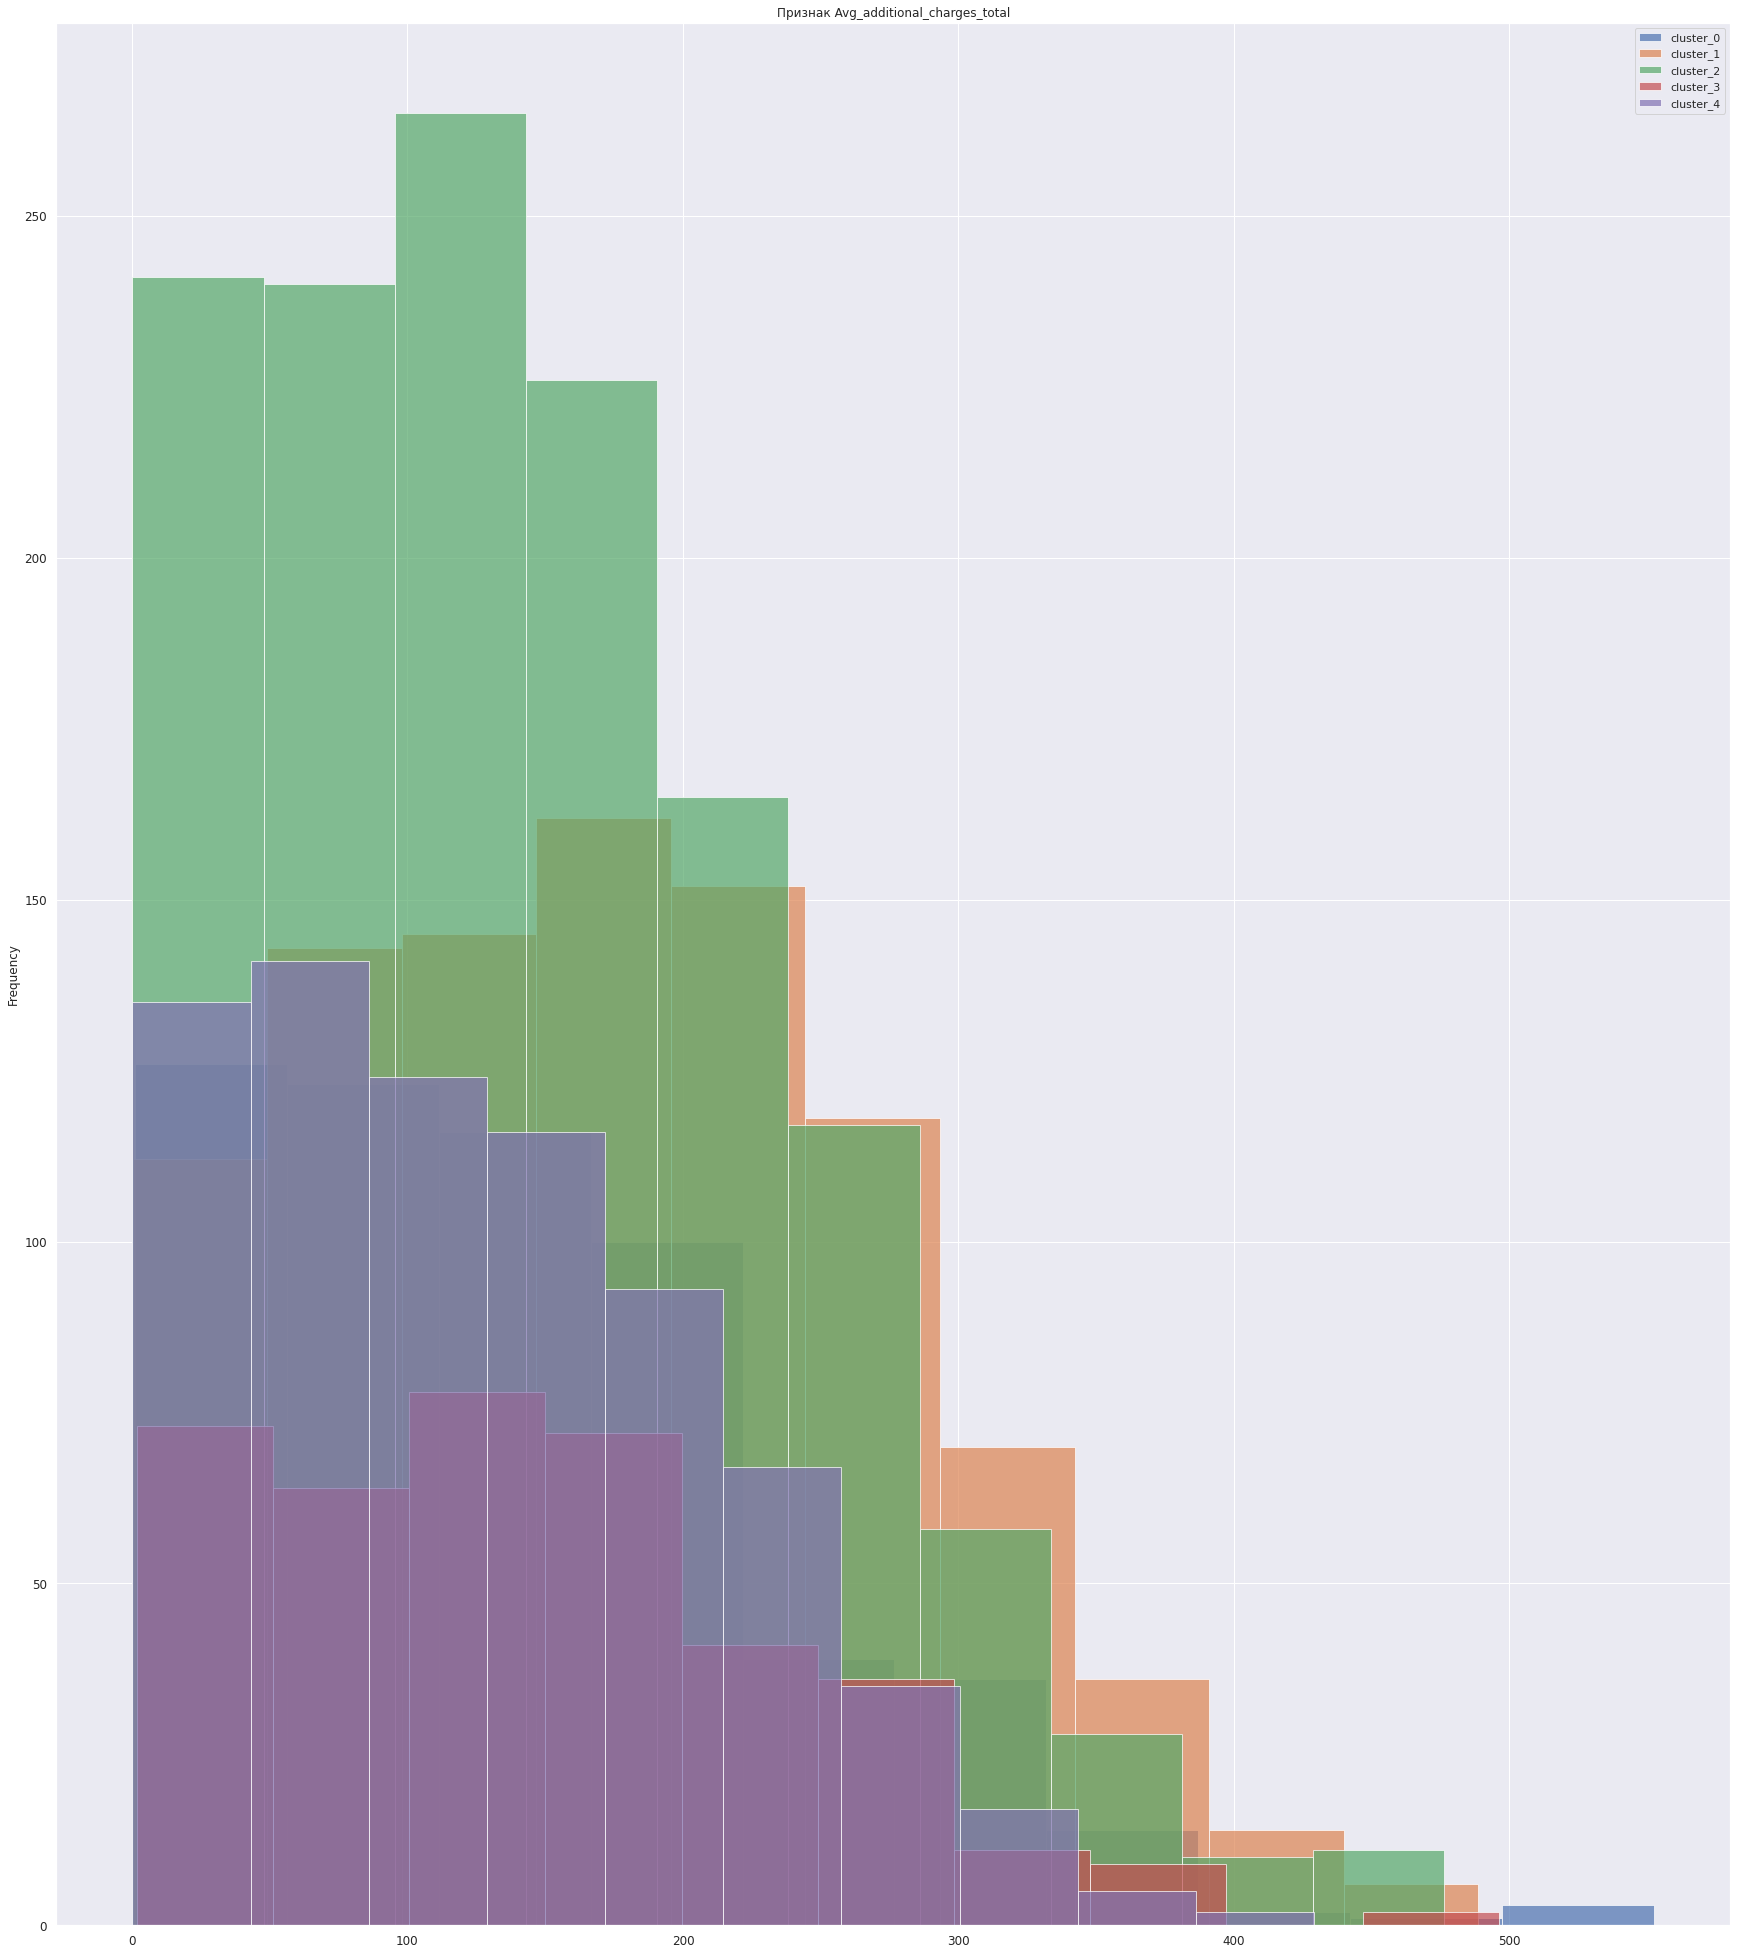

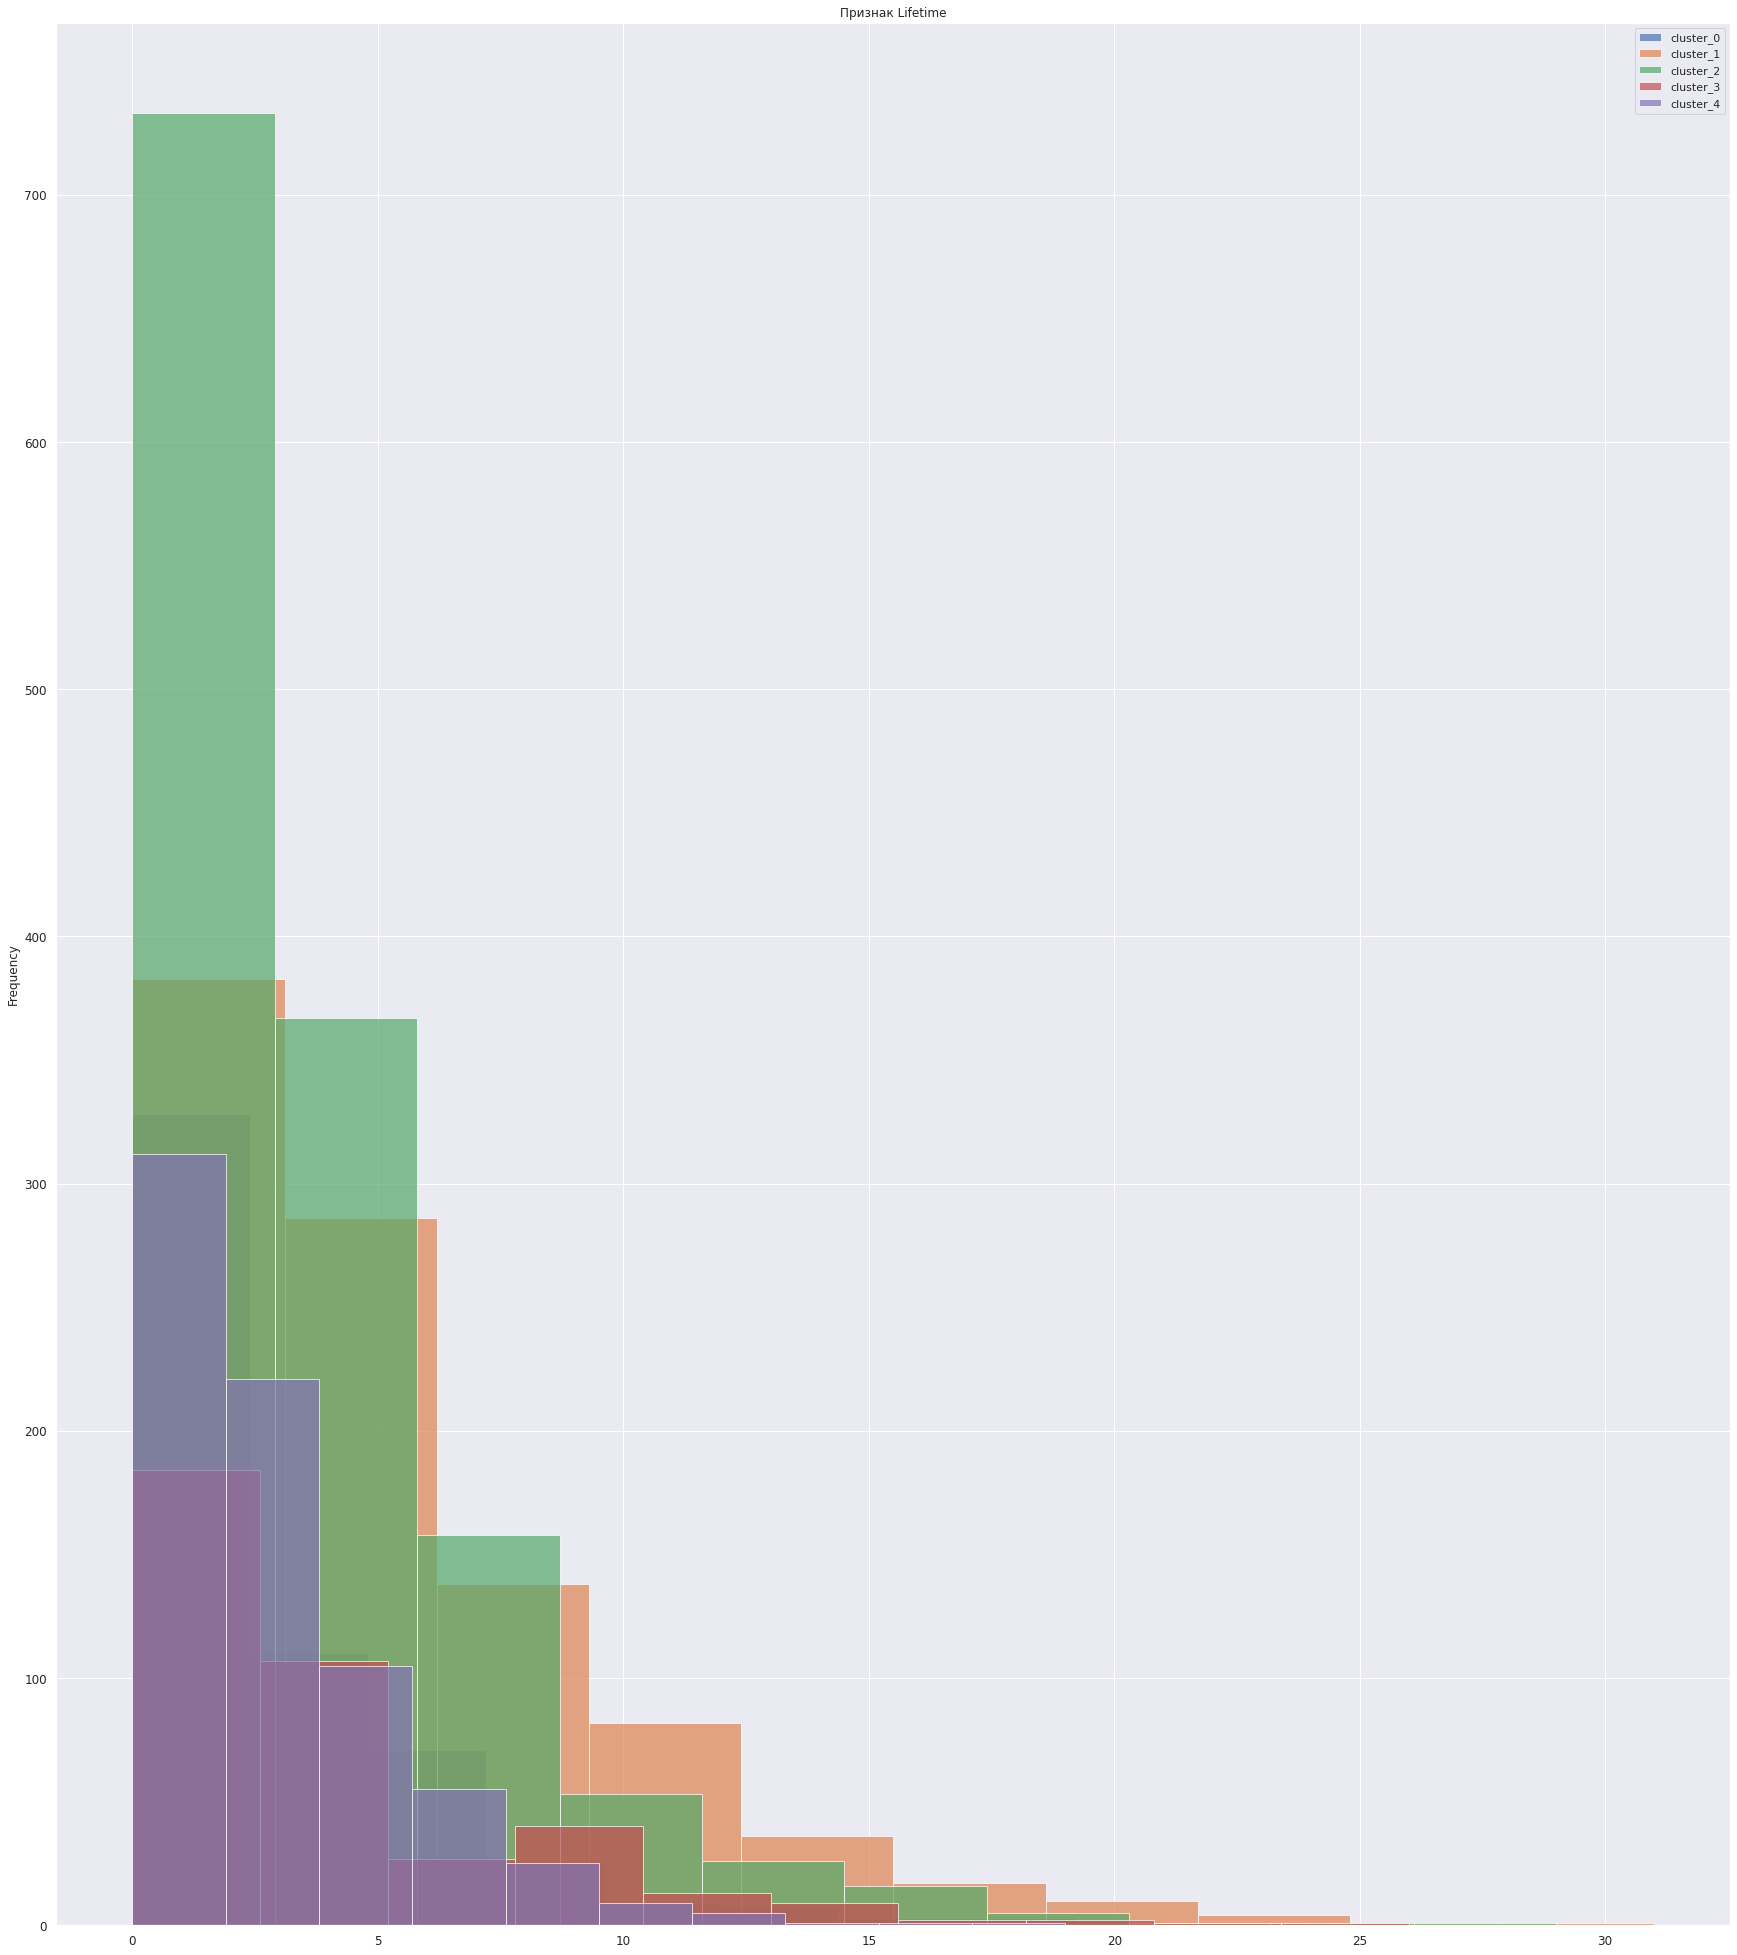

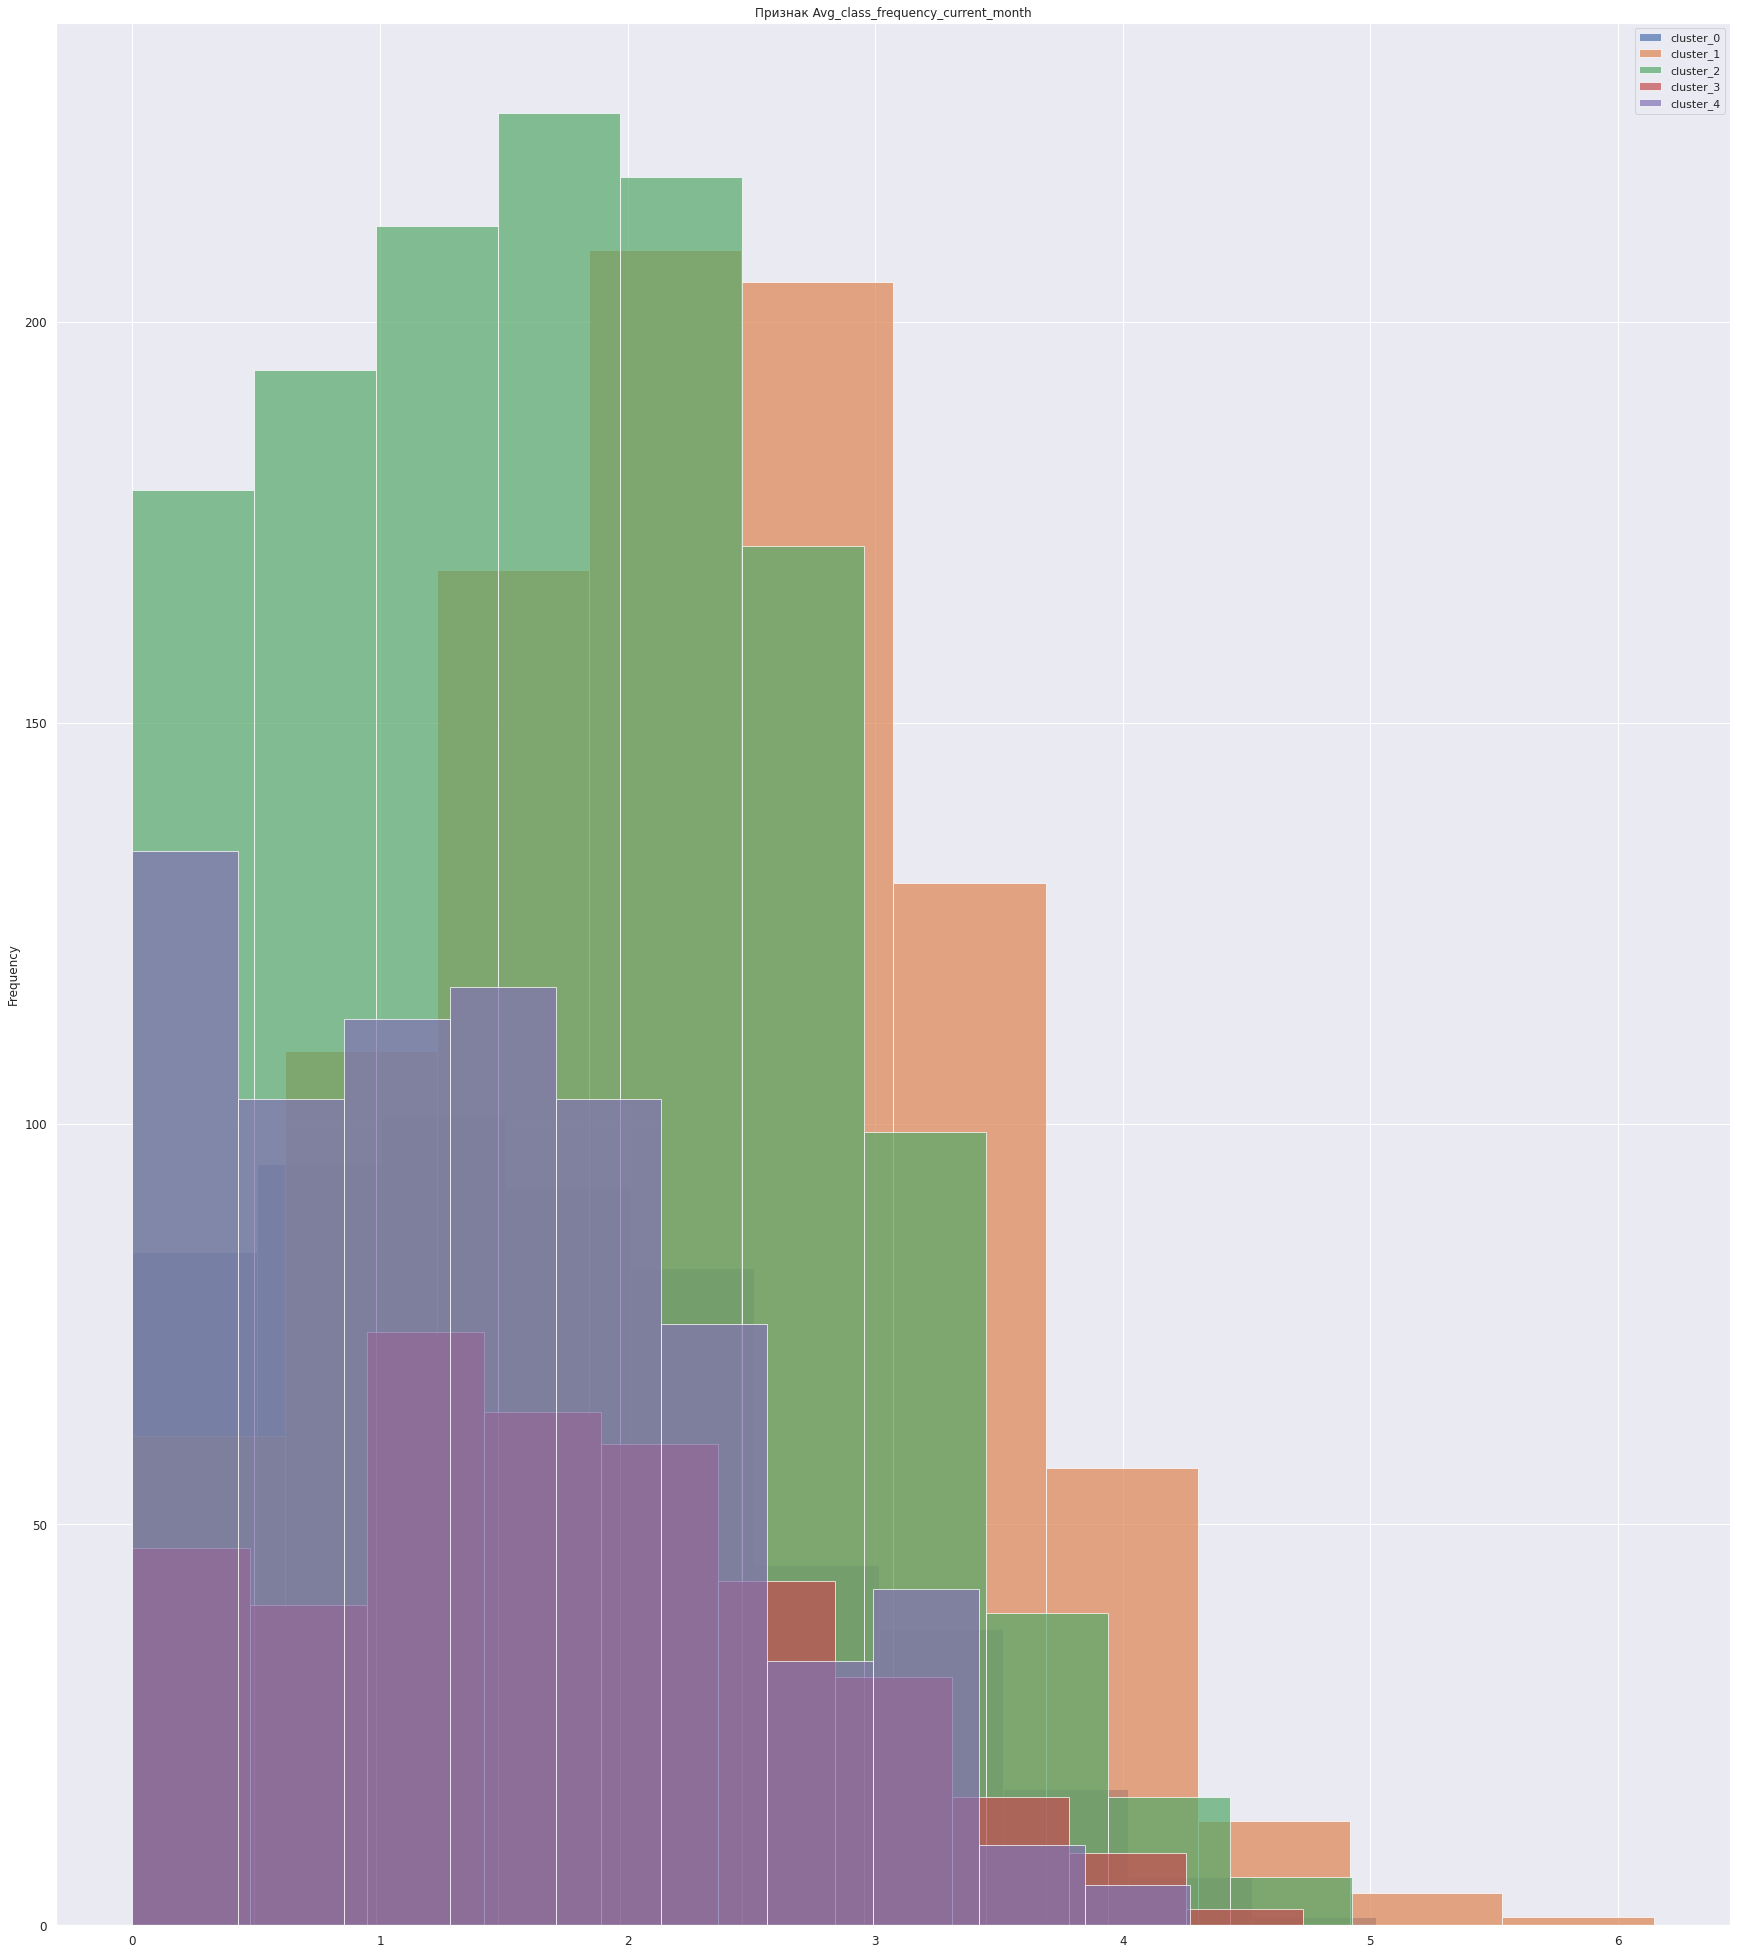

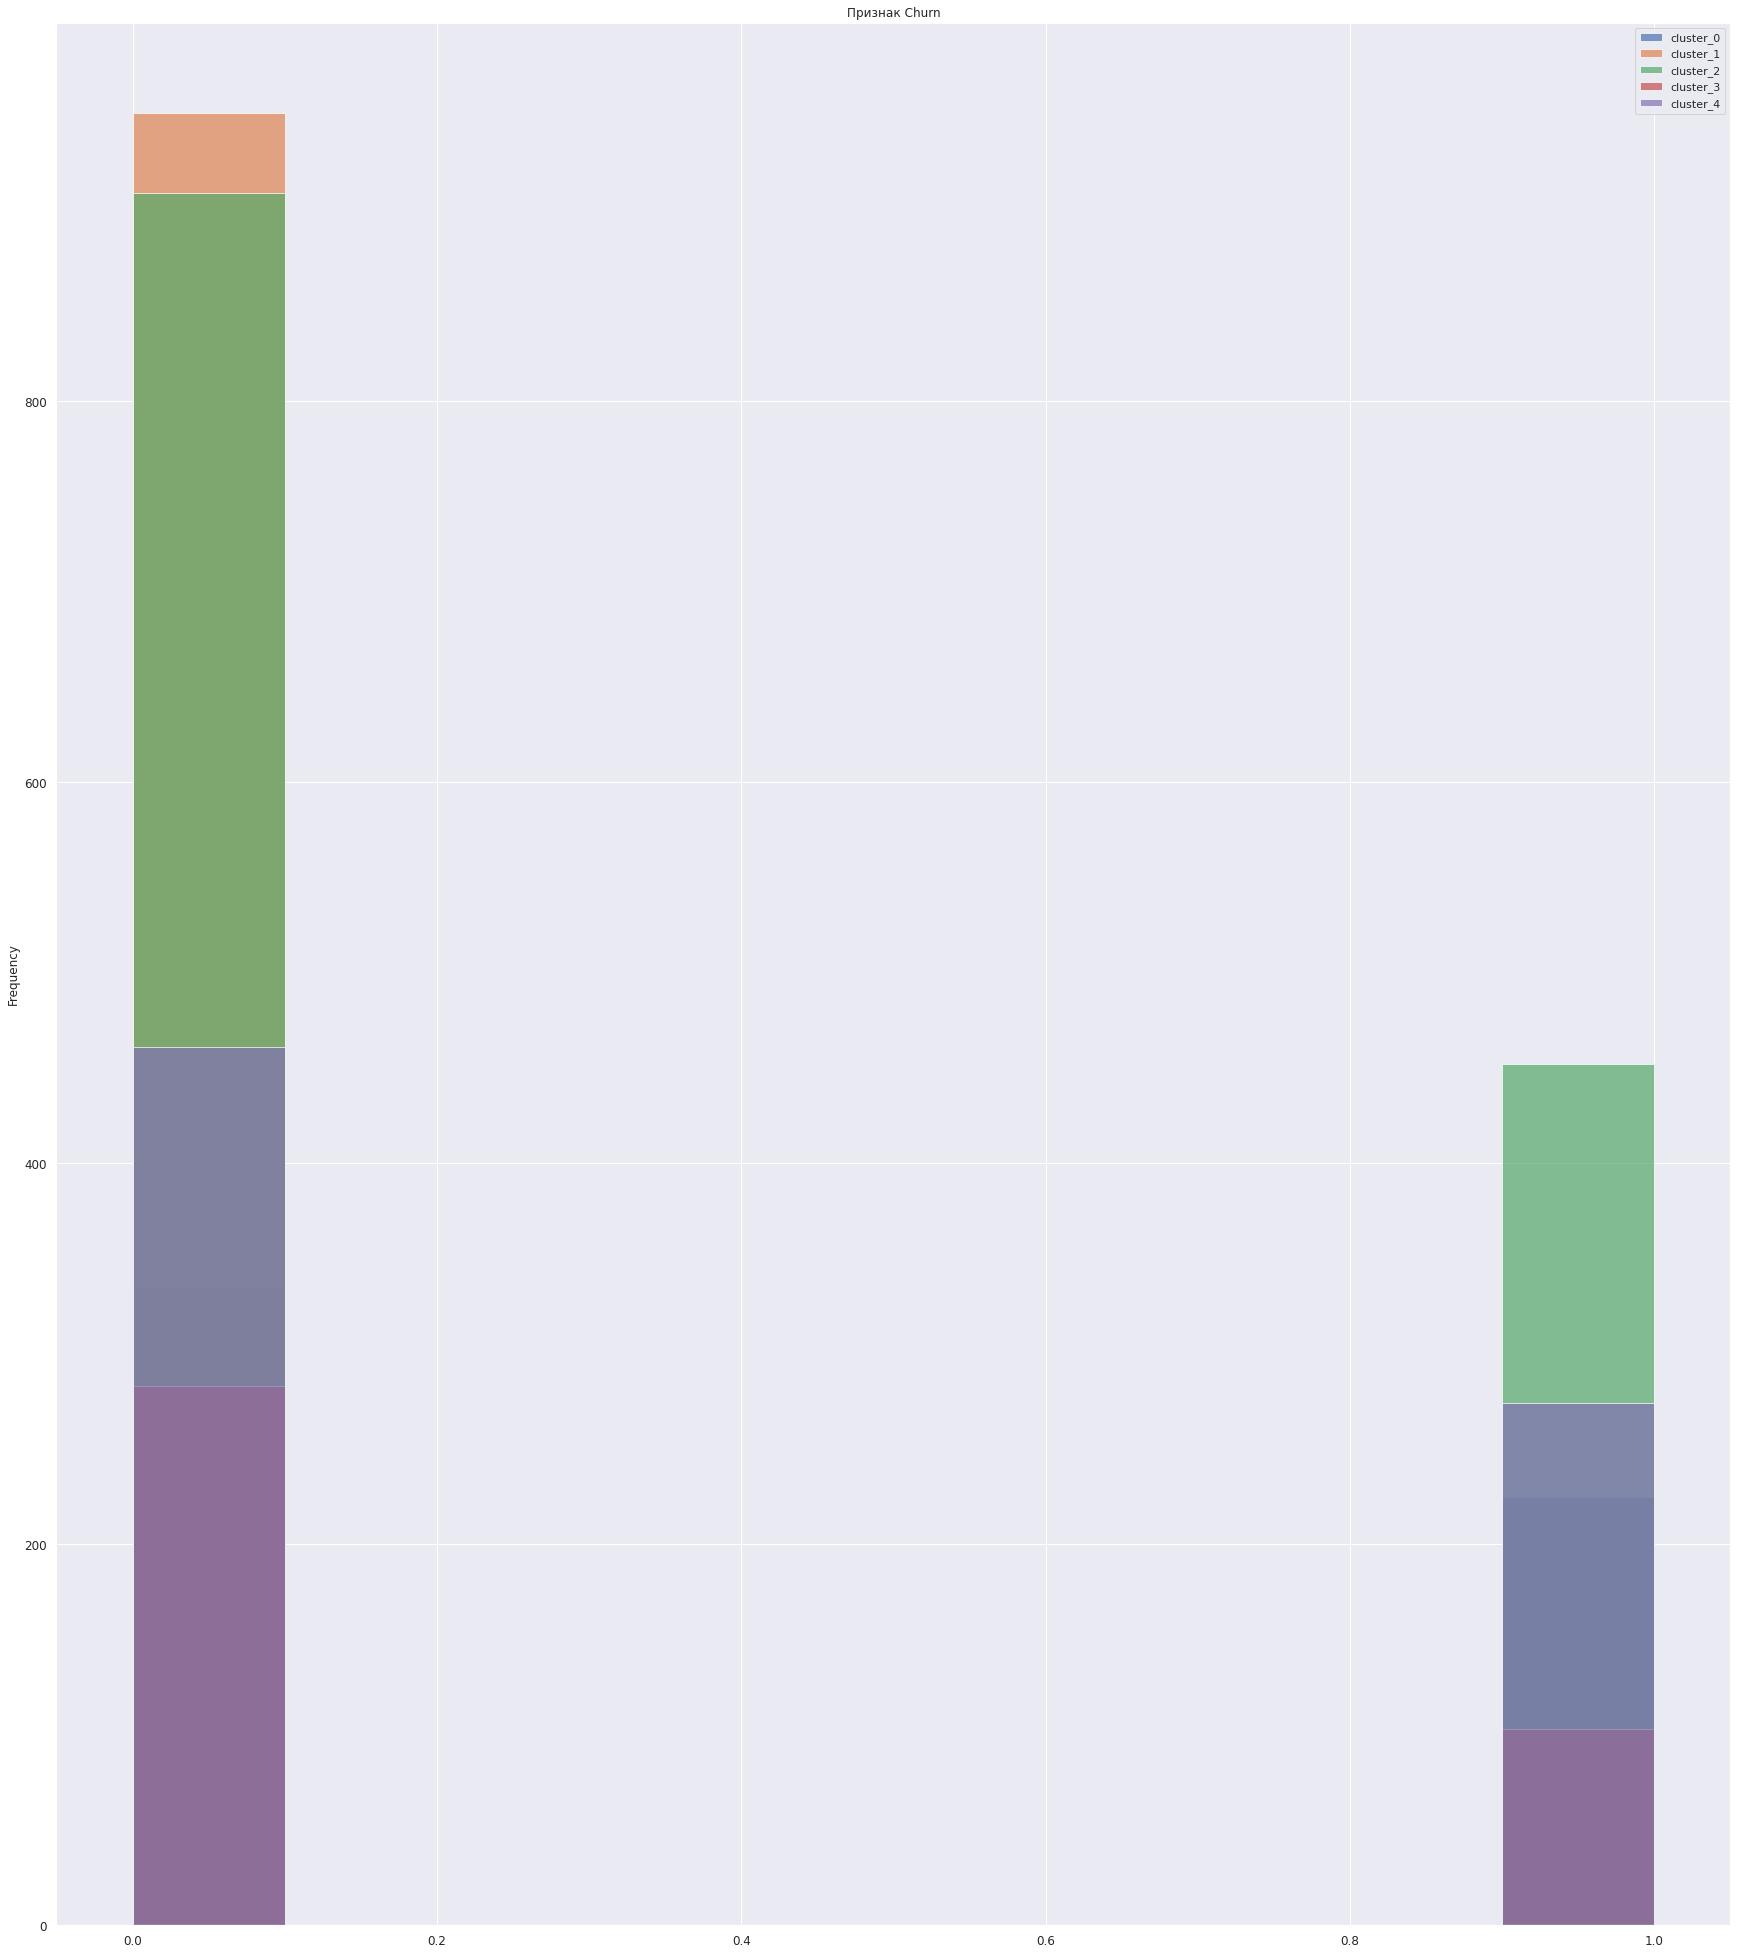

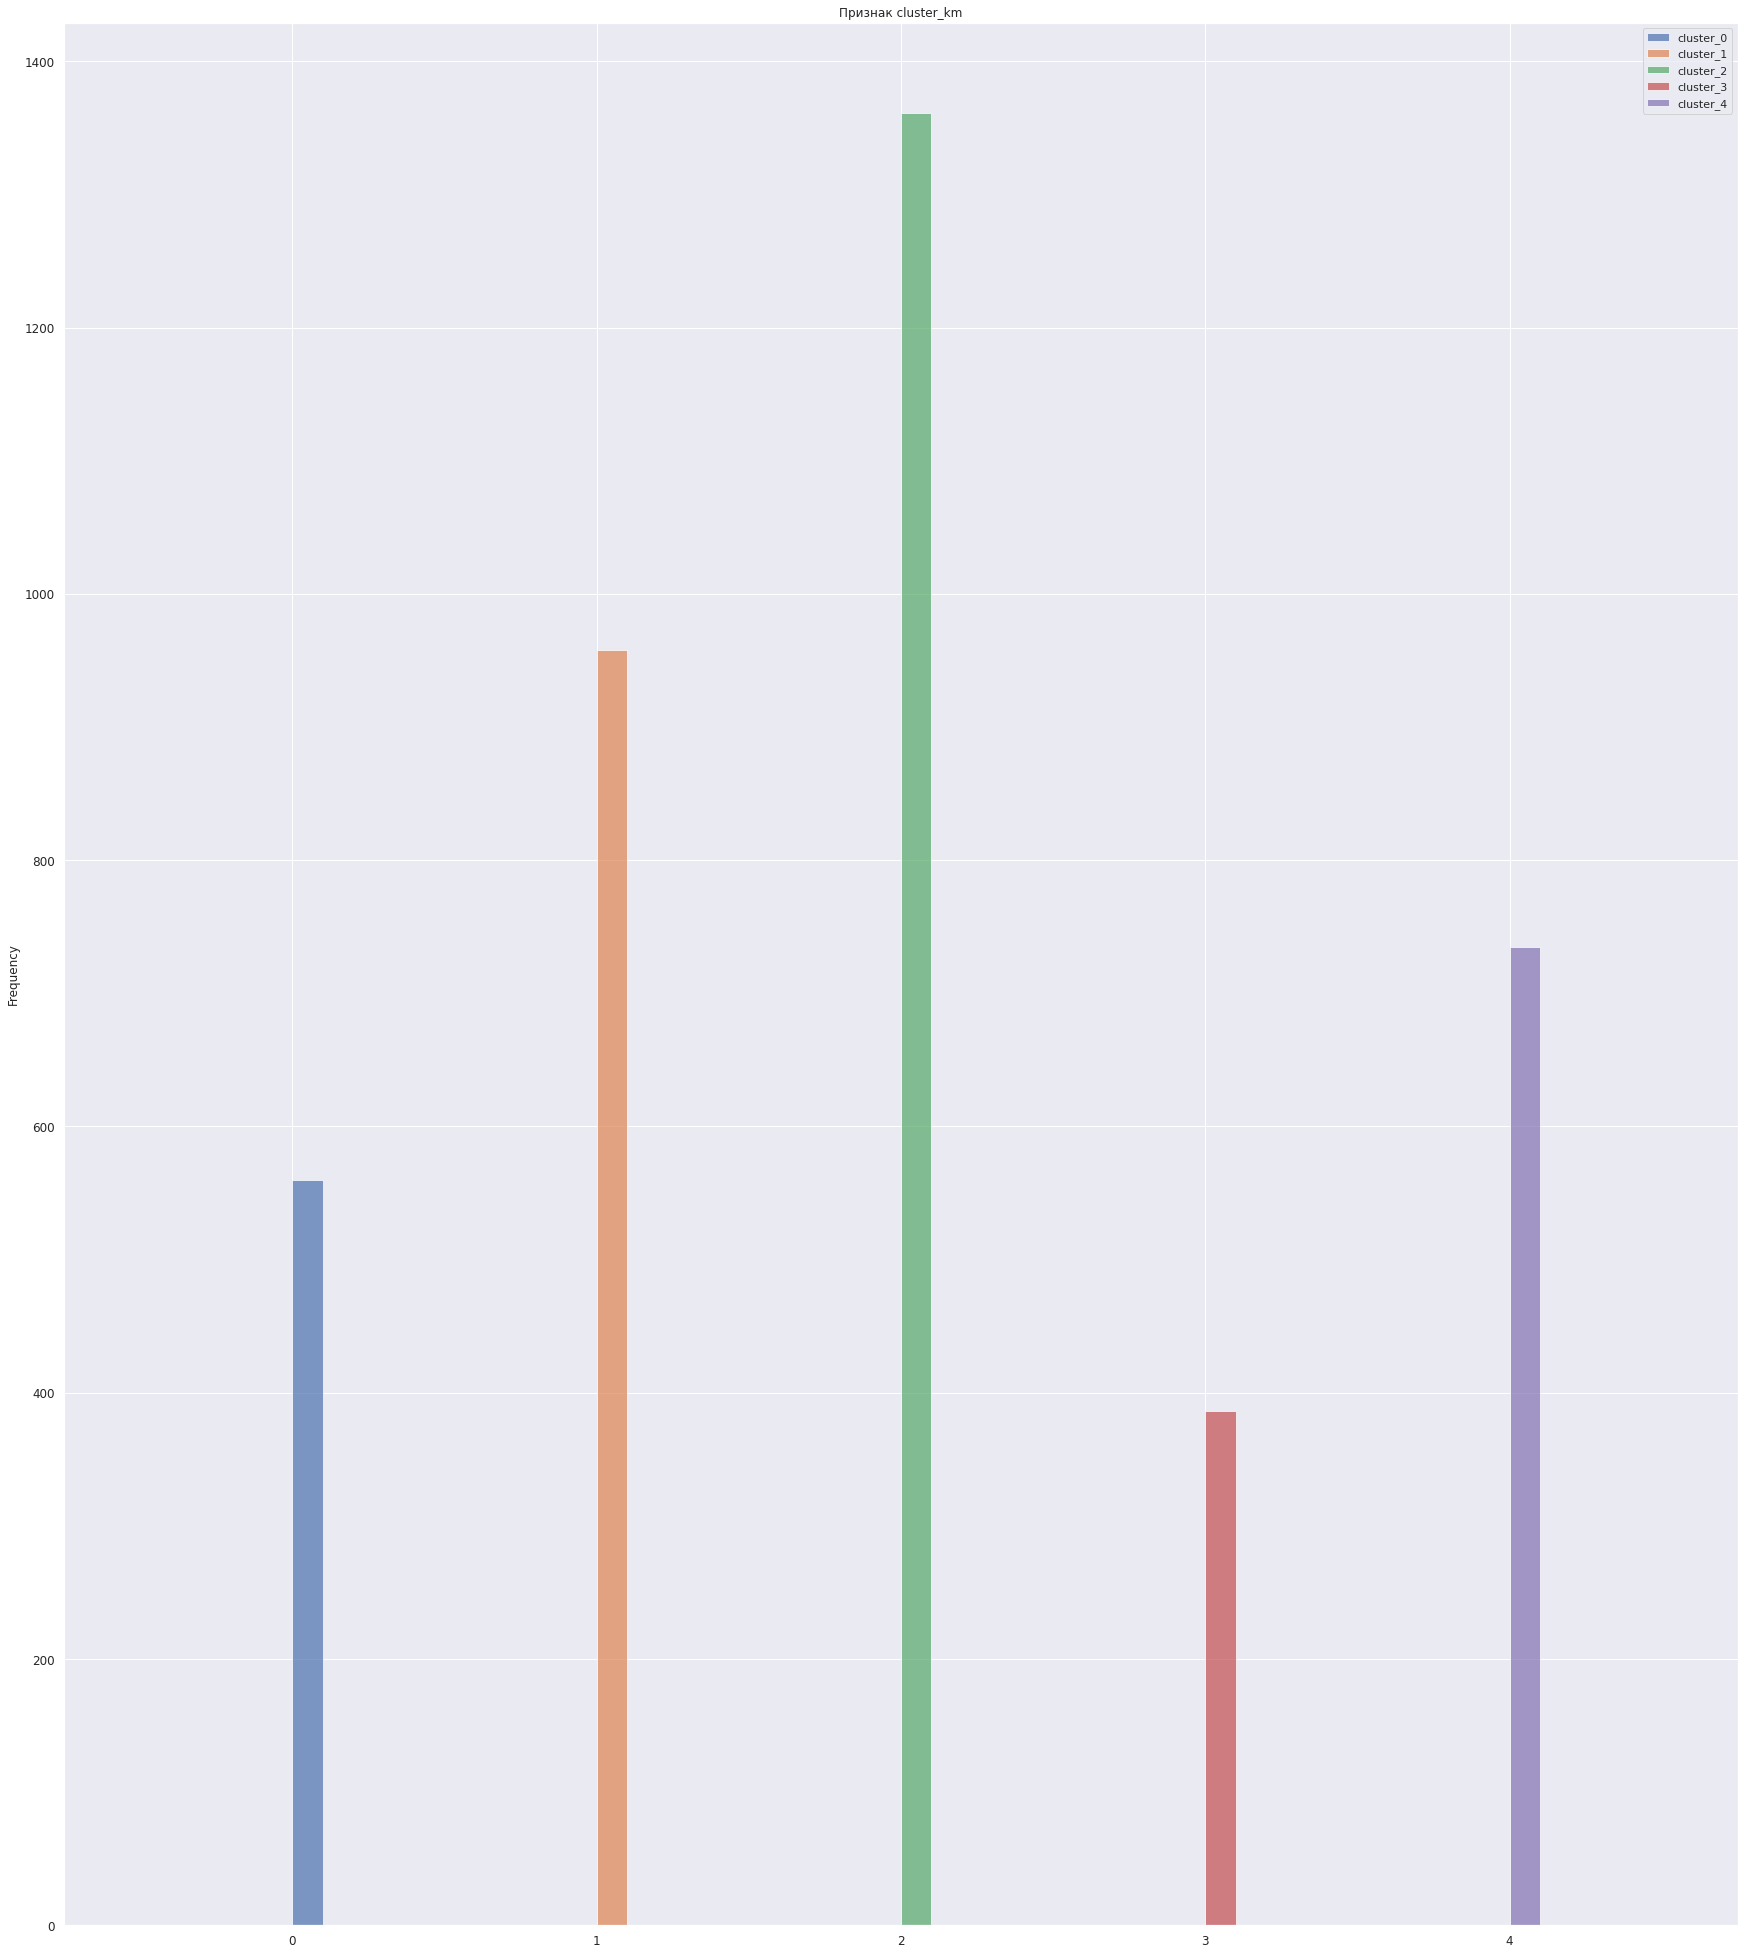

In [107]:
for feature in df.columns.tolist():
    cluster_0 = df.query('cluster_km == 0').plot(
        kind='hist',
        y=feature,
        alpha=0.7,
        label='cluster_0',
    )

    cluster_1 = df.query('cluster_km == 1').plot(
        kind='hist',
        y=feature,
        alpha=0.7,
        label='cluster_1',
        ax = cluster_0
    )

    cluster_2 = df.query('cluster_km == 2').plot(
        kind='hist',
        y=feature,
        alpha=0.7,
        label='cluster_2',
        ax = cluster_1
    )

    cluster_3 = df.query('cluster_km == 3').plot(
        kind='hist',
        y=feature,
        alpha=0.7,
        label='cluster_3',
        ax = cluster_2
    )

    df.query('cluster_km == 4').plot(
        kind='hist',
        y=feature,
        alpha=0.7,
        label='cluster_4',
        ax= cluster_3, 
        grid=True,
        legend=True,
    ) 
    plt.title(('Признак {}').format(feature))
    plt.show()

### Кластеры по доле оттока

In [56]:
df.groupby('cluster_km')['Churn'].mean().sort_values(ascending=False)

cluster_km
0    0.401786
4    0.372789
2    0.332109
3    0.266839
1    0.007307
Name: Churn, dtype: float64

In [57]:
(df.groupby('cluster_km')['cluster_km'].count() / 4000).sort_values(ascending=False)

cluster_km
2    0.34025
1    0.23950
4    0.18375
0    0.14000
3    0.09650
Name: cluster_km, dtype: float64

- Наибольший отток происходит от кластеров 0, 4, 2, 3. От кластера 1 практически не происходит оттока.
- Наибольшее кол-во клиентов преобладаетв кластере №2.

## Шаг. Выводы и базовые рекомендации по работе с клиентами.

### Рекомендации по работе с клиентами

- Следует обратить внимание на кластеры под номерами 0, 4, 2. У них наблюдается большая доля оттока клиентов. Следует обратить большое внимание на кластер №2, т.к. в нем собрана основная доля клиентов (34%). 
- Доля клиентов, которые продолжают посещать тренировки постоянно находится в пределах 14%.
- На основе данных была создана модель линейной регрессии, которая имеют метрику нахождения оттока клиентов - 79 (recall), которую можно ввести в эксплуатацию. 
- Следует обратить внимание на среднее посещение тренажерного зала в месяц, лайфтайм, количество месяцев до окончания контракта, возраст и период абонемента. Данные признаки показывают большое влияние на отток.

### Общие выводы

- В таблице отсутствуют дубликаты и пропуски 
- Данные приведены к нужному типу. Категориальные признаки переведны в количественные методом one-hot-encoding
- Количественные данные приведены к нужному типу

**В среднем посетители**: 
- Покупают абонемент на один месяц
- Имеют возраст 29 лет
- Тратят около 136 валюты за все время посещения
- Ходят в зал 2,5 раза в неделю по статистике за все время и по статистике за месяц

**В среднем посетители, которые продолжают заниматься:**
- Сотрудники компании-партнера клуба
- Покупают абонемент на 6 месяцев
- Имеют возраст 30 лет
- Тратят на дополнительные услуги 150 валюты
- Имеют 6 месяцев до окончания контракта
- Имеют 4 месяца с первого обращения в клуб
- Занимают около 2-3 раз в неделю (т.е. 2,7 - ближе к 3)

**В среднем посетители, которые бросили заниматься:**
- Сотрудники компании-партнера клуба
- Имеют возраст около 27 лет
- Тратят 103 валюты на дополнительные услуги
- Покупают абонемент на 1 месяц
- Имеют 1 месяц до конца абонемента
- Имеют 1 месяц с момента первого посещения клуба
-  Посещают зал за все время и месяц 1 раз в неделю.

**Выводы по посетителям, которые продолжили заниматься:**
- Преобладает гендер 1
- Преолбадает количество тех, кто живет рядом с клубом

**Выводы по посетителям, которые закончили заниматься:**
- Преобладает также гендер 1
- Пробладает доля тех, кто живет рядом, но тех, кто живет рядом доля больше по сравнению с группой, продолжившей заниматься
- Тратили на дополнительные услуги меньше примерно на 100
- Аболюстная доля тех, кто покупал абонемент меньше чем на месяц

**Выводы по корреляции:**
- Признак Month_to_end_contract и contract period корреляруют с 97 значением
- Признаки AVG_class_frequency_total и AVG_class_frequency_curren_month корреляируют с 95 значением
- Признаки: AVG_class_frequency_curren_month, Lifetime, Month_to_end_contract, Age, Contract_period имеют бОльшую корреляцию с целевых признаком

**Выводы по созднию модели для прогнозированния оттока клиентов:**
- Все предложенные модели оказались лучше, чем DummyClassifier, а значит польза от такой модели выше, чем от обычного угадывания.
- Наиболее важным параметром является метрика Recall. Лучше направить средства на поддержание клиента, чтобы не ушел. В даном случае это окупится.
- Лучше всех показала себя самая простая модель логистической регресии.

**Кластер №1 (с наименьшей долей оттока по кластеру) характеризуется:** 
- Повышеной средней длиной абонемента (9 месяцев)
- Повышенной вероятность быть сотрудником компании-партнера
- Приглашением друга в 60% случаев
- Посещением группового занятия в 60% случаев
- Повышенной (на 30 больше от ближайшего кластера) суммой покупок на доп. услуги
- Лайтаймом в 5 месяцев
- Посещением зала 2 раза в неделю

**Кластер №0 (с наибольшей долей оттока по кластеру) характеризуется:** 
- Длиной абонемента в среднем в 3 месяца
- Пониженной вероятность привода быть сотрудником компании-партнера
- Приглашением друга в всего в 7% случаев
- Посещением группового занятия в 23% случаев
- Пониженной суммой покупок на доп. услуги
- Лайтаймом в 3 месяца
- Посещением зала 1,6 раза в неделю в среднем

- Наибольший отток происходит от кластеров 0, 4, 2, 3. От кластера 1 практически не происходит оттока.
- Наибольшее кол-во клиентов преобладаетв кластере №2.

- Следует обратить внимание на кластеры под номерами 0, 4, 2. У них наблюдается большая доля оттока клиентов. Следует обратить большое внимание на кластер №2, т.к. в нем собрана основная доля клиентов (34%). 
- Доля клиентов, которые продолжают посещать тренировки постоянно находится в пределах 14%.
- На основе данных была создана модель линейной регрессии, которая имеют метрику нахождения оттока клиентов - 79 (recall), которую можно ввести в эксплуатацию. 
- Следует обратить внимание на среднее посещение тренажерного зала в месяц, лайфтайм, количество месяцев до окончания контракта, возраст и период абонемента. Данные признаки показывают большое влияние на отток.
